#  Data Prep & Filtering

The dataset is filtered to only have users who purchased at least 10 products so that for each user, 20% of purchase history is in test set, 20% of purchase history is in the validation set, and 60% percent of purhcase history is in the training set. 

### train/validation/test split 

Training, testing, and validation data are all matrices of same size(# of unique users * # of unique product). All three matrix are disjoint(the entires of test and validation matrix are zeroed out in the train matrix.)

<table>
  <thead>
    <tr>
      <th>   </th>
      <th>user product matrix</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>shape</td>
      <td>(37284,38053 )</td>
    </tr>
    <tr>
      <td>sparcity</td>
      <td>99.93%</td>
    </tr>
    <tr>
      <td>Number of non-zero entries(training)</td>
      <td>554515</td>
    </tr>
    <tr>
      <td>Number of non-zero entries(validation)</td>
      <td>184834 </td>
    </tr>
    <tr>
      <td>Number of non-zero entries(testing)</td>
      <td>184830 </td>
    </tr>
  </tbody>
</table>

# Popularity Model (Baseline)

simply recommend the the most popular item give us very bad performance 

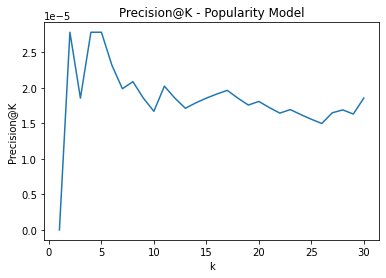

In [21]:
plt.plot(popularity_results['cutoff'],popularity_results['precision'] )
plt.title('Precision@K - Popularity Model')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

# Item Based CF


- Compute an item-to-item similarity matrix. The idea is to calculate how similar a product is to another product. There are a number of ways of calculating this. (cosine, Jaccard,or pearson similarity measure)

Item-Based CF Prediction

- Given a purchase history vector H for a user, for each item k in H(k s.t. hk!=0),select the S items which are the most similar to k using the similarity matrix computed during training. We obtain ∥H∥1 lists of items with similarity scores for each item in each list. S is treated as a hyperparameter.  (Decreasing this decreases the amount of memory required for the model, but may also decrease the accuracy.)

- Merge the lists: concatenate the lists, and sort the items by decreasing associated score. If an item is in several lists, assign it its maximum score.


 ### cosine similarity 
 
 Hyperparameter: S = 20

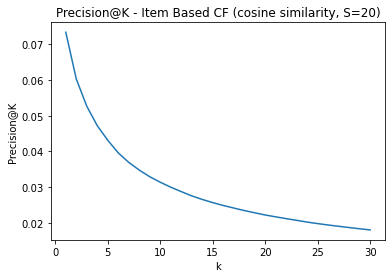

In [43]:
plt.plot(cosCF_results['cutoff'],cosCF_results['precision'] )
plt.title('Precision@K - Item Based CF (cosine similarity, S=20)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

### pearson similarity 
 
 Hyperparameter: S = 30
 
 

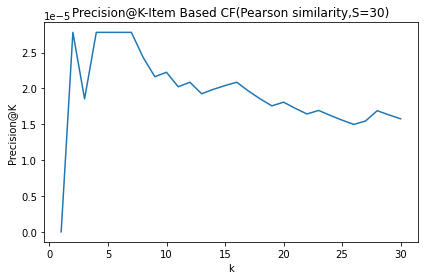

In [55]:
plt.plot(PearsonCF_results['cutoff'],PearsonCF_results['precision'] )
plt.title('Precision@K-Item Based CF(Pearson similarity,S=30)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.tight_layout()
plt.show()

### Jaccard similarity 
 
 Hyperparameter: S = 15

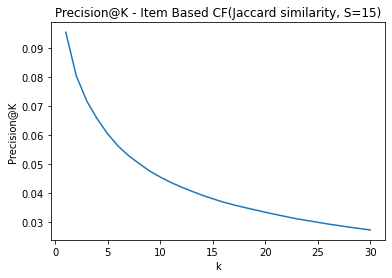

In [66]:
plt.plot(JaccardCF_results['cutoff'],JaccardCF_results['precision'] )
plt.title('Precision@K - Item Based CF(Jaccard similarity, S=15)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

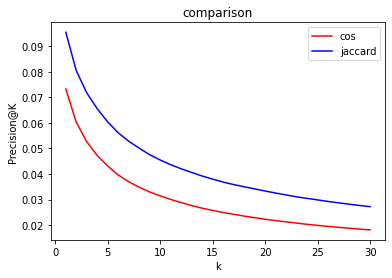

In [67]:
plt.plot(cosCF_results['cutoff'],cosCF_results['precision'],color = 'r',label = 'cos' )
plt.plot(JaccardCF_results['cutoff'],JaccardCF_results['precision'] ,color = 'b',label = 'jaccard')
plt.title('comparison')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.legend()
plt.show()

Among 3 models, the CF model with jaccard similarity is the best 

# Matrix Factoriztion

Tuning hyperparameters: number of feature, regParam, maxIter

### Matrix Factoriztion iALS

k = 2

regParam = 1e-4

MaxIter = 20


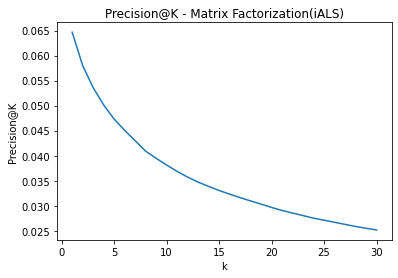

In [135]:
plt.plot(IALS_results['cutoff'],IALS_results['precision'] )
plt.title('Precision@K - Matrix Factorization(iALS)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
import time
import turicreate as tc
from sklearn.model_selection import train_test_split
from functools import reduce
import random

# Data Prep

In [2]:
file1 = "/Users/shengshiyuan/Desktop/1001/2019-Oct.csv"
file2 = "/Users/shengshiyuan/Desktop/1001/2019-Nov.csv"
file3 = "/Users/shengshiyuan/Desktop/1001/2019-Dec.csv"
file4 = "/Users/shengshiyuan/Desktop/1001/2020-Jan.csv"
file5 = "/Users/shengshiyuan/Desktop/1001/2020-Feb.csv"

In [3]:
def pre_process_df(filename):
    """
    This function removes the duplicated rows
                  removes product with prices <= 0 (might be coupons, gifts, or refunds)
                  removes products with missing brand information.
    @Input: filename (string): path to file
    @Output: df (Pandas DataFrame)
    """
    if filename:
        df = pd.read_csv(filename)
        df = df.drop_duplicates()
        #df = df[df.brand.notnull()]
        return df[df.price > 0]
    return None
  
def gen_purchase_count(files):
    """
    This function generates the train data (user-brand purchase history).
    @Output: df (Pandas DataFrmae). Each entry indicates the purchase count.
    """
    df = pd.concat([pre_process_df(f) for f in files])
    df = df.loc[:, ['event_type', 'product_id', 'user_id']]
    df['purchase_count'] = [1 if e == 'purchase' else 0 for e in df['event_type']]
    df = df.drop(['event_type'], axis = 1)
    df = df.groupby(['product_id', 'user_id']).sum()
    df = df[df.purchase_count != 0]
    return df.reset_index()

In [4]:
purchase_count = gen_purchase_count([file1, file2 , file3, file4, file5])

In [5]:
user_id  = np.unique(purchase_count['user_id'])
num_product_purchased = np.zeros(len(user_id))
for loc, user in enumerate(user_id):
    num_product_purchased[loc] = np.sum(purchase_count['user_id'] == user)

In [6]:
idx = np.where(num_product_purchased>=10)

In [7]:
filitered_user_id = user_id[idx]

In [10]:
len(filitered_user_id)

37284

In [12]:
len(np.unique(filtered_data['product_id']))

38053

In [8]:
filtered_data = purchase_count.loc[purchase_count['user_id'].isin(filitered_user_id)]

In [9]:
'''
train3 is training dataset
test is testing dataset
train4 is training dataset+validation dataset combined
validation is validation dataset
'''

sf = tc.SFrame(filtered_data)
train4, test = tc.recommender.util.random_split_by_user(sf, user_id = 'user_id', item_id = 'product_id',max_num_users=37284,item_test_proportion= 0.2)
train3, validation = tc.recommender.util.random_split_by_user(train4, user_id = 'user_id', item_id = 'product_id',max_num_users=37284,item_test_proportion=0.25)

# Popularity Model

In [16]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'product_id'
target = 'purchase_count'
# train model with train4
pop_model = tc.popularity_recommender.create(train4, user_id=user_id, item_id=item_id, target=target)

Preparing data set.

Data has 739349 observations with 37284 users and 36847 items.

Data prepared in: 0.598048s

739349 observations to process; with 36847 unique items.

In [17]:
results = pop_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/35941 queries. users per second: 4880.72

recommendations finished on 2000/35941 queries. users per second: 4872.2

recommendations finished on 3000/35941 queries. users per second: 4740.02

recommendations finished on 4000/35941 queries. users per second: 4636.11

recommendations finished on 5000/35941 queries. users per second: 4632.13

recommendations finished on 6000/35941 queries. users per second: 4633.82

recommendations finished on 7000/35941 queries. users per second: 4613.19

recommendations finished on 8000/35941 queries. users per second: 4654.91

recommendations finished on 9000/35941 queries. users per second: 4655.94

recommendations finished on 10000/35941 queries. users per second: 4679.06

recommendations finished on 11000/35941 queries. users per second: 4698.87

recommendations finished on 12000/35941 queries. users per second: 4662.69

recommendations finished on 13000/35941 queries. users per second: 4692.27

recommendations finished on 14000/35941 queries. users per second: 4646.4

recommendations finished on 15000/35941 queries. users per second: 4653.52

recommendations finished on 16000/35941 queries. users per second: 4667.84

recommendations finished on 17000/35941 queries. users per second: 4676.8

recommendations finished on 18000/35941 queries. users per second: 4696.61

recommendations finished on 19000/35941 queries. users per second: 4714.13

recommendations finished on 20000/35941 queries. users per second: 4745.81

recommendations finished on 21000/35941 queries. users per second: 4776.6

recommendations finished on 22000/35941 queries. users per second: 4802.89

recommendations finished on 23000/35941 queries. users per second: 4827.87

recommendations finished on 24000/35941 queries. users per second: 4849.8

recommendations finished on 25000/35941 queries. users per second: 4870.32

recommendations finished on 26000/35941 queries. users per second: 4890.33

recommendations finished on 27000/35941 queries. users per second: 4910.91

recommendations finished on 28000/35941 queries. users per second: 4928.73

recommendations finished on 29000/35941 queries. users per second: 4943.56

recommendations finished on 30000/35941 queries. users per second: 4956.6

recommendations finished on 31000/35941 queries. users per second: 4971.57

recommendations finished on 32000/35941 queries. users per second: 4981.99

recommendations finished on 33000/35941 queries. users per second: 4988.95

recommendations finished on 34000/35941 queries. users per second: 4995.67

recommendations finished on 35000/35941 queries. users per second: 5004.31

In [18]:
col_names =  ['cutoff', 'precision', 'recall'] 
popularity_results  = pd.DataFrame(columns = col_names)
popularity_results['cutoff'] = np.array(results['precision_recall_overall']['cutoff'])
popularity_results['precision'] = np.array(results['precision_recall_overall']['precision'])
popularity_results['recall'] = np.array(results['precision_recall_overall']['recall'])

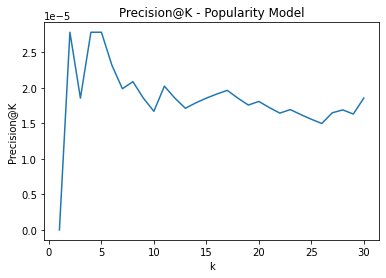

In [20]:
plt.plot(popularity_results['cutoff'],popularity_results['precision'] )
plt.title('Precision@K - Popularity Model')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

# Item Based CF - Cosine

In [22]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'product_id'
target = 'purchase_count'

In [23]:
# hyperparameter tuning for S
test_s_values = np.arange(1,100,10)
def test_s_vals(name):
    s_list = []
    train = []
    val = []
    for loc, s in enumerate(test_s_values):
        model = tc.item_similarity_recommender.create(train3,similarity_type=name,user_id=user_id, item_id=item_id,target = target,only_top_k=s)
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        s_list.append(s)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return s_list,train,val

In [24]:
# hyperparameter tuning for cosine similarity 
cosCF_s, cosCF_train, cosCF_val = test_s_vals('cosine')

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.520625s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.151ms                        | 2.5        |

| 28.326ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.98s                               | 0                | 1               |

| 12.13s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 13.2525s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5456.01

recommendations finished on 2000/37283 queries. users per second: 5115.15

recommendations finished on 3000/37283 queries. users per second: 5089.78

recommendations finished on 4000/37283 queries. users per second: 5001.73

recommendations finished on 5000/37283 queries. users per second: 5096.9

recommendations finished on 6000/37283 queries. users per second: 5121.53

recommendations finished on 7000/37283 queries. users per second: 5133.44

recommendations finished on 8000/37283 queries. users per second: 5145.41

recommendations finished on 9000/37283 queries. users per second: 5179.7

recommendations finished on 10000/37283 queries. users per second: 5194.65

recommendations finished on 11000/37283 queries. users per second: 5232.25

recommendations finished on 12000/37283 queries. users per second: 5223.08

recommendations finished on 13000/37283 queries. users per second: 5229.77

recommendations finished on 14000/37283 queries. users per second: 5250.39

recommendations finished on 15000/37283 queries. users per second: 5270.88

recommendations finished on 16000/37283 queries. users per second: 5276.21

recommendations finished on 17000/37283 queries. users per second: 5270.79

recommendations finished on 18000/37283 queries. users per second: 5267.9

recommendations finished on 19000/37283 queries. users per second: 5255.65

recommendations finished on 20000/37283 queries. users per second: 5239.32

recommendations finished on 21000/37283 queries. users per second: 5228.33

recommendations finished on 22000/37283 queries. users per second: 5204.76

recommendations finished on 23000/37283 queries. users per second: 5147.68

recommendations finished on 24000/37283 queries. users per second: 5120.07

recommendations finished on 25000/37283 queries. users per second: 5121.7

recommendations finished on 26000/37283 queries. users per second: 5079.5

recommendations finished on 27000/37283 queries. users per second: 5077.06

recommendations finished on 28000/37283 queries. users per second: 5075.78

recommendations finished on 29000/37283 queries. users per second: 5081.19

recommendations finished on 30000/37283 queries. users per second: 5089.3

recommendations finished on 31000/37283 queries. users per second: 5100.95

recommendations finished on 32000/37283 queries. users per second: 5090.11

recommendations finished on 33000/37283 queries. users per second: 5088.8

recommendations finished on 34000/37283 queries. users per second: 5117.02

recommendations finished on 35000/37283 queries. users per second: 5147.24

recommendations finished on 36000/37283 queries. users per second: 5175.64

recommendations finished on 37000/37283 queries. users per second: 5202.35


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.17683662795375907 | 0.013080421906799615 |
|   2    |  0.1717538824665397 | 0.02721134939276624  |
|   3    | 0.15014886141136718 | 0.036088042413474096 |
|   4    | 0.13533648043344157 | 0.04339938937965692  |
|   5    | 0.12339672236676258 | 0.049286411435152735 |
|   6    | 0.11403767579504513 |  0.0542919997691524  |
|   7    | 0.10591575631942537 | 0.05820489985091149  |
|   8    | 0.09870450339296735 | 0.06119551745089962  |
|   9    | 0.09223149067045737 | 0.06344151824747579  |
|   10   | 0.08655955797548483 | 0.06532008306306875  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.092864838208785

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.454767s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.787ms                        | 2.5        |

| 31.142ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.54s                               | 0                | 1               |

| 10.63s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 10.7103s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5007.46

recommendations finished on 2000/37283 queries. users per second: 4212.55

recommendations finished on 3000/37283 queries. users per second: 4570.37

recommendations finished on 4000/37283 queries. users per second: 4960.86

recommendations finished on 5000/37283 queries. users per second: 5063.29

recommendations finished on 6000/37283 queries. users per second: 5184.07

recommendations finished on 7000/37283 queries. users per second: 5280.62

recommendations finished on 8000/37283 queries. users per second: 5410.63

recommendations finished on 9000/37283 queries. users per second: 5513.77

recommendations finished on 10000/37283 queries. users per second: 5610.73

recommendations finished on 11000/37283 queries. users per second: 5673.33

recommendations finished on 12000/37283 queries. users per second: 5536.78

recommendations finished on 13000/37283 queries. users per second: 5597.62

recommendations finished on 14000/37283 queries. users per second: 5655.94

recommendations finished on 15000/37283 queries. users per second: 5710.37

recommendations finished on 16000/37283 queries. users per second: 5759.65

recommendations finished on 17000/37283 queries. users per second: 5808.14

recommendations finished on 18000/37283 queries. users per second: 5841.65

recommendations finished on 19000/37283 queries. users per second: 5860.16

recommendations finished on 20000/37283 queries. users per second: 5887.05

recommendations finished on 21000/37283 queries. users per second: 5909.09

recommendations finished on 22000/37283 queries. users per second: 5927.82

recommendations finished on 23000/37283 queries. users per second: 5954.06

recommendations finished on 24000/37283 queries. users per second: 5959.6

recommendations finished on 25000/37283 queries. users per second: 5980.02

recommendations finished on 26000/37283 queries. users per second: 5997.51

recommendations finished on 27000/37283 queries. users per second: 6018.63

recommendations finished on 28000/37283 queries. users per second: 6034.5

recommendations finished on 29000/37283 queries. users per second: 6050.21

recommendations finished on 30000/37283 queries. users per second: 6069.77

recommendations finished on 31000/37283 queries. users per second: 6080.74

recommendations finished on 32000/37283 queries. users per second: 6089.74

recommendations finished on 33000/37283 queries. users per second: 6098.2

recommendations finished on 34000/37283 queries. users per second: 6114.39

recommendations finished on 35000/37283 queries. users per second: 6129.97

recommendations finished on 36000/37283 queries. users per second: 6142.64

recommendations finished on 37000/37283 queries. users per second: 6151.99


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.2558538744199756 | 0.018237007670666525 |
|   2    | 0.23568382372663144 | 0.033571302448849955 |
|   3    |  0.2226752139044601 | 0.047652167407832444 |
|   4    | 0.21063219161548133 | 0.06021601481425513  |
|   5    |  0.1993616393530553 |  0.0708590667965785  |
|   6    | 0.18904952212357695 | 0.08027040963302953  |
|   7    | 0.17965675662213035 | 0.08849240294025729  |
|   8    | 0.17078494219885712 | 0.09547497855664822  |
|   9    |  0.162749182677838  |  0.1018836428952463  |
|   10   |  0.1555588337848353 |  0.1077158729052236  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0807123450341534

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.522427s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.774ms                        | 2.5        |

| 29.082ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.18s                               | 0.25             | 89              |

| 11.97s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 12.046s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5639.24

recommendations finished on 2000/37283 queries. users per second: 5833.45

recommendations finished on 3000/37283 queries. users per second: 5891.51

recommendations finished on 4000/37283 queries. users per second: 5829.17

recommendations finished on 5000/37283 queries. users per second: 5891.13

recommendations finished on 6000/37283 queries. users per second: 5932.03

recommendations finished on 7000/37283 queries. users per second: 5987.08

recommendations finished on 8000/37283 queries. users per second: 5998.62

recommendations finished on 9000/37283 queries. users per second: 5925.38

recommendations finished on 10000/37283 queries. users per second: 5868.17

recommendations finished on 11000/37283 queries. users per second: 5861.51

recommendations finished on 12000/37283 queries. users per second: 5860.63

recommendations finished on 13000/37283 queries. users per second: 5879

recommendations finished on 14000/37283 queries. users per second: 5896.61

recommendations finished on 15000/37283 queries. users per second: 5904.41

recommendations finished on 16000/37283 queries. users per second: 5913.3

recommendations finished on 17000/37283 queries. users per second: 5888.93

recommendations finished on 18000/37283 queries. users per second: 5892.31

recommendations finished on 19000/37283 queries. users per second: 5850.72

recommendations finished on 20000/37283 queries. users per second: 5817.12

recommendations finished on 21000/37283 queries. users per second: 5777.5

recommendations finished on 22000/37283 queries. users per second: 5757.33

recommendations finished on 23000/37283 queries. users per second: 5727.02

recommendations finished on 24000/37283 queries. users per second: 5740.54

recommendations finished on 25000/37283 queries. users per second: 5744.32

recommendations finished on 26000/37283 queries. users per second: 5753.78

recommendations finished on 27000/37283 queries. users per second: 5761.67

recommendations finished on 28000/37283 queries. users per second: 5732.35

recommendations finished on 29000/37283 queries. users per second: 5708.52

recommendations finished on 30000/37283 queries. users per second: 5669.81

recommendations finished on 31000/37283 queries. users per second: 5651.53

recommendations finished on 32000/37283 queries. users per second: 5613.78

recommendations finished on 33000/37283 queries. users per second: 5596.4

recommendations finished on 34000/37283 queries. users per second: 5564.51

recommendations finished on 35000/37283 queries. users per second: 5562.79

recommendations finished on 36000/37283 queries. users per second: 5575.25

recommendations finished on 37000/37283 queries. users per second: 5580.48


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.2998417509320599 | 0.021431870828258585 |
|   2    | 0.27508515945605394 | 0.039319342966167764 |
|   3    |  0.2595195307959842 | 0.05548945673537073  |
|   4    | 0.24641257409543224 | 0.07013614213344738  |
|   5    |  0.2340852399216789 | 0.08280967069158734  |
|   6    | 0.22223712326440123 | 0.09365422065508971  |
|   7    | 0.21187366130101454 | 0.10341864047798671  |
|   8    | 0.20160998310221864 | 0.11167031262095614  |
|   9    | 0.19248570245003008 | 0.11909272187832384  |
|   10   | 0.18414827133009706 |  0.1258501865375981  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0754924917968645

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.475169s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.277ms                        | 2.5        |

| 35.038ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.43s                               | 0                | 0               |

| 12.37s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 12.4452s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5418.41

recommendations finished on 2000/37283 queries. users per second: 5652.42

recommendations finished on 3000/37283 queries. users per second: 5749.98

recommendations finished on 4000/37283 queries. users per second: 5791.28

recommendations finished on 5000/37283 queries. users per second: 5832.82

recommendations finished on 6000/37283 queries. users per second: 5729.97

recommendations finished on 7000/37283 queries. users per second: 5578.81

recommendations finished on 8000/37283 queries. users per second: 5583.68

recommendations finished on 9000/37283 queries. users per second: 5437.86

recommendations finished on 10000/37283 queries. users per second: 5382.28

recommendations finished on 11000/37283 queries. users per second: 5333.56

recommendations finished on 12000/37283 queries. users per second: 5305.66

recommendations finished on 13000/37283 queries. users per second: 5292.75

recommendations finished on 14000/37283 queries. users per second: 5315.67

recommendations finished on 15000/37283 queries. users per second: 5301.49

recommendations finished on 16000/37283 queries. users per second: 5326.9

recommendations finished on 17000/37283 queries. users per second: 5316.82

recommendations finished on 18000/37283 queries. users per second: 5312.14

recommendations finished on 19000/37283 queries. users per second: 5305.71

recommendations finished on 20000/37283 queries. users per second: 5293.49

recommendations finished on 21000/37283 queries. users per second: 5280.36

recommendations finished on 22000/37283 queries. users per second: 5291.11

recommendations finished on 23000/37283 queries. users per second: 5279.15

recommendations finished on 24000/37283 queries. users per second: 5276.54

recommendations finished on 25000/37283 queries. users per second: 5297.08

recommendations finished on 26000/37283 queries. users per second: 5293.27

recommendations finished on 27000/37283 queries. users per second: 5294.01

recommendations finished on 28000/37283 queries. users per second: 5312.65

recommendations finished on 29000/37283 queries. users per second: 5263.32

recommendations finished on 30000/37283 queries. users per second: 5216.15

recommendations finished on 31000/37283 queries. users per second: 5190.55

recommendations finished on 32000/37283 queries. users per second: 5144.87

recommendations finished on 33000/37283 queries. users per second: 5133.66

recommendations finished on 34000/37283 queries. users per second: 5148.06

recommendations finished on 35000/37283 queries. users per second: 5169.36

recommendations finished on 36000/37283 queries. users per second: 5179.53

recommendations finished on 37000/37283 queries. users per second: 5187.65


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.32883619880374404 | 0.02366338718536988 |
|   2    | 0.30413325107958106 | 0.04362665270866733 |
|   3    | 0.28618941608776227 | 0.06136285327792153 |
|   4    | 0.27192017809725527 | 0.07742507411445204 |
|   5    |  0.258616527639944  | 0.09129429979238421 |
|   6    | 0.24630528659174433 |  0.103572832332865  |
|   7    | 0.23497879155953835 | 0.11434708387313357 |
|   8    | 0.22413030067322923 | 0.12367922564024436 |
|   9    | 0.21448858133137727 | 0.13221532110678583 |
|   10   | 0.20549848456401004 | 0.13976663005035117 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0720354288642784

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+-----------+-----

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.485086s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.122ms                        | 2.5        |

| 35.033ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.86s                               | 0.25             | 89              |

| 21.98s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 22.1104s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3251.86

recommendations finished on 2000/37283 queries. users per second: 3406.99

recommendations finished on 3000/37283 queries. users per second: 3051.39

recommendations finished on 4000/37283 queries. users per second: 3038.43

recommendations finished on 5000/37283 queries. users per second: 3009.5

recommendations finished on 6000/37283 queries. users per second: 3011.55

recommendations finished on 7000/37283 queries. users per second: 3028.26

recommendations finished on 8000/37283 queries. users per second: 3070

recommendations finished on 9000/37283 queries. users per second: 3128.47

recommendations finished on 10000/37283 queries. users per second: 3184.86

recommendations finished on 11000/37283 queries. users per second: 3224.6

recommendations finished on 12000/37283 queries. users per second: 3262.3

recommendations finished on 13000/37283 queries. users per second: 3302.19

recommendations finished on 14000/37283 queries. users per second: 3333.41

recommendations finished on 15000/37283 queries. users per second: 3365.48

recommendations finished on 16000/37283 queries. users per second: 3382.45

recommendations finished on 17000/37283 queries. users per second: 3396.76

recommendations finished on 18000/37283 queries. users per second: 3412.88

recommendations finished on 19000/37283 queries. users per second: 3399.51

recommendations finished on 20000/37283 queries. users per second: 3405.22

recommendations finished on 21000/37283 queries. users per second: 3425.75

recommendations finished on 22000/37283 queries. users per second: 3415.97

recommendations finished on 23000/37283 queries. users per second: 3413.34

recommendations finished on 24000/37283 queries. users per second: 3422.2

recommendations finished on 25000/37283 queries. users per second: 3433.1

recommendations finished on 26000/37283 queries. users per second: 3434.66

recommendations finished on 27000/37283 queries. users per second: 3446.05

recommendations finished on 28000/37283 queries. users per second: 3457.14

recommendations finished on 29000/37283 queries. users per second: 3468.59

recommendations finished on 30000/37283 queries. users per second: 3476.16

recommendations finished on 31000/37283 queries. users per second: 3479.01

recommendations finished on 32000/37283 queries. users per second: 3488.51

recommendations finished on 33000/37283 queries. users per second: 3496.79

recommendations finished on 34000/37283 queries. users per second: 3503.02

recommendations finished on 35000/37283 queries. users per second: 3505.08

recommendations finished on 36000/37283 queries. users per second: 3511.98

recommendations finished on 37000/37283 queries. users per second: 3519.17


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.34940857763592015 | 0.02523071340022381  |
|   2    |  0.3251213689885469 | 0.046738409728686606 |
|   3    | 0.30625217927741816 | 0.06568603107566895  |
|   4    |  0.2918555373762836 |  0.0831271199030527  |
|   5    |  0.2776922457956701 | 0.09803893946042445  |
|   6    | 0.26554998256578066 | 0.11161534557428386  |
|   7    |  0.2538498971189473 | 0.12350304767676683  |
|   8    | 0.24240605637958323 | 0.13359675485884548  |
|   9    | 0.23206585068559749 | 0.14269676632314107  |
|   10   | 0.22249282514819102 |  0.1508506560282206  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0694454242574265

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.81967s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.247ms                        | 2.5        |

| 41.622ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.94s                               | 0                | 0               |

| 25.45s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 25.5986s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3442.85

recommendations finished on 2000/37283 queries. users per second: 3854.95

recommendations finished on 3000/37283 queries. users per second: 3794.57

recommendations finished on 4000/37283 queries. users per second: 3914.55

recommendations finished on 5000/37283 queries. users per second: 4024.95

recommendations finished on 6000/37283 queries. users per second: 4048.92

recommendations finished on 7000/37283 queries. users per second: 4055.23

recommendations finished on 8000/37283 queries. users per second: 4128.09

recommendations finished on 9000/37283 queries. users per second: 4176.18

recommendations finished on 10000/37283 queries. users per second: 4142.58

recommendations finished on 11000/37283 queries. users per second: 4094.63

recommendations finished on 12000/37283 queries. users per second: 4136.49

recommendations finished on 13000/37283 queries. users per second: 4186.74

recommendations finished on 14000/37283 queries. users per second: 4245.12

recommendations finished on 15000/37283 queries. users per second: 4239.02

recommendations finished on 16000/37283 queries. users per second: 4274.11

recommendations finished on 17000/37283 queries. users per second: 4329.74

recommendations finished on 18000/37283 queries. users per second: 4386.24

recommendations finished on 19000/37283 queries. users per second: 4391.99

recommendations finished on 20000/37283 queries. users per second: 4404.28

recommendations finished on 21000/37283 queries. users per second: 4432.65

recommendations finished on 22000/37283 queries. users per second: 4465.82

recommendations finished on 23000/37283 queries. users per second: 4498.68

recommendations finished on 24000/37283 queries. users per second: 4536.67

recommendations finished on 25000/37283 queries. users per second: 4569.18

recommendations finished on 26000/37283 queries. users per second: 4571.61

recommendations finished on 27000/37283 queries. users per second: 4603.75

recommendations finished on 28000/37283 queries. users per second: 4614.87

recommendations finished on 29000/37283 queries. users per second: 4632.01

recommendations finished on 30000/37283 queries. users per second: 4658

recommendations finished on 31000/37283 queries. users per second: 4680.5

recommendations finished on 32000/37283 queries. users per second: 4680.36

recommendations finished on 33000/37283 queries. users per second: 4696.78

recommendations finished on 34000/37283 queries. users per second: 4713.55

recommendations finished on 35000/37283 queries. users per second: 4733.5

recommendations finished on 36000/37283 queries. users per second: 4752.76

recommendations finished on 37000/37283 queries. users per second: 4734.88


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3652603063058227 | 0.02647712981062955 |
|   2    |  0.3418582195638764 | 0.04929268012597167 |
|   3    |  0.3232840704878901 | 0.06947218468387328 |
|   4    |  0.3083375801303549 | 0.08791412157310981 |
|   5    |  0.2938390151007173 | 0.10385241733515622 |
|   6    | 0.28044953464045447 | 0.11789191501637893 |
|   7    | 0.26833754181338687 | 0.13048484845719419 |
|   8    |  0.2567859346082648 |  0.1413693770035993 |
|   9    |  0.2460221667903449 | 0.15106771120741788 |
|   10   | 0.23614784218008336 |  0.1598615107066347 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0674241123330475

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+-----------+-----

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.520275s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.651ms                        | 2.5        |

| 41.741ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.20s                               | 0                | 3               |

| 26.39s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 26.5356s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3987.67

recommendations finished on 2000/37283 queries. users per second: 3706.35

recommendations finished on 3000/37283 queries. users per second: 3921.72

recommendations finished on 4000/37283 queries. users per second: 3360.34

recommendations finished on 5000/37283 queries. users per second: 3263.27

recommendations finished on 6000/37283 queries. users per second: 3386.3

recommendations finished on 7000/37283 queries. users per second: 3546.48

recommendations finished on 8000/37283 queries. users per second: 3671.35

recommendations finished on 9000/37283 queries. users per second: 3776.73

recommendations finished on 10000/37283 queries. users per second: 3780.67

recommendations finished on 11000/37283 queries. users per second: 3683.33

recommendations finished on 12000/37283 queries. users per second: 3596.01

recommendations finished on 13000/37283 queries. users per second: 3631.41

recommendations finished on 14000/37283 queries. users per second: 3672.67

recommendations finished on 15000/37283 queries. users per second: 3688.63

recommendations finished on 16000/37283 queries. users per second: 3753.07

recommendations finished on 17000/37283 queries. users per second: 3828.66

recommendations finished on 18000/37283 queries. users per second: 3898.82

recommendations finished on 19000/37283 queries. users per second: 3960.77

recommendations finished on 20000/37283 queries. users per second: 4023.98

recommendations finished on 21000/37283 queries. users per second: 4078.88

recommendations finished on 22000/37283 queries. users per second: 4125.72

recommendations finished on 23000/37283 queries. users per second: 4164.93

recommendations finished on 24000/37283 queries. users per second: 4195.78

recommendations finished on 25000/37283 queries. users per second: 4236.93

recommendations finished on 26000/37283 queries. users per second: 4278.65

recommendations finished on 27000/37283 queries. users per second: 4317.18

recommendations finished on 28000/37283 queries. users per second: 4354.99

recommendations finished on 29000/37283 queries. users per second: 4389

recommendations finished on 30000/37283 queries. users per second: 4421.9

recommendations finished on 31000/37283 queries. users per second: 4445.11

recommendations finished on 32000/37283 queries. users per second: 4475.28

recommendations finished on 33000/37283 queries. users per second: 4505.74

recommendations finished on 34000/37283 queries. users per second: 4532.07

recommendations finished on 35000/37283 queries. users per second: 4556.18

recommendations finished on 36000/37283 queries. users per second: 4580.28

recommendations finished on 37000/37283 queries. users per second: 4602.61


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3800123380629243 | 0.02764399176639092 |
|   2    | 0.35549714347021355 | 0.05140603935965169 |
|   3    | 0.33652513656805183 | 0.07248511101847308 |
|   4    |  0.3213998337043697 | 0.09169772762727588 |
|   5    | 0.30664377866588044 |  0.1083766989879392 |
|   6    |  0.2930289944478713 |  0.1231215604204759 |
|   7    |  0.2807100900065515 | 0.13644344999550134 |
|   8    | 0.26907035378054367 |  0.1480892376987989 |
|   9    | 0.25789829740692094 |  0.1582672561965686 |
|   10   | 0.24767856663895152 |  0.1675288766160513 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0657063116705026

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+-----------+-----

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.514395s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.16ms                         | 2.5        |

| 39.627ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.83s                               | 0                | 0               |

| 12.40s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 12.5581s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 4930.63

recommendations finished on 2000/37283 queries. users per second: 5135.08

recommendations finished on 3000/37283 queries. users per second: 5074

recommendations finished on 4000/37283 queries. users per second: 5039.59

recommendations finished on 5000/37283 queries. users per second: 5152.24

recommendations finished on 6000/37283 queries. users per second: 5205.46

recommendations finished on 7000/37283 queries. users per second: 5262.46

recommendations finished on 8000/37283 queries. users per second: 5308.08

recommendations finished on 9000/37283 queries. users per second: 5291.22

recommendations finished on 10000/37283 queries. users per second: 5296.55

recommendations finished on 11000/37283 queries. users per second: 5256.16

recommendations finished on 12000/37283 queries. users per second: 5268.5

recommendations finished on 13000/37283 queries. users per second: 5296.34

recommendations finished on 14000/37283 queries. users per second: 5322.28

recommendations finished on 15000/37283 queries. users per second: 5313.75

recommendations finished on 16000/37283 queries. users per second: 5335.59

recommendations finished on 17000/37283 queries. users per second: 5344.13

recommendations finished on 18000/37283 queries. users per second: 5337.91

recommendations finished on 19000/37283 queries. users per second: 5316.88

recommendations finished on 20000/37283 queries. users per second: 5283.01

recommendations finished on 21000/37283 queries. users per second: 5257.93

recommendations finished on 22000/37283 queries. users per second: 5247.29

recommendations finished on 23000/37283 queries. users per second: 5257.61

recommendations finished on 24000/37283 queries. users per second: 5274.31

recommendations finished on 25000/37283 queries. users per second: 5289.59

recommendations finished on 26000/37283 queries. users per second: 5306.28

recommendations finished on 27000/37283 queries. users per second: 5318.89

recommendations finished on 28000/37283 queries. users per second: 5332.33

recommendations finished on 29000/37283 queries. users per second: 5346.69

recommendations finished on 30000/37283 queries. users per second: 5361.09

recommendations finished on 31000/37283 queries. users per second: 5334.99

recommendations finished on 32000/37283 queries. users per second: 5346.01

recommendations finished on 33000/37283 queries. users per second: 5328.62

recommendations finished on 34000/37283 queries. users per second: 5336.32

recommendations finished on 35000/37283 queries. users per second: 5334.09

recommendations finished on 36000/37283 queries. users per second: 5331.78

recommendations finished on 37000/37283 queries. users per second: 5337.45


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.39275272912587483 | 0.028615760641537563 |
|   2    |  0.3680363704637499 | 0.05333869487780441  |
|   3    | 0.34914929950200707 |  0.0753685210401133  |
|   4    |  0.3336842528766461 | 0.09541628605107856  |
|   5    | 0.31864388595338256 | 0.11283506277460145  |
|   6    |  0.3046830995359797 | 0.12820659507105034  |
|   7    | 0.29208639709404116 | 0.14206232164422128  |
|   8    | 0.27995668267038565 | 0.15414060883747524  |
|   9    |  0.2685048592298544 |  0.164751808628491   |
|   10   |  0.2580237641820673 | 0.17450067487150198  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0642875776089697

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.6684s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.389ms                        | 2.5        |

| 34.658ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.40s                               | 0                | 0               |

| 12.96s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 13.1025s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3893.08

recommendations finished on 2000/37283 queries. users per second: 4243.61

recommendations finished on 3000/37283 queries. users per second: 4361.28

recommendations finished on 4000/37283 queries. users per second: 4263.22

recommendations finished on 5000/37283 queries. users per second: 4144.22

recommendations finished on 6000/37283 queries. users per second: 4117.74

recommendations finished on 7000/37283 queries. users per second: 3717.87

recommendations finished on 8000/37283 queries. users per second: 3644.29

recommendations finished on 9000/37283 queries. users per second: 3630.26

recommendations finished on 10000/37283 queries. users per second: 3594.44

recommendations finished on 11000/37283 queries. users per second: 3555.73

recommendations finished on 12000/37283 queries. users per second: 3509.35

recommendations finished on 13000/37283 queries. users per second: 3497.98

recommendations finished on 14000/37283 queries. users per second: 3570.82

recommendations finished on 15000/37283 queries. users per second: 3661.11

recommendations finished on 16000/37283 queries. users per second: 3726.76

recommendations finished on 17000/37283 queries. users per second: 3775.69

recommendations finished on 18000/37283 queries. users per second: 3849.52

recommendations finished on 19000/37283 queries. users per second: 3914.49

recommendations finished on 20000/37283 queries. users per second: 3969.14

recommendations finished on 21000/37283 queries. users per second: 4022.74

recommendations finished on 22000/37283 queries. users per second: 4023.44

recommendations finished on 23000/37283 queries. users per second: 4022.57

recommendations finished on 24000/37283 queries. users per second: 4037.73

recommendations finished on 25000/37283 queries. users per second: 4054.61

recommendations finished on 26000/37283 queries. users per second: 4069.09

recommendations finished on 27000/37283 queries. users per second: 4085.45

recommendations finished on 28000/37283 queries. users per second: 4103.75

recommendations finished on 29000/37283 queries. users per second: 4112.96

recommendations finished on 30000/37283 queries. users per second: 4037.01

recommendations finished on 31000/37283 queries. users per second: 4019.83

recommendations finished on 32000/37283 queries. users per second: 4014.49

recommendations finished on 33000/37283 queries. users per second: 4000.4

recommendations finished on 34000/37283 queries. users per second: 4013.33

recommendations finished on 35000/37283 queries. users per second: 4033.56

recommendations finished on 36000/37283 queries. users per second: 4065.67

recommendations finished on 37000/37283 queries. users per second: 4096.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.40299868572807984 | 0.02945869510916593 |
|   2    |  0.377584958291983  | 0.05483519349773177 |
|   3    | 0.35929690922583307 | 0.07765439698725973 |
|   4    | 0.34374916181637727 | 0.09837846889307268 |
|   5    |  0.3285250650430509 | 0.11644365330176197 |
|   6    |  0.3145311983120093 | 0.13247488884627864 |
|   7    |  0.3013820929492955 |  0.146608316651119  |
|   8    | 0.28905600407692533 | 0.15920455321048924 |
|   9    |  0.2776630397530021 |  0.1703469283968683 |
|   10   | 0.26683206823485367 |  0.1803544308876338 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0630701257626445

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+-----------+-----

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.491007s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.641ms                        | 2.5        |

| 29.795ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.58s                               | 0.25             | 89              |

| 13.06s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 13.1948s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5666.27

recommendations finished on 2000/37283 queries. users per second: 5704.31

recommendations finished on 3000/37283 queries. users per second: 5602.02

recommendations finished on 4000/37283 queries. users per second: 5585.07

recommendations finished on 5000/37283 queries. users per second: 5603.74

recommendations finished on 6000/37283 queries. users per second: 5551.8

recommendations finished on 7000/37283 queries. users per second: 5576.31

recommendations finished on 8000/37283 queries. users per second: 5587.2

recommendations finished on 9000/37283 queries. users per second: 5569.61

recommendations finished on 10000/37283 queries. users per second: 5585.95

recommendations finished on 11000/37283 queries. users per second: 5579.07

recommendations finished on 12000/37283 queries. users per second: 5575.96

recommendations finished on 13000/37283 queries. users per second: 5587.72

recommendations finished on 14000/37283 queries. users per second: 5575.61

recommendations finished on 15000/37283 queries. users per second: 5587.28

recommendations finished on 16000/37283 queries. users per second: 5599.42

recommendations finished on 17000/37283 queries. users per second: 5589.55

recommendations finished on 18000/37283 queries. users per second: 5594.83

recommendations finished on 19000/37283 queries. users per second: 5594.74

recommendations finished on 20000/37283 queries. users per second: 5588.23

recommendations finished on 21000/37283 queries. users per second: 5595.37

recommendations finished on 22000/37283 queries. users per second: 5579.64

recommendations finished on 23000/37283 queries. users per second: 5569.86

recommendations finished on 24000/37283 queries. users per second: 5572.68

recommendations finished on 25000/37283 queries. users per second: 5576.16

recommendations finished on 26000/37283 queries. users per second: 5567.67

recommendations finished on 27000/37283 queries. users per second: 5572.92

recommendations finished on 28000/37283 queries. users per second: 5577.37

recommendations finished on 29000/37283 queries. users per second: 5573.48

recommendations finished on 30000/37283 queries. users per second: 5574.91

recommendations finished on 31000/37283 queries. users per second: 5580.61

recommendations finished on 32000/37283 queries. users per second: 5575.2

recommendations finished on 33000/37283 queries. users per second: 5572.21

recommendations finished on 34000/37283 queries. users per second: 5578.68

recommendations finished on 35000/37283 queries. users per second: 5565.79

recommendations finished on 36000/37283 queries. users per second: 5561.08

recommendations finished on 37000/37283 queries. users per second: 5556.12


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4122790547970929 | 0.030205283886196848 |
|   2    | 0.38783091489418736 | 0.056441692503872806 |
|   3    |  0.3689974876842895 | 0.07991266716717685  |
|   4    | 0.35260038087063833 | 0.10096938900729509  |
|   5    |  0.3376391384813456 | 0.11969591692065143  |
|   6    |  0.3233243033017727 |  0.1362007119088869  |
|   7    | 0.30994210306497383 |  0.1507714867290427  |
|   8    | 0.29736408014376464 |  0.1636950728241805  |
|   9    | 0.28587053378513394 |  0.1753211644215218  |
|   10   |  0.2749242282005211 | 0.18567885247981036  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0619881526315356

Per User RMSE (best)
+-----------+------------------+-------+
|  user_id  |       rmse       | count |
+---

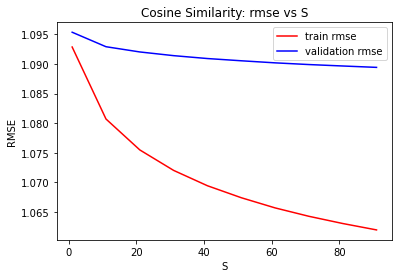

In [38]:
plt.plot(cosCF_s,cosCF_train, color= 'r' ,label='train rmse' )
plt.plot(cosCF_s,cosCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Cosine Similarity: rmse vs S')
plt.legend()
plt.show()


In [39]:
cosCF_model = tc.item_similarity_recommender.create(train4,similarity_type='cosine',user_id=user_id, item_id=item_id,target = target,only_top_k=20)

Preparing data set.

Data has 739349 observations with 37284 users and 36847 items.

Data prepared in: 0.610781s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.431ms                        | 2.5        |

| 30.337ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.88s                               | 0                | 0               |

| 15.78s                              | 100              | 36847           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 15.8775s

In [40]:
cosCF_evaluation = cosCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/35941 queries. users per second: 3136.3

recommendations finished on 2000/35941 queries. users per second: 3252.09

recommendations finished on 3000/35941 queries. users per second: 3432.25

recommendations finished on 4000/35941 queries. users per second: 3544.05

recommendations finished on 5000/35941 queries. users per second: 3664.71

recommendations finished on 6000/35941 queries. users per second: 3715.09

recommendations finished on 7000/35941 queries. users per second: 3800.28

recommendations finished on 8000/35941 queries. users per second: 3845.17

recommendations finished on 9000/35941 queries. users per second: 3873.03

recommendations finished on 10000/35941 queries. users per second: 3932.44

recommendations finished on 11000/35941 queries. users per second: 3972.95

recommendations finished on 12000/35941 queries. users per second: 3978.28

recommendations finished on 13000/35941 queries. users per second: 3995.33

recommendations finished on 14000/35941 queries. users per second: 4018.06

recommendations finished on 15000/35941 queries. users per second: 4049.07

recommendations finished on 16000/35941 queries. users per second: 4045.42

recommendations finished on 17000/35941 queries. users per second: 4055.11

recommendations finished on 18000/35941 queries. users per second: 4079.75

recommendations finished on 19000/35941 queries. users per second: 4108.91

recommendations finished on 20000/35941 queries. users per second: 4118.67

recommendations finished on 21000/35941 queries. users per second: 4167.2

recommendations finished on 22000/35941 queries. users per second: 4179.7

recommendations finished on 23000/35941 queries. users per second: 4183.54

recommendations finished on 24000/35941 queries. users per second: 4185.88

recommendations finished on 25000/35941 queries. users per second: 4165.78

recommendations finished on 26000/35941 queries. users per second: 4130.67

recommendations finished on 27000/35941 queries. users per second: 4103.73

recommendations finished on 28000/35941 queries. users per second: 4116.63

recommendations finished on 29000/35941 queries. users per second: 4126.8

recommendations finished on 30000/35941 queries. users per second: 4155.65

recommendations finished on 31000/35941 queries. users per second: 4174.14

recommendations finished on 32000/35941 queries. users per second: 4198.7

recommendations finished on 33000/35941 queries. users per second: 4225.24

recommendations finished on 34000/35941 queries. users per second: 4242.04

recommendations finished on 35000/35941 queries. users per second: 4259.87

In [41]:
col_names =  ['cutoff', 'precision', 'recall'] 
cosCF_results  = pd.DataFrame(columns = col_names)
cosCF_results['cutoff'] = np.array(cosCF_evaluation['precision_recall_overall']['cutoff'])
cosCF_results['precision'] = np.array(cosCF_evaluation['precision_recall_overall']['precision'])
cosCF_results['recall'] = np.array(cosCF_evaluation['precision_recall_overall']['recall'])

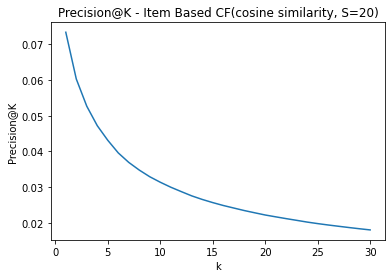

In [42]:
plt.plot(cosCF_results['cutoff'],cosCF_results['precision'] )
plt.title('Precision@K - Item Based CF(cosine similarity, S=20)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

# Item Based CF - Pearson

In [44]:
PearsonCF_s, PearsonCF_train, PearsonCF_val = test_s_vals('pearson')

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.52712s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.207ms                        | 2.5        |

| 42.088ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.09s                               | 0.25             | 89              |

| 8.09s                               | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.13323s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5352.92

recommendations finished on 2000/37283 queries. users per second: 5015.47

recommendations finished on 3000/37283 queries. users per second: 4929.8

recommendations finished on 4000/37283 queries. users per second: 4884.22

recommendations finished on 5000/37283 queries. users per second: 4832.48

recommendations finished on 6000/37283 queries. users per second: 4794.05

recommendations finished on 7000/37283 queries. users per second: 4754.06

recommendations finished on 8000/37283 queries. users per second: 4754.32

recommendations finished on 9000/37283 queries. users per second: 4740.32

recommendations finished on 10000/37283 queries. users per second: 4646.29

recommendations finished on 11000/37283 queries. users per second: 4546.06

recommendations finished on 12000/37283 queries. users per second: 4415.81

recommendations finished on 13000/37283 queries. users per second: 4223.08

recommendations finished on 14000/37283 queries. users per second: 4195.89

recommendations finished on 15000/37283 queries. users per second: 4227.35

recommendations finished on 16000/37283 queries. users per second: 4257.18

recommendations finished on 17000/37283 queries. users per second: 4283.92

recommendations finished on 18000/37283 queries. users per second: 4307.88

recommendations finished on 19000/37283 queries. users per second: 4330.88

recommendations finished on 20000/37283 queries. users per second: 4349.7

recommendations finished on 21000/37283 queries. users per second: 4360.27

recommendations finished on 22000/37283 queries. users per second: 4346.38

recommendations finished on 23000/37283 queries. users per second: 4344.12

recommendations finished on 24000/37283 queries. users per second: 4359.63

recommendations finished on 25000/37283 queries. users per second: 4364.88

recommendations finished on 26000/37283 queries. users per second: 4375.46

recommendations finished on 27000/37283 queries. users per second: 4378.02

recommendations finished on 28000/37283 queries. users per second: 4389.33

recommendations finished on 29000/37283 queries. users per second: 4399.58

recommendations finished on 30000/37283 queries. users per second: 4410.49

recommendations finished on 31000/37283 queries. users per second: 4419.5

recommendations finished on 32000/37283 queries. users per second: 4423.92

recommendations finished on 33000/37283 queries. users per second: 4415.42

recommendations finished on 34000/37283 queries. users per second: 4427.35

recommendations finished on 35000/37283 queries. users per second: 4448.51

recommendations finished on 36000/37283 queries. users per second: 4468.79

recommendations finished on 37000/37283 queries. users per second: 4485.87


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.6821875922001983e-05 | 4.789620700357493e-07  |
|   2    | 5.364375184400389e-05  | 2.644638464128976e-06  |
|   3    | 5.3643751844003824e-05 | 5.624846899906978e-06  |
|   4    | 4.023281388300294e-05  | 5.624846899906967e-06  |
|   5    | 3.7550626290802766e-05 | 5.846515295956581e-06  |
|   6    | 3.5762501229335815e-05 | 7.424272703133168e-06  |
|   7    | 3.4485269042574046e-05 | 1.0404481138911131e-05 |
|   8    | 3.017461041225225e-05  | 1.0404481138911155e-05 |
|   9    | 2.980208435777993e-05  | 1.0930400274636706e-05 |
|   10   | 3.218625110640232e-05  | 1.302585933104306e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.274453846231512

Per User RMSE (best)
+-----------+----

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.517087s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.946ms                        | 2.5        |

| 48.859ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.51s                               | 0                | 0               |

| 8.34s                               | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.38673s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 4812.27

recommendations finished on 2000/37283 queries. users per second: 4820.38

recommendations finished on 3000/37283 queries. users per second: 4793.26

recommendations finished on 4000/37283 queries. users per second: 4810.32

recommendations finished on 5000/37283 queries. users per second: 4803.72

recommendations finished on 6000/37283 queries. users per second: 4783.88

recommendations finished on 7000/37283 queries. users per second: 4797.91

recommendations finished on 8000/37283 queries. users per second: 4803.09

recommendations finished on 9000/37283 queries. users per second: 4800.43

recommendations finished on 10000/37283 queries. users per second: 4794.31

recommendations finished on 11000/37283 queries. users per second: 4795.34

recommendations finished on 12000/37283 queries. users per second: 4774.95

recommendations finished on 13000/37283 queries. users per second: 4776.17

recommendations finished on 14000/37283 queries. users per second: 4777.62

recommendations finished on 15000/37283 queries. users per second: 4777.43

recommendations finished on 16000/37283 queries. users per second: 4783.36

recommendations finished on 17000/37283 queries. users per second: 4784.32

recommendations finished on 18000/37283 queries. users per second: 4785.63

recommendations finished on 19000/37283 queries. users per second: 4786.22

recommendations finished on 20000/37283 queries. users per second: 4785.54

recommendations finished on 21000/37283 queries. users per second: 4788.55

recommendations finished on 22000/37283 queries. users per second: 4750.06

recommendations finished on 23000/37283 queries. users per second: 4675.9

recommendations finished on 24000/37283 queries. users per second: 4635.03

recommendations finished on 25000/37283 queries. users per second: 4596.48

recommendations finished on 26000/37283 queries. users per second: 4596.05

recommendations finished on 27000/37283 queries. users per second: 4604.98

recommendations finished on 28000/37283 queries. users per second: 4607.95

recommendations finished on 29000/37283 queries. users per second: 4613.18

recommendations finished on 30000/37283 queries. users per second: 4619.63

recommendations finished on 31000/37283 queries. users per second: 4627.38

recommendations finished on 32000/37283 queries. users per second: 4633.14

recommendations finished on 33000/37283 queries. users per second: 4631.68

recommendations finished on 34000/37283 queries. users per second: 4632.12

recommendations finished on 35000/37283 queries. users per second: 4633.05

recommendations finished on 36000/37283 queries. users per second: 4629.57

recommendations finished on 37000/37283 queries. users per second: 4629.81


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.6821875922001922e-05 | 4.789620700357505e-07  |
|   2    | 5.364375184400396e-05  | 2.6446384641289636e-06 |
|   3    | 4.4703126536669904e-05 | 5.326826056329169e-06  |
|   4    | 4.023281388300304e-05  | 5.6248468999069596e-06 |
|   5    | 3.755062629080278e-05  | 5.846515295956575e-06  |
|   6    | 4.917343919033705e-05  | 1.6024302760663942e-05 |
|   7    | 4.214866216314591e-05  | 1.6024302760663936e-05 |
|   8    | 4.358554837325328e-05  | 1.7319254594856022e-05 |
|   9    | 4.470312653666992e-05  | 1.8838576542507595e-05 |
|   10   | 4.559718906740336e-05  | 2.043737071511321e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2655354067793072

Per User RMSE (best)
+-----------+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.709128s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.756ms                        | 2.5        |

| 43.617ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.92s                               | 0                | 0               |

| 12.65s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 12.711s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 4144.72

recommendations finished on 2000/37283 queries. users per second: 4233.11

recommendations finished on 3000/37283 queries. users per second: 4278.43

recommendations finished on 4000/37283 queries. users per second: 4274.29

recommendations finished on 5000/37283 queries. users per second: 4266.06

recommendations finished on 6000/37283 queries. users per second: 4271.65

recommendations finished on 7000/37283 queries. users per second: 4279.18

recommendations finished on 8000/37283 queries. users per second: 4294.06

recommendations finished on 9000/37283 queries. users per second: 4302.17

recommendations finished on 10000/37283 queries. users per second: 4305.76

recommendations finished on 11000/37283 queries. users per second: 4313.26

recommendations finished on 12000/37283 queries. users per second: 4306.1

recommendations finished on 13000/37283 queries. users per second: 4309.98

recommendations finished on 14000/37283 queries. users per second: 4309.08

recommendations finished on 15000/37283 queries. users per second: 4293.59

recommendations finished on 16000/37283 queries. users per second: 4223.7

recommendations finished on 17000/37283 queries. users per second: 4168.05

recommendations finished on 18000/37283 queries. users per second: 4130.16

recommendations finished on 19000/37283 queries. users per second: 4082.53

recommendations finished on 20000/37283 queries. users per second: 4080.43

recommendations finished on 21000/37283 queries. users per second: 4086.9

recommendations finished on 22000/37283 queries. users per second: 4094

recommendations finished on 23000/37283 queries. users per second: 4094.41

recommendations finished on 24000/37283 queries. users per second: 4103.97

recommendations finished on 25000/37283 queries. users per second: 4112.01

recommendations finished on 26000/37283 queries. users per second: 4121.68

recommendations finished on 27000/37283 queries. users per second: 4131.36

recommendations finished on 28000/37283 queries. users per second: 4139.65

recommendations finished on 29000/37283 queries. users per second: 4145.77

recommendations finished on 30000/37283 queries. users per second: 4151.23

recommendations finished on 31000/37283 queries. users per second: 4158.51

recommendations finished on 32000/37283 queries. users per second: 4164.01

recommendations finished on 33000/37283 queries. users per second: 4165.25

recommendations finished on 34000/37283 queries. users per second: 4171.2

recommendations finished on 35000/37283 queries. users per second: 4176.59

recommendations finished on 36000/37283 queries. users per second: 4182.89

recommendations finished on 37000/37283 queries. users per second: 4186.96


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.6821875922001885e-05 | 4.789620700357494e-07  |
|   2    | 5.3643751844003865e-05 | 2.6446384641289708e-06 |
|   3    | 3.576250122933594e-05  | 2.6446384641289682e-06 |
|   4    | 3.352734490250245e-05  | 2.9426593077067678e-06 |
|   5    | 3.755062629080272e-05  | 5.846515295956559e-06  |
|   6    | 4.917343919033695e-05  | 1.4925507423523108e-05 |
|   7    |  4.5980358723432e-05   | 1.5431580554126967e-05 |
|   8    | 4.3585548373253175e-05 | 1.6389504694198453e-05 |
|   9    | 3.874270966511403e-05  | 1.6389504694198433e-05 |
|   10   | 3.7550626290802745e-05 | 1.6687525537776262e-05 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.26307935180129904

Per User RMSE (best)
+-----------+--

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.489843s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.338ms                        | 2.5        |

| 65.49ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.66s                               | 0                | 0               |

| 11.05s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 11.1368s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3959.41

recommendations finished on 2000/37283 queries. users per second: 3962.95

recommendations finished on 3000/37283 queries. users per second: 3941

recommendations finished on 4000/37283 queries. users per second: 3907.15

recommendations finished on 5000/37283 queries. users per second: 3908.13

recommendations finished on 6000/37283 queries. users per second: 3907

recommendations finished on 7000/37283 queries. users per second: 3913.38

recommendations finished on 8000/37283 queries. users per second: 3914.23

recommendations finished on 9000/37283 queries. users per second: 3915.69

recommendations finished on 10000/37283 queries. users per second: 3901.23

recommendations finished on 11000/37283 queries. users per second: 3903.63

recommendations finished on 12000/37283 queries. users per second: 3882.08

recommendations finished on 13000/37283 queries. users per second: 3878.71

recommendations finished on 14000/37283 queries. users per second: 3837.12

recommendations finished on 15000/37283 queries. users per second: 3837.03

recommendations finished on 16000/37283 queries. users per second: 3841.11

recommendations finished on 17000/37283 queries. users per second: 3845.91

recommendations finished on 18000/37283 queries. users per second: 3838.37

recommendations finished on 19000/37283 queries. users per second: 3791.07

recommendations finished on 20000/37283 queries. users per second: 3655.62

recommendations finished on 21000/37283 queries. users per second: 3456.64

recommendations finished on 22000/37283 queries. users per second: 3415.71

recommendations finished on 23000/37283 queries. users per second: 3428.74

recommendations finished on 24000/37283 queries. users per second: 3438.23

recommendations finished on 25000/37283 queries. users per second: 3442.13

recommendations finished on 26000/37283 queries. users per second: 3436.33

recommendations finished on 27000/37283 queries. users per second: 3439.06

recommendations finished on 28000/37283 queries. users per second: 3434.15

recommendations finished on 29000/37283 queries. users per second: 3429.16

recommendations finished on 30000/37283 queries. users per second: 3436.12

recommendations finished on 31000/37283 queries. users per second: 3443.02

recommendations finished on 32000/37283 queries. users per second: 3453.29

recommendations finished on 33000/37283 queries. users per second: 3455.64

recommendations finished on 34000/37283 queries. users per second: 3462.3

recommendations finished on 35000/37283 queries. users per second: 3468.5

recommendations finished on 36000/37283 queries. users per second: 3476.16

recommendations finished on 37000/37283 queries. users per second: 3481.44


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.6821875922001885e-05 | 4.789620700357503e-07  |
|   2    | 5.3643751844003966e-05 |  2.64463846412897e-06  |
|   3    | 5.3643751844003994e-05 | 5.624846899906968e-06  |
|   4    | 4.023281388300303e-05  | 5.624846899906973e-06  |
|   5    |  3.75506262908028e-05  | 5.8465152959565695e-06 |
|   6    | 5.364375184400391e-05  | 1.5344599234804383e-05 |
|   7    | 4.598035872343176e-05  | 1.5344599234804407e-05 |
|   8    | 4.358554837325323e-05  | 1.5870518370529998e-05 |
|   9    | 3.8742709665114064e-05 | 1.5870518370529907e-05 |
|   10   |  3.75506262908027e-05  | 1.8105674697363426e-05 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2620734435522076

Per User RMSE (best)
+-----------+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.495675s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.528ms                        | 2.5        |

| 59.172ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.44s                               | 0                | 0               |

| 14.62s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 14.6741s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3206.36

recommendations finished on 2000/37283 queries. users per second: 2900.74

recommendations finished on 3000/37283 queries. users per second: 2927.91

recommendations finished on 4000/37283 queries. users per second: 3050.03

recommendations finished on 5000/37283 queries. users per second: 2995.21

recommendations finished on 6000/37283 queries. users per second: 3085.38

recommendations finished on 7000/37283 queries. users per second: 3195.29

recommendations finished on 8000/37283 queries. users per second: 3239.4

recommendations finished on 9000/37283 queries. users per second: 3190.39

recommendations finished on 10000/37283 queries. users per second: 3227.61

recommendations finished on 11000/37283 queries. users per second: 3267.4

recommendations finished on 12000/37283 queries. users per second: 3220.48

recommendations finished on 13000/37283 queries. users per second: 3208.17

recommendations finished on 14000/37283 queries. users per second: 3172.74

recommendations finished on 15000/37283 queries. users per second: 3153.75

recommendations finished on 16000/37283 queries. users per second: 3111.87

recommendations finished on 17000/37283 queries. users per second: 3105.12

recommendations finished on 18000/37283 queries. users per second: 3115.93

recommendations finished on 19000/37283 queries. users per second: 3107.02

recommendations finished on 20000/37283 queries. users per second: 3110.98

recommendations finished on 21000/37283 queries. users per second: 3089.25

recommendations finished on 22000/37283 queries. users per second: 3096.06

recommendations finished on 23000/37283 queries. users per second: 3080.24

recommendations finished on 24000/37283 queries. users per second: 3066.25

recommendations finished on 25000/37283 queries. users per second: 3059.29

recommendations finished on 26000/37283 queries. users per second: 3049.74

recommendations finished on 27000/37283 queries. users per second: 3066.85

recommendations finished on 28000/37283 queries. users per second: 3059.63

recommendations finished on 29000/37283 queries. users per second: 3060.13

recommendations finished on 30000/37283 queries. users per second: 3041.44

recommendations finished on 31000/37283 queries. users per second: 3039.22

recommendations finished on 32000/37283 queries. users per second: 3040.94

recommendations finished on 33000/37283 queries. users per second: 3059.11

recommendations finished on 34000/37283 queries. users per second: 3028.42

recommendations finished on 35000/37283 queries. users per second: 3002.64

recommendations finished on 36000/37283 queries. users per second: 2990.43

recommendations finished on 37000/37283 queries. users per second: 2978.09


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.6821875922001963e-05 | 4.789620700357493e-07  |
|   2    | 5.364375184400393e-05  | 2.644638464128962e-06  |
|   3    | 4.470312653666993e-05  | 2.9426593077067737e-06 |
|   4    | 4.023281388300291e-05  | 3.1643277037563747e-06 |
|   5    | 3.7550626290802684e-05 | 5.846515295956569e-06  |
|   6    | 5.364375184400384e-05  | 1.5691846735580315e-05 |
|   7    | 5.747544840428985e-05  | 2.135875823088543e-05  |
|   8    | 5.029101735375378e-05  | 2.135875823088541e-05  |
|   9    | 4.7683334972448045e-05 | 2.2316682370956927e-05 |
|   10   | 4.5597189067403414e-05 | 2.3993049616082075e-05 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.26156359314754285

Per User RMSE (best)
+-----------+--

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.691163s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.15ms                         | 2.5        |

| 87.298ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.87s                               | 0.25             | 89              |

| 13.46s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 13.5194s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3998.59

recommendations finished on 2000/37283 queries. users per second: 3938.16

recommendations finished on 3000/37283 queries. users per second: 3947.93

recommendations finished on 4000/37283 queries. users per second: 3945.89

recommendations finished on 5000/37283 queries. users per second: 3964.7

recommendations finished on 6000/37283 queries. users per second: 3964.6

recommendations finished on 7000/37283 queries. users per second: 3976.96

recommendations finished on 8000/37283 queries. users per second: 3977.73

recommendations finished on 9000/37283 queries. users per second: 3976.99

recommendations finished on 10000/37283 queries. users per second: 3946.15

recommendations finished on 11000/37283 queries. users per second: 3942.86

recommendations finished on 12000/37283 queries. users per second: 3914.89

recommendations finished on 13000/37283 queries. users per second: 3921.86

recommendations finished on 14000/37283 queries. users per second: 3926.32

recommendations finished on 15000/37283 queries. users per second: 3931.17

recommendations finished on 16000/37283 queries. users per second: 3937.24

recommendations finished on 17000/37283 queries. users per second: 3944.09

recommendations finished on 18000/37283 queries. users per second: 3949.86

recommendations finished on 19000/37283 queries. users per second: 3949.14

recommendations finished on 20000/37283 queries. users per second: 3954.55

recommendations finished on 21000/37283 queries. users per second: 3958.76

recommendations finished on 22000/37283 queries. users per second: 3958.38

recommendations finished on 23000/37283 queries. users per second: 3959.89

recommendations finished on 24000/37283 queries. users per second: 3959.23

recommendations finished on 25000/37283 queries. users per second: 3913.69

recommendations finished on 26000/37283 queries. users per second: 3880.04

recommendations finished on 27000/37283 queries. users per second: 3853.76

recommendations finished on 28000/37283 queries. users per second: 3848.83

recommendations finished on 29000/37283 queries. users per second: 3855.17

recommendations finished on 30000/37283 queries. users per second: 3861.74

recommendations finished on 31000/37283 queries. users per second: 3864.88

recommendations finished on 32000/37283 queries. users per second: 3869.14

recommendations finished on 33000/37283 queries. users per second: 3872.4

recommendations finished on 34000/37283 queries. users per second: 3877.16

recommendations finished on 35000/37283 queries. users per second: 3878.55

recommendations finished on 36000/37283 queries. users per second: 3872.97

recommendations finished on 37000/37283 queries. users per second: 3875.38


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.6821875922001827e-05 | 4.789620700357499e-07  |
|   2    | 5.364375184400388e-05  | 2.6446384641289623e-06 |
|   3    | 3.576250122933587e-05  | 2.6446384641289682e-06 |
|   4    | 3.3527344902502405e-05 | 2.8663068601785748e-06 |
|   5    | 3.7550626290802705e-05 | 5.846515295956572e-06  |
|   6    | 5.364375184400401e-05  | 1.716066375035661e-05  |
|   7    | 5.3643751844003824e-05 | 1.926434029325872e-05  |
|   8    | 5.0291017353753644e-05 | 1.9790259428984248e-05 |
|   9    | 5.066354340822581e-05  |  2.14293740686622e-05  |
|   10   | 5.096156425180388e-05  | 2.4825650565279233e-05 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.26124766331083277

Per User RMSE (best)
+-----------+--

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.487903s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 7.755ms                        | 2.5        |

| 60.005ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.50s                               | 0                | 3               |

| 10.45s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 10.5184s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3895.45

recommendations finished on 2000/37283 queries. users per second: 3982.88

recommendations finished on 3000/37283 queries. users per second: 3993.47

recommendations finished on 4000/37283 queries. users per second: 4021.92

recommendations finished on 5000/37283 queries. users per second: 4034.35

recommendations finished on 6000/37283 queries. users per second: 4013.11

recommendations finished on 7000/37283 queries. users per second: 4003.48

recommendations finished on 8000/37283 queries. users per second: 4010.87

recommendations finished on 9000/37283 queries. users per second: 4018.7

recommendations finished on 10000/37283 queries. users per second: 4015.23

recommendations finished on 11000/37283 queries. users per second: 4001.56

recommendations finished on 12000/37283 queries. users per second: 3884.91

recommendations finished on 13000/37283 queries. users per second: 3826.25

recommendations finished on 14000/37283 queries. users per second: 3781.13

recommendations finished on 15000/37283 queries. users per second: 3742.5

recommendations finished on 16000/37283 queries. users per second: 3750.99

recommendations finished on 17000/37283 queries. users per second: 3761.68

recommendations finished on 18000/37283 queries. users per second: 3775.39

recommendations finished on 19000/37283 queries. users per second: 3789.5

recommendations finished on 20000/37283 queries. users per second: 3805.98

recommendations finished on 21000/37283 queries. users per second: 3818.77

recommendations finished on 22000/37283 queries. users per second: 3826.23

recommendations finished on 23000/37283 queries. users per second: 3833.78

recommendations finished on 24000/37283 queries. users per second: 3844.07

recommendations finished on 25000/37283 queries. users per second: 3853.96

recommendations finished on 26000/37283 queries. users per second: 3864.34

recommendations finished on 27000/37283 queries. users per second: 3874.12

recommendations finished on 28000/37283 queries. users per second: 3883.52

recommendations finished on 29000/37283 queries. users per second: 3891.63

recommendations finished on 30000/37283 queries. users per second: 3901.78

recommendations finished on 31000/37283 queries. users per second: 3910.8

recommendations finished on 32000/37283 queries. users per second: 3916.89

recommendations finished on 33000/37283 queries. users per second: 3922.08

recommendations finished on 34000/37283 queries. users per second: 3920.26

recommendations finished on 35000/37283 queries. users per second: 3925.2

recommendations finished on 36000/37283 queries. users per second: 3929.81

recommendations finished on 37000/37283 queries. users per second: 3933.07


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.6821875922001963e-05 | 4.789620700357492e-07  |
|   2    | 5.3643751844003865e-05 | 2.6446384641289686e-06 |
|   3    | 4.470312653666995e-05  | 5.326826056329169e-06  |
|   4    | 4.0232813883002975e-05 | 5.624846899906965e-06  |
|   5    |  3.75506262908028e-05  | 5.846515295956587e-06  |
|   6    | 5.3643751844003905e-05 | 1.5883431563594618e-05 |
|   7    | 4.598035872343198e-05  | 1.588343156359461e-05  |
|   8    |  4.35855483732532e-05  | 1.618145240717245e-05  |
|   9    | 3.874270966511394e-05  | 1.6181452407172386e-05 |
|   10   | 3.7550626290802786e-05 | 1.6707371542897937e-05 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2610488383031056

Per User RMSE (best)
+-----------+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.499793s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.053ms                        | 2.5        |

| 54.835ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.57s                               | 0                | 1               |

| 11.75s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 11.8199s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3924.72

recommendations finished on 2000/37283 queries. users per second: 4139.3

recommendations finished on 3000/37283 queries. users per second: 4211.32

recommendations finished on 4000/37283 queries. users per second: 4262.2

recommendations finished on 5000/37283 queries. users per second: 4294.64

recommendations finished on 6000/37283 queries. users per second: 4229.33

recommendations finished on 7000/37283 queries. users per second: 4234.39

recommendations finished on 8000/37283 queries. users per second: 4255.74

recommendations finished on 9000/37283 queries. users per second: 4272.64

recommendations finished on 10000/37283 queries. users per second: 4272.97

recommendations finished on 11000/37283 queries. users per second: 4269.31

recommendations finished on 12000/37283 queries. users per second: 4272.64

recommendations finished on 13000/37283 queries. users per second: 4281.33

recommendations finished on 14000/37283 queries. users per second: 4289.95

recommendations finished on 15000/37283 queries. users per second: 4301.42

recommendations finished on 16000/37283 queries. users per second: 4309.29

recommendations finished on 17000/37283 queries. users per second: 4311.44

recommendations finished on 18000/37283 queries. users per second: 4316.36

recommendations finished on 19000/37283 queries. users per second: 4308.73

recommendations finished on 20000/37283 queries. users per second: 4310.01

recommendations finished on 21000/37283 queries. users per second: 4312.82

recommendations finished on 22000/37283 queries. users per second: 4309.57

recommendations finished on 23000/37283 queries. users per second: 4295.45

recommendations finished on 24000/37283 queries. users per second: 4299.46

recommendations finished on 25000/37283 queries. users per second: 4304.89

recommendations finished on 26000/37283 queries. users per second: 4310.66

recommendations finished on 27000/37283 queries. users per second: 4310.2

recommendations finished on 28000/37283 queries. users per second: 4304.94

recommendations finished on 29000/37283 queries. users per second: 4292.21

recommendations finished on 30000/37283 queries. users per second: 4286.79

recommendations finished on 31000/37283 queries. users per second: 4283.42

recommendations finished on 32000/37283 queries. users per second: 4258.05

recommendations finished on 33000/37283 queries. users per second: 4199.77

recommendations finished on 34000/37283 queries. users per second: 4197.77

recommendations finished on 35000/37283 queries. users per second: 4198.16

recommendations finished on 36000/37283 queries. users per second: 4184.25

recommendations finished on 37000/37283 queries. users per second: 4180.45


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.682187592200196e-05  | 4.789620700357499e-07  |
|   2    | 5.364375184400392e-05  | 2.6446384641289686e-06 |
|   3    | 4.470312653666983e-05  | 2.8663068601785722e-06 |
|   4    | 4.023281388300297e-05  | 5.5484944523787755e-06 |
|   5    | 3.755062629080275e-05  | 5.8465152959565805e-06 |
|   6    | 5.8114064497670984e-05 | 1.621776587130592e-05  |
|   7    | 5.3643751844004014e-05 | 1.717569001137735e-05  |
|   8    | 4.6938282863503355e-05 | 1.7175690011377335e-05 |
|   9    | 4.470312653666985e-05  | 1.7712127529817435e-05 |
|   10   | 4.0232813883002975e-05 | 1.771212752981739e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2608950240244516

Per User RMSE (best)
+-----------+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.490755s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.001ms                        | 2.5        |

| 72.92ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.87s                               | 0                | 0               |

| 11.44s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 11.5154s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3974.18

recommendations finished on 2000/37283 queries. users per second: 4042.23

recommendations finished on 3000/37283 queries. users per second: 4059.42

recommendations finished on 4000/37283 queries. users per second: 4049.1

recommendations finished on 5000/37283 queries. users per second: 4052.31

recommendations finished on 6000/37283 queries. users per second: 3979.92

recommendations finished on 7000/37283 queries. users per second: 3991.09

recommendations finished on 8000/37283 queries. users per second: 4005.15

recommendations finished on 9000/37283 queries. users per second: 4017.38

recommendations finished on 10000/37283 queries. users per second: 4027.64

recommendations finished on 11000/37283 queries. users per second: 4037.04

recommendations finished on 12000/37283 queries. users per second: 4036.74

recommendations finished on 13000/37283 queries. users per second: 4045.23

recommendations finished on 14000/37283 queries. users per second: 4041.26

recommendations finished on 15000/37283 queries. users per second: 4012.38

recommendations finished on 16000/37283 queries. users per second: 4013.77

recommendations finished on 17000/37283 queries. users per second: 4008.32

recommendations finished on 18000/37283 queries. users per second: 4010.09

recommendations finished on 19000/37283 queries. users per second: 4009.8

recommendations finished on 20000/37283 queries. users per second: 4012.28

recommendations finished on 21000/37283 queries. users per second: 4016.76

recommendations finished on 22000/37283 queries. users per second: 4001.28

recommendations finished on 23000/37283 queries. users per second: 4001.79

recommendations finished on 24000/37283 queries. users per second: 4006.36

recommendations finished on 25000/37283 queries. users per second: 4006.38

recommendations finished on 26000/37283 queries. users per second: 4006.05

recommendations finished on 27000/37283 queries. users per second: 4010.43

recommendations finished on 28000/37283 queries. users per second: 4012.11

recommendations finished on 29000/37283 queries. users per second: 4014.98

recommendations finished on 30000/37283 queries. users per second: 4016.54

recommendations finished on 31000/37283 queries. users per second: 4018.82

recommendations finished on 32000/37283 queries. users per second: 4020.1

recommendations finished on 33000/37283 queries. users per second: 4020.77

recommendations finished on 34000/37283 queries. users per second: 4021.27

recommendations finished on 35000/37283 queries. users per second: 4010.16

recommendations finished on 36000/37283 queries. users per second: 3997.45

recommendations finished on 37000/37283 queries. users per second: 3974.96


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 2.682187592200189e-05 | 4.789620700357493e-07  |
|   2    | 5.364375184400391e-05 |  2.64463846412897e-06  |
|   3    | 4.470312653666976e-05 | 2.866306860178577e-06  |
|   4    | 4.693828286350347e-05 | 5.846515295956565e-06  |
|   5    | 3.755062629080278e-05 |  5.84651529595657e-06  |
|   6    | 5.364375184400401e-05 | 1.5714386127111414e-05 |
|   7    | 4.598035872343193e-05 | 1.5714386127111444e-05 |
|   8    | 4.023281388300287e-05 | 1.5714386127111403e-05 |
|   9    | 4.172291810089202e-05 | 1.8475461589670415e-05 |
|   10   | 4.023281388300304e-05 | 2.015182883479558e-05  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.26080026346965274

Per User RMSE (best)
+-----------+------+-------+


Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.511332s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 11.112ms                       | 2.5        |

| 60.522ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.56s                               | 0                | 0               |

| 10.61s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 10.6918s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 4664.7

recommendations finished on 2000/37283 queries. users per second: 4381.09

recommendations finished on 3000/37283 queries. users per second: 4290.66

recommendations finished on 4000/37283 queries. users per second: 4279.27

recommendations finished on 5000/37283 queries. users per second: 4315.6

recommendations finished on 6000/37283 queries. users per second: 4289.69

recommendations finished on 7000/37283 queries. users per second: 4320.89

recommendations finished on 8000/37283 queries. users per second: 4353.68

recommendations finished on 9000/37283 queries. users per second: 4374.06

recommendations finished on 10000/37283 queries. users per second: 4393.7

recommendations finished on 11000/37283 queries. users per second: 4409.28

recommendations finished on 12000/37283 queries. users per second: 4412.59

recommendations finished on 13000/37283 queries. users per second: 4424.93

recommendations finished on 14000/37283 queries. users per second: 4429.2

recommendations finished on 15000/37283 queries. users per second: 4434.67

recommendations finished on 16000/37283 queries. users per second: 4393.51

recommendations finished on 17000/37283 queries. users per second: 4332.79

recommendations finished on 18000/37283 queries. users per second: 4295.16

recommendations finished on 19000/37283 queries. users per second: 4248.98

recommendations finished on 20000/37283 queries. users per second: 4236.33

recommendations finished on 21000/37283 queries. users per second: 4213.68

recommendations finished on 22000/37283 queries. users per second: 4224.18

recommendations finished on 23000/37283 queries. users per second: 4233.66

recommendations finished on 24000/37283 queries. users per second: 4246.22

recommendations finished on 25000/37283 queries. users per second: 4257.6

recommendations finished on 26000/37283 queries. users per second: 4269.54

recommendations finished on 27000/37283 queries. users per second: 4280.44

recommendations finished on 28000/37283 queries. users per second: 4290.39

recommendations finished on 29000/37283 queries. users per second: 4298.72

recommendations finished on 30000/37283 queries. users per second: 4293.97

recommendations finished on 31000/37283 queries. users per second: 4289.23

recommendations finished on 32000/37283 queries. users per second: 4291.91

recommendations finished on 33000/37283 queries. users per second: 4292.32

recommendations finished on 34000/37283 queries. users per second: 4291.41

recommendations finished on 35000/37283 queries. users per second: 4281.81

recommendations finished on 36000/37283 queries. users per second: 4287.52

recommendations finished on 37000/37283 queries. users per second: 4293.54


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 2.682187592200188e-05  | 4.789620700357482e-07  |
|   2    | 5.364375184400369e-05  | 2.6446384641289754e-06 |
|   3    | 4.470312653666998e-05  | 2.942659307706779e-06  |
|   4    | 4.693828286350366e-05  | 5.846515295956599e-06  |
|   5    | 3.755062629080282e-05  | 5.8465152959565695e-06 |
|   6    |  4.9173439190337e-05   | 1.4925507423523101e-05 |
|   7    | 4.981205528371796e-05  | 1.712779380437382e-05  |
|   8    | 4.6938282863503484e-05 | 1.7894133116430966e-05 |
|   9    | 4.470312653666999e-05  | 1.8683011820019227e-05 |
|   10   | 4.0232813883002894e-05 | 1.8683011820019244e-05 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.26073694944229164

Per User RMSE (best)
+-----------+--

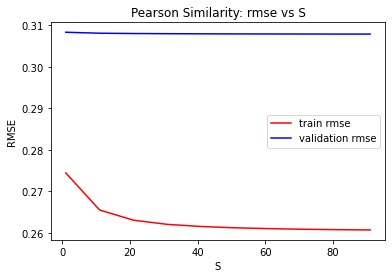

In [48]:
plt.plot(PearsonCF_s,PearsonCF_train, color= 'r' ,label='train rmse' )
plt.plot(PearsonCF_s,PearsonCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Pearson Similarity: rmse vs S')
plt.legend()
plt.show()

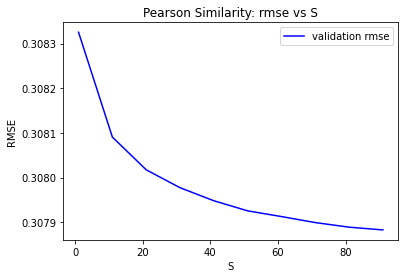

In [46]:
plt.plot(PearsonCF_s,PearsonCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Pearson Similarity: rmse vs S')
plt.legend()
plt.show()

In [49]:
PearsonCF_model = tc.item_similarity_recommender.create(train4,similarity_type='pearson',user_id=user_id, item_id=item_id,target = target,only_top_k=30)


Preparing data set.

Data has 739349 observations with 37284 users and 36847 items.

Data prepared in: 0.592241s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.207ms                        | 2.5        |

| 54.552ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.85s                               | 0.25             | 92              |

| 5.87s                               | 58.25            | 21463           |

| 16.18s                              | 100              | 36847           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 16.2924s

In [50]:
PearsonCF_evaluation = PearsonCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/35941 queries. users per second: 3108.48

recommendations finished on 2000/35941 queries. users per second: 2856.43

recommendations finished on 3000/35941 queries. users per second: 2663.84

recommendations finished on 4000/35941 queries. users per second: 2716.13

recommendations finished on 5000/35941 queries. users per second: 2827.15

recommendations finished on 6000/35941 queries. users per second: 2926.59

recommendations finished on 7000/35941 queries. users per second: 2977.52

recommendations finished on 8000/35941 queries. users per second: 2992.48

recommendations finished on 9000/35941 queries. users per second: 2886.74

recommendations finished on 10000/35941 queries. users per second: 2826.29

recommendations finished on 11000/35941 queries. users per second: 2782.81

recommendations finished on 12000/35941 queries. users per second: 2802.96

recommendations finished on 13000/35941 queries. users per second: 2761.8

recommendations finished on 14000/35941 queries. users per second: 2718.95

recommendations finished on 15000/35941 queries. users per second: 2685.36

recommendations finished on 16000/35941 queries. users per second: 2656.44

recommendations finished on 17000/35941 queries. users per second: 2585.76

recommendations finished on 18000/35941 queries. users per second: 2578.17

recommendations finished on 19000/35941 queries. users per second: 2576.8

recommendations finished on 20000/35941 queries. users per second: 2603.41

recommendations finished on 21000/35941 queries. users per second: 2576.66

recommendations finished on 22000/35941 queries. users per second: 2583.38

recommendations finished on 23000/35941 queries. users per second: 2604.54

recommendations finished on 24000/35941 queries. users per second: 2607.97

recommendations finished on 25000/35941 queries. users per second: 2609.64

recommendations finished on 26000/35941 queries. users per second: 2612.53

recommendations finished on 27000/35941 queries. users per second: 2604.87

recommendations finished on 28000/35941 queries. users per second: 2602.57

recommendations finished on 29000/35941 queries. users per second: 2584.86

recommendations finished on 30000/35941 queries. users per second: 2576.59

recommendations finished on 31000/35941 queries. users per second: 2578.02

recommendations finished on 32000/35941 queries. users per second: 2585.79

recommendations finished on 33000/35941 queries. users per second: 2591.1

recommendations finished on 34000/35941 queries. users per second: 2606.26

recommendations finished on 35000/35941 queries. users per second: 2613.55

In [51]:
col_names =  ['cutoff', 'precision', 'recall'] 
PearsonCF_results  = pd.DataFrame(columns = col_names)
PearsonCF_results['cutoff'] = np.array(PearsonCF_evaluation['precision_recall_overall']['cutoff'])
PearsonCF_results['precision'] = np.array(PearsonCF_evaluation['precision_recall_overall']['precision'])
PearsonCF_results['recall'] = np.array(PearsonCF_evaluation['precision_recall_overall']['recall'])

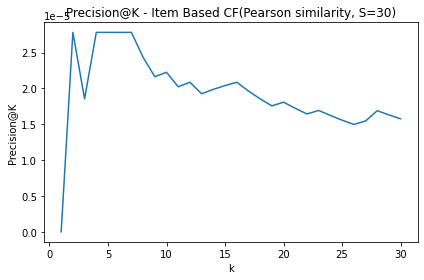

In [52]:
plt.plot(PearsonCF_results['cutoff'],PearsonCF_results['precision'] )
plt.title('Precision@K - Item Based CF(Pearson similarity, S=30)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.tight_layout()
plt.show()

# Item Based CF - Jaccard

In [56]:
JaccardCF_s, JaccardCF_train, JaccardCF_val = test_s_vals('jaccard')

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.476345s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.257ms                        | 2.5        |

| 24.311ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.53s                               | 0                | 1               |

| 9.11s                               | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 9.16293s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 6122.12

recommendations finished on 2000/37283 queries. users per second: 5961.52

recommendations finished on 3000/37283 queries. users per second: 5938.29

recommendations finished on 4000/37283 queries. users per second: 5938.9

recommendations finished on 5000/37283 queries. users per second: 5868.83

recommendations finished on 6000/37283 queries. users per second: 5836.55

recommendations finished on 7000/37283 queries. users per second: 5846.64

recommendations finished on 8000/37283 queries. users per second: 5839.9

recommendations finished on 9000/37283 queries. users per second: 5853.99

recommendations finished on 10000/37283 queries. users per second: 5824.79

recommendations finished on 11000/37283 queries. users per second: 5628.47

recommendations finished on 12000/37283 queries. users per second: 5468.42

recommendations finished on 13000/37283 queries. users per second: 5398.45

recommendations finished on 14000/37283 queries. users per second: 5420.94

recommendations finished on 15000/37283 queries. users per second: 5444.26

recommendations finished on 16000/37283 queries. users per second: 5470.42

recommendations finished on 17000/37283 queries. users per second: 5496.94

recommendations finished on 18000/37283 queries. users per second: 5516.12

recommendations finished on 19000/37283 queries. users per second: 5530.98

recommendations finished on 20000/37283 queries. users per second: 5549.4

recommendations finished on 21000/37283 queries. users per second: 5560.58

recommendations finished on 22000/37283 queries. users per second: 5558.66

recommendations finished on 23000/37283 queries. users per second: 5570.64

recommendations finished on 24000/37283 queries. users per second: 5549.82

recommendations finished on 25000/37283 queries. users per second: 5532.96

recommendations finished on 26000/37283 queries. users per second: 5518.8

recommendations finished on 27000/37283 queries. users per second: 5496.87

recommendations finished on 28000/37283 queries. users per second: 5481.2

recommendations finished on 29000/37283 queries. users per second: 5464.49

recommendations finished on 30000/37283 queries. users per second: 5435.89

recommendations finished on 31000/37283 queries. users per second: 5376.02

recommendations finished on 32000/37283 queries. users per second: 5330.53

recommendations finished on 33000/37283 queries. users per second: 5254.05

recommendations finished on 34000/37283 queries. users per second: 5241.31

recommendations finished on 35000/37283 queries. users per second: 5237.52

recommendations finished on 36000/37283 queries. users per second: 5248.38

recommendations finished on 37000/37283 queries. users per second: 5268.03


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |   0.21664029182201  | 0.016960918485861533 |
|   2    | 0.23612638467934458 |   0.03853312822391   |
|   3    |  0.2158177542937359 |  0.0526401567250576  |
|   4    | 0.20117748035297606 | 0.06518871912918843  |
|   5    | 0.18810718021618464 | 0.07554703009310991  |
|   6    | 0.17639853731369984 |  0.0841186248779893  |
|   7    | 0.16588947088102218 |  0.0909692240425496  |
|   8    | 0.15595244481399034 | 0.09616674950626795  |
|   9    |  0.1470196425537993 | 0.10033374879294425  |
|   10   |  0.1387763860204376 | 0.10360084091129175  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0943295873231422

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.476924s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.737ms                        | 2.5        |

| 45.566ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.28s                               | 0                | 0               |

| 8.69s                               | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.74818s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 6368.09

recommendations finished on 2000/37283 queries. users per second: 6356.85

recommendations finished on 3000/37283 queries. users per second: 6364.89

recommendations finished on 4000/37283 queries. users per second: 6361.07

recommendations finished on 5000/37283 queries. users per second: 6384.99

recommendations finished on 6000/37283 queries. users per second: 6374.04

recommendations finished on 7000/37283 queries. users per second: 6362.73

recommendations finished on 8000/37283 queries. users per second: 6373.9

recommendations finished on 9000/37283 queries. users per second: 6394.7

recommendations finished on 10000/37283 queries. users per second: 6395.51

recommendations finished on 11000/37283 queries. users per second: 6394.26

recommendations finished on 12000/37283 queries. users per second: 6392.49

recommendations finished on 13000/37283 queries. users per second: 6402.44

recommendations finished on 14000/37283 queries. users per second: 6407.16

recommendations finished on 15000/37283 queries. users per second: 6386.16

recommendations finished on 16000/37283 queries. users per second: 6392.56

recommendations finished on 17000/37283 queries. users per second: 6388.94

recommendations finished on 18000/37283 queries. users per second: 6397.46

recommendations finished on 19000/37283 queries. users per second: 6403.66

recommendations finished on 20000/37283 queries. users per second: 6413.82

recommendations finished on 21000/37283 queries. users per second: 6421.18

recommendations finished on 22000/37283 queries. users per second: 6414.18

recommendations finished on 23000/37283 queries. users per second: 6393.7

recommendations finished on 24000/37283 queries. users per second: 6392.74

recommendations finished on 25000/37283 queries. users per second: 6394.5

recommendations finished on 26000/37283 queries. users per second: 6395.51

recommendations finished on 27000/37283 queries. users per second: 6401.39

recommendations finished on 28000/37283 queries. users per second: 6404.54

recommendations finished on 29000/37283 queries. users per second: 6405.95

recommendations finished on 30000/37283 queries. users per second: 6399.5

recommendations finished on 31000/37283 queries. users per second: 6404.06

recommendations finished on 32000/37283 queries. users per second: 6405.01

recommendations finished on 33000/37283 queries. users per second: 6381.88

recommendations finished on 34000/37283 queries. users per second: 6346.78

recommendations finished on 35000/37283 queries. users per second: 6331.77

recommendations finished on 36000/37283 queries. users per second: 6317.44

recommendations finished on 37000/37283 queries. users per second: 6209.01


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.2881474130300667 | 0.020830997151241985 |
|   2    | 0.28612236139795644 | 0.04207153640924722  |
|   3    | 0.27805344705808543 | 0.06165531313227652  |
|   4    | 0.26624064587077245 | 0.07866009586025985  |
|   5    |  0.2544108574953729 | 0.09371366554699169  |
|   6    | 0.24311795366968067 | 0.10703305744314018  |
|   7    | 0.23203988029779934 | 0.11859166535129084  |
|   8    |  0.2219677869270177 | 0.12908844280043247  |
|   9    | 0.21226236562985218 |  0.1383114773612439  |
|   10   |  0.2037979776305556 | 0.14706062523723135  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.089021809852423

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.537194s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.492ms                        | 2.5        |

| 38.937ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.01s                               | 0.25             | 89              |

| 13.95s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 14.026s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 4807.18

recommendations finished on 2000/37283 queries. users per second: 4776.09

recommendations finished on 3000/37283 queries. users per second: 4857.47

recommendations finished on 4000/37283 queries. users per second: 5011.89

recommendations finished on 5000/37283 queries. users per second: 5028.08

recommendations finished on 6000/37283 queries. users per second: 5093.34

recommendations finished on 7000/37283 queries. users per second: 5175.37

recommendations finished on 8000/37283 queries. users per second: 5225.4

recommendations finished on 9000/37283 queries. users per second: 5285.04

recommendations finished on 10000/37283 queries. users per second: 5316.02

recommendations finished on 11000/37283 queries. users per second: 5332.65

recommendations finished on 12000/37283 queries. users per second: 5358.32

recommendations finished on 13000/37283 queries. users per second: 5379.81

recommendations finished on 14000/37283 queries. users per second: 5352.4

recommendations finished on 15000/37283 queries. users per second: 5272.85

recommendations finished on 16000/37283 queries. users per second: 5232.04

recommendations finished on 17000/37283 queries. users per second: 5242.91

recommendations finished on 18000/37283 queries. users per second: 5261.17

recommendations finished on 19000/37283 queries. users per second: 5282.39

recommendations finished on 20000/37283 queries. users per second: 5287.57

recommendations finished on 21000/37283 queries. users per second: 5310.87

recommendations finished on 22000/37283 queries. users per second: 5312.27

recommendations finished on 23000/37283 queries. users per second: 5311.02

recommendations finished on 24000/37283 queries. users per second: 5326.35

recommendations finished on 25000/37283 queries. users per second: 5340.15

recommendations finished on 26000/37283 queries. users per second: 5345.19

recommendations finished on 27000/37283 queries. users per second: 5361.67

recommendations finished on 28000/37283 queries. users per second: 5373.52

recommendations finished on 29000/37283 queries. users per second: 5381.38

recommendations finished on 30000/37283 queries. users per second: 5387.89

recommendations finished on 31000/37283 queries. users per second: 5387.77

recommendations finished on 32000/37283 queries. users per second: 5371.81

recommendations finished on 33000/37283 queries. users per second: 5378.35

recommendations finished on 34000/37283 queries. users per second: 5383.25

recommendations finished on 35000/37283 queries. users per second: 5378.86

recommendations finished on 36000/37283 queries. users per second: 5386.23

recommendations finished on 37000/37283 queries. users per second: 5389.5


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3269854893651263 | 0.023659236171036727 |
|   2    |  0.3243301236488493 | 0.047598775673194385 |
|   3    |  0.3138070076621159 | 0.06920181959126831  |
|   4    | 0.30138400879757526 |  0.0884587701239191  |
|   5    | 0.28878040930182636 | 0.10541771966106853  |
|   6    |  0.2758048797932929 | 0.12004698945919538  |
|   7    |  0.2633525045884558 | 0.13295510856709306  |
|   8    |  0.2522161574980561 | 0.14462185948888526  |
|   9    | 0.24167702289098103 | 0.15514731167806864  |
|   10   | 0.23232840704878865 |  0.1649395569033416  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0870471853029287

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.484238s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.524ms                        | 2.5        |

| 46.321ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.36s                               | 0                | 1               |

| 12.90s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 12.9612s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5700.73

recommendations finished on 2000/37283 queries. users per second: 5637.11

recommendations finished on 3000/37283 queries. users per second: 5656.15

recommendations finished on 4000/37283 queries. users per second: 5739.29

recommendations finished on 5000/37283 queries. users per second: 5718.82

recommendations finished on 6000/37283 queries. users per second: 5717.32

recommendations finished on 7000/37283 queries. users per second: 5757.53

recommendations finished on 8000/37283 queries. users per second: 5739.6

recommendations finished on 9000/37283 queries. users per second: 5743.73

recommendations finished on 10000/37283 queries. users per second: 5744.47

recommendations finished on 11000/37283 queries. users per second: 5737.2

recommendations finished on 12000/37283 queries. users per second: 5718.08

recommendations finished on 13000/37283 queries. users per second: 5706.52

recommendations finished on 14000/37283 queries. users per second: 5697.76

recommendations finished on 15000/37283 queries. users per second: 5708.76

recommendations finished on 16000/37283 queries. users per second: 5702.62

recommendations finished on 17000/37283 queries. users per second: 5675.8

recommendations finished on 18000/37283 queries. users per second: 5669.29

recommendations finished on 19000/37283 queries. users per second: 5677.78

recommendations finished on 20000/37283 queries. users per second: 5667.11

recommendations finished on 21000/37283 queries. users per second: 5668.59

recommendations finished on 22000/37283 queries. users per second: 5670.02

recommendations finished on 23000/37283 queries. users per second: 5657.92

recommendations finished on 24000/37283 queries. users per second: 5663.83

recommendations finished on 25000/37283 queries. users per second: 5663.89

recommendations finished on 26000/37283 queries. users per second: 5669.04

recommendations finished on 27000/37283 queries. users per second: 5679.14

recommendations finished on 28000/37283 queries. users per second: 5689.18

recommendations finished on 29000/37283 queries. users per second: 5657.56

recommendations finished on 30000/37283 queries. users per second: 5631.48

recommendations finished on 31000/37283 queries. users per second: 5611.42

recommendations finished on 32000/37283 queries. users per second: 5618.98

recommendations finished on 33000/37283 queries. users per second: 5623.03

recommendations finished on 34000/37283 queries. users per second: 5505.57

recommendations finished on 35000/37283 queries. users per second: 5466.66

recommendations finished on 36000/37283 queries. users per second: 5461.74

recommendations finished on 37000/37283 queries. users per second: 5386.13


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.35120564332269394 | 0.025481850615994988 |
|   2    | 0.35005230265804793 | 0.051493123536221465 |
|   3    | 0.33977058355461415 | 0.07504738110636244  |
|   4    |  0.3267977362336722 | 0.09584602830242654  |
|   5    |  0.3128289032534932 | 0.11407327779955458  |
|   6    | 0.29918461497197263 |  0.1300212455526153  |
|   7    | 0.28637716921921447 |  0.144069369645285   |
|   8    |  0.2742134484885868 | 0.15651422687322786  |
|   9    |  0.262663650695729  | 0.16764562275137343  |
|   10   | 0.25229192929753536 | 0.17790881853724885  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0857881998404189

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.768442s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.031ms                        | 2.5        |

| 35.425ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.37s                               | 0                | 0               |

| 13.64s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 13.7917s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5329.47

recommendations finished on 2000/37283 queries. users per second: 5474.62

recommendations finished on 3000/37283 queries. users per second: 5395.45

recommendations finished on 4000/37283 queries. users per second: 5402.13

recommendations finished on 5000/37283 queries. users per second: 5451.4

recommendations finished on 6000/37283 queries. users per second: 5428.5

recommendations finished on 7000/37283 queries. users per second: 5345.24

recommendations finished on 8000/37283 queries. users per second: 5384.77

recommendations finished on 9000/37283 queries. users per second: 5361.72

recommendations finished on 10000/37283 queries. users per second: 5390.13

recommendations finished on 11000/37283 queries. users per second: 5419.13

recommendations finished on 12000/37283 queries. users per second: 5391.08

recommendations finished on 13000/37283 queries. users per second: 5417.3

recommendations finished on 14000/37283 queries. users per second: 5435.22

recommendations finished on 15000/37283 queries. users per second: 5427.96

recommendations finished on 16000/37283 queries. users per second: 5447.36

recommendations finished on 17000/37283 queries. users per second: 5462.21

recommendations finished on 18000/37283 queries. users per second: 5451.96

recommendations finished on 19000/37283 queries. users per second: 5465.16

recommendations finished on 20000/37283 queries. users per second: 5468.5

recommendations finished on 21000/37283 queries. users per second: 5460.65

recommendations finished on 22000/37283 queries. users per second: 5457.07

recommendations finished on 23000/37283 queries. users per second: 5448.58

recommendations finished on 24000/37283 queries. users per second: 5454.51

recommendations finished on 25000/37283 queries. users per second: 5456.55

recommendations finished on 26000/37283 queries. users per second: 5456.81

recommendations finished on 27000/37283 queries. users per second: 5459.94

recommendations finished on 28000/37283 queries. users per second: 5469.27

recommendations finished on 29000/37283 queries. users per second: 5468.67

recommendations finished on 30000/37283 queries. users per second: 5473.14

recommendations finished on 31000/37283 queries. users per second: 5478.05

recommendations finished on 32000/37283 queries. users per second: 5476.56

recommendations finished on 33000/37283 queries. users per second: 5477.67

recommendations finished on 34000/37283 queries. users per second: 5480.81

recommendations finished on 35000/37283 queries. users per second: 5480.94

recommendations finished on 36000/37283 queries. users per second: 5486.78

recommendations finished on 37000/37283 queries. users per second: 5459.6


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3696054502051869 | 0.02684985207256909  |
|   2    | 0.36937746425985063 | 0.054493771092880776 |
|   3    | 0.35890352171230777 | 0.07934466934813189  |
|   4    |  0.3459016173591179 | 0.10148720452266284  |
|   5    | 0.33195826516106697 | 0.12092554154458023  |
|   6    |  0.3175844218544658 | 0.13784127909186347  |
|   7    | 0.30402596357589257 | 0.15268168901337115  |
|   8    | 0.29158731861706405 | 0.16610563868601272  |
|   9    |  0.2796895814893287 |  0.1780032530688729  |
|   10   | 0.26870959954939266 | 0.18883621062789518  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.084862299143512

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.73565s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.274ms                        | 2.5        |

| 41.309ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.61s                               | 0                | 0               |

| 12.38s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 12.4768s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5469.35

recommendations finished on 2000/37283 queries. users per second: 5472.72

recommendations finished on 3000/37283 queries. users per second: 5436.51

recommendations finished on 4000/37283 queries. users per second: 5464.83

recommendations finished on 5000/37283 queries. users per second: 5425.78

recommendations finished on 6000/37283 queries. users per second: 5377.37

recommendations finished on 7000/37283 queries. users per second: 5394.49

recommendations finished on 8000/37283 queries. users per second: 5416.01

recommendations finished on 9000/37283 queries. users per second: 5409.17

recommendations finished on 10000/37283 queries. users per second: 5407.23

recommendations finished on 11000/37283 queries. users per second: 5425.1

recommendations finished on 12000/37283 queries. users per second: 5402.73

recommendations finished on 13000/37283 queries. users per second: 5412.16

recommendations finished on 14000/37283 queries. users per second: 5421.22

recommendations finished on 15000/37283 queries. users per second: 5403.3

recommendations finished on 16000/37283 queries. users per second: 5411.53

recommendations finished on 17000/37283 queries. users per second: 5422.29

recommendations finished on 18000/37283 queries. users per second: 5412.05

recommendations finished on 19000/37283 queries. users per second: 5405.27

recommendations finished on 20000/37283 queries. users per second: 5406.1

recommendations finished on 21000/37283 queries. users per second: 5402.09

recommendations finished on 22000/37283 queries. users per second: 5400.82

recommendations finished on 23000/37283 queries. users per second: 5386.83

recommendations finished on 24000/37283 queries. users per second: 5391.25

recommendations finished on 25000/37283 queries. users per second: 5365.39

recommendations finished on 26000/37283 queries. users per second: 5351.61

recommendations finished on 27000/37283 queries. users per second: 5360.05

recommendations finished on 28000/37283 queries. users per second: 5367.34

recommendations finished on 29000/37283 queries. users per second: 5357.13

recommendations finished on 30000/37283 queries. users per second: 5361.7

recommendations finished on 31000/37283 queries. users per second: 5361.19

recommendations finished on 32000/37283 queries. users per second: 5356.15

recommendations finished on 33000/37283 queries. users per second: 5359.48

recommendations finished on 34000/37283 queries. users per second: 5359.27

recommendations finished on 35000/37283 queries. users per second: 5345.72

recommendations finished on 36000/37283 queries. users per second: 5319.12

recommendations finished on 37000/37283 queries. users per second: 5258.36


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.384303838210444  | 0.027972721808043093 |
|   2    | 0.38437089290024956 | 0.05681546336530812  |
|   3    |  0.3737717815984064 |  0.082868493883049   |
|   4    | 0.36134431242121123 | 0.10632362337744306  |
|   5    | 0.34723064131105275 |  0.1266707948411974  |
|   6    | 0.33219787391930206 |  0.1441831138835693  |
|   7    |  0.3182683796904757 | 0.15982313118224287  |
|   8    | 0.30502172571949626 | 0.17363199670483775  |
|   9    |  0.2928352808995466 | 0.18609397462135996  |
|   10   | 0.28149022342622576 |  0.1974130091089328  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.084150035838416

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.546359s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.996ms                        | 2.5        |

| 36.542ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.55s                               | 0                | 3               |

| 11.74s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 11.8218s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 4579.34

recommendations finished on 2000/37283 queries. users per second: 4843.45

recommendations finished on 3000/37283 queries. users per second: 4877.68

recommendations finished on 4000/37283 queries. users per second: 4887.01

recommendations finished on 5000/37283 queries. users per second: 4976.92

recommendations finished on 6000/37283 queries. users per second: 5041.4

recommendations finished on 7000/37283 queries. users per second: 4960.24

recommendations finished on 8000/37283 queries. users per second: 4999.05

recommendations finished on 9000/37283 queries. users per second: 5030.48

recommendations finished on 10000/37283 queries. users per second: 5078.79

recommendations finished on 11000/37283 queries. users per second: 5112.19

recommendations finished on 12000/37283 queries. users per second: 5117.65

recommendations finished on 13000/37283 queries. users per second: 5150.23

recommendations finished on 14000/37283 queries. users per second: 5181.01

recommendations finished on 15000/37283 queries. users per second: 5187.17

recommendations finished on 16000/37283 queries. users per second: 5189.2

recommendations finished on 17000/37283 queries. users per second: 5209.61

recommendations finished on 18000/37283 queries. users per second: 5217.18

recommendations finished on 19000/37283 queries. users per second: 5229.01

recommendations finished on 20000/37283 queries. users per second: 5245.62

recommendations finished on 21000/37283 queries. users per second: 5247.41

recommendations finished on 22000/37283 queries. users per second: 5245.66

recommendations finished on 23000/37283 queries. users per second: 5248.05

recommendations finished on 24000/37283 queries. users per second: 5247.08

recommendations finished on 25000/37283 queries. users per second: 5257.93

recommendations finished on 26000/37283 queries. users per second: 5240.12

recommendations finished on 27000/37283 queries. users per second: 5192.73

recommendations finished on 28000/37283 queries. users per second: 5160.83

recommendations finished on 29000/37283 queries. users per second: 5127.79

recommendations finished on 30000/37283 queries. users per second: 5106.58

recommendations finished on 31000/37283 queries. users per second: 5081.79

recommendations finished on 32000/37283 queries. users per second: 5072.3

recommendations finished on 33000/37283 queries. users per second: 5086.62

recommendations finished on 34000/37283 queries. users per second: 5092.32

recommendations finished on 35000/37283 queries. users per second: 5106.45

recommendations finished on 36000/37283 queries. users per second: 5120.6

recommendations finished on 37000/37283 queries. users per second: 5123.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.395139876082933  | 0.02881190820733063 |
|   2    | 0.39715151677708405 | 0.05876612364279866 |
|   3    |  0.3861724288996776 | 0.08578154560538567 |
|   4    | 0.37334039642732586 | 0.10994141430245753 |
|   5    |  0.3591556473459776 |  0.1310344837095773 |
|   6    | 0.34442864933973416 | 0.14962127190609317 |
|   7    |  0.3302079461723277 | 0.16590792599566354 |
|   8    |  0.3167898237802753 |  0.1803302343027905 |
|   9    |  0.3041153698289657 |  0.1931459390730778 |
|   10   |  0.2926695813105181 | 0.20506250676585377 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.083548368956963

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.506431s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.263ms                        | 2.5        |

| 38.12ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.59s                               | 0                | 0               |

| 11.63s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 11.7229s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 5626.64

recommendations finished on 2000/37283 queries. users per second: 5513.38

recommendations finished on 3000/37283 queries. users per second: 5508.73

recommendations finished on 4000/37283 queries. users per second: 5440.19

recommendations finished on 5000/37283 queries. users per second: 5369.39

recommendations finished on 6000/37283 queries. users per second: 5102.14

recommendations finished on 7000/37283 queries. users per second: 4905.6

recommendations finished on 8000/37283 queries. users per second: 4875.17

recommendations finished on 9000/37283 queries. users per second: 4824.06

recommendations finished on 10000/37283 queries. users per second: 4753.96

recommendations finished on 11000/37283 queries. users per second: 4604.06

recommendations finished on 12000/37283 queries. users per second: 4512.47

recommendations finished on 13000/37283 queries. users per second: 4191.93

recommendations finished on 14000/37283 queries. users per second: 4152.21

recommendations finished on 15000/37283 queries. users per second: 4215.63

recommendations finished on 16000/37283 queries. users per second: 4282.36

recommendations finished on 17000/37283 queries. users per second: 4337.86

recommendations finished on 18000/37283 queries. users per second: 4367.32

recommendations finished on 19000/37283 queries. users per second: 4412.02

recommendations finished on 20000/37283 queries. users per second: 4449.45

recommendations finished on 21000/37283 queries. users per second: 4495.08

recommendations finished on 22000/37283 queries. users per second: 4527.3

recommendations finished on 23000/37283 queries. users per second: 4559.13

recommendations finished on 24000/37283 queries. users per second: 4587.71

recommendations finished on 25000/37283 queries. users per second: 4623.94

recommendations finished on 26000/37283 queries. users per second: 4651.53

recommendations finished on 27000/37283 queries. users per second: 4678.3

recommendations finished on 28000/37283 queries. users per second: 4708.27

recommendations finished on 29000/37283 queries. users per second: 4725.37

recommendations finished on 30000/37283 queries. users per second: 4749.87

recommendations finished on 31000/37283 queries. users per second: 4776.52

recommendations finished on 32000/37283 queries. users per second: 4790.13

recommendations finished on 33000/37283 queries. users per second: 4811.11

recommendations finished on 34000/37283 queries. users per second: 4832.49

recommendations finished on 35000/37283 queries. users per second: 4845.53

recommendations finished on 36000/37283 queries. users per second: 4866.57

recommendations finished on 37000/37283 queries. users per second: 4882.77


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4048493951666981 | 0.029528873425301062 |
|   2    |  0.4073974733792878 | 0.06032625635172203  |
|   3    |  0.3974912605387631 | 0.08838681460767073  |
|   4    |  0.3845117077488399 | 0.11335418787409925  |
|   5    |  0.3701150658477047 | 0.13518351046871147  |
|   6    | 0.35502776064157937 | 0.15436601511178108  |
|   7    | 0.34042708089861057 |  0.1711702900758821  |
|   8    | 0.32673738701284816 | 0.18605123342083238  |
|   9    |  0.3139142951658046 |  0.1994219840143252  |
|   10   |  0.3019231285036088 | 0.21152648182964795  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0830435260237037

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.539218s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.045ms                        | 2.5        |

| 35.684ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.21s                               | 0                | 1               |

| 12.87s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 12.9659s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3682.16

recommendations finished on 2000/37283 queries. users per second: 3730.97

recommendations finished on 3000/37283 queries. users per second: 4017.66

recommendations finished on 4000/37283 queries. users per second: 4136.28

recommendations finished on 5000/37283 queries. users per second: 4285.49

recommendations finished on 6000/37283 queries. users per second: 4285.18

recommendations finished on 7000/37283 queries. users per second: 4177.9

recommendations finished on 8000/37283 queries. users per second: 4187.23

recommendations finished on 9000/37283 queries. users per second: 4276.15

recommendations finished on 10000/37283 queries. users per second: 4266.66

recommendations finished on 11000/37283 queries. users per second: 4316.82

recommendations finished on 12000/37283 queries. users per second: 4338.1

recommendations finished on 13000/37283 queries. users per second: 4282.43

recommendations finished on 14000/37283 queries. users per second: 4337.69

recommendations finished on 15000/37283 queries. users per second: 4343.61

recommendations finished on 16000/37283 queries. users per second: 4306.12

recommendations finished on 17000/37283 queries. users per second: 4354.82

recommendations finished on 18000/37283 queries. users per second: 4338.95

recommendations finished on 19000/37283 queries. users per second: 4297.57

recommendations finished on 20000/37283 queries. users per second: 4314.35

recommendations finished on 21000/37283 queries. users per second: 4279.93

recommendations finished on 22000/37283 queries. users per second: 4239.84

recommendations finished on 23000/37283 queries. users per second: 4150.53

recommendations finished on 24000/37283 queries. users per second: 4116.1

recommendations finished on 25000/37283 queries. users per second: 4048.59

recommendations finished on 26000/37283 queries. users per second: 4002.15

recommendations finished on 27000/37283 queries. users per second: 4006.12

recommendations finished on 28000/37283 queries. users per second: 4036.4

recommendations finished on 29000/37283 queries. users per second: 4072.14

recommendations finished on 30000/37283 queries. users per second: 4089.78

recommendations finished on 31000/37283 queries. users per second: 4066.58

recommendations finished on 32000/37283 queries. users per second: 4067.57

recommendations finished on 33000/37283 queries. users per second: 4093.76

recommendations finished on 34000/37283 queries. users per second: 4121.27

recommendations finished on 35000/37283 queries. users per second: 4131.55

recommendations finished on 36000/37283 queries. users per second: 4149.67

recommendations finished on 37000/37283 queries. users per second: 4174.15


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.41359332671727034 | 0.030177067479036212 |
|   2    | 0.41714722527693565 | 0.061907352759428914 |
|   3    |  0.4073170077515231 |  0.0906803900937096  |
|   4    |  0.3936914947831449 | 0.11617714082928769  |
|   5    |  0.3794437142933767 | 0.13874741219161604  |
|   6    |  0.3645003531546987 | 0.15866701980478276  |
|   7    |  0.3496461428226574 | 0.17592671834931248  |
|   8    | 0.33566571896038516 |  0.1912597196592937  |
|   9    |  0.3224913350439717 | 0.20495463515335913  |
|   10   |  0.3103156934796028 | 0.21742540982492214  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.082613613204639

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.547457s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.896ms                        | 2.5        |

| 40.771ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.28s                               | 0.25             | 89              |

| 12.97s                              | 100              | 35148           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 13.0798s

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 4436.22

recommendations finished on 2000/37283 queries. users per second: 4702.71

recommendations finished on 3000/37283 queries. users per second: 4838.69

recommendations finished on 4000/37283 queries. users per second: 4979.19

recommendations finished on 5000/37283 queries. users per second: 5037.05

recommendations finished on 6000/37283 queries. users per second: 4962.4

recommendations finished on 7000/37283 queries. users per second: 4917.62

recommendations finished on 8000/37283 queries. users per second: 4972.91

recommendations finished on 9000/37283 queries. users per second: 4995.99

recommendations finished on 10000/37283 queries. users per second: 5021.43

recommendations finished on 11000/37283 queries. users per second: 5010.55

recommendations finished on 12000/37283 queries. users per second: 5023.72

recommendations finished on 13000/37283 queries. users per second: 5052.53

recommendations finished on 14000/37283 queries. users per second: 5066.65

recommendations finished on 15000/37283 queries. users per second: 5086.27

recommendations finished on 16000/37283 queries. users per second: 5108.29

recommendations finished on 17000/37283 queries. users per second: 5116.75

recommendations finished on 18000/37283 queries. users per second: 5130.43

recommendations finished on 19000/37283 queries. users per second: 5152.13

recommendations finished on 20000/37283 queries. users per second: 5157.64

recommendations finished on 21000/37283 queries. users per second: 5172.54

recommendations finished on 22000/37283 queries. users per second: 5175.13

recommendations finished on 23000/37283 queries. users per second: 5170.92

recommendations finished on 24000/37283 queries. users per second: 5175.04

recommendations finished on 25000/37283 queries. users per second: 5150.6

recommendations finished on 26000/37283 queries. users per second: 5143.73

recommendations finished on 27000/37283 queries. users per second: 5156.72

recommendations finished on 28000/37283 queries. users per second: 5157.25

recommendations finished on 29000/37283 queries. users per second: 5160.35

recommendations finished on 30000/37283 queries. users per second: 5150.12

recommendations finished on 31000/37283 queries. users per second: 5083.39

recommendations finished on 32000/37283 queries. users per second: 5044.14

recommendations finished on 33000/37283 queries. users per second: 5001.66

recommendations finished on 34000/37283 queries. users per second: 4959.02

recommendations finished on 35000/37283 queries. users per second: 4934.07

recommendations finished on 36000/37283 queries. users per second: 4916.67

recommendations finished on 37000/37283 queries. users per second: 4914.78


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4212643832309629 | 0.03080354900669882 |
|   2    | 0.42405385832685183 | 0.06295178016149561 |
|   3    |  0.4149880642652146 | 0.09238945822501766 |
|   4    |  0.402039803663868  | 0.11883442636585424 |
|   5    |  0.3874527264436878 | 0.14184742362460856 |
|   6    | 0.37271678781213957 | 0.16237603914897986 |
|   7    |  0.3577884980132656 |  0.1801962820210266 |
|   8    | 0.34335353914652766 | 0.19574361765560225 |
|   9    |  0.3300551040539759 | 0.20984168455217794 |
|   10   | 0.31781777217498625 |  0.2227045284816416 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0822303252259096

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

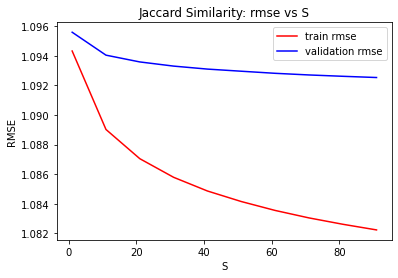

In [61]:
plt.plot(JaccardCF_s,JaccardCF_train, color= 'r' ,label='train rmse' )
plt.plot(JaccardCF_s,JaccardCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Jaccard Similarity: rmse vs S')
plt.legend()
plt.show()

In [62]:
JaccardCF_model = tc.item_similarity_recommender.create(train4,similarity_type='jaccard',user_id=user_id, item_id=item_id,target = target,only_top_k=15)

Preparing data set.

Data has 739349 observations with 37284 users and 36847 items.

Data prepared in: 0.565376s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.847ms                        | 2.5        |

| 29.446ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.86s                               | 0                | 0               |

| 13.69s                              | 100              | 36847           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 13.778s

In [63]:
JaccardCF_evaluation = JaccardCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/35941 queries. users per second: 4097.29

recommendations finished on 2000/35941 queries. users per second: 4340.27

recommendations finished on 3000/35941 queries. users per second: 4451.3

recommendations finished on 4000/35941 queries. users per second: 4461.99

recommendations finished on 5000/35941 queries. users per second: 4379.97

recommendations finished on 6000/35941 queries. users per second: 4346.42

recommendations finished on 7000/35941 queries. users per second: 4390.33

recommendations finished on 8000/35941 queries. users per second: 4451.46

recommendations finished on 9000/35941 queries. users per second: 4499.11

recommendations finished on 10000/35941 queries. users per second: 4483.64

recommendations finished on 11000/35941 queries. users per second: 4423.31

recommendations finished on 12000/35941 queries. users per second: 4396.89

recommendations finished on 13000/35941 queries. users per second: 4427.71

recommendations finished on 14000/35941 queries. users per second: 4474.83

recommendations finished on 15000/35941 queries. users per second: 4449

recommendations finished on 16000/35941 queries. users per second: 4424.1

recommendations finished on 17000/35941 queries. users per second: 4416.79

recommendations finished on 18000/35941 queries. users per second: 4364.53

recommendations finished on 19000/35941 queries. users per second: 4292.04

recommendations finished on 20000/35941 queries. users per second: 4223.21

recommendations finished on 21000/35941 queries. users per second: 4248.97

recommendations finished on 22000/35941 queries. users per second: 4277.5

recommendations finished on 23000/35941 queries. users per second: 4280.61

recommendations finished on 24000/35941 queries. users per second: 4220.93

recommendations finished on 25000/35941 queries. users per second: 4155.23

recommendations finished on 26000/35941 queries. users per second: 4139.33

recommendations finished on 27000/35941 queries. users per second: 4148.56

recommendations finished on 28000/35941 queries. users per second: 4099.55

recommendations finished on 29000/35941 queries. users per second: 4060.1

recommendations finished on 30000/35941 queries. users per second: 4036.52

recommendations finished on 31000/35941 queries. users per second: 4003.53

recommendations finished on 32000/35941 queries. users per second: 4010.32

recommendations finished on 33000/35941 queries. users per second: 3953.33

recommendations finished on 34000/35941 queries. users per second: 3916.77

recommendations finished on 35000/35941 queries. users per second: 3874.61

In [64]:
col_names =  ['cutoff', 'precision', 'recall'] 
JaccardCF_results  = pd.DataFrame(columns = col_names)
JaccardCF_results['cutoff'] = np.array(JaccardCF_evaluation['precision_recall_overall']['cutoff'])
JaccardCF_results['precision'] = np.array(JaccardCF_evaluation['precision_recall_overall']['precision'])
JaccardCF_results['recall'] = np.array(JaccardCF_evaluation['precision_recall_overall']['recall'])

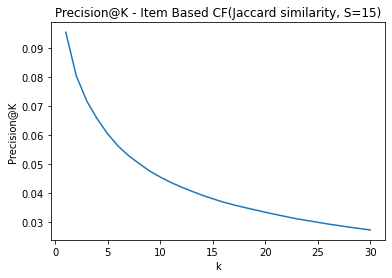

In [65]:
plt.plot(JaccardCF_results['cutoff'],JaccardCF_results['precision'] )
plt.title('Precision@K - Item Based CF(Jaccard similarity, S=15)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

# Matrix Factorization iALS

ials_confidence_scaling_factor  = 50


number of feature = 70

reg    = 1e-4

max iter = 30

In [68]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'product_id'
target = 'purchase_count'

In [81]:
# hyperparameter tuning for number of feature
num_features = np.arange(10,200,20)
def test_k_vals():
    k_list = []
    train = []
    val = []
    for loc, k in enumerate(num_features):
        model = tc.ranking_factorization_recommender.create(train3,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials', num_factors = k)
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        k_list.append(k)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return k_list,train,val

In [82]:
ials_k, ials_train_k, ials_val_k = test_k_vals() 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.464531s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 218us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 290.799ms    | 1.08792                   |

| 1       | 501.394ms    | 1.06284                   |

| 2       | 703.679ms    | 1.05947                   |

| 3       | 912.32ms     | 1.05807                   |

| 4       | 1.11s        | 1.05728                   |

| 5       | 1.32s        | 1.0568                    |

| 6       | 1.53s        | 1.05651                   |

| 7       | 1.73s        | 1.05632                   |

| 8       | 1.94s        | 1.05619                   |

| 9       | 2.15s        | 1.0561                    |

| 10      | 2.36s        | 1.05603                   |

| 11      | 2.58s        | 1.05597                   |

| 12      | 2.78s        | 1.05593                   |

| 13      | 2.99s        | 1.05589                   |

| 14      | 3.21s        | 1.05585                   |

| 15      | 3.42s        | 1.05582                   |

| 16      | 3.62s        | 1.05579                   |

| 17      | 3.83s        | 1.05576                   |

| 18      | 4.06s        | 1.05574                   |

| 19      | 4.27s        | 1.05572                   |

| 20      | 4.49s        | 1.0557                    |

| 21      | 4.70s        | 1.05568                   |

| 22      | 4.93s        | 1.05567                   |

| 23      | 5.14s        | 1.05566                   |

| 24      | 5.36s        | 1.05566                   |

| FINAL   | 5.36s        | 1.05566                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 3508.46

recommendations finished on 2000/37283 queries. users per second: 3409.64

recommendations finished on 3000/37283 queries. users per second: 3351.5

recommendations finished on 4000/37283 queries. users per second: 3328.22

recommendations finished on 5000/37283 queries. users per second: 3323.61

recommendations finished on 6000/37283 queries. users per second: 3313.68

recommendations finished on 7000/37283 queries. users per second: 3303.64

recommendations finished on 8000/37283 queries. users per second: 3305.75

recommendations finished on 9000/37283 queries. users per second: 3306.64

recommendations finished on 10000/37283 queries. users per second: 3255.72

recommendations finished on 11000/37283 queries. users per second: 3260.57

recommendations finished on 12000/37283 queries. users per second: 3266.66

recommendations finished on 13000/37283 queries. users per second: 3251.31

recommendations finished on 14000/37283 queries. users per second: 3259.99

recommendations finished on 15000/37283 queries. users per second: 3269.56

recommendations finished on 16000/37283 queries. users per second: 3276.2

recommendations finished on 17000/37283 queries. users per second: 3220.94

recommendations finished on 18000/37283 queries. users per second: 3215.53

recommendations finished on 19000/37283 queries. users per second: 3224.38

recommendations finished on 20000/37283 queries. users per second: 3232.35

recommendations finished on 21000/37283 queries. users per second: 3129.8

recommendations finished on 22000/37283 queries. users per second: 3096.66

recommendations finished on 23000/37283 queries. users per second: 3050.03

recommendations finished on 24000/37283 queries. users per second: 3007.69

recommendations finished on 25000/37283 queries. users per second: 2980.33

recommendations finished on 26000/37283 queries. users per second: 2971.02

recommendations finished on 27000/37283 queries. users per second: 2962.16

recommendations finished on 28000/37283 queries. users per second: 2956.34

recommendations finished on 29000/37283 queries. users per second: 2951.58

recommendations finished on 30000/37283 queries. users per second: 2935.44

recommendations finished on 31000/37283 queries. users per second: 2937.43

recommendations finished on 32000/37283 queries. users per second: 2943.57

recommendations finished on 33000/37283 queries. users per second: 2952.23

recommendations finished on 34000/37283 queries. users per second: 2962.22

recommendations finished on 35000/37283 queries. users per second: 2970.63

recommendations finished on 36000/37283 queries. users per second: 2964.86

recommendations finished on 37000/37283 queries. users per second: 2966.64


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3123407451117131 | 0.02605111935329846  |
|   2    |  0.2430330177292599 | 0.03999493790691529  |
|   3    | 0.20127135691870274 | 0.049271643234061566 |
|   4    | 0.17460370678325263 | 0.056450723773153653 |
|   5    |  0.1547300378188439 | 0.062209153032004263 |
|   6    | 0.14023370794553336 | 0.06748964007913313  |
|   7    | 0.12872201424624805 | 0.07215426080947308  |
|   8    | 0.11923329667676957 | 0.07615444961343279  |
|   9    | 0.11142105278843298 | 0.07985916979929178  |
|   10   |  0.1049754579835313 | 0.08343703587129372  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0556563131833558

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.435105s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 30       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 92us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 627.053ms    | 1.07467                   |

| 1       | 1.20s        | 1.03723                   |

| 2       | 1.78s        | 1.03192                   |

| 3       | 2.37s        | 1.03007                   |

| 4       | 2.96s        | 1.02907                   |

| 5       | 3.56s        | 1.02844                   |

| 6       | 4.15s        | 1.02801                   |

| 7       | 4.73s        | 1.02771                   |

| 8       | 5.47s        | 1.02749                   |

| 9       | 6.08s        | 1.02733                   |

| 10      | 6.67s        | 1.02721                   |

| 11      | 7.26s        | 1.02711                   |

| 12      | 7.84s        | 1.02703                   |

| 13      | 8.43s        | 1.02697                   |

| 14      | 9.02s        | 1.02692                   |

| 15      | 9.62s        | 1.02688                   |

| 16      | 10.22s       | 1.02685                   |

| 17      | 10.81s       | 1.02682                   |

| 18      | 11.41s       | 1.02679                   |

| 19      | 12.00s       | 1.02677                   |

| 20      | 12.60s       | 1.02675                   |

| 21      | 13.19s       | 1.02673                   |

| 22      | 13.77s       | 1.02672                   |

| 23      | 14.36s       | 1.0267                    |

| 24      | 14.95s       | 1.02669                   |

| FINAL   | 14.95s       | 1.02669                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 2681.85

recommendations finished on 2000/37283 queries. users per second: 2689.23

recommendations finished on 3000/37283 queries. users per second: 2695.38

recommendations finished on 4000/37283 queries. users per second: 2698.61

recommendations finished on 5000/37283 queries. users per second: 2699.35

recommendations finished on 6000/37283 queries. users per second: 2695.31

recommendations finished on 7000/37283 queries. users per second: 2695.65

recommendations finished on 8000/37283 queries. users per second: 2695.3

recommendations finished on 9000/37283 queries. users per second: 2695.03

recommendations finished on 10000/37283 queries. users per second: 2695.29

recommendations finished on 11000/37283 queries. users per second: 2696.7

recommendations finished on 12000/37283 queries. users per second: 2691.53

recommendations finished on 13000/37283 queries. users per second: 2691.86

recommendations finished on 14000/37283 queries. users per second: 2688.99

recommendations finished on 15000/37283 queries. users per second: 2688.44

recommendations finished on 16000/37283 queries. users per second: 2687.24

recommendations finished on 17000/37283 queries. users per second: 2687.07

recommendations finished on 18000/37283 queries. users per second: 2686.74

recommendations finished on 19000/37283 queries. users per second: 2681.59

recommendations finished on 20000/37283 queries. users per second: 2680.84

recommendations finished on 21000/37283 queries. users per second: 2679.39

recommendations finished on 22000/37283 queries. users per second: 2676.22

recommendations finished on 23000/37283 queries. users per second: 2673.86

recommendations finished on 24000/37283 queries. users per second: 2672.82

recommendations finished on 25000/37283 queries. users per second: 2659.11

recommendations finished on 26000/37283 queries. users per second: 2630.57

recommendations finished on 27000/37283 queries. users per second: 2598.96

recommendations finished on 28000/37283 queries. users per second: 2584.36

recommendations finished on 29000/37283 queries. users per second: 2569.96

recommendations finished on 30000/37283 queries. users per second: 2554.43

recommendations finished on 31000/37283 queries. users per second: 2530.78

recommendations finished on 32000/37283 queries. users per second: 2526

recommendations finished on 33000/37283 queries. users per second: 2527.67

recommendations finished on 34000/37283 queries. users per second: 2530.89

recommendations finished on 35000/37283 queries. users per second: 2534.21

recommendations finished on 36000/37283 queries. users per second: 2536.34

recommendations finished on 37000/37283 queries. users per second: 2538.89


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5205321460182933 | 0.04595499640732054 |
|   2    | 0.41936003004050104 | 0.07155915517863064 |
|   3    | 0.34471474934956997 | 0.08623451204185002 |
|   4    | 0.29666335863530313 |  0.0977100753815877 |
|   5    |  0.2623340396427314 | 0.10702542966048069 |
|   6    |  0.2357598190417434 | 0.11469840892248724 |
|   7    | 0.21482023595587407 | 0.12132410221334487 |
|   8    | 0.19818013571869247 | 0.12725459480410317 |
|   9    |  0.1842513865419751 |  0.1326461607969122 |
|   10   | 0.17249416624198677 |  0.1375603318258443 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0266895137883787

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.465702s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 50       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 95us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 1.33s        | 1.06376                   |

| 1       | 2.57s        | 1.01883                   |

| 2       | 3.80s        | 1.01197                   |

| 3       | 5.06s        | 1.00951                   |

| 4       | 6.32s        | 1.00824                   |

| 5       | 7.61s        | 1.00748                   |

| 6       | 8.90s        | 1.00699                   |

| 7       | 10.19s       | 1.00666                   |

| 8       | 11.45s       | 1.00642                   |

| 9       | 12.77s       | 1.00625                   |

| 10      | 14.15s       | 1.00611                   |

| 11      | 15.40s       | 1.00601                   |

| 12      | 16.62s       | 1.00592                   |

| 13      | 17.83s       | 1.00585                   |

| 14      | 19.06s       | 1.0058                    |

| 15      | 20.28s       | 1.00575                   |

| 16      | 21.51s       | 1.00571                   |

| 17      | 22.73s       | 1.00567                   |

| 18      | 23.94s       | 1.00564                   |

| 19      | 25.16s       | 1.00561                   |

| 20      | 26.36s       | 1.00559                   |

| 21      | 27.57s       | 1.00557                   |

| 22      | 28.80s       | 1.00555                   |

| 23      | 30.00s       | 1.00553                   |

| 24      | 31.22s       | 1.00552                   |

| FINAL   | 31.22s       | 1.00552                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 2208.54

recommendations finished on 2000/37283 queries. users per second: 2188.41

recommendations finished on 3000/37283 queries. users per second: 2171.49

recommendations finished on 4000/37283 queries. users per second: 2097.24

recommendations finished on 5000/37283 queries. users per second: 2009.18

recommendations finished on 6000/37283 queries. users per second: 2021.65

recommendations finished on 7000/37283 queries. users per second: 2037.87

recommendations finished on 8000/37283 queries. users per second: 2048.33

recommendations finished on 9000/37283 queries. users per second: 2059.97

recommendations finished on 10000/37283 queries. users per second: 2072.62

recommendations finished on 11000/37283 queries. users per second: 2078.98

recommendations finished on 12000/37283 queries. users per second: 2081.6

recommendations finished on 13000/37283 queries. users per second: 2086.73

recommendations finished on 14000/37283 queries. users per second: 2090.85

recommendations finished on 15000/37283 queries. users per second: 2086.59

recommendations finished on 16000/37283 queries. users per second: 2089.17

recommendations finished on 17000/37283 queries. users per second: 2091.87

recommendations finished on 18000/37283 queries. users per second: 2095.75

recommendations finished on 19000/37283 queries. users per second: 2094.26

recommendations finished on 20000/37283 queries. users per second: 2095.23

recommendations finished on 21000/37283 queries. users per second: 2095.81

recommendations finished on 22000/37283 queries. users per second: 2095.76

recommendations finished on 23000/37283 queries. users per second: 2097.05

recommendations finished on 24000/37283 queries. users per second: 2098.07

recommendations finished on 25000/37283 queries. users per second: 2098.27

recommendations finished on 26000/37283 queries. users per second: 2098.61

recommendations finished on 27000/37283 queries. users per second: 2099.61

recommendations finished on 28000/37283 queries. users per second: 2101.54

recommendations finished on 29000/37283 queries. users per second: 2101.28

recommendations finished on 30000/37283 queries. users per second: 2101.19

recommendations finished on 31000/37283 queries. users per second: 2102.5

recommendations finished on 32000/37283 queries. users per second: 2103.14

recommendations finished on 33000/37283 queries. users per second: 2103.45

recommendations finished on 34000/37283 queries. users per second: 2104.14

recommendations finished on 35000/37283 queries. users per second: 2104.05

recommendations finished on 36000/37283 queries. users per second: 2104.28

recommendations finished on 37000/37283 queries. users per second: 2105.47


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.6354102405922264 |  0.0572679248679776 |
|   2    |  0.5218061851245893 | 0.09043136328196319 |
|   3    | 0.43932444635177803 | 0.11125080797060613 |
|   4    |  0.3797575302416646 | 0.12597171899183401 |
|   5    | 0.33495158651396073 |  0.1368700653199027 |
|   6    |  0.3008386306538279 |  0.1460838808782573 |
|   7    |  0.2737593924461924 |  0.1540519779006819 |
|   8    | 0.25176353834187165 | 0.16103351685041425 |
|   9    |  0.233535093444436  | 0.16743730316540917 |
|   10   |  0.2184561328219297 | 0.17355736287130774 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.005515249956391

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.488405s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 99us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.23s        | 1.0509                    |

| 1       | 4.35s        | 1.00274                   |

| 2       | 6.48s        | 0.995343                  |

| 3       | 8.59s        | 0.992632                  |

| 4       | 10.90s       | 0.991259                  |

| 5       | 13.02s       | 0.99045                   |

| 6       | 15.14s       | 0.989924                  |

| 7       | 17.26s       | 0.98956                   |

| 8       | 19.37s       | 0.989295                  |

| 9       | 21.47s       | 0.989096                  |

| 10      | 23.55s       | 0.988942                  |

| 11      | 25.84s       | 0.98882                   |

| 12      | 27.93s       | 0.988722                  |

| 13      | 30.21s       | 0.988642                  |

| 14      | 32.35s       | 0.988575                  |

| 15      | 34.45s       | 0.988519                  |

| 16      | 36.53s       | 0.988472                  |

| 17      | 38.63s       | 0.988432                  |

| 18      | 40.97s       | 0.988397                  |

| 19      | 43.25s       | 0.988367                  |

| 20      | 45.37s       | 0.988341                  |

| 21      | 47.47s       | 0.988318                  |

| 22      | 49.56s       | 0.988297                  |

| 23      | 51.66s       | 0.988279                  |

| 24      | 53.74s       | 0.988263                  |

| FINAL   | 53.74s       | 0.988263                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 2004.02

recommendations finished on 2000/37283 queries. users per second: 1979.09

recommendations finished on 3000/37283 queries. users per second: 1879.22

recommendations finished on 4000/37283 queries. users per second: 1802.09

recommendations finished on 5000/37283 queries. users per second: 1826.74

recommendations finished on 6000/37283 queries. users per second: 1843.69

recommendations finished on 7000/37283 queries. users per second: 1855.75

recommendations finished on 8000/37283 queries. users per second: 1862.76

recommendations finished on 9000/37283 queries. users per second: 1870.84

recommendations finished on 10000/37283 queries. users per second: 1875.35

recommendations finished on 11000/37283 queries. users per second: 1881.52

recommendations finished on 12000/37283 queries. users per second: 1884.42

recommendations finished on 13000/37283 queries. users per second: 1885.79

recommendations finished on 14000/37283 queries. users per second: 1888.55

recommendations finished on 15000/37283 queries. users per second: 1887.56

recommendations finished on 16000/37283 queries. users per second: 1889.55

recommendations finished on 17000/37283 queries. users per second: 1891.26

recommendations finished on 18000/37283 queries. users per second: 1893.36

recommendations finished on 19000/37283 queries. users per second: 1894.99

recommendations finished on 20000/37283 queries. users per second: 1896.52

recommendations finished on 21000/37283 queries. users per second: 1888.76

recommendations finished on 22000/37283 queries. users per second: 1859.44

recommendations finished on 23000/37283 queries. users per second: 1842.67

recommendations finished on 24000/37283 queries. users per second: 1833.04

recommendations finished on 25000/37283 queries. users per second: 1821.79

recommendations finished on 26000/37283 queries. users per second: 1813.13

recommendations finished on 27000/37283 queries. users per second: 1803.74

recommendations finished on 28000/37283 queries. users per second: 1776.05

recommendations finished on 29000/37283 queries. users per second: 1770.73

recommendations finished on 30000/37283 queries. users per second: 1757.32

recommendations finished on 31000/37283 queries. users per second: 1743.19

recommendations finished on 32000/37283 queries. users per second: 1733.79

recommendations finished on 33000/37283 queries. users per second: 1735.65

recommendations finished on 34000/37283 queries. users per second: 1740.34

recommendations finished on 35000/37283 queries. users per second: 1745.08

recommendations finished on 36000/37283 queries. users per second: 1749.04

recommendations finished on 37000/37283 queries. users per second: 1753.01


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.7004532897030813 | 0.06426365107762722 |
|   2    |  0.5947616876324318 | 0.10511987831035827 |
|   3    |  0.5108047456839154 | 0.13124715607663076 |
|   4    | 0.44396910119893784 | 0.14855812067124918 |
|   5    | 0.39268299224847725 |  0.1614232135468433 |
|   6    |  0.3528685996298577 |  0.1719037158257468 |
|   7    | 0.32111916193132856 | 0.18096546107258243 |
|   8    |  0.2950071077971187 | 0.18879818739336293 |
|   9    |  0.2735175698188335 | 0.19595581549553998 |
|   10   | 0.25509481533138545 |  0.2022108708911648 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9882634214058094

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.462524s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 90       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 94us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.56s        | 1.04047                   |

| 1       | 6.94s        | 0.988931                  |

| 2       | 10.37s       | 0.981051                  |

| 3       | 13.95s       | 0.978182                  |

| 4       | 17.37s       | 0.976707                  |

| 5       | 20.75s       | 0.975823                  |

| 6       | 24.31s       | 0.975243                  |

| 7       | 27.68s       | 0.974839                  |

| 8       | 31.03s       | 0.974544                  |

| 9       | 34.41s       | 0.974324                  |

| 10      | 37.79s       | 0.974154                  |

| 11      | 41.17s       | 0.97402                   |

| 12      | 44.67s       | 0.973913                  |

| 13      | 48.01s       | 0.973826                  |

| 14      | 51.35s       | 0.973754                  |

| 15      | 54.71s       | 0.973693                  |

| 16      | 58.04s       | 0.973642                  |

| 17      | 1m 1s        | 0.973599                  |

| 18      | 1m 4s        | 0.973561                  |

| 19      | 1m 8s        | 0.973528                  |

| 20      | 1m 11s       | 0.973498                  |

| 21      | 1m 15s       | 0.973472                  |

| 22      | 1m 18s       | 0.973449                  |

| 23      | 1m 22s       | 0.973429                  |

| 24      | 1m 25s       | 0.97341                   |

| FINAL   | 1m 25s       | 0.97341                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1711.21

recommendations finished on 2000/37283 queries. users per second: 1690.16

recommendations finished on 3000/37283 queries. users per second: 1470.67

recommendations finished on 4000/37283 queries. users per second: 1379.28

recommendations finished on 5000/37283 queries. users per second: 1401.68

recommendations finished on 6000/37283 queries. users per second: 1428.4

recommendations finished on 7000/37283 queries. users per second: 1458.41

recommendations finished on 8000/37283 queries. users per second: 1466.05

recommendations finished on 9000/37283 queries. users per second: 1450.66

recommendations finished on 10000/37283 queries. users per second: 1462.42

recommendations finished on 11000/37283 queries. users per second: 1477.47

recommendations finished on 12000/37283 queries. users per second: 1488.82

recommendations finished on 13000/37283 queries. users per second: 1494.21

recommendations finished on 14000/37283 queries. users per second: 1500.1

recommendations finished on 15000/37283 queries. users per second: 1507.47

recommendations finished on 16000/37283 queries. users per second: 1514.57

recommendations finished on 17000/37283 queries. users per second: 1521.05

recommendations finished on 18000/37283 queries. users per second: 1524.29

recommendations finished on 19000/37283 queries. users per second: 1528.71

recommendations finished on 20000/37283 queries. users per second: 1532.25

recommendations finished on 21000/37283 queries. users per second: 1536.68

recommendations finished on 22000/37283 queries. users per second: 1539.37

recommendations finished on 23000/37283 queries. users per second: 1542.81

recommendations finished on 24000/37283 queries. users per second: 1545.77

recommendations finished on 25000/37283 queries. users per second: 1533.57

recommendations finished on 26000/37283 queries. users per second: 1535.08

recommendations finished on 27000/37283 queries. users per second: 1538.33

recommendations finished on 28000/37283 queries. users per second: 1541.05

recommendations finished on 29000/37283 queries. users per second: 1542.65

recommendations finished on 30000/37283 queries. users per second: 1545.78

recommendations finished on 31000/37283 queries. users per second: 1548.23

recommendations finished on 32000/37283 queries. users per second: 1551.17

recommendations finished on 33000/37283 queries. users per second: 1553.48

recommendations finished on 34000/37283 queries. users per second: 1554.41

recommendations finished on 35000/37283 queries. users per second: 1556.04

recommendations finished on 36000/37283 queries. users per second: 1557.97

recommendations finished on 37000/37283 queries. users per second: 1559.94


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.7485717351071527 |  0.0696940895288605 |
|   2    |  0.6454684440629763 | 0.11559724233708205 |
|   3    |  0.5631789287342771 | 0.14661897655302383 |
|   4    | 0.49404554354531577 | 0.16709493527479177 |
|   5    |  0.4396266394871654 |  0.1822648725734439 |
|   6    |  0.3970799917746238 |  0.1946658524291336 |
|   7    | 0.36157421421482716 | 0.20460008933381096 |
|   8    | 0.33280918917469093 | 0.21341460029732004 |
|   9    |   0.30848137518738  | 0.22109854457632971 |
|   10   |  0.2877477670788295 | 0.22788381554049164 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9734098866619902

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.452158s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 110      |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 90us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 5.36s        | 1.03021                   |

| 1       | 10.65s       | 0.976233                  |

| 2       | 15.72s       | 0.967915                  |

| 3       | 21.01s       | 0.964978                  |

| 4       | 26.05s       | 0.963495                  |

| 5       | 31.07s       | 0.962607                  |

| 6       | 36.11s       | 0.962022                  |

| 7       | 42.27s       | 0.961613                  |

| 8       | 47.47s       | 0.961315                  |

| 9       | 52.51s       | 0.961091                  |

| 10      | 57.76s       | 0.960917                  |

| 11      | 1m 2s        | 0.96078                   |

| 12      | 1m 8s        | 0.96067                   |

| 13      | 1m 13s       | 0.960581                  |

| 14      | 1m 18s       | 0.960507                  |

| 15      | 1m 23s       | 0.960445                  |

| 16      | 1m 28s       | 0.960392                  |

| 17      | 1m 33s       | 0.960348                  |

| 18      | 1m 38s       | 0.960309                  |

| 19      | 1m 43s       | 0.960276                  |

| 20      | 1m 48s       | 0.960247                  |

| 21      | 1m 53s       | 0.960221                  |

| 22      | 1m 58s       | 0.960198                  |

| 23      | 2m 3s        | 0.960178                  |

| 24      | 2m 8s        | 0.96016                   |

| FINAL   | 2m 8s        | 0.96016                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1500.68

recommendations finished on 2000/37283 queries. users per second: 1479

recommendations finished on 3000/37283 queries. users per second: 1463.53

recommendations finished on 4000/37283 queries. users per second: 1460.24

recommendations finished on 5000/37283 queries. users per second: 1453.89

recommendations finished on 6000/37283 queries. users per second: 1452.39

recommendations finished on 7000/37283 queries. users per second: 1448.87

recommendations finished on 8000/37283 queries. users per second: 1442.57

recommendations finished on 9000/37283 queries. users per second: 1443.31

recommendations finished on 10000/37283 queries. users per second: 1443.01

recommendations finished on 11000/37283 queries. users per second: 1440.94

recommendations finished on 12000/37283 queries. users per second: 1440.2

recommendations finished on 13000/37283 queries. users per second: 1439.41

recommendations finished on 14000/37283 queries. users per second: 1437.65

recommendations finished on 15000/37283 queries. users per second: 1434.77

recommendations finished on 16000/37283 queries. users per second: 1434.4

recommendations finished on 17000/37283 queries. users per second: 1432.52

recommendations finished on 18000/37283 queries. users per second: 1431.76

recommendations finished on 19000/37283 queries. users per second: 1430.49

recommendations finished on 20000/37283 queries. users per second: 1429.54

recommendations finished on 21000/37283 queries. users per second: 1430.02

recommendations finished on 22000/37283 queries. users per second: 1427.21

recommendations finished on 23000/37283 queries. users per second: 1425.74

recommendations finished on 24000/37283 queries. users per second: 1425.5

recommendations finished on 25000/37283 queries. users per second: 1422.59

recommendations finished on 26000/37283 queries. users per second: 1421.69

recommendations finished on 27000/37283 queries. users per second: 1411.4

recommendations finished on 28000/37283 queries. users per second: 1406.92

recommendations finished on 29000/37283 queries. users per second: 1407.24

recommendations finished on 30000/37283 queries. users per second: 1407.8

recommendations finished on 31000/37283 queries. users per second: 1406.84

recommendations finished on 32000/37283 queries. users per second: 1406.81

recommendations finished on 33000/37283 queries. users per second: 1406.41

recommendations finished on 34000/37283 queries. users per second: 1406.02

recommendations finished on 35000/37283 queries. users per second: 1405.99

recommendations finished on 36000/37283 queries. users per second: 1405.22

recommendations finished on 37000/37283 queries. users per second: 1405.07


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.7776734704825248 | 0.07317735799821472 |
|   2    |  0.6827776734704811 | 0.12369535002897195 |
|   3    |  0.6010424769108338 |  0.1579786771030988 |
|   4    |  0.5327897433146476 |  0.1816657390767733 |
|   5    | 0.47738647641016113 | 0.19930118185186765 |
|   6    |  0.4321004211034518 | 0.21300202351462935 |
|   7    | 0.39509006402764946 | 0.22438144109793967 |
|   8    |  0.364398653541829  |  0.2341368622172519 |
|   9    | 0.33792881474130215 | 0.24237085563897892 |
|   10   |  0.3155888742858676 | 0.24981778894919876 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9601604092492764

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.469674s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 130      |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 99us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 7.69s        | 1.02201                   |

| 1       | 14.96s       | 0.964434                  |

| 2       | 22.32s       | 0.956051                  |

| 3       | 29.48s       | 0.953031                  |

| 4       | 36.95s       | 0.951508                  |

| 5       | 44.32s       | 0.950606                  |

| 6       | 52.85s       | 0.950018                  |

| 7       | 1m 0s        | 0.949608                  |

| 8       | 1m 7s        | 0.949309                  |

| 9       | 1m 14s       | 0.949084                  |

| 10      | 1m 21s       | 0.948909                  |

| 11      | 1m 28s       | 0.948771                  |

| 12      | 1m 35s       | 0.948659                  |

| 13      | 1m 43s       | 0.948567                  |

| 14      | 1m 50s       | 0.948491                  |

| 15      | 1m 57s       | 0.948427                  |

| 16      | 2m 4s        | 0.948372                  |

| 17      | 2m 12s       | 0.948326                  |

| 18      | 2m 19s       | 0.948286                  |

| 19      | 2m 26s       | 0.948251                  |

| 20      | 2m 33s       | 0.948221                  |

| 21      | 2m 40s       | 0.948195                  |

| 22      | 2m 48s       | 0.948171                  |

| 23      | 2m 55s       | 0.948151                  |

| 24      | 3m 2s        | 0.948132                  |

| FINAL   | 3m 2s        | 0.948132                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1249.36

recommendations finished on 2000/37283 queries. users per second: 1245.58

recommendations finished on 3000/37283 queries. users per second: 1245.36

recommendations finished on 4000/37283 queries. users per second: 1242.59

recommendations finished on 5000/37283 queries. users per second: 1245.17

recommendations finished on 6000/37283 queries. users per second: 1245.57

recommendations finished on 7000/37283 queries. users per second: 1243.06

recommendations finished on 8000/37283 queries. users per second: 1241.32

recommendations finished on 9000/37283 queries. users per second: 1240.84

recommendations finished on 10000/37283 queries. users per second: 1234.68

recommendations finished on 11000/37283 queries. users per second: 1232.17

recommendations finished on 12000/37283 queries. users per second: 1230.6

recommendations finished on 13000/37283 queries. users per second: 1209.79

recommendations finished on 14000/37283 queries. users per second: 1211.8

recommendations finished on 15000/37283 queries. users per second: 1211.85

recommendations finished on 16000/37283 queries. users per second: 1212.87

recommendations finished on 17000/37283 queries. users per second: 1212.81

recommendations finished on 18000/37283 queries. users per second: 1212.69

recommendations finished on 19000/37283 queries. users per second: 1212.54

recommendations finished on 20000/37283 queries. users per second: 1212.51

recommendations finished on 21000/37283 queries. users per second: 1214.02

recommendations finished on 22000/37283 queries. users per second: 1212.62

recommendations finished on 23000/37283 queries. users per second: 1213.45

recommendations finished on 24000/37283 queries. users per second: 1213.1

recommendations finished on 25000/37283 queries. users per second: 1213.18

recommendations finished on 26000/37283 queries. users per second: 1213.11

recommendations finished on 27000/37283 queries. users per second: 1212.84

recommendations finished on 28000/37283 queries. users per second: 1212.59

recommendations finished on 29000/37283 queries. users per second: 1212.56

recommendations finished on 30000/37283 queries. users per second: 1212.58

recommendations finished on 31000/37283 queries. users per second: 1211.8

recommendations finished on 32000/37283 queries. users per second: 1212.06

recommendations finished on 33000/37283 queries. users per second: 1211.91

recommendations finished on 34000/37283 queries. users per second: 1211.74

recommendations finished on 35000/37283 queries. users per second: 1211.25

recommendations finished on 36000/37283 queries. users per second: 1210.67

recommendations finished on 37000/37283 queries. users per second: 1206.93


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.8053536464340315 |  0.0765553826884046 |
|   2    |  0.7121476276050751 |  0.1300261136806146 |
|   3    |  0.6326744092481835 |  0.1676223951662123 |
|   4    |  0.5650899873937183 | 0.19425570409514312 |
|   5    |  0.5091221200010737 | 0.21412507584901053 |
|   6    |  0.4632897924880866 | 0.22974442606912038 |
|   7    |  0.4246707614730576 | 0.24237065288053086 |
|   8    | 0.39226658262478853 | 0.25292614598162866 |
|   9    |  0.3645688979487217 |  0.2621462213231919 |
|   10   | 0.34050371482981584 | 0.26985896552963506 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9481320242838681

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.628934s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 150      |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 105us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 10.45s       | 1.01353                   |

| 1       | 20.61s       | 0.954017                  |

| 2       | 32.88s       | 0.945113                  |

| 3       | 46.06s       | 0.942032                  |

| 4       | 59.18s       | 0.940497                  |

| 5       | 1m 11s       | 0.939578                  |

| 6       | 1m 21s       | 0.93897                   |

| 7       | 1m 33s       | 0.938543                  |

| 8       | 1m 44s       | 0.938231                  |

| 9       | 1m 56s       | 0.937994                  |

| 10      | 2m 8s        | 0.93781                   |

| 11      | 2m 20s       | 0.937664                  |

| 12      | 2m 31s       | 0.937546                  |

| 13      | 2m 44s       | 0.937448                  |

| 14      | 2m 57s       | 0.937367                  |

| 15      | 3m 9s        | 0.937299                  |

| 16      | 3m 20s       | 0.937241                  |

| 17      | 3m 30s       | 0.937191                  |

| 18      | 3m 40s       | 0.937147                  |

| 19      | 3m 50s       | 0.937109                  |

| 20      | 4m 0s        | 0.937076                  |

| 21      | 4m 11s       | 0.937047                  |

| 22      | 4m 20s       | 0.937021                  |

| 23      | 4m 32s       | 0.936998                  |

| 24      | 4m 45s       | 0.936977                  |

| FINAL   | 4m 45s       | 0.936977                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 898.582

recommendations finished on 2000/37283 queries. users per second: 881.694

recommendations finished on 3000/37283 queries. users per second: 894.633

recommendations finished on 4000/37283 queries. users per second: 901.934

recommendations finished on 5000/37283 queries. users per second: 906.784

recommendations finished on 6000/37283 queries. users per second: 874.822

recommendations finished on 7000/37283 queries. users per second: 870.886

recommendations finished on 8000/37283 queries. users per second: 880.168

recommendations finished on 9000/37283 queries. users per second: 872.029

recommendations finished on 10000/37283 queries. users per second: 872.008

recommendations finished on 11000/37283 queries. users per second: 872.12

recommendations finished on 12000/37283 queries. users per second: 870.571

recommendations finished on 13000/37283 queries. users per second: 871.129

recommendations finished on 14000/37283 queries. users per second: 857.653

recommendations finished on 15000/37283 queries. users per second: 844.51

recommendations finished on 16000/37283 queries. users per second: 845.077

recommendations finished on 17000/37283 queries. users per second: 848.813

recommendations finished on 18000/37283 queries. users per second: 850.186

recommendations finished on 19000/37283 queries. users per second: 857.065

recommendations finished on 20000/37283 queries. users per second: 861.273

recommendations finished on 21000/37283 queries. users per second: 860.826

recommendations finished on 22000/37283 queries. users per second: 857.464

recommendations finished on 23000/37283 queries. users per second: 850.102

recommendations finished on 24000/37283 queries. users per second: 846.819

recommendations finished on 25000/37283 queries. users per second: 845.07

recommendations finished on 26000/37283 queries. users per second: 850.145

recommendations finished on 27000/37283 queries. users per second: 856.716

recommendations finished on 28000/37283 queries. users per second: 861.951

recommendations finished on 29000/37283 queries. users per second: 866.71

recommendations finished on 30000/37283 queries. users per second: 871.55

recommendations finished on 31000/37283 queries. users per second: 875.914

recommendations finished on 32000/37283 queries. users per second: 872.931

recommendations finished on 33000/37283 queries. users per second: 876.874

recommendations finished on 34000/37283 queries. users per second: 875.502

recommendations finished on 35000/37283 queries. users per second: 873.761

recommendations finished on 36000/37283 queries. users per second: 871.204

recommendations finished on 37000/37283 queries. users per second: 873.177


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.8265965721642564 | 0.07908958824894717 |
|   2    |  0.7393986535418298 | 0.13618816774748846 |
|   3    |  0.6617850852488656 | 0.17691999966462704 |
|   4    |  0.5945068798111731 |  0.2059330068377139 |
|   5    |  0.5382774991282896 |  0.2277583299020535 |
|   6    | 0.49058105123872264 | 0.24453800688913446 |
|   7    | 0.45067648602771865 | 0.25827812658404903 |
|   8    | 0.41696282487997227 | 0.26982835001773703 |
|   9    | 0.38753736436326286 |  0.2792623851901691 |
|   10   |  0.362390365582168  | 0.28757037768471955 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9369772108969274

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.523447s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 170      |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 105us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 13.99s       | 1.00414                   |

| 1       | 27.33s       | 0.944029                  |

| 2       | 40.44s       | 0.935043                  |

| 3       | 55.17s       | 0.93191                   |

| 4       | 1m 8s        | 0.930325                  |

| 5       | 1m 21s       | 0.929366                  |

| 6       | 1m 35s       | 0.928727                  |

| 7       | 1m 49s       | 0.928273                  |

| 8       | 2m 2s        | 0.927939                  |

| 9       | 2m 15s       | 0.927685                  |

| 10      | 2m 28s       | 0.927487                  |

| 11      | 2m 41s       | 0.92733                   |

| 12      | 2m 55s       | 0.927203                  |

| 13      | 3m 9s        | 0.927099                  |

| 14      | 3m 22s       | 0.927013                  |

| 15      | 3m 35s       | 0.926941                  |

| 16      | 3m 48s       | 0.926881                  |

| 17      | 4m 1s        | 0.926829                  |

| 18      | 4m 14s       | 0.926784                  |

| 19      | 4m 27s       | 0.926745                  |

| 20      | 4m 40s       | 0.926712                  |

| 21      | 4m 57s       | 0.926682                  |

| 22      | 5m 10s       | 0.926656                  |

| 23      | 5m 25s       | 0.926633                  |

| 24      | 5m 40s       | 0.926613                  |

| FINAL   | 5m 40s       | 0.926613                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 930.816

recommendations finished on 2000/37283 queries. users per second: 954.902

recommendations finished on 3000/37283 queries. users per second: 967.296

recommendations finished on 4000/37283 queries. users per second: 971.705

recommendations finished on 5000/37283 queries. users per second: 972.404

recommendations finished on 6000/37283 queries. users per second: 975.518

recommendations finished on 7000/37283 queries. users per second: 980.564

recommendations finished on 8000/37283 queries. users per second: 980.187

recommendations finished on 9000/37283 queries. users per second: 979.476

recommendations finished on 10000/37283 queries. users per second: 977.24

recommendations finished on 11000/37283 queries. users per second: 975.665

recommendations finished on 12000/37283 queries. users per second: 975.552

recommendations finished on 13000/37283 queries. users per second: 974.512

recommendations finished on 14000/37283 queries. users per second: 974.709

recommendations finished on 15000/37283 queries. users per second: 974.905

recommendations finished on 16000/37283 queries. users per second: 975.077

recommendations finished on 17000/37283 queries. users per second: 974.39

recommendations finished on 18000/37283 queries. users per second: 974.706

recommendations finished on 19000/37283 queries. users per second: 974.218

recommendations finished on 20000/37283 queries. users per second: 974.509

recommendations finished on 21000/37283 queries. users per second: 974.983

recommendations finished on 22000/37283 queries. users per second: 973.483

recommendations finished on 23000/37283 queries. users per second: 972.383

recommendations finished on 24000/37283 queries. users per second: 972.095

recommendations finished on 25000/37283 queries. users per second: 971.92

recommendations finished on 26000/37283 queries. users per second: 971.137

recommendations finished on 27000/37283 queries. users per second: 970.874

recommendations finished on 28000/37283 queries. users per second: 970.451

recommendations finished on 29000/37283 queries. users per second: 970.017

recommendations finished on 30000/37283 queries. users per second: 969.58

recommendations finished on 31000/37283 queries. users per second: 969.402

recommendations finished on 32000/37283 queries. users per second: 969.262

recommendations finished on 33000/37283 queries. users per second: 968.343

recommendations finished on 34000/37283 queries. users per second: 968.192

recommendations finished on 35000/37283 queries. users per second: 966.676

recommendations finished on 36000/37283 queries. users per second: 966.569

recommendations finished on 37000/37283 queries. users per second: 964.449


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |   0.84633747284285  | 0.08147387489728952 |
|   2    |  0.7626532199662045 | 0.14145991304670477 |
|   3    |  0.6863718048440303 | 0.18480046403284248 |
|   4    |  0.6196322720811076 | 0.21604352314903705 |
|   5    |  0.562942896226163  | 0.23962770724409088 |
|   6    |  0.5145732192509523 |  0.2577381500622432 |
|   7    |  0.473823764948406  | 0.27260325914040723 |
|   8    | 0.43887629750824775 |  0.2848478780831362 |
|   9    |  0.4087832703019238 | 0.29511750235853385 |
|   10   |  0.3828125419091817 |  0.3043180892124851 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9266127428544112

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.615539s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 190      |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 107us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 19.15s       | 0.996807                  |

| 1       | 38.99s       | 0.934963                  |

| 2       | 55.98s       | 0.925664                  |

| 3       | 1m 12s       | 0.922345                  |

| 4       | 1m 29s       | 0.920662                  |

| 5       | 1m 48s       | 0.919654                  |

| 6       | 2m 8s        | 0.918989                  |

| 7       | 2m 26s       | 0.918525                  |

| 8       | 2m 43s       | 0.918185                  |

| 9       | 3m 1s        | 0.917929                  |

| 10      | 3m 18s       | 0.917731                  |

| 11      | 3m 34s       | 0.917575                  |

| 12      | 3m 51s       | 0.917448                  |

| 13      | 4m 7s        | 0.917345                  |

| 14      | 4m 23s       | 0.917259                  |

| 15      | 4m 40s       | 0.917187                  |

| 16      | 4m 57s       | 0.917126                  |

| 17      | 5m 14s       | 0.917074                  |

| 18      | 5m 30s       | 0.917029                  |

| 19      | 5m 46s       | 0.916989                  |

| 20      | 6m 3s        | 0.916955                  |

| 21      | 6m 20s       | 0.916924                  |

| 22      | 6m 37s       | 0.916897                  |

| 23      | 6m 53s       | 0.916873                  |

| 24      | 7m 9s        | 0.916852                  |

| FINAL   | 7m 9s        | 0.916852                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 963.522

recommendations finished on 2000/37283 queries. users per second: 951.33

recommendations finished on 3000/37283 queries. users per second: 951.4

recommendations finished on 4000/37283 queries. users per second: 948.259

recommendations finished on 5000/37283 queries. users per second: 948.535

recommendations finished on 6000/37283 queries. users per second: 937.988

recommendations finished on 7000/37283 queries. users per second: 934.894

recommendations finished on 8000/37283 queries. users per second: 932.786

recommendations finished on 9000/37283 queries. users per second: 931.674

recommendations finished on 10000/37283 queries. users per second: 931.291

recommendations finished on 11000/37283 queries. users per second: 928.434

recommendations finished on 12000/37283 queries. users per second: 926.636

recommendations finished on 13000/37283 queries. users per second: 909.965

recommendations finished on 14000/37283 queries. users per second: 890.061

recommendations finished on 15000/37283 queries. users per second: 868.001

recommendations finished on 16000/37283 queries. users per second: 847.38

recommendations finished on 17000/37283 queries. users per second: 834.706

recommendations finished on 18000/37283 queries. users per second: 836.64

recommendations finished on 19000/37283 queries. users per second: 840.454

recommendations finished on 20000/37283 queries. users per second: 843.971

recommendations finished on 21000/37283 queries. users per second: 847.316

recommendations finished on 22000/37283 queries. users per second: 850.166

recommendations finished on 23000/37283 queries. users per second: 851.75

recommendations finished on 24000/37283 queries. users per second: 843.313

recommendations finished on 25000/37283 queries. users per second: 837.948

recommendations finished on 26000/37283 queries. users per second: 832.798

recommendations finished on 27000/37283 queries. users per second: 831.695

recommendations finished on 28000/37283 queries. users per second: 832.645

recommendations finished on 29000/37283 queries. users per second: 834.36

recommendations finished on 30000/37283 queries. users per second: 836.757

recommendations finished on 31000/37283 queries. users per second: 839.226

recommendations finished on 32000/37283 queries. users per second: 841.715

recommendations finished on 33000/37283 queries. users per second: 843.965

recommendations finished on 34000/37283 queries. users per second: 845.301

recommendations finished on 35000/37283 queries. users per second: 846.791

recommendations finished on 36000/37283 queries. users per second: 848.655

recommendations finished on 37000/37283 queries. users per second: 850.209


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.862081914009065  | 0.08344442894100784 |
|   2    |  0.7813212456079168 | 0.14586776862379322 |
|   3    |  0.7076862555767148 | 0.19177061444298715 |
|   4    |  0.6419078400343313 | 0.22521069852088016 |
|   5    |  0.5853284338706635 | 0.25054972831652567 |
|   6    |  0.5366252715714918 |  0.2702465824665987 |
|   7    |   0.49463754066388  |  0.2859797658434794 |
|   8    | 0.45874124936298005 |  0.2988590913228648 |
|   9    |  0.4282291303453747 | 0.31013741025857366 |
|   10   | 0.40165222755679597 | 0.32005283886682434 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9168515597239575

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

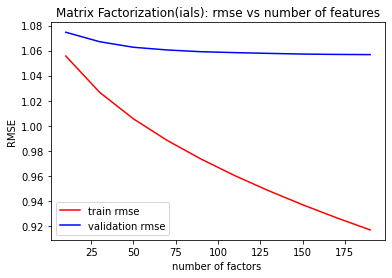

In [93]:
# optimal number of feature = 70
plt.plot(ials_k, ials_train_k, color= 'r' ,label='train rmse' )
plt.plot(ials_k,  ials_val_k, color= 'b',label='validation rmse' )
plt.xlabel('number of factors ')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs number of features')
plt.legend()
plt.show()

In [94]:
# hyperparameter tuning for confidence_scaling_factor 
num_scales = np.arange(1,200,2)
def test_scale_vals():
    scale_list = []
    train = []
    val = []
    for loc, scale in enumerate(num_scales):
        model = tc.ranking_factorization_recommender.create(train3,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials',num_factors = 70,\
                                                                   ials_confidence_scaling_factor = scale)
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        scale_list.append(scale)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return scale_list,train,val

In [95]:
ials_scale, ials_train_scale, ials_val_scale = test_scale_vals() 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.501275s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 133us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 1.81s        | 1.05151                   |

| 1       | 3.52s        | 1.00246                   |

| 2       | 5.28s        | 0.995331                  |

| 3       | 7.03s        | 0.992676                  |

| 4       | 8.81s        | 0.991321                  |

| 5       | 10.59s       | 0.99051                   |

| 6       | 12.49s       | 0.989977                  |

| 7       | 14.33s       | 0.989605                  |

| 8       | 16.19s       | 0.989333                  |

| 9       | 18.11s       | 0.989128                  |

| 10      | 20.02s       | 0.988968                  |

| 11      | 21.99s       | 0.988842                  |

| 12      | 24.00s       | 0.98874                   |

| 13      | 25.98s       | 0.988656                  |

| 14      | 27.97s       | 0.988587                  |

| 15      | 29.98s       | 0.988529                  |

| 16      | 31.98s       | 0.98848                   |

| 17      | 34.02s       | 0.988438                  |

| 18      | 36.08s       | 0.988401                  |

| 19      | 38.12s       | 0.98837                   |

| 20      | 40.16s       | 0.988343                  |

| 21      | 42.23s       | 0.988319                  |

| 22      | 44.32s       | 0.988298                  |

| 23      | 46.41s       | 0.988279                  |

| 24      | 48.51s       | 0.988262                  |

| FINAL   | 48.51s       | 0.988262                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 2008.75

recommendations finished on 2000/37283 queries. users per second: 1957.59

recommendations finished on 3000/37283 queries. users per second: 1938.21

recommendations finished on 4000/37283 queries. users per second: 1908.45

recommendations finished on 5000/37283 queries. users per second: 1908.16

recommendations finished on 6000/37283 queries. users per second: 1902.15

recommendations finished on 7000/37283 queries. users per second: 1890.7

recommendations finished on 8000/37283 queries. users per second: 1888.96

recommendations finished on 9000/37283 queries. users per second: 1888.48

recommendations finished on 10000/37283 queries. users per second: 1872.69

recommendations finished on 11000/37283 queries. users per second: 1875.77

recommendations finished on 12000/37283 queries. users per second: 1877.57

recommendations finished on 13000/37283 queries. users per second: 1877.33

recommendations finished on 14000/37283 queries. users per second: 1879.04

recommendations finished on 15000/37283 queries. users per second: 1880.35

recommendations finished on 16000/37283 queries. users per second: 1879.99

recommendations finished on 17000/37283 queries. users per second: 1878.13

recommendations finished on 18000/37283 queries. users per second: 1877.03

recommendations finished on 19000/37283 queries. users per second: 1875.12

recommendations finished on 20000/37283 queries. users per second: 1875.1

recommendations finished on 21000/37283 queries. users per second: 1872.93

recommendations finished on 22000/37283 queries. users per second: 1868.84

recommendations finished on 23000/37283 queries. users per second: 1866.86

recommendations finished on 24000/37283 queries. users per second: 1866.19

recommendations finished on 25000/37283 queries. users per second: 1864.84

recommendations finished on 26000/37283 queries. users per second: 1864.22

recommendations finished on 27000/37283 queries. users per second: 1863.63

recommendations finished on 28000/37283 queries. users per second: 1862.46

recommendations finished on 29000/37283 queries. users per second: 1861.95

recommendations finished on 30000/37283 queries. users per second: 1861.46

recommendations finished on 31000/37283 queries. users per second: 1861.94

recommendations finished on 32000/37283 queries. users per second: 1860.83

recommendations finished on 33000/37283 queries. users per second: 1860.64

recommendations finished on 34000/37283 queries. users per second: 1860.86

recommendations finished on 35000/37283 queries. users per second: 1859.82

recommendations finished on 36000/37283 queries. users per second: 1859.63

recommendations finished on 37000/37283 queries. users per second: 1859.85


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.701418877236274  | 0.06441607630772081 |
|   2    |  0.5952981251508743 | 0.10510209203924803 |
|   3    |  0.5107421613067634 |  0.1312402133885725 |
|   4    | 0.44405627229568456 | 0.14863714604144646 |
|   5    |  0.3928117372529046 | 0.16148330354206722 |
|   6    |  0.3530071793221215 | 0.17207098052364972 |
|   7    |  0.3212609347040588 |  0.1811099025188741 |
|   8    | 0.29556701445699046 | 0.18914556954613618 |
|   9    |  0.2740242052529167 | 0.19627641446086266 |
|   10   |  0.2556151597242725 |   0.20256950985032  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9882623886457192

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.460013s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 92us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.53s        | 1.01606                   |

| 1       | 5.35s        | 0.957648                  |

| 2       | 7.66s        | 0.946039                  |

| 3       | 9.87s        | 0.941223                  |

| 4       | 12.08s       | 0.938771                  |

| 5       | 14.46s       | 0.937352                  |

| 6       | 16.70s       | 0.936451                  |

| 7       | 18.89s       | 0.935839                  |

| 8       | 21.63s       | 0.935401                  |

| 9       | 24.34s       | 0.935075                  |

| 10      | 27.07s       | 0.934824                  |

| 11      | 30.14s       | 0.934625                  |

| 12      | 33.42s       | 0.934465                  |

| 13      | 35.96s       | 0.934333                  |

| 14      | 38.22s       | 0.934223                  |

| 15      | 40.45s       | 0.934131                  |

| 16      | 42.68s       | 0.934051                  |

| 17      | 45.14s       | 0.933983                  |

| 18      | 47.84s       | 0.933923                  |

| 19      | 50.26s       | 0.933871                  |

| 20      | 52.48s       | 0.933825                  |

| 21      | 54.69s       | 0.933785                  |

| 22      | 56.96s       | 0.933748                  |

| 23      | 59.20s       | 0.933716                  |

| 24      | 1m 1s        | 0.933686                  |

| FINAL   | 1m 1s        | 0.933686                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1909.18

recommendations finished on 2000/37283 queries. users per second: 1920.93

recommendations finished on 3000/37283 queries. users per second: 1931.08

recommendations finished on 4000/37283 queries. users per second: 1926.69

recommendations finished on 5000/37283 queries. users per second: 1923.02

recommendations finished on 6000/37283 queries. users per second: 1918.97

recommendations finished on 7000/37283 queries. users per second: 1905.19

recommendations finished on 8000/37283 queries. users per second: 1906.98

recommendations finished on 9000/37283 queries. users per second: 1909

recommendations finished on 10000/37283 queries. users per second: 1909.2

recommendations finished on 11000/37283 queries. users per second: 1909.93

recommendations finished on 12000/37283 queries. users per second: 1907.37

recommendations finished on 13000/37283 queries. users per second: 1906.63

recommendations finished on 14000/37283 queries. users per second: 1906.25

recommendations finished on 15000/37283 queries. users per second: 1904.53

recommendations finished on 16000/37283 queries. users per second: 1903.71

recommendations finished on 17000/37283 queries. users per second: 1903.69

recommendations finished on 18000/37283 queries. users per second: 1901.79

recommendations finished on 19000/37283 queries. users per second: 1902.05

recommendations finished on 20000/37283 queries. users per second: 1899.68

recommendations finished on 21000/37283 queries. users per second: 1898.1

recommendations finished on 22000/37283 queries. users per second: 1894.83

recommendations finished on 23000/37283 queries. users per second: 1894.48

recommendations finished on 24000/37283 queries. users per second: 1892.75

recommendations finished on 25000/37283 queries. users per second: 1891.93

recommendations finished on 26000/37283 queries. users per second: 1891.59

recommendations finished on 27000/37283 queries. users per second: 1890.88

recommendations finished on 28000/37283 queries. users per second: 1890.26

recommendations finished on 29000/37283 queries. users per second: 1889.12

recommendations finished on 30000/37283 queries. users per second: 1888.08

recommendations finished on 31000/37283 queries. users per second: 1887.84

recommendations finished on 32000/37283 queries. users per second: 1887.4

recommendations finished on 33000/37283 queries. users per second: 1886.1

recommendations finished on 34000/37283 queries. users per second: 1885.87

recommendations finished on 35000/37283 queries. users per second: 1884.78

recommendations finished on 36000/37283 queries. users per second: 1883.36

recommendations finished on 37000/37283 queries. users per second: 1883.07


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.7241906498940532 | 0.06885580183440329 |
|   2    |  0.6130407960732771 | 0.11214718799176875 |
|   3    |  0.530420477608205  | 0.14153830914401214 |
|   4    |  0.4660099777378432 | 0.16202256905299078 |
|   5    |  0.4183032481291748 | 0.17882702944604512 |
|   6    |  0.3804191365144085 |  0.1925182283370471 |
|   7    |  0.3498607178300356 | 0.20438548284652808 |
|   8    |  0.3241758978622966 | 0.21466284043923756 |
|   9    | 0.30294414791370466 | 0.22405148321788462 |
|   10   |  0.2846283829091003 | 0.23249835024312304 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9336864359809741

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.468568s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 107us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.47s        | 0.99268                   |

| 1       | 4.77s        | 0.924288                  |

| 2       | 7.56s        | 0.909604                  |

| 3       | 10.40s       | 0.903578                  |

| 4       | 13.29s       | 0.900524                  |

| 5       | 16.02s       | 0.898744                  |

| 6       | 18.56s       | 0.897598                  |

| 7       | 21.04s       | 0.896805                  |

| 8       | 23.54s       | 0.896229                  |

| 9       | 26.03s       | 0.895794                  |

| 10      | 28.64s       | 0.895455                  |

| 11      | 31.36s       | 0.895186                  |

| 12      | 34.22s       | 0.894969                  |

| 13      | 36.83s       | 0.89479                   |

| 14      | 39.28s       | 0.894641                  |

| 15      | 42.15s       | 0.894516                  |

| 16      | 45.13s       | 0.894409                  |

| 17      | 47.77s       | 0.894317                  |

| 18      | 50.07s       | 0.894238                  |

| 19      | 52.34s       | 0.894168                  |

| 20      | 54.61s       | 0.894107                  |

| 21      | 56.90s       | 0.894053                  |

| 22      | 59.20s       | 0.894004                  |

| 23      | 1m 1s        | 0.893961                  |

| 24      | 1m 3s        | 0.893922                  |

| FINAL   | 1m 3s        | 0.893922                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1830.59

recommendations finished on 2000/37283 queries. users per second: 1819

recommendations finished on 3000/37283 queries. users per second: 1814.49

recommendations finished on 4000/37283 queries. users per second: 1816.93

recommendations finished on 5000/37283 queries. users per second: 1801.92

recommendations finished on 6000/37283 queries. users per second: 1800.32

recommendations finished on 7000/37283 queries. users per second: 1800.03

recommendations finished on 8000/37283 queries. users per second: 1800.61

recommendations finished on 9000/37283 queries. users per second: 1799.45

recommendations finished on 10000/37283 queries. users per second: 1798.66

recommendations finished on 11000/37283 queries. users per second: 1797.35

recommendations finished on 12000/37283 queries. users per second: 1795.68

recommendations finished on 13000/37283 queries. users per second: 1795.26

recommendations finished on 14000/37283 queries. users per second: 1793.01

recommendations finished on 15000/37283 queries. users per second: 1791.63

recommendations finished on 16000/37283 queries. users per second: 1789.36

recommendations finished on 17000/37283 queries. users per second: 1787.97

recommendations finished on 18000/37283 queries. users per second: 1783.29

recommendations finished on 19000/37283 queries. users per second: 1782.14

recommendations finished on 20000/37283 queries. users per second: 1781.27

recommendations finished on 21000/37283 queries. users per second: 1779.71

recommendations finished on 22000/37283 queries. users per second: 1777.85

recommendations finished on 23000/37283 queries. users per second: 1776.11

recommendations finished on 24000/37283 queries. users per second: 1776.31

recommendations finished on 25000/37283 queries. users per second: 1775.62

recommendations finished on 26000/37283 queries. users per second: 1774.42

recommendations finished on 27000/37283 queries. users per second: 1772.49

recommendations finished on 28000/37283 queries. users per second: 1771.16

recommendations finished on 29000/37283 queries. users per second: 1770.49

recommendations finished on 30000/37283 queries. users per second: 1769.49

recommendations finished on 31000/37283 queries. users per second: 1768.87

recommendations finished on 32000/37283 queries. users per second: 1768.26

recommendations finished on 33000/37283 queries. users per second: 1767.36

recommendations finished on 34000/37283 queries. users per second: 1766.54

recommendations finished on 35000/37283 queries. users per second: 1764.61

recommendations finished on 36000/37283 queries. users per second: 1763.98

recommendations finished on 37000/37283 queries. users per second: 1762.76


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.7110479306922728 | 0.06942307133279138 |
|   2    |  0.6023522785183599 | 0.11313365369756664 |
|   3    |  0.5244391992775954 |  0.1435306273376364 |
|   4    |  0.4650645066115926 | 0.16605515613865246 |
|   5    |  0.4206903950862315 |  0.1846957515556167 |
|   6    |  0.3861232554604895 | 0.20032746727768852 |
|   7    |  0.3574321502331585 | 0.21401420266978674 |
|   8    |  0.3333422739586403 | 0.22594880520292296 |
|   9    | 0.31272817220836535 |  0.2365239649992165 |
|   10   | 0.29510768983182584 | 0.24614800888717034 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.893921844407219

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.481325s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 111us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.45s        | 0.973224                  |

| 1       | 4.77s        | 0.895902                  |

| 2       | 7.09s        | 0.879632                  |

| 3       | 9.41s        | 0.872941                  |

| 4       | 11.68s       | 0.869486                  |

| 5       | 14.18s       | 0.867451                  |

| 6       | 16.48s       | 0.866142                  |

| 7       | 19.07s       | 0.865243                  |

| 8       | 22.00s       | 0.864595                  |

| 9       | 24.53s       | 0.864107                  |

| 10      | 26.79s       | 0.86373                   |

| 11      | 29.06s       | 0.863431                  |

| 12      | 31.34s       | 0.863188                  |

| 13      | 33.61s       | 0.862988                  |

| 14      | 35.89s       | 0.862821                  |

| 15      | 38.15s       | 0.862679                  |

| 16      | 40.38s       | 0.862558                  |

| 17      | 42.64s       | 0.862453                  |

| 18      | 45.10s       | 0.862362                  |

| 19      | 47.34s       | 0.862282                  |

| 20      | 49.57s       | 0.862211                  |

| 21      | 51.79s       | 0.862148                  |

| 22      | 54.01s       | 0.862092                  |

| 23      | 56.22s       | 0.862041                  |

| 24      | 58.45s       | 0.861995                  |

| FINAL   | 58.45s       | 0.861995                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1871.09

recommendations finished on 2000/37283 queries. users per second: 1838.69

recommendations finished on 3000/37283 queries. users per second: 1831.79

recommendations finished on 4000/37283 queries. users per second: 1831.97

recommendations finished on 5000/37283 queries. users per second: 1828.03

recommendations finished on 6000/37283 queries. users per second: 1816.65

recommendations finished on 7000/37283 queries. users per second: 1818.3

recommendations finished on 8000/37283 queries. users per second: 1817.81

recommendations finished on 9000/37283 queries. users per second: 1815.35

recommendations finished on 10000/37283 queries. users per second: 1815.02

recommendations finished on 11000/37283 queries. users per second: 1801.17

recommendations finished on 12000/37283 queries. users per second: 1801.41

recommendations finished on 13000/37283 queries. users per second: 1801.13

recommendations finished on 14000/37283 queries. users per second: 1800.8

recommendations finished on 15000/37283 queries. users per second: 1799.85

recommendations finished on 16000/37283 queries. users per second: 1798.4

recommendations finished on 17000/37283 queries. users per second: 1798.49

recommendations finished on 18000/37283 queries. users per second: 1797.93

recommendations finished on 19000/37283 queries. users per second: 1796.29

recommendations finished on 20000/37283 queries. users per second: 1795.65

recommendations finished on 21000/37283 queries. users per second: 1795.67

recommendations finished on 22000/37283 queries. users per second: 1794.46

recommendations finished on 23000/37283 queries. users per second: 1792.08

recommendations finished on 24000/37283 queries. users per second: 1790.86

recommendations finished on 25000/37283 queries. users per second: 1790.47

recommendations finished on 26000/37283 queries. users per second: 1789.61

recommendations finished on 27000/37283 queries. users per second: 1788.92

recommendations finished on 28000/37283 queries. users per second: 1787.11

recommendations finished on 29000/37283 queries. users per second: 1786.44

recommendations finished on 30000/37283 queries. users per second: 1785.03

recommendations finished on 31000/37283 queries. users per second: 1785.05

recommendations finished on 32000/37283 queries. users per second: 1784.7

recommendations finished on 33000/37283 queries. users per second: 1784.55

recommendations finished on 34000/37283 queries. users per second: 1784.62

recommendations finished on 35000/37283 queries. users per second: 1783.84

recommendations finished on 36000/37283 queries. users per second: 1783.28

recommendations finished on 37000/37283 queries. users per second: 1782.56


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.6952766676501346 | 0.06962644229960713 |
|   2    |  0.5913418984523788 | 0.11365913635485836 |
|   3    |  0.5166787365108303 | 0.14438957807134603 |
|   4    | 0.46144355336212217 |  0.1681091446221613 |
|   5    | 0.42069039508623207 | 0.18826504347227666 |
|   6    |  0.387419646130051  |  0.2051021376664729 |
|   7    |  0.3601334963081604 | 0.21961697613433528 |
|   8    |  0.337016870959955  | 0.23240326674917325 |
|   9    |  0.3174309411200212 | 0.24392321270999895 |
|   10   | 0.30028162969718136 | 0.25433636192863507 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.8619954407223405

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.47887s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 92us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.41s        | 0.95328                   |

| 1       | 4.68s        | 0.872706                  |

| 2       | 6.97s        | 0.854778                  |

| 3       | 9.29s        | 0.84727                   |

| 4       | 11.54s       | 0.8434                    |

| 5       | 13.77s       | 0.841131                  |

| 6       | 15.99s       | 0.839671                  |

| 7       | 18.28s       | 0.838665                  |

| 8       | 20.50s       | 0.837936                  |

| 9       | 22.72s       | 0.837387                  |

| 10      | 24.94s       | 0.836962                  |

| 11      | 27.17s       | 0.836624                  |

| 12      | 29.40s       | 0.836351                  |

| 13      | 31.59s       | 0.836127                  |

| 14      | 33.80s       | 0.835941                  |

| 15      | 36.01s       | 0.835784                  |

| 16      | 38.20s       | 0.83565                   |

| 17      | 40.40s       | 0.835536                  |

| 18      | 42.59s       | 0.835436                  |

| 19      | 44.77s       | 0.83535                   |

| 20      | 46.96s       | 0.835274                  |

| 21      | 49.14s       | 0.835207                  |

| 22      | 51.33s       | 0.835147                  |

| 23      | 53.50s       | 0.835094                  |

| 24      | 55.68s       | 0.835046                  |

| FINAL   | 55.68s       | 0.835046                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1937.42

recommendations finished on 2000/37283 queries. users per second: 1903.42

recommendations finished on 3000/37283 queries. users per second: 1881.75

recommendations finished on 4000/37283 queries. users per second: 1885.26

recommendations finished on 5000/37283 queries. users per second: 1884.01

recommendations finished on 6000/37283 queries. users per second: 1877.56

recommendations finished on 7000/37283 queries. users per second: 1874.78

recommendations finished on 8000/37283 queries. users per second: 1876.72

recommendations finished on 9000/37283 queries. users per second: 1877.3

recommendations finished on 10000/37283 queries. users per second: 1874.85

recommendations finished on 11000/37283 queries. users per second: 1874.89

recommendations finished on 12000/37283 queries. users per second: 1872.53

recommendations finished on 13000/37283 queries. users per second: 1870.17

recommendations finished on 14000/37283 queries. users per second: 1869.09

recommendations finished on 15000/37283 queries. users per second: 1866.4

recommendations finished on 16000/37283 queries. users per second: 1863.35

recommendations finished on 17000/37283 queries. users per second: 1860.1

recommendations finished on 18000/37283 queries. users per second: 1858.42

recommendations finished on 19000/37283 queries. users per second: 1858.25

recommendations finished on 20000/37283 queries. users per second: 1854.82

recommendations finished on 21000/37283 queries. users per second: 1853.33

recommendations finished on 22000/37283 queries. users per second: 1851.78

recommendations finished on 23000/37283 queries. users per second: 1847.28

recommendations finished on 24000/37283 queries. users per second: 1848.12

recommendations finished on 25000/37283 queries. users per second: 1847.36

recommendations finished on 26000/37283 queries. users per second: 1847.03

recommendations finished on 27000/37283 queries. users per second: 1847.07

recommendations finished on 28000/37283 queries. users per second: 1846.55

recommendations finished on 29000/37283 queries. users per second: 1847.02

recommendations finished on 30000/37283 queries. users per second: 1846.37

recommendations finished on 31000/37283 queries. users per second: 1846.04

recommendations finished on 32000/37283 queries. users per second: 1845.72

recommendations finished on 33000/37283 queries. users per second: 1844.78

recommendations finished on 34000/37283 queries. users per second: 1844.2

recommendations finished on 35000/37283 queries. users per second: 1843.64

recommendations finished on 36000/37283 queries. users per second: 1841.39

recommendations finished on 37000/37283 queries. users per second: 1840.73


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.676367245125125  | 0.06916441510467934 |
|   2    |  0.5779846042432192 | 0.11320364822904168 |
|   3    |  0.5086500549848443 | 0.14474277612509034 |
|   4    |  0.4572392243113481 | 0.16956136960619259 |
|   5    | 0.41801893624440034 | 0.19022934113789255 |
|   6    | 0.38639594453236026 | 0.20772577359339375 |
|   7    | 0.36054348784011153 | 0.22338728259658167 |
|   8    |  0.3383311428801326 | 0.23688836537259203 |
|   9    | 0.31928463076707514 | 0.24893211758484352 |
|   10   |  0.3026044041520266 | 0.25994865530407063 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.8350462298612565

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.595483s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 95us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.02s        | 0.937288                  |

| 1       | 5.93s        | 0.851488                  |

| 2       | 8.39s        | 0.832631                  |

| 3       | 10.66s       | 0.824797                  |

| 4       | 12.90s       | 0.820757                  |

| 5       | 15.14s       | 0.818366                  |

| 6       | 17.44s       | 0.816815                  |

| 7       | 20.31s       | 0.815741                  |

| 8       | 23.14s       | 0.814959                  |

| 9       | 25.45s       | 0.814369                  |

| 10      | 27.65s       | 0.81391                   |

| 11      | 29.86s       | 0.813543                  |

| 12      | 32.06s       | 0.813245                  |

| 13      | 34.28s       | 0.812999                  |

| 14      | 36.52s       | 0.812792                  |

| 15      | 38.68s       | 0.812617                  |

| 16      | 40.89s       | 0.812466                  |

| 17      | 43.10s       | 0.812335                  |

| 18      | 45.29s       | 0.812221                  |

| 19      | 47.48s       | 0.812121                  |

| 20      | 49.65s       | 0.812033                  |

| 21      | 51.86s       | 0.811954                  |

| 22      | 54.16s       | 0.811883                  |

| 23      | 56.33s       | 0.811819                  |

| 24      | 58.52s       | 0.811762                  |

| FINAL   | 58.52s       | 0.811762                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1961.84

recommendations finished on 2000/37283 queries. users per second: 1933.6

recommendations finished on 3000/37283 queries. users per second: 1918.04

recommendations finished on 4000/37283 queries. users per second: 1913.28

recommendations finished on 5000/37283 queries. users per second: 1880.92

recommendations finished on 6000/37283 queries. users per second: 1871.43

recommendations finished on 7000/37283 queries. users per second: 1875.88

recommendations finished on 8000/37283 queries. users per second: 1877.32

recommendations finished on 9000/37283 queries. users per second: 1864.3

recommendations finished on 10000/37283 queries. users per second: 1861.36

recommendations finished on 11000/37283 queries. users per second: 1861.69

recommendations finished on 12000/37283 queries. users per second: 1858.98

recommendations finished on 13000/37283 queries. users per second: 1859.15

recommendations finished on 14000/37283 queries. users per second: 1856.46

recommendations finished on 15000/37283 queries. users per second: 1856.97

recommendations finished on 16000/37283 queries. users per second: 1857.32

recommendations finished on 17000/37283 queries. users per second: 1858.07

recommendations finished on 18000/37283 queries. users per second: 1855.82

recommendations finished on 19000/37283 queries. users per second: 1856.06

recommendations finished on 20000/37283 queries. users per second: 1852.24

recommendations finished on 21000/37283 queries. users per second: 1848.43

recommendations finished on 22000/37283 queries. users per second: 1846.3

recommendations finished on 23000/37283 queries. users per second: 1843.82

recommendations finished on 24000/37283 queries. users per second: 1843.06

recommendations finished on 25000/37283 queries. users per second: 1843.38

recommendations finished on 26000/37283 queries. users per second: 1843.44

recommendations finished on 27000/37283 queries. users per second: 1844.31

recommendations finished on 28000/37283 queries. users per second: 1843.69

recommendations finished on 29000/37283 queries. users per second: 1843.36

recommendations finished on 30000/37283 queries. users per second: 1838.02

recommendations finished on 31000/37283 queries. users per second: 1838.2

recommendations finished on 32000/37283 queries. users per second: 1838.56

recommendations finished on 33000/37283 queries. users per second: 1838.43

recommendations finished on 34000/37283 queries. users per second: 1838.86

recommendations finished on 35000/37283 queries. users per second: 1839.15

recommendations finished on 36000/37283 queries. users per second: 1839.44

recommendations finished on 37000/37283 queries. users per second: 1840.31


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.6603277633237665 | 0.06891019079450426 |
|   2    |  0.5672960866883016 | 0.11310586316689068 |
|   3    |  0.501998229756191  |  0.1452482829835255 |
|   4    |  0.452746560094413  | 0.17058164119280958 |
|   5    | 0.41562106053697234 | 0.19192104372857996 |
|   6    |  0.3855287038775494 |  0.2100734979222649 |
|   7    | 0.36053582444698984 | 0.22622873025702908 |
|   8    |  0.3391760319716761 | 0.24047016990866363 |
|   9    |  0.3204081693473641 |  0.252918670048269  |
|   10   |  0.3040742429525518 | 0.26427943781250135 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.8117621157341383

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.45659s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 97us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.35s        | 0.922903                  |

| 1       | 4.59s        | 0.833041                  |

| 2       | 6.83s        | 0.813375                  |

| 3       | 9.05s        | 0.805113                  |

| 4       | 11.23s       | 0.80082                   |

| 5       | 13.42s       | 0.798276                  |

| 6       | 15.60s       | 0.796626                  |

| 7       | 17.79s       | 0.795482                  |

| 8       | 20.01s       | 0.794648                  |

| 9       | 22.19s       | 0.794017                  |

| 10      | 24.33s       | 0.793524                  |

| 11      | 26.49s       | 0.793129                  |

| 12      | 28.67s       | 0.792807                  |

| 13      | 30.82s       | 0.792541                  |

| 14      | 33.01s       | 0.792317                  |

| 15      | 35.19s       | 0.792127                  |

| 16      | 37.36s       | 0.791963                  |

| 17      | 39.53s       | 0.791821                  |

| 18      | 41.69s       | 0.791697                  |

| 19      | 43.86s       | 0.791587                  |

| 20      | 46.05s       | 0.791489                  |

| 21      | 48.22s       | 0.791402                  |

| 22      | 50.39s       | 0.791323                  |

| 23      | 52.54s       | 0.791252                  |

| 24      | 54.69s       | 0.791188                  |

| FINAL   | 54.69s       | 0.791188                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1913.95

recommendations finished on 2000/37283 queries. users per second: 1710.89

recommendations finished on 3000/37283 queries. users per second: 1604.84

recommendations finished on 4000/37283 queries. users per second: 1554.91

recommendations finished on 5000/37283 queries. users per second: 1598.76

recommendations finished on 6000/37283 queries. users per second: 1630.27

recommendations finished on 7000/37283 queries. users per second: 1657.12

recommendations finished on 8000/37283 queries. users per second: 1678.24

recommendations finished on 9000/37283 queries. users per second: 1694.72

recommendations finished on 10000/37283 queries. users per second: 1703.23

recommendations finished on 11000/37283 queries. users per second: 1702.85

recommendations finished on 12000/37283 queries. users per second: 1712.37

recommendations finished on 13000/37283 queries. users per second: 1712.95

recommendations finished on 14000/37283 queries. users per second: 1720.38

recommendations finished on 15000/37283 queries. users per second: 1724.51

recommendations finished on 16000/37283 queries. users per second: 1728.61

recommendations finished on 17000/37283 queries. users per second: 1734.11

recommendations finished on 18000/37283 queries. users per second: 1735.69

recommendations finished on 19000/37283 queries. users per second: 1738.57

recommendations finished on 20000/37283 queries. users per second: 1737.39

recommendations finished on 21000/37283 queries. users per second: 1739.93

recommendations finished on 22000/37283 queries. users per second: 1740

recommendations finished on 23000/37283 queries. users per second: 1742.01

recommendations finished on 24000/37283 queries. users per second: 1742.9

recommendations finished on 25000/37283 queries. users per second: 1746.36

recommendations finished on 26000/37283 queries. users per second: 1748.67

recommendations finished on 27000/37283 queries. users per second: 1751.07

recommendations finished on 28000/37283 queries. users per second: 1753

recommendations finished on 29000/37283 queries. users per second: 1751.8

recommendations finished on 30000/37283 queries. users per second: 1753.26

recommendations finished on 31000/37283 queries. users per second: 1752.3

recommendations finished on 32000/37283 queries. users per second: 1753.76

recommendations finished on 33000/37283 queries. users per second: 1754.71

recommendations finished on 34000/37283 queries. users per second: 1755.4

recommendations finished on 35000/37283 queries. users per second: 1756.67

recommendations finished on 36000/37283 queries. users per second: 1756.39

recommendations finished on 37000/37283 queries. users per second: 1756.34


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.6385752219510219 | 0.06756374374885248 |
|   2    |  0.5555883378483455 | 0.11231894720628208 |
|   3    |  0.4925658700569504 |  0.1444567760048326 |
|   4    |  0.4475297052275834 |  0.1707269361277036 |
|   5    |  0.4114851272697999 | 0.19216769944537318 |
|   6    | 0.38255594596286063 | 0.21098301402957245 |
|   7    |  0.3591219284162444 | 0.22806389700367358 |
|   8    |  0.3385088378081167 |  0.242875829517509  |
|   9    | 0.32029194121836835 |  0.2557664317834231 |
|   10   |  0.3043961054636158 | 0.26757732666004697 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7911877617232351

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.468629s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 91us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.36s        | 0.909421                  |

| 1       | 4.59s        | 0.816365                  |

| 2       | 6.85s        | 0.796181                  |

| 3       | 9.11s        | 0.787603                  |

| 4       | 11.30s       | 0.783088                  |

| 5       | 13.46s       | 0.780379                  |

| 6       | 15.67s       | 0.778605                  |

| 7       | 17.86s       | 0.777367                  |

| 8       | 20.21s       | 0.776461                  |

| 9       | 23.03s       | 0.775772                  |

| 10      | 25.59s       | 0.775233                  |

| 11      | 28.03s       | 0.774801                  |

| 12      | 30.29s       | 0.774448                  |

| 13      | 32.46s       | 0.774155                  |

| 14      | 34.63s       | 0.773909                  |

| 15      | 36.97s       | 0.7737                    |

| 16      | 39.51s       | 0.773521                  |

| 17      | 41.69s       | 0.773365                  |

| 18      | 43.86s       | 0.77323                   |

| 19      | 46.07s       | 0.773111                  |

| 20      | 48.26s       | 0.773006                  |

| 21      | 50.42s       | 0.772913                  |

| 22      | 52.56s       | 0.77283                   |

| 23      | 54.73s       | 0.772755                  |

| 24      | 57.03s       | 0.772687                  |

| FINAL   | 57.03s       | 0.772687                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1596.36

recommendations finished on 2000/37283 queries. users per second: 1418.55

recommendations finished on 3000/37283 queries. users per second: 1464.54

recommendations finished on 4000/37283 queries. users per second: 1513.92

recommendations finished on 5000/37283 queries. users per second: 1570.01

recommendations finished on 6000/37283 queries. users per second: 1611.67

recommendations finished on 7000/37283 queries. users per second: 1643.69

recommendations finished on 8000/37283 queries. users per second: 1669.62

recommendations finished on 9000/37283 queries. users per second: 1691.75

recommendations finished on 10000/37283 queries. users per second: 1704.53

recommendations finished on 11000/37283 queries. users per second: 1718.43

recommendations finished on 12000/37283 queries. users per second: 1728.7

recommendations finished on 13000/37283 queries. users per second: 1732.84

recommendations finished on 14000/37283 queries. users per second: 1741.19

recommendations finished on 15000/37283 queries. users per second: 1747.43

recommendations finished on 16000/37283 queries. users per second: 1753.57

recommendations finished on 17000/37283 queries. users per second: 1759.45

recommendations finished on 18000/37283 queries. users per second: 1763.07

recommendations finished on 19000/37283 queries. users per second: 1766.97

recommendations finished on 20000/37283 queries. users per second: 1770.3

recommendations finished on 21000/37283 queries. users per second: 1774.08

recommendations finished on 22000/37283 queries. users per second: 1775.9

recommendations finished on 23000/37283 queries. users per second: 1778.61

recommendations finished on 24000/37283 queries. users per second: 1781.32

recommendations finished on 25000/37283 queries. users per second: 1783.97

recommendations finished on 26000/37283 queries. users per second: 1786.96

recommendations finished on 27000/37283 queries. users per second: 1789.48

recommendations finished on 28000/37283 queries. users per second: 1791.45

recommendations finished on 29000/37283 queries. users per second: 1791.77

recommendations finished on 30000/37283 queries. users per second: 1793.6

recommendations finished on 31000/37283 queries. users per second: 1794.72

recommendations finished on 32000/37283 queries. users per second: 1796.03

recommendations finished on 33000/37283 queries. users per second: 1796.41

recommendations finished on 34000/37283 queries. users per second: 1796.67

recommendations finished on 35000/37283 queries. users per second: 1797.86

recommendations finished on 36000/37283 queries. users per second: 1798.58

recommendations finished on 37000/37283 queries. users per second: 1798.84


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.6186733900168966 | 0.06654138576232711 |
|   2    |  0.5417482498725948 | 0.11109733646912621 |
|   3    | 0.48313351035771307 | 0.14356879957215793 |
|   4    |  0.4406700104605315 | 0.17031032532080403 |
|   5    |  0.4074296596303944 | 0.19296570663612658 |
|   6    | 0.37986481774535313 | 0.21212718407632394 |
|   7    |  0.3574474770193994 | 0.22986501149721011 |
|   8    | 0.33695652173913043 | 0.24451189513723154 |
|   9    | 0.31997603912417577 | 0.25829758468606373 |
|   10   | 0.30475820078856275 |  0.2705666527404141 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7726874036761117

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.470255s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 100us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.40s        | 0.897089                  |

| 1       | 4.59s        | 0.801236                  |

| 2       | 6.79s        | 0.780122                  |

| 3       | 8.96s        | 0.771212                  |

| 4       | 11.18s       | 0.766594                  |

| 5       | 13.37s       | 0.763845                  |

| 6       | 15.54s       | 0.762045                  |

| 7       | 17.73s       | 0.760785                  |

| 8       | 19.89s       | 0.759859                  |

| 9       | 22.06s       | 0.759153                  |

| 10      | 24.21s       | 0.758599                  |

| 11      | 26.37s       | 0.758154                  |

| 12      | 28.54s       | 0.757791                  |

| 13      | 30.73s       | 0.757488                  |

| 14      | 32.91s       | 0.757234                  |

| 15      | 35.11s       | 0.757018                  |

| 16      | 37.36s       | 0.756832                  |

| 17      | 40.26s       | 0.756672                  |

| 18      | 42.74s       | 0.756532                  |

| 19      | 45.74s       | 0.756409                  |

| 20      | 48.13s       | 0.7563                    |

| 21      | 50.71s       | 0.756203                  |

| 22      | 52.94s       | 0.756117                  |

| 23      | 55.12s       | 0.756039                  |

| 24      | 57.31s       | 0.755969                  |

| FINAL   | 57.31s       | 0.755969                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1943.36

recommendations finished on 2000/37283 queries. users per second: 1897.05

recommendations finished on 3000/37283 queries. users per second: 1890.4

recommendations finished on 4000/37283 queries. users per second: 1886.24

recommendations finished on 5000/37283 queries. users per second: 1886.22

recommendations finished on 6000/37283 queries. users per second: 1883.17

recommendations finished on 7000/37283 queries. users per second: 1872.81

recommendations finished on 8000/37283 queries. users per second: 1873.3

recommendations finished on 9000/37283 queries. users per second: 1874.68

recommendations finished on 10000/37283 queries. users per second: 1873.28

recommendations finished on 11000/37283 queries. users per second: 1866.1

recommendations finished on 12000/37283 queries. users per second: 1861.6

recommendations finished on 13000/37283 queries. users per second: 1861.12

recommendations finished on 14000/37283 queries. users per second: 1860.86

recommendations finished on 15000/37283 queries. users per second: 1860.61

recommendations finished on 16000/37283 queries. users per second: 1860.62

recommendations finished on 17000/37283 queries. users per second: 1860.88

recommendations finished on 18000/37283 queries. users per second: 1860.79

recommendations finished on 19000/37283 queries. users per second: 1859.52

recommendations finished on 20000/37283 queries. users per second: 1857.25

recommendations finished on 21000/37283 queries. users per second: 1856.89

recommendations finished on 22000/37283 queries. users per second: 1856.27

recommendations finished on 23000/37283 queries. users per second: 1854.51

recommendations finished on 24000/37283 queries. users per second: 1853.9

recommendations finished on 25000/37283 queries. users per second: 1854.3

recommendations finished on 26000/37283 queries. users per second: 1854.23

recommendations finished on 27000/37283 queries. users per second: 1854.51

recommendations finished on 28000/37283 queries. users per second: 1854.08

recommendations finished on 29000/37283 queries. users per second: 1854.3

recommendations finished on 30000/37283 queries. users per second: 1853.61

recommendations finished on 31000/37283 queries. users per second: 1853.47

recommendations finished on 32000/37283 queries. users per second: 1852.69

recommendations finished on 33000/37283 queries. users per second: 1852.08

recommendations finished on 34000/37283 queries. users per second: 1851.22

recommendations finished on 35000/37283 queries. users per second: 1849.68

recommendations finished on 36000/37283 queries. users per second: 1849.53

recommendations finished on 37000/37283 queries. users per second: 1848.97


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.6123166054233827 | 0.06665091786627164 |
|   2    |  0.5370007778344017 | 0.11124387031349577 |
|   3    | 0.47986124149522974 | 0.14430969766367957 |
|   4    |  0.4389332939945812 | 0.17148692614657046 |
|   5    |  0.4068020277338206 |  0.1946357130221469 |
|   6    | 0.38022244275764644 |  0.2145627565690114 |
|   7    | 0.35841689624915163 |  0.2327469534443269 |
|   8    | 0.33863959445323527 | 0.24807218329847913 |
|   9    |  0.3216062131385458 | 0.26204827236306844 |
|   10   | 0.30670815116809486 |  0.274830472283611  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7559689949251281

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.469051s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 100us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.43s        | 0.888877                  |

| 1       | 4.67s        | 0.786751                  |

| 2       | 6.92s        | 0.76513                   |

| 3       | 9.16s        | 0.756089                  |

| 4       | 11.37s       | 0.751414                  |

| 5       | 13.56s       | 0.748636                  |

| 6       | 15.76s       | 0.74682                   |

| 7       | 17.95s       | 0.745549                  |

| 8       | 20.13s       | 0.744615                  |

| 9       | 23.02s       | 0.743902                  |

| 10      | 25.98s       | 0.743342                  |

| 11      | 28.25s       | 0.742892                  |

| 12      | 30.47s       | 0.742525                  |

| 13      | 32.70s       | 0.742219                  |

| 14      | 34.95s       | 0.741961                  |

| 15      | 37.24s       | 0.741742                  |

| 16      | 39.48s       | 0.741554                  |

| 17      | 41.65s       | 0.74139                   |

| 18      | 43.81s       | 0.741246                  |

| 19      | 45.99s       | 0.74112                   |

| 20      | 48.22s       | 0.741007                  |

| 21      | 50.37s       | 0.740907                  |

| 22      | 52.54s       | 0.740816                  |

| 23      | 54.70s       | 0.740735                  |

| 24      | 56.88s       | 0.740661                  |

| FINAL   | 56.88s       | 0.740661                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 2000.14

recommendations finished on 2000/37283 queries. users per second: 1967.2

recommendations finished on 3000/37283 queries. users per second: 1965.35

recommendations finished on 4000/37283 queries. users per second: 1961.96

recommendations finished on 5000/37283 queries. users per second: 1959.15

recommendations finished on 6000/37283 queries. users per second: 1950.28

recommendations finished on 7000/37283 queries. users per second: 1948.27

recommendations finished on 8000/37283 queries. users per second: 1945.97

recommendations finished on 9000/37283 queries. users per second: 1945.94

recommendations finished on 10000/37283 queries. users per second: 1942.85

recommendations finished on 11000/37283 queries. users per second: 1939.13

recommendations finished on 12000/37283 queries. users per second: 1935.68

recommendations finished on 13000/37283 queries. users per second: 1929.3

recommendations finished on 14000/37283 queries. users per second: 1924.56

recommendations finished on 15000/37283 queries. users per second: 1924.75

recommendations finished on 16000/37283 queries. users per second: 1923.93

recommendations finished on 17000/37283 queries. users per second: 1925.09

recommendations finished on 18000/37283 queries. users per second: 1924.18

recommendations finished on 19000/37283 queries. users per second: 1919.84

recommendations finished on 20000/37283 queries. users per second: 1917.44

recommendations finished on 21000/37283 queries. users per second: 1916.51

recommendations finished on 22000/37283 queries. users per second: 1914.85

recommendations finished on 23000/37283 queries. users per second: 1914.58

recommendations finished on 24000/37283 queries. users per second: 1914.44

recommendations finished on 25000/37283 queries. users per second: 1914.15

recommendations finished on 26000/37283 queries. users per second: 1913.78

recommendations finished on 27000/37283 queries. users per second: 1913.76

recommendations finished on 28000/37283 queries. users per second: 1912.06

recommendations finished on 29000/37283 queries. users per second: 1911.05

recommendations finished on 30000/37283 queries. users per second: 1910.79

recommendations finished on 31000/37283 queries. users per second: 1910.48

recommendations finished on 32000/37283 queries. users per second: 1908.94

recommendations finished on 33000/37283 queries. users per second: 1907.62

recommendations finished on 34000/37283 queries. users per second: 1907.43

recommendations finished on 35000/37283 queries. users per second: 1906.97

recommendations finished on 36000/37283 queries. users per second: 1905.46

recommendations finished on 37000/37283 queries. users per second: 1904.71


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5927098141243996 | 0.06551898908749086 |
|   2    |  0.522530375774482  | 0.10999437692337066 |
|   3    | 0.47062557555275386 |  0.143261672943676  |
|   4    |  0.4324222836145153 | 0.17089507571553278 |
|   5    | 0.40179170131159003 |  0.1942905786860524 |
|   6    | 0.37686076764208737 | 0.21479149317727425 |
|   7    |  0.3548993988068107 | 0.23279573761124808 |
|   8    | 0.33650054984845634 | 0.24895644553796914 |
|   9    | 0.32008630683629946 | 0.26342732218599935 |
|   10   | 0.30537778612236216 | 0.27621084575468197 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7406608868976332

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.460905s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 103us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.37s        | 0.876251                  |

| 1       | 4.59s        | 0.774311                  |

| 2       | 6.80s        | 0.752359                  |

| 3       | 8.97s        | 0.742887                  |

| 4       | 11.19s       | 0.737918                  |

| 5       | 13.41s       | 0.734955                  |

| 6       | 15.60s       | 0.73302                   |

| 7       | 17.78s       | 0.731671                  |

| 8       | 19.94s       | 0.730683                  |

| 9       | 22.32s       | 0.729933                  |

| 10      | 24.50s       | 0.729347                  |

| 11      | 26.67s       | 0.72888                   |

| 12      | 28.89s       | 0.728499                  |

| 13      | 31.05s       | 0.728183                  |

| 14      | 33.23s       | 0.727918                  |

| 15      | 35.41s       | 0.727693                  |

| 16      | 37.57s       | 0.7275                    |

| 17      | 39.72s       | 0.727332                  |

| 18      | 41.91s       | 0.727185                  |

| 19      | 44.09s       | 0.727055                  |

| 20      | 46.25s       | 0.72694                   |

| 21      | 48.44s       | 0.726837                  |

| 22      | 50.60s       | 0.726745                  |

| 23      | 52.77s       | 0.726662                  |

| 24      | 54.92s       | 0.726586                  |

| FINAL   | 54.92s       | 0.726586                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1974.53

recommendations finished on 2000/37283 queries. users per second: 1936.86

recommendations finished on 3000/37283 queries. users per second: 1927.86

recommendations finished on 4000/37283 queries. users per second: 1922.83

recommendations finished on 5000/37283 queries. users per second: 1911.38

recommendations finished on 6000/37283 queries. users per second: 1907.95

recommendations finished on 7000/37283 queries. users per second: 1907.54

recommendations finished on 8000/37283 queries. users per second: 1903.13

recommendations finished on 9000/37283 queries. users per second: 1902.4

recommendations finished on 10000/37283 queries. users per second: 1895.76

recommendations finished on 11000/37283 queries. users per second: 1895.42

recommendations finished on 12000/37283 queries. users per second: 1892.42

recommendations finished on 13000/37283 queries. users per second: 1891.65

recommendations finished on 14000/37283 queries. users per second: 1891.51

recommendations finished on 15000/37283 queries. users per second: 1888.15

recommendations finished on 16000/37283 queries. users per second: 1887.92

recommendations finished on 17000/37283 queries. users per second: 1888.4

recommendations finished on 18000/37283 queries. users per second: 1887.78

recommendations finished on 19000/37283 queries. users per second: 1887.82

recommendations finished on 20000/37283 queries. users per second: 1886.79

recommendations finished on 21000/37283 queries. users per second: 1886.72

recommendations finished on 22000/37283 queries. users per second: 1884.81

recommendations finished on 23000/37283 queries. users per second: 1883.56

recommendations finished on 24000/37283 queries. users per second: 1882.65

recommendations finished on 25000/37283 queries. users per second: 1881.93

recommendations finished on 26000/37283 queries. users per second: 1879.41

recommendations finished on 27000/37283 queries. users per second: 1878.51

recommendations finished on 28000/37283 queries. users per second: 1877.5

recommendations finished on 29000/37283 queries. users per second: 1875.4

recommendations finished on 30000/37283 queries. users per second: 1874.92

recommendations finished on 31000/37283 queries. users per second: 1874.46

recommendations finished on 32000/37283 queries. users per second: 1873.68

recommendations finished on 33000/37283 queries. users per second: 1872.42

recommendations finished on 34000/37283 queries. users per second: 1871.74

recommendations finished on 35000/37283 queries. users per second: 1868.72

recommendations finished on 36000/37283 queries. users per second: 1867.81

recommendations finished on 37000/37283 queries. users per second: 1866.22


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5830539387924788 | 0.06495599487336638 |
|   2    |  0.5185741490759859 | 0.10987569763022692 |
|   3    |  0.467684109826641  |  0.1436484507694569 |
|   4    |  0.4297199796153745 | 0.17152109870984264 |
|   5    | 0.39991416999704893 |  0.1953696324630111 |
|   6    | 0.37526039571207837 | 0.21623867975181524 |
|   7    | 0.35424801039156073 | 0.23446197065324353 |
|   8    | 0.33572606818120887 | 0.25061754108369966 |
|   9    |  0.3198955734964101 | 0.26537329663256587 |
|   10   |  0.3057371992597153 |  0.2786604522365759 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7265860199270741

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.463386s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 108us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.38s        | 0.864892                  |

| 1       | 4.59s        | 0.761863                  |

| 2       | 6.79s        | 0.739674                  |

| 3       | 8.99s        | 0.730142                  |

| 4       | 11.20s       | 0.725163                  |

| 5       | 13.44s       | 0.722193                  |

| 6       | 16.31s       | 0.720245                  |

| 7       | 19.47s       | 0.718877                  |

| 8       | 22.27s       | 0.717867                  |

| 9       | 24.50s       | 0.717093                  |

| 10      | 27.67s       | 0.716483                  |

| 11      | 32.09s       | 0.715992                  |

| 12      | 35.52s       | 0.71559                   |

| 13      | 38.43s       | 0.715256                  |

| 14      | 41.23s       | 0.714974                  |

| 15      | 43.48s       | 0.714735                  |

| 16      | 45.70s       | 0.71453                   |

| 17      | 47.92s       | 0.714352                  |

| 18      | 50.13s       | 0.714197                  |

| 19      | 52.34s       | 0.714061                  |

| 20      | 54.57s       | 0.71394                   |

| 21      | 56.78s       | 0.713833                  |

| 22      | 58.96s       | 0.713736                  |

| 23      | 1m 1s        | 0.71365                   |

| 24      | 1m 3s        | 0.713572                  |

| FINAL   | 1m 3s        | 0.713572                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1943.32

recommendations finished on 2000/37283 queries. users per second: 1912.19

recommendations finished on 3000/37283 queries. users per second: 1899.29

recommendations finished on 4000/37283 queries. users per second: 1893.74

recommendations finished on 5000/37283 queries. users per second: 1891.72

recommendations finished on 6000/37283 queries. users per second: 1884.01

recommendations finished on 7000/37283 queries. users per second: 1882.52

recommendations finished on 8000/37283 queries. users per second: 1881.38

recommendations finished on 9000/37283 queries. users per second: 1878.48

recommendations finished on 10000/37283 queries. users per second: 1870.37

recommendations finished on 11000/37283 queries. users per second: 1868.15

recommendations finished on 12000/37283 queries. users per second: 1862.92

recommendations finished on 13000/37283 queries. users per second: 1861.73

recommendations finished on 14000/37283 queries. users per second: 1857.98

recommendations finished on 15000/37283 queries. users per second: 1857.55

recommendations finished on 16000/37283 queries. users per second: 1857.12

recommendations finished on 17000/37283 queries. users per second: 1857.15

recommendations finished on 18000/37283 queries. users per second: 1856.49

recommendations finished on 19000/37283 queries. users per second: 1855.62

recommendations finished on 20000/37283 queries. users per second: 1854.83

recommendations finished on 21000/37283 queries. users per second: 1853.57

recommendations finished on 22000/37283 queries. users per second: 1852.51

recommendations finished on 23000/37283 queries. users per second: 1851.52

recommendations finished on 24000/37283 queries. users per second: 1851.44

recommendations finished on 25000/37283 queries. users per second: 1851.42

recommendations finished on 26000/37283 queries. users per second: 1848.63

recommendations finished on 27000/37283 queries. users per second: 1847.29

recommendations finished on 28000/37283 queries. users per second: 1844.56

recommendations finished on 29000/37283 queries. users per second: 1843.96

recommendations finished on 30000/37283 queries. users per second: 1843.97

recommendations finished on 31000/37283 queries. users per second: 1843.65

recommendations finished on 32000/37283 queries. users per second: 1843.74

recommendations finished on 33000/37283 queries. users per second: 1843.21

recommendations finished on 34000/37283 queries. users per second: 1840.94

recommendations finished on 35000/37283 queries. users per second: 1840.32

recommendations finished on 36000/37283 queries. users per second: 1838.84

recommendations finished on 37000/37283 queries. users per second: 1838.12


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5736126384679359 | 0.06466890428406336 |
|   2    |  0.5094547112625056 | 0.10920008665609494 |
|   3    | 0.46166706899480675 | 0.14334503134508259 |
|   4    | 0.42538154118499016 | 0.17153096823345876 |
|   5    |  0.3971407880267152 |  0.195886827846428  |
|   6    | 0.37297606594605076 | 0.21682789668091312 |
|   7    |  0.3529222433817027 |  0.2356460776171199 |
|   8    | 0.33524327441461244 | 0.25220803006832687 |
|   9    |  0.3194336411888652 | 0.26709221129447824 |
|   10   |  0.305147117989432  | 0.28040221507979013 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7135716236666578

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.468506s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 109us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.43s        | 0.856515                  |

| 1       | 4.70s        | 0.751323                  |

| 2       | 6.90s        | 0.728475                  |

| 3       | 9.18s        | 0.718579                  |

| 4       | 11.41s       | 0.713404                  |

| 5       | 13.65s       | 0.710317                  |

| 6       | 15.86s       | 0.708296                  |

| 7       | 18.08s       | 0.706883                  |

| 8       | 20.30s       | 0.705845                  |

| 9       | 22.53s       | 0.705055                  |

| 10      | 24.73s       | 0.704435                  |

| 11      | 26.96s       | 0.703936                  |

| 12      | 29.21s       | 0.703529                  |

| 13      | 31.41s       | 0.70319                   |

| 14      | 33.60s       | 0.702904                  |

| 15      | 35.92s       | 0.702661                  |

| 16      | 38.11s       | 0.702452                  |

| 17      | 40.32s       | 0.702271                  |

| 18      | 42.52s       | 0.702113                  |

| 19      | 44.73s       | 0.701973                  |

| 20      | 46.91s       | 0.701849                  |

| 21      | 49.10s       | 0.701738                  |

| 22      | 51.27s       | 0.701639                  |

| 23      | 53.48s       | 0.701549                  |

| 24      | 55.66s       | 0.701467                  |

| FINAL   | 55.66s       | 0.701467                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1892.9

recommendations finished on 2000/37283 queries. users per second: 1859.93

recommendations finished on 3000/37283 queries. users per second: 1858.17

recommendations finished on 4000/37283 queries. users per second: 1845.05

recommendations finished on 5000/37283 queries. users per second: 1842.78

recommendations finished on 6000/37283 queries. users per second: 1844.09

recommendations finished on 7000/37283 queries. users per second: 1844.2

recommendations finished on 8000/37283 queries. users per second: 1844.99

recommendations finished on 9000/37283 queries. users per second: 1846.05

recommendations finished on 10000/37283 queries. users per second: 1846.37

recommendations finished on 11000/37283 queries. users per second: 1843.94

recommendations finished on 12000/37283 queries. users per second: 1842.62

recommendations finished on 13000/37283 queries. users per second: 1841.79

recommendations finished on 14000/37283 queries. users per second: 1842.16

recommendations finished on 15000/37283 queries. users per second: 1839.99

recommendations finished on 16000/37283 queries. users per second: 1839

recommendations finished on 17000/37283 queries. users per second: 1838.2

recommendations finished on 18000/37283 queries. users per second: 1838.47

recommendations finished on 19000/37283 queries. users per second: 1838.38

recommendations finished on 20000/37283 queries. users per second: 1838.23

recommendations finished on 21000/37283 queries. users per second: 1837.58

recommendations finished on 22000/37283 queries. users per second: 1833.75

recommendations finished on 23000/37283 queries. users per second: 1832.09

recommendations finished on 24000/37283 queries. users per second: 1831.07

recommendations finished on 25000/37283 queries. users per second: 1830.62

recommendations finished on 26000/37283 queries. users per second: 1829.48

recommendations finished on 27000/37283 queries. users per second: 1827.91

recommendations finished on 28000/37283 queries. users per second: 1827.04

recommendations finished on 29000/37283 queries. users per second: 1825.71

recommendations finished on 30000/37283 queries. users per second: 1824.47

recommendations finished on 31000/37283 queries. users per second: 1823.43

recommendations finished on 32000/37283 queries. users per second: 1822.43

recommendations finished on 33000/37283 queries. users per second: 1821.48

recommendations finished on 34000/37283 queries. users per second: 1820.68

recommendations finished on 35000/37283 queries. users per second: 1820.15

recommendations finished on 36000/37283 queries. users per second: 1817.31

recommendations finished on 37000/37283 queries. users per second: 1815.78


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5651369256765821 | 0.06424353559999207 |
|   2    |  0.5027760641579284 | 0.10901311526553527 |
|   3    |  0.4564725656912445 | 0.14319391674926907 |
|   4    |  0.4212576777619827 | 0.17135164387248364 |
|   5    | 0.39311214226323027 |  0.1955213605226744 |
|   6    |  0.3703564627310033 | 0.21703377679988334 |
|   7    | 0.35082247366666436 | 0.23612429475589436 |
|   8    | 0.33330539387924857 | 0.25282899725707536 |
|   9    |  0.3176008130008605 | 0.26758933412112873 |
|   10   | 0.30408765389051184 | 0.28141298352338684 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7014674957551703

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.460185s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 216us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.44s        | 0.846148                  |

| 1       | 4.69s        | 0.740748                  |

| 2       | 6.96s        | 0.71754                   |

| 3       | 9.20s        | 0.707554                  |

| 4       | 11.42s       | 0.702315                  |

| 5       | 13.64s       | 0.699173                  |

| 6       | 15.85s       | 0.697108                  |

| 7       | 18.08s       | 0.695659                  |

| 8       | 20.30s       | 0.694593                  |

| 9       | 23.18s       | 0.69378                   |

| 10      | 26.04s       | 0.693143                  |

| 11      | 28.52s       | 0.69263                   |

| 12      | 30.79s       | 0.692211                  |

| 13      | 33.03s       | 0.691862                  |

| 14      | 35.23s       | 0.691567                  |

| 15      | 37.46s       | 0.691316                  |

| 16      | 39.68s       | 0.691099                  |

| 17      | 41.90s       | 0.690909                  |

| 18      | 44.10s       | 0.690743                  |

| 19      | 46.32s       | 0.690596                  |

| 20      | 48.51s       | 0.690466                  |

| 21      | 50.71s       | 0.690349                  |

| 22      | 52.91s       | 0.690244                  |

| 23      | 55.16s       | 0.690149                  |

| 24      | 57.39s       | 0.690064                  |

| FINAL   | 57.39s       | 0.690064                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1873.01

recommendations finished on 2000/37283 queries. users per second: 1873.36

recommendations finished on 3000/37283 queries. users per second: 1866.8

recommendations finished on 4000/37283 queries. users per second: 1863.1

recommendations finished on 5000/37283 queries. users per second: 1859.85

recommendations finished on 6000/37283 queries. users per second: 1855.76

recommendations finished on 7000/37283 queries. users per second: 1855.85

recommendations finished on 8000/37283 queries. users per second: 1850.41

recommendations finished on 9000/37283 queries. users per second: 1849.88

recommendations finished on 10000/37283 queries. users per second: 1847.92

recommendations finished on 11000/37283 queries. users per second: 1846.7

recommendations finished on 12000/37283 queries. users per second: 1844.34

recommendations finished on 13000/37283 queries. users per second: 1803.56

recommendations finished on 14000/37283 queries. users per second: 1771.78

recommendations finished on 15000/37283 queries. users per second: 1768.31

recommendations finished on 16000/37283 queries. users per second: 1764.46

recommendations finished on 17000/37283 queries. users per second: 1763.85

recommendations finished on 18000/37283 queries. users per second: 1766.35

recommendations finished on 19000/37283 queries. users per second: 1767.76

recommendations finished on 20000/37283 queries. users per second: 1769.23

recommendations finished on 21000/37283 queries. users per second: 1771.41

recommendations finished on 22000/37283 queries. users per second: 1771.65

recommendations finished on 23000/37283 queries. users per second: 1772.9

recommendations finished on 24000/37283 queries. users per second: 1774.48

recommendations finished on 25000/37283 queries. users per second: 1775.64

recommendations finished on 26000/37283 queries. users per second: 1775.07

recommendations finished on 27000/37283 queries. users per second: 1776.01

recommendations finished on 28000/37283 queries. users per second: 1777.01

recommendations finished on 29000/37283 queries. users per second: 1777.4

recommendations finished on 30000/37283 queries. users per second: 1776.95

recommendations finished on 31000/37283 queries. users per second: 1776.21

recommendations finished on 32000/37283 queries. users per second: 1776.59

recommendations finished on 33000/37283 queries. users per second: 1776.19

recommendations finished on 34000/37283 queries. users per second: 1776.67

recommendations finished on 35000/37283 queries. users per second: 1776.21

recommendations finished on 36000/37283 queries. users per second: 1776.67

recommendations finished on 37000/37283 queries. users per second: 1776.88


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5499825657806525 | 0.06329539118960596 |
|   2    | 0.49635222487460773 | 0.10857422209106614 |
|   3    | 0.45360262496758946 | 0.14338632089762546 |
|   4    |  0.4206474800847574 | 0.17251140673014373 |
|   5    |  0.3926078909958969 |  0.1967669553157638 |
|   6    | 0.37014188772362766 |  0.2185905435116763 |
|   7    |  0.3505312647280835 | 0.23781308048514865 |
|   8    | 0.33290977120939813 |  0.2543522513662986 |
|   9    | 0.31737431715974246 | 0.26918877827909915 |
|   10   | 0.30411179357884344 |  0.2833535008022111 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6900636904407912

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.463269s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 106us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.40s        | 0.83973                   |

| 1       | 4.65s        | 0.730618                  |

| 2       | 6.86s        | 0.707405                  |

| 3       | 9.08s        | 0.697263                  |

| 4       | 11.32s       | 0.691905                  |

| 5       | 13.55s       | 0.68869                   |

| 6       | 15.82s       | 0.686583                  |

| 7       | 18.01s       | 0.685109                  |

| 8       | 20.21s       | 0.684028                  |

| 9       | 22.40s       | 0.683205                  |

| 10      | 24.58s       | 0.682559                  |

| 11      | 26.76s       | 0.682041                  |

| 12      | 28.94s       | 0.681616                  |

| 13      | 31.12s       | 0.681263                  |

| 14      | 33.30s       | 0.680965                  |

| 15      | 35.49s       | 0.68071                   |

| 16      | 37.68s       | 0.680491                  |

| 17      | 39.85s       | 0.6803                    |

| 18      | 42.05s       | 0.680134                  |

| 19      | 44.23s       | 0.679986                  |

| 20      | 46.43s       | 0.679856                  |

| 21      | 48.59s       | 0.679739                  |

| 22      | 50.77s       | 0.679635                  |

| 23      | 52.93s       | 0.679541                  |

| 24      | 55.11s       | 0.679455                  |

| FINAL   | 55.11s       | 0.679455                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1928

recommendations finished on 2000/37283 queries. users per second: 1901.14

recommendations finished on 3000/37283 queries. users per second: 1890.26

recommendations finished on 4000/37283 queries. users per second: 1887.24

recommendations finished on 5000/37283 queries. users per second: 1880.13

recommendations finished on 6000/37283 queries. users per second: 1862.62

recommendations finished on 7000/37283 queries. users per second: 1860.1

recommendations finished on 8000/37283 queries. users per second: 1856.48

recommendations finished on 9000/37283 queries. users per second: 1855.35

recommendations finished on 10000/37283 queries. users per second: 1856.67

recommendations finished on 11000/37283 queries. users per second: 1856.95

recommendations finished on 12000/37283 queries. users per second: 1855.6

recommendations finished on 13000/37283 queries. users per second: 1850.21

recommendations finished on 14000/37283 queries. users per second: 1850.52

recommendations finished on 15000/37283 queries. users per second: 1849.17

recommendations finished on 16000/37283 queries. users per second: 1849.6

recommendations finished on 17000/37283 queries. users per second: 1848.59

recommendations finished on 18000/37283 queries. users per second: 1848.71

recommendations finished on 19000/37283 queries. users per second: 1848.25

recommendations finished on 20000/37283 queries. users per second: 1847.71

recommendations finished on 21000/37283 queries. users per second: 1844.45

recommendations finished on 22000/37283 queries. users per second: 1841.28

recommendations finished on 23000/37283 queries. users per second: 1839.25

recommendations finished on 24000/37283 queries. users per second: 1839.29

recommendations finished on 25000/37283 queries. users per second: 1838.74

recommendations finished on 26000/37283 queries. users per second: 1836.41

recommendations finished on 27000/37283 queries. users per second: 1835.51

recommendations finished on 28000/37283 queries. users per second: 1835.13

recommendations finished on 29000/37283 queries. users per second: 1834.86

recommendations finished on 30000/37283 queries. users per second: 1833.79

recommendations finished on 31000/37283 queries. users per second: 1832.53

recommendations finished on 32000/37283 queries. users per second: 1831.29

recommendations finished on 33000/37283 queries. users per second: 1831.28

recommendations finished on 34000/37283 queries. users per second: 1830.97

recommendations finished on 35000/37283 queries. users per second: 1830.2

recommendations finished on 36000/37283 queries. users per second: 1829.67

recommendations finished on 37000/37283 queries. users per second: 1828.41


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5438135343185891 | 0.06293323480150627 |
|   2    |  0.4897808652737172 |  0.1080505778597856 |
|   3    |  0.447415712254916  |  0.1426209437140951 |
|   4    | 0.41499476973419547 |  0.1715510242925242 |
|   5    |  0.3891746908778797 |  0.1965836888025212 |
|   6    |  0.367227243873438  | 0.21848272212456216 |
|   7    | 0.34868821868258715 |  0.238157262799377  |
|   8    | 0.33217552235603315 |  0.2556734605934458 |
|   9    | 0.31743988174532894 | 0.27139350362428666 |
|   10   | 0.30408497170292215 |  0.2855356076350305 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6794553564186834

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.551029s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 113us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.11s        | 0.832171                  |

| 1       | 5.83s        | 0.721252                  |

| 2       | 8.13s        | 0.697807                  |

| 3       | 10.40s       | 0.687653                  |

| 4       | 12.67s       | 0.682298                  |

| 5       | 14.92s       | 0.679063                  |

| 6       | 17.21s       | 0.676922                  |

| 7       | 19.45s       | 0.675411                  |

| 8       | 21.71s       | 0.674295                  |

| 9       | 24.67s       | 0.673441                  |

| 10      | 27.55s       | 0.672768                  |

| 11      | 29.88s       | 0.672226                  |

| 12      | 32.13s       | 0.671781                  |

| 13      | 34.32s       | 0.67141                   |

| 14      | 36.56s       | 0.671096                  |

| 15      | 38.77s       | 0.670827                  |

| 16      | 41.00s       | 0.670594                  |

| 17      | 43.19s       | 0.670391                  |

| 18      | 45.39s       | 0.670213                  |

| 19      | 47.58s       | 0.670054                  |

| 20      | 49.78s       | 0.669912                  |

| 21      | 51.98s       | 0.669785                  |

| 22      | 54.20s       | 0.66967                   |

| 23      | 56.41s       | 0.669566                  |

| 24      | 58.63s       | 0.669471                  |

| FINAL   | 58.63s       | 0.669471                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1864.89

recommendations finished on 2000/37283 queries. users per second: 1848.93

recommendations finished on 3000/37283 queries. users per second: 1820.44

recommendations finished on 4000/37283 queries. users per second: 1812.78

recommendations finished on 5000/37283 queries. users per second: 1815.16

recommendations finished on 6000/37283 queries. users per second: 1815.36

recommendations finished on 7000/37283 queries. users per second: 1815.5

recommendations finished on 8000/37283 queries. users per second: 1814.98

recommendations finished on 9000/37283 queries. users per second: 1810.3

recommendations finished on 10000/37283 queries. users per second: 1810.65

recommendations finished on 11000/37283 queries. users per second: 1808.67

recommendations finished on 12000/37283 queries. users per second: 1803.82

recommendations finished on 13000/37283 queries. users per second: 1804.92

recommendations finished on 14000/37283 queries. users per second: 1804.2

recommendations finished on 15000/37283 queries. users per second: 1797.17

recommendations finished on 16000/37283 queries. users per second: 1793.52

recommendations finished on 17000/37283 queries. users per second: 1789.69

recommendations finished on 18000/37283 queries. users per second: 1783.21

recommendations finished on 19000/37283 queries. users per second: 1783.85

recommendations finished on 20000/37283 queries. users per second: 1784.58

recommendations finished on 21000/37283 queries. users per second: 1763.26

recommendations finished on 22000/37283 queries. users per second: 1762.91

recommendations finished on 23000/37283 queries. users per second: 1763.64

recommendations finished on 24000/37283 queries. users per second: 1761.22

recommendations finished on 25000/37283 queries. users per second: 1762.16

recommendations finished on 26000/37283 queries. users per second: 1762.85

recommendations finished on 27000/37283 queries. users per second: 1763.22

recommendations finished on 28000/37283 queries. users per second: 1762.5

recommendations finished on 29000/37283 queries. users per second: 1763.47

recommendations finished on 30000/37283 queries. users per second: 1763.19

recommendations finished on 31000/37283 queries. users per second: 1763

recommendations finished on 32000/37283 queries. users per second: 1763.84

recommendations finished on 33000/37283 queries. users per second: 1761.63

recommendations finished on 34000/37283 queries. users per second: 1762.55

recommendations finished on 35000/37283 queries. users per second: 1762.95

recommendations finished on 36000/37283 queries. users per second: 1763.04

recommendations finished on 37000/37283 queries. users per second: 1763.05


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5354451090309252 | 0.06270229522993252 |
|   2    |  0.486669527666765  | 0.10829349120283858 |
|   3    |  0.4464948278482579 |  0.1435521752810507 |
|   4    |  0.4151825228656495 | 0.17304725675454266 |
|   5    |  0.3889064721186598 | 0.19814501569314022 |
|   6    | 0.36788885014617895 | 0.22053028074704492 |
|   7    | 0.34907522003517566 | 0.23997602741871657 |
|   8    |  0.3323096317356438 |  0.2573865033082676 |
|   9    | 0.31788989321913225 |  0.2733319254634257 |
|   10   |  0.3044336560899076 |  0.2873639650971979 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6694708238495741

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.482173s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 127us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.46s        | 0.822                     |

| 1       | 4.70s        | 0.712163                  |

| 2       | 6.92s        | 0.688689                  |

| 3       | 9.15s        | 0.67848                   |

| 4       | 11.39s       | 0.673043                  |

| 5       | 13.64s       | 0.669739                  |

| 6       | 15.85s       | 0.667545                  |

| 7       | 18.06s       | 0.665995                  |

| 8       | 20.27s       | 0.66485                   |

| 9       | 22.45s       | 0.663973                  |

| 10      | 24.66s       | 0.663283                  |

| 11      | 26.85s       | 0.662728                  |

| 12      | 29.05s       | 0.662273                  |

| 13      | 31.25s       | 0.661895                  |

| 14      | 33.45s       | 0.661577                  |

| 15      | 35.64s       | 0.661306                  |

| 16      | 37.83s       | 0.661073                  |

| 17      | 40.04s       | 0.66087                   |

| 18      | 42.23s       | 0.660693                  |

| 19      | 44.46s       | 0.660537                  |

| 20      | 46.63s       | 0.660398                  |

| 21      | 48.79s       | 0.660274                  |

| 22      | 51.00s       | 0.660163                  |

| 23      | 53.18s       | 0.660063                  |

| 24      | 55.36s       | 0.659971                  |

| FINAL   | 55.36s       | 0.659971                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1955.72

recommendations finished on 2000/37283 queries. users per second: 1794.59

recommendations finished on 3000/37283 queries. users per second: 1821.93

recommendations finished on 4000/37283 queries. users per second: 1837.3

recommendations finished on 5000/37283 queries. users per second: 1835.08

recommendations finished on 6000/37283 queries. users per second: 1732.77

recommendations finished on 7000/37283 queries. users per second: 1645.89

recommendations finished on 8000/37283 queries. users per second: 1587.1

recommendations finished on 9000/37283 queries. users per second: 1601.09

recommendations finished on 10000/37283 queries. users per second: 1621.4

recommendations finished on 11000/37283 queries. users per second: 1639.24

recommendations finished on 12000/37283 queries. users per second: 1653.4

recommendations finished on 13000/37283 queries. users per second: 1665.44

recommendations finished on 14000/37283 queries. users per second: 1677.06

recommendations finished on 15000/37283 queries. users per second: 1686.51

recommendations finished on 16000/37283 queries. users per second: 1694.96

recommendations finished on 17000/37283 queries. users per second: 1702.55

recommendations finished on 18000/37283 queries. users per second: 1709.6

recommendations finished on 19000/37283 queries. users per second: 1715.61

recommendations finished on 20000/37283 queries. users per second: 1721.02

recommendations finished on 21000/37283 queries. users per second: 1724.39

recommendations finished on 22000/37283 queries. users per second: 1726.14

recommendations finished on 23000/37283 queries. users per second: 1723.18

recommendations finished on 24000/37283 queries. users per second: 1727.88

recommendations finished on 25000/37283 queries. users per second: 1731.95

recommendations finished on 26000/37283 queries. users per second: 1735.85

recommendations finished on 27000/37283 queries. users per second: 1738.64

recommendations finished on 28000/37283 queries. users per second: 1735.37

recommendations finished on 29000/37283 queries. users per second: 1738.72

recommendations finished on 30000/37283 queries. users per second: 1741.98

recommendations finished on 31000/37283 queries. users per second: 1744.53

recommendations finished on 32000/37283 queries. users per second: 1746.61

recommendations finished on 33000/37283 queries. users per second: 1748.96

recommendations finished on 34000/37283 queries. users per second: 1751.03

recommendations finished on 35000/37283 queries. users per second: 1752.92

recommendations finished on 36000/37283 queries. users per second: 1754.63

recommendations finished on 37000/37283 queries. users per second: 1756.16


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5192715178499606 |  0.0613063304747136 |
|   2    |  0.473151302202076  | 0.10622050740292692 |
|   3    |  0.4366511993848853 | 0.14185809853996564 |
|   4    |  0.4079204999597667 |  0.1714980969478116 |
|   5    |  0.383987340074565  |  0.1970920407358667 |
|   6    |  0.3637046375023453 | 0.21969436006284437 |
|   7    | 0.34594472394542036 | 0.23975876053645104 |
|   8    |  0.3297246734436612 | 0.25709066664971963 |
|   9    |  0.3155981129320184 | 0.27310247574649893 |
|   10   |  0.3033473701150666 |  0.2880781392123157 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6599712567703945

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.472845s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 108us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.42s        | 0.817023                  |

| 1       | 4.65s        | 0.703431                  |

| 2       | 6.88s        | 0.679651                  |

| 3       | 9.13s        | 0.669324                  |

| 4       | 11.34s       | 0.663851                  |

| 5       | 13.52s       | 0.660554                  |

| 6       | 15.76s       | 0.658388                  |

| 7       | 17.94s       | 0.656873                  |

| 8       | 20.14s       | 0.65576                   |

| 9       | 22.75s       | 0.654913                  |

| 10      | 25.72s       | 0.654248                  |

| 11      | 28.55s       | 0.653713                  |

| 12      | 30.78s       | 0.653275                  |

| 13      | 32.97s       | 0.652909                  |

| 14      | 35.13s       | 0.652599                  |

| 15      | 37.33s       | 0.652333                  |

| 16      | 39.53s       | 0.652103                  |

| 17      | 41.70s       | 0.651902                  |

| 18      | 43.88s       | 0.651725                  |

| 19      | 46.06s       | 0.651568                  |

| 20      | 48.23s       | 0.651428                  |

| 21      | 50.41s       | 0.651302                  |

| 22      | 52.58s       | 0.651189                  |

| 23      | 54.74s       | 0.651086                  |

| 24      | 56.92s       | 0.650992                  |

| FINAL   | 56.92s       | 0.650992                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1915.86

recommendations finished on 2000/37283 queries. users per second: 1894.76

recommendations finished on 3000/37283 queries. users per second: 1833.89

recommendations finished on 4000/37283 queries. users per second: 1827.84

recommendations finished on 5000/37283 queries. users per second: 1830.9

recommendations finished on 6000/37283 queries. users per second: 1834.32

recommendations finished on 7000/37283 queries. users per second: 1833.78

recommendations finished on 8000/37283 queries. users per second: 1833.45

recommendations finished on 9000/37283 queries. users per second: 1833.32

recommendations finished on 10000/37283 queries. users per second: 1833.03

recommendations finished on 11000/37283 queries. users per second: 1832.45

recommendations finished on 12000/37283 queries. users per second: 1829.85

recommendations finished on 13000/37283 queries. users per second: 1830.09

recommendations finished on 14000/37283 queries. users per second: 1826.45

recommendations finished on 15000/37283 queries. users per second: 1825.12

recommendations finished on 16000/37283 queries. users per second: 1823.49

recommendations finished on 17000/37283 queries. users per second: 1823.13

recommendations finished on 18000/37283 queries. users per second: 1820.74

recommendations finished on 19000/37283 queries. users per second: 1820.62

recommendations finished on 20000/37283 queries. users per second: 1818.21

recommendations finished on 21000/37283 queries. users per second: 1817.37

recommendations finished on 22000/37283 queries. users per second: 1815.78

recommendations finished on 23000/37283 queries. users per second: 1813.24

recommendations finished on 24000/37283 queries. users per second: 1812.67

recommendations finished on 25000/37283 queries. users per second: 1813.15

recommendations finished on 26000/37283 queries. users per second: 1813.53

recommendations finished on 27000/37283 queries. users per second: 1813.33

recommendations finished on 28000/37283 queries. users per second: 1813.19

recommendations finished on 29000/37283 queries. users per second: 1811.39

recommendations finished on 30000/37283 queries. users per second: 1810.89

recommendations finished on 31000/37283 queries. users per second: 1810.56

recommendations finished on 32000/37283 queries. users per second: 1808.98

recommendations finished on 33000/37283 queries. users per second: 1808.81

recommendations finished on 34000/37283 queries. users per second: 1808.39

recommendations finished on 35000/37283 queries. users per second: 1808.18

recommendations finished on 36000/37283 queries. users per second: 1808.01

recommendations finished on 37000/37283 queries. users per second: 1806.96


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5147922645709853 |  0.0612334293597755 |
|   2    | 0.47295013813266107 | 0.10682359921374701 |
|   3    |  0.4355067993455452 | 0.14205552216314643 |
|   4    |  0.4064385913150765 |  0.1718649124694361 |
|   5    |  0.3830271169165561 | 0.19768244704219734 |
|   6    | 0.36255576715035603 |  0.2202203124694843 |
|   7    |  0.3448297002463789 | 0.24018663144823213 |
|   8    |  0.3291446503768467 |  0.2579632086401987 |
|   9    |  0.3151063785401154 |  0.2741946238163929 |
|   10   | 0.30251320977389123 |  0.2889805412603978 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6509917574480879

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.45838s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 97us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.45s        | 0.810836                  |

| 1       | 4.68s        | 0.696025                  |

| 2       | 6.89s        | 0.672007                  |

| 3       | 9.10s        | 0.661508                  |

| 4       | 11.35s       | 0.655926                  |

| 5       | 13.58s       | 0.652555                  |

| 6       | 15.79s       | 0.650326                  |

| 7       | 18.02s       | 0.648754                  |

| 8       | 20.21s       | 0.647592                  |

| 9       | 22.43s       | 0.646701                  |

| 10      | 24.65s       | 0.645998                  |

| 11      | 26.83s       | 0.645431                  |

| 12      | 29.02s       | 0.644964                  |

| 13      | 31.21s       | 0.644575                  |

| 14      | 33.43s       | 0.644245                  |

| 15      | 35.63s       | 0.643962                  |

| 16      | 37.83s       | 0.643718                  |

| 17      | 40.02s       | 0.643505                  |

| 18      | 42.21s       | 0.643318                  |

| 19      | 44.42s       | 0.643152                  |

| 20      | 46.61s       | 0.643004                  |

| 21      | 48.80s       | 0.642872                  |

| 22      | 51.00s       | 0.642753                  |

| 23      | 53.19s       | 0.642645                  |

| 24      | 55.38s       | 0.642547                  |

| FINAL   | 55.38s       | 0.642547                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1997.87

recommendations finished on 2000/37283 queries. users per second: 1974.2

recommendations finished on 3000/37283 queries. users per second: 1959.6

recommendations finished on 4000/37283 queries. users per second: 1948.06

recommendations finished on 5000/37283 queries. users per second: 1944.7

recommendations finished on 6000/37283 queries. users per second: 1936.91

recommendations finished on 7000/37283 queries. users per second: 1934.44

recommendations finished on 8000/37283 queries. users per second: 1929.46

recommendations finished on 9000/37283 queries. users per second: 1919.67

recommendations finished on 10000/37283 queries. users per second: 1920.15

recommendations finished on 11000/37283 queries. users per second: 1917.15

recommendations finished on 12000/37283 queries. users per second: 1913.62

recommendations finished on 13000/37283 queries. users per second: 1910.81

recommendations finished on 14000/37283 queries. users per second: 1910.43

recommendations finished on 15000/37283 queries. users per second: 1909.78

recommendations finished on 16000/37283 queries. users per second: 1909.21

recommendations finished on 17000/37283 queries. users per second: 1908.45

recommendations finished on 18000/37283 queries. users per second: 1908.05

recommendations finished on 19000/37283 queries. users per second: 1907.41

recommendations finished on 20000/37283 queries. users per second: 1907.11

recommendations finished on 21000/37283 queries. users per second: 1906.79

recommendations finished on 22000/37283 queries. users per second: 1906.08

recommendations finished on 23000/37283 queries. users per second: 1905.11

recommendations finished on 24000/37283 queries. users per second: 1904.49

recommendations finished on 25000/37283 queries. users per second: 1904.5

recommendations finished on 26000/37283 queries. users per second: 1904.23

recommendations finished on 27000/37283 queries. users per second: 1904.1

recommendations finished on 28000/37283 queries. users per second: 1901.61

recommendations finished on 29000/37283 queries. users per second: 1901.45

recommendations finished on 30000/37283 queries. users per second: 1901.02

recommendations finished on 31000/37283 queries. users per second: 1901.21

recommendations finished on 32000/37283 queries. users per second: 1898.77

recommendations finished on 33000/37283 queries. users per second: 1898.58

recommendations finished on 34000/37283 queries. users per second: 1897.79

recommendations finished on 35000/37283 queries. users per second: 1896.72

recommendations finished on 36000/37283 queries. users per second: 1894.28

recommendations finished on 37000/37283 queries. users per second: 1893.41


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.5032856798004458 | 0.060416400573670405 |
|   2    |  0.4629187565378319 | 0.10535374527490977  |
|   3    |  0.4295076397643243 |  0.1413147865698645  |
|   4    | 0.40191910522221924 |  0.1713581978438924  |
|   5    |  0.3792023174100793 | 0.19745187358158767  |
|   6    | 0.35968582642670005 | 0.22003355283689666  |
|   7    |  0.3421743345300997 |  0.2399383282453903  |
|   8    | 0.32698213663063563 | 0.25807791860691676  |
|   9    |  0.3132586493099331 |  0.2741614956590639  |
|   10   | 0.30104605316095834 | 0.28921529683427205  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6425474731719768

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.490419s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 110us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.44s        | 0.802932                  |

| 1       | 4.68s        | 0.687869                  |

| 2       | 6.88s        | 0.663664                  |

| 3       | 9.12s        | 0.65317                   |

| 4       | 11.35s       | 0.647631                  |

| 5       | 13.57s       | 0.644287                  |

| 6       | 15.77s       | 0.642074                  |

| 7       | 17.98s       | 0.640514                  |

| 8       | 20.20s       | 0.639362                  |

| 9       | 22.39s       | 0.638483                  |

| 10      | 24.67s       | 0.637791                  |

| 11      | 27.69s       | 0.637235                  |

| 12      | 30.58s       | 0.63678                   |

| 13      | 32.89s       | 0.636399                  |

| 14      | 35.11s       | 0.636078                  |

| 15      | 37.29s       | 0.635803                  |

| 16      | 39.47s       | 0.635564                  |

| 17      | 41.63s       | 0.635356                  |

| 18      | 43.81s       | 0.635173                  |

| 19      | 45.98s       | 0.63501                   |

| 20      | 48.37s       | 0.634865                  |

| 21      | 50.59s       | 0.634734                  |

| 22      | 52.77s       | 0.634617                  |

| 23      | 54.93s       | 0.63451                   |

| 24      | 57.11s       | 0.634412                  |

| FINAL   | 57.11s       | 0.634412                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1979.57

recommendations finished on 2000/37283 queries. users per second: 1917.3

recommendations finished on 3000/37283 queries. users per second: 1916.68

recommendations finished on 4000/37283 queries. users per second: 1917.05

recommendations finished on 5000/37283 queries. users per second: 1916.11

recommendations finished on 6000/37283 queries. users per second: 1911.1

recommendations finished on 7000/37283 queries. users per second: 1902.11

recommendations finished on 8000/37283 queries. users per second: 1900.17

recommendations finished on 9000/37283 queries. users per second: 1898.84

recommendations finished on 10000/37283 queries. users per second: 1898.17

recommendations finished on 11000/37283 queries. users per second: 1894.1

recommendations finished on 12000/37283 queries. users per second: 1891.4

recommendations finished on 13000/37283 queries. users per second: 1890.31

recommendations finished on 14000/37283 queries. users per second: 1888.36

recommendations finished on 15000/37283 queries. users per second: 1887.71

recommendations finished on 16000/37283 queries. users per second: 1887.26

recommendations finished on 17000/37283 queries. users per second: 1886.99

recommendations finished on 18000/37283 queries. users per second: 1882.02

recommendations finished on 19000/37283 queries. users per second: 1880.85

recommendations finished on 20000/37283 queries. users per second: 1879.35

recommendations finished on 21000/37283 queries. users per second: 1878.02

recommendations finished on 22000/37283 queries. users per second: 1876.15

recommendations finished on 23000/37283 queries. users per second: 1872.15

recommendations finished on 24000/37283 queries. users per second: 1872.04

recommendations finished on 25000/37283 queries. users per second: 1870.74

recommendations finished on 26000/37283 queries. users per second: 1870.64

recommendations finished on 27000/37283 queries. users per second: 1871

recommendations finished on 28000/37283 queries. users per second: 1869.87

recommendations finished on 29000/37283 queries. users per second: 1869.03

recommendations finished on 30000/37283 queries. users per second: 1868.49

recommendations finished on 31000/37283 queries. users per second: 1867.64

recommendations finished on 32000/37283 queries. users per second: 1866.55

recommendations finished on 33000/37283 queries. users per second: 1866.41

recommendations finished on 34000/37283 queries. users per second: 1866.37

recommendations finished on 35000/37283 queries. users per second: 1866.83

recommendations finished on 36000/37283 queries. users per second: 1866.49

recommendations finished on 37000/37283 queries. users per second: 1866.29


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.49660703269586665 | 0.05991638652433781 |
|   2    |  0.4607730064640721 | 0.10579106236480898 |
|   3    | 0.42738871156648894 | 0.14157519198628543 |
|   4    |  0.4007054153367484 | 0.17184038414285743 |
|   5    |  0.3783869323820508 |  0.1980467226774911 |
|   6    | 0.35965006392547144 | 0.22130793058807416 |
|   7    | 0.34258432606205047 |  0.2417602066716577 |
|   8    | 0.32776667650135494 |  0.2600674907810764 |
|   9    | 0.31410204829725746 |  0.2764509057039235 |
|   10   |   0.30207064882118  | 0.29157840214351294 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6344123251454284

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.478791s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 95us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.43s        | 0.796178                  |

| 1       | 4.73s        | 0.68121                   |

| 2       | 6.98s        | 0.656826                  |

| 3       | 9.25s        | 0.646086                  |

| 4       | 11.46s       | 0.640355                  |

| 5       | 13.68s       | 0.636885                  |

| 6       | 15.89s       | 0.634596                  |

| 7       | 18.12s       | 0.632991                  |

| 8       | 20.33s       | 0.631812                  |

| 9       | 22.51s       | 0.630913                  |

| 10      | 24.70s       | 0.630207                  |

| 11      | 26.92s       | 0.629638                  |

| 12      | 29.15s       | 0.629171                  |

| 13      | 31.32s       | 0.62878                   |

| 14      | 33.50s       | 0.628448                  |

| 15      | 35.72s       | 0.628163                  |

| 16      | 37.94s       | 0.627915                  |

| 17      | 40.12s       | 0.627697                  |

| 18      | 42.34s       | 0.627505                  |

| 19      | 44.51s       | 0.627335                  |

| 20      | 46.72s       | 0.627182                  |

| 21      | 48.91s       | 0.627044                  |

| 22      | 51.12s       | 0.62692                   |

| 23      | 53.32s       | 0.626808                  |

| 24      | 55.51s       | 0.626705                  |

| FINAL   | 55.51s       | 0.626705                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1870

recommendations finished on 2000/37283 queries. users per second: 1871.45

recommendations finished on 3000/37283 queries. users per second: 1862.53

recommendations finished on 4000/37283 queries. users per second: 1859.74

recommendations finished on 5000/37283 queries. users per second: 1853.31

recommendations finished on 6000/37283 queries. users per second: 1852.92

recommendations finished on 7000/37283 queries. users per second: 1849.88

recommendations finished on 8000/37283 queries. users per second: 1849.68

recommendations finished on 9000/37283 queries. users per second: 1849.48

recommendations finished on 10000/37283 queries. users per second: 1847.04

recommendations finished on 11000/37283 queries. users per second: 1845.85

recommendations finished on 12000/37283 queries. users per second: 1837.97

recommendations finished on 13000/37283 queries. users per second: 1837.18

recommendations finished on 14000/37283 queries. users per second: 1834.79

recommendations finished on 15000/37283 queries. users per second: 1831.81

recommendations finished on 16000/37283 queries. users per second: 1827.64

recommendations finished on 17000/37283 queries. users per second: 1828.76

recommendations finished on 18000/37283 queries. users per second: 1822.57

recommendations finished on 19000/37283 queries. users per second: 1820.83

recommendations finished on 20000/37283 queries. users per second: 1820.27

recommendations finished on 21000/37283 queries. users per second: 1815.66

recommendations finished on 22000/37283 queries. users per second: 1814.67

recommendations finished on 23000/37283 queries. users per second: 1813.42

recommendations finished on 24000/37283 queries. users per second: 1812.45

recommendations finished on 25000/37283 queries. users per second: 1811.76

recommendations finished on 26000/37283 queries. users per second: 1811.33

recommendations finished on 27000/37283 queries. users per second: 1811.02

recommendations finished on 28000/37283 queries. users per second: 1810.95

recommendations finished on 29000/37283 queries. users per second: 1810.56

recommendations finished on 30000/37283 queries. users per second: 1811.27

recommendations finished on 31000/37283 queries. users per second: 1811.76

recommendations finished on 32000/37283 queries. users per second: 1811.46

recommendations finished on 33000/37283 queries. users per second: 1794.81

recommendations finished on 34000/37283 queries. users per second: 1779.83

recommendations finished on 35000/37283 queries. users per second: 1772.18

recommendations finished on 36000/37283 queries. users per second: 1772.8

recommendations finished on 37000/37283 queries. users per second: 1773.33


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4930933669500845 |  0.0596200910623794 |
|   2    |  0.4559987125499557 |  0.1048556651349091 |
|   3    |  0.4245634739693702 | 0.14116297100903166 |
|   4    |  0.3980165222755682 | 0.17140408490915288 |
|   5    | 0.37648257919158884 | 0.19776274447474285 |
|   6    |  0.3575445466655923 | 0.22091751491634617 |
|   7    | 0.34106314252761577 |  0.241717237099862  |
|   8    | 0.32610372019418987 | 0.26011129204629174 |
|   9    |  0.3125165774094249 |  0.2766328736843386 |
|   10   |  0.300649089397312  | 0.29184039779982146 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6267049668194736

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.508122s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 109us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.44s        | 0.789833                  |

| 1       | 4.70s        | 0.673895                  |

| 2       | 6.93s        | 0.649322                  |

| 3       | 9.18s        | 0.638603                  |

| 4       | 11.42s       | 0.632932                  |

| 5       | 13.66s       | 0.629503                  |

| 6       | 15.89s       | 0.627233                  |

| 7       | 18.12s       | 0.625629                  |

| 8       | 20.33s       | 0.624441                  |

| 9       | 22.58s       | 0.623529                  |

| 10      | 24.83s       | 0.622809                  |

| 11      | 27.48s       | 0.622227                  |

| 12      | 30.34s       | 0.621749                  |

| 13      | 33.24s       | 0.62135                   |

| 14      | 35.52s       | 0.621013                  |

| 15      | 37.72s       | 0.620726                  |

| 16      | 39.94s       | 0.620477                  |

| 17      | 42.17s       | 0.620262                  |

| 18      | 44.41s       | 0.620072                  |

| 19      | 46.61s       | 0.619905                  |

| 20      | 48.80s       | 0.619756                  |

| 21      | 51.02s       | 0.619623                  |

| 22      | 53.23s       | 0.619504                  |

| 23      | 55.42s       | 0.619396                  |

| 24      | 57.63s       | 0.619298                  |

| FINAL   | 57.63s       | 0.619298                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 2026.74

recommendations finished on 2000/37283 queries. users per second: 1996.82

recommendations finished on 3000/37283 queries. users per second: 1982.69

recommendations finished on 4000/37283 queries. users per second: 1977.87

recommendations finished on 5000/37283 queries. users per second: 1962.34

recommendations finished on 6000/37283 queries. users per second: 1959.84

recommendations finished on 7000/37283 queries. users per second: 1956.45

recommendations finished on 8000/37283 queries. users per second: 1955.6

recommendations finished on 9000/37283 queries. users per second: 1950.73

recommendations finished on 10000/37283 queries. users per second: 1943.75

recommendations finished on 11000/37283 queries. users per second: 1941.82

recommendations finished on 12000/37283 queries. users per second: 1939.69

recommendations finished on 13000/37283 queries. users per second: 1938.42

recommendations finished on 14000/37283 queries. users per second: 1937.37

recommendations finished on 15000/37283 queries. users per second: 1937.19

recommendations finished on 16000/37283 queries. users per second: 1933.41

recommendations finished on 17000/37283 queries. users per second: 1931.69

recommendations finished on 18000/37283 queries. users per second: 1931.51

recommendations finished on 19000/37283 queries. users per second: 1931.53

recommendations finished on 20000/37283 queries. users per second: 1930.92

recommendations finished on 21000/37283 queries. users per second: 1930.05

recommendations finished on 22000/37283 queries. users per second: 1928.66

recommendations finished on 23000/37283 queries. users per second: 1927.47

recommendations finished on 24000/37283 queries. users per second: 1925.43

recommendations finished on 25000/37283 queries. users per second: 1923.97

recommendations finished on 26000/37283 queries. users per second: 1924.24

recommendations finished on 27000/37283 queries. users per second: 1924.53

recommendations finished on 28000/37283 queries. users per second: 1925.37

recommendations finished on 29000/37283 queries. users per second: 1924.4

recommendations finished on 30000/37283 queries. users per second: 1920.51

recommendations finished on 31000/37283 queries. users per second: 1919.71

recommendations finished on 32000/37283 queries. users per second: 1918.85

recommendations finished on 33000/37283 queries. users per second: 1919.05

recommendations finished on 34000/37283 queries. users per second: 1918.64

recommendations finished on 35000/37283 queries. users per second: 1918.34

recommendations finished on 36000/37283 queries. users per second: 1918.2

recommendations finished on 37000/37283 queries. users per second: 1917.81


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.486280610465896  | 0.059328155130923405 |
|   2    | 0.45102325456642417 | 0.10449768039747487  |
|   3    |  0.4211302738513524 | 0.14122523569736864  |
|   4    |  0.3957567792291394 | 0.17164020585197134  |
|   5    |  0.375280959150283  | 0.19854872336827947  |
|   6    | 0.35640908725156406 | 0.22176146726215568  |
|   7    |  0.3402240009809142 | 0.24245866716339418  |
|   8    |  0.3256175736931039 |  0.261005460544943   |
|   9    |  0.3126447263721621 | 0.27781575406618525  |
|   10   | 0.30078588096451336 |   0.29303872899413   |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6192983301549682

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.469894s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 101us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.42s        | 0.785069                  |

| 1       | 4.64s        | 0.666916                  |

| 2       | 6.86s        | 0.642605                  |

| 3       | 9.17s        | 0.631856                  |

| 4       | 11.41s       | 0.626122                  |

| 5       | 13.64s       | 0.622656                  |

| 6       | 15.88s       | 0.620365                  |

| 7       | 18.11s       | 0.618751                  |

| 8       | 20.46s       | 0.617557                  |

| 9       | 22.69s       | 0.616642                  |

| 10      | 24.90s       | 0.615919                  |

| 11      | 27.09s       | 0.615336                  |

| 12      | 29.28s       | 0.614856                  |

| 13      | 31.47s       | 0.614454                  |

| 14      | 33.66s       | 0.614113                  |

| 15      | 36.02s       | 0.613821                  |

| 16      | 38.46s       | 0.613568                  |

| 17      | 40.77s       | 0.613347                  |

| 18      | 43.06s       | 0.613152                  |

| 19      | 45.33s       | 0.612979                  |

| 20      | 47.57s       | 0.612825                  |

| 21      | 49.86s       | 0.612687                  |

| 22      | 52.10s       | 0.612562                  |

| 23      | 54.37s       | 0.612449                  |

| 24      | 56.71s       | 0.612346                  |

| FINAL   | 56.71s       | 0.612346                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1856.62

recommendations finished on 2000/37283 queries. users per second: 1817.5

recommendations finished on 3000/37283 queries. users per second: 1799.55

recommendations finished on 4000/37283 queries. users per second: 1803.28

recommendations finished on 5000/37283 queries. users per second: 1806.08

recommendations finished on 6000/37283 queries. users per second: 1804.31

recommendations finished on 7000/37283 queries. users per second: 1800.36

recommendations finished on 8000/37283 queries. users per second: 1797.46

recommendations finished on 9000/37283 queries. users per second: 1794.77

recommendations finished on 10000/37283 queries. users per second: 1786.61

recommendations finished on 11000/37283 queries. users per second: 1769.88

recommendations finished on 12000/37283 queries. users per second: 1762.7

recommendations finished on 13000/37283 queries. users per second: 1759.82

recommendations finished on 14000/37283 queries. users per second: 1761.46

recommendations finished on 15000/37283 queries. users per second: 1761.93

recommendations finished on 16000/37283 queries. users per second: 1758.06

recommendations finished on 17000/37283 queries. users per second: 1755.31

recommendations finished on 18000/37283 queries. users per second: 1756.29

recommendations finished on 19000/37283 queries. users per second: 1755.84

recommendations finished on 20000/37283 queries. users per second: 1753.76

recommendations finished on 21000/37283 queries. users per second: 1749.78

recommendations finished on 22000/37283 queries. users per second: 1749.87

recommendations finished on 23000/37283 queries. users per second: 1749.4

recommendations finished on 24000/37283 queries. users per second: 1749.84

recommendations finished on 25000/37283 queries. users per second: 1748.7

recommendations finished on 26000/37283 queries. users per second: 1746.53

recommendations finished on 27000/37283 queries. users per second: 1746.78

recommendations finished on 28000/37283 queries. users per second: 1746.84

recommendations finished on 29000/37283 queries. users per second: 1746.6

recommendations finished on 30000/37283 queries. users per second: 1742.99

recommendations finished on 31000/37283 queries. users per second: 1742.5

recommendations finished on 32000/37283 queries. users per second: 1741.61

recommendations finished on 33000/37283 queries. users per second: 1741.87

recommendations finished on 34000/37283 queries. users per second: 1742.57

recommendations finished on 35000/37283 queries. users per second: 1742.05

recommendations finished on 36000/37283 queries. users per second: 1742.19

recommendations finished on 37000/37283 queries. users per second: 1742.06


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.48311562910709976 | 0.05925850722739664 |
|   2    | 0.44957487326663625 | 0.10472983895438848 |
|   3    | 0.41995011131078447 |  0.1415536237253277 |
|   4    |  0.3941608776117804 |  0.1718143113978748 |
|   5    |  0.3733122334576077 | 0.19842086146744722 |
|   6    | 0.35534068252733475 |  0.2222040357672126 |
|   7    | 0.33949214693790014 |  0.2431755411334446 |
|   8    |  0.324688866239305  | 0.26166483857320466 |
|   9    |  0.3117417232161218 |  0.2783201029136596 |
|   10   |  0.3003325912614333 |  0.2941070823567641 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.612345541728262

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.494858s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 110us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.47s        | 0.780603                  |

| 1       | 4.74s        | 0.660787                  |

| 2       | 7.03s        | 0.636256                  |

| 3       | 9.38s        | 0.625468                  |

| 4       | 11.59s       | 0.619702                  |

| 5       | 13.81s       | 0.616191                  |

| 6       | 16.02s       | 0.613855                  |

| 7       | 18.22s       | 0.6122                    |

| 8       | 20.39s       | 0.610973                  |

| 9       | 22.58s       | 0.61003                   |

| 10      | 24.76s       | 0.609286                  |

| 11      | 26.93s       | 0.608685                  |

| 12      | 29.97s       | 0.608191                  |

| 13      | 32.75s       | 0.607779                  |

| 14      | 35.26s       | 0.60743                   |

| 15      | 37.48s       | 0.607132                  |

| 16      | 39.62s       | 0.606873                  |

| 17      | 41.78s       | 0.606647                  |

| 18      | 43.95s       | 0.606448                  |

| 19      | 46.11s       | 0.606271                  |

| 20      | 48.28s       | 0.606113                  |

| 21      | 50.46s       | 0.605971                  |

| 22      | 52.63s       | 0.605843                  |

| 23      | 54.81s       | 0.605727                  |

| 24      | 56.95s       | 0.605621                  |

| FINAL   | 56.95s       | 0.605621                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1945.03

recommendations finished on 2000/37283 queries. users per second: 1920.92

recommendations finished on 3000/37283 queries. users per second: 1914.79

recommendations finished on 4000/37283 queries. users per second: 1896.39

recommendations finished on 5000/37283 queries. users per second: 1882.79

recommendations finished on 6000/37283 queries. users per second: 1881.14

recommendations finished on 7000/37283 queries. users per second: 1881.1

recommendations finished on 8000/37283 queries. users per second: 1884.09

recommendations finished on 9000/37283 queries. users per second: 1882.63

recommendations finished on 10000/37283 queries. users per second: 1883.37

recommendations finished on 11000/37283 queries. users per second: 1883.99

recommendations finished on 12000/37283 queries. users per second: 1881.55

recommendations finished on 13000/37283 queries. users per second: 1881.16

recommendations finished on 14000/37283 queries. users per second: 1881.35

recommendations finished on 15000/37283 queries. users per second: 1881.1

recommendations finished on 16000/37283 queries. users per second: 1879.71

recommendations finished on 17000/37283 queries. users per second: 1879.75

recommendations finished on 18000/37283 queries. users per second: 1879.1

recommendations finished on 19000/37283 queries. users per second: 1878.9

recommendations finished on 20000/37283 queries. users per second: 1879

recommendations finished on 21000/37283 queries. users per second: 1878.86

recommendations finished on 22000/37283 queries. users per second: 1877.51

recommendations finished on 23000/37283 queries. users per second: 1876.75

recommendations finished on 24000/37283 queries. users per second: 1876.68

recommendations finished on 25000/37283 queries. users per second: 1874.13

recommendations finished on 26000/37283 queries. users per second: 1873.15

recommendations finished on 27000/37283 queries. users per second: 1872.93

recommendations finished on 28000/37283 queries. users per second: 1872.44

recommendations finished on 29000/37283 queries. users per second: 1872.08

recommendations finished on 30000/37283 queries. users per second: 1869.72

recommendations finished on 31000/37283 queries. users per second: 1868.98

recommendations finished on 32000/37283 queries. users per second: 1867.73

recommendations finished on 33000/37283 queries. users per second: 1866.75

recommendations finished on 34000/37283 queries. users per second: 1865.73

recommendations finished on 35000/37283 queries. users per second: 1864.87

recommendations finished on 36000/37283 queries. users per second: 1864.04

recommendations finished on 37000/37283 queries. users per second: 1863.75


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4776171445430895 | 0.058828738923250766 |
|   2    |  0.4444921277794166 | 0.10429977008892723  |
|   3    | 0.41497912363990874 | 0.14042625757374855  |
|   4    |  0.3908148485905105 | 0.17128005435990448  |
|   5    |  0.3708177989968624 | 0.19820258647154057  |
|   6    | 0.35336033402176137 | 0.22213328959268328  |
|   7    |  0.3373463968641402 | 0.24300033784661523  |
|   8    |  0.3231667247807314 | 0.26181996740738284  |
|   9    |  0.3103320846259991 | 0.27880272727703004  |
|   10   |  0.2990692809055074 | 0.29460438618895646  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6056208514297511

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.482883s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 89us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.45s        | 0.775173                  |

| 1       | 4.69s        | 0.654222                  |

| 2       | 6.92s        | 0.629814                  |

| 3       | 9.17s        | 0.618971                  |

| 4       | 11.41s       | 0.613153                  |

| 5       | 13.65s       | 0.609625                  |

| 6       | 15.86s       | 0.607293                  |

| 7       | 18.10s       | 0.605651                  |

| 8       | 20.31s       | 0.604439                  |

| 9       | 22.52s       | 0.603509                  |

| 10      | 24.76s       | 0.602775                  |

| 11      | 26.98s       | 0.602182                  |

| 12      | 29.20s       | 0.601693                  |

| 13      | 31.43s       | 0.601283                  |

| 14      | 33.64s       | 0.600936                  |

| 15      | 35.82s       | 0.600637                  |

| 16      | 38.20s       | 0.600378                  |

| 17      | 40.46s       | 0.600152                  |

| 18      | 42.68s       | 0.599952                  |

| 19      | 44.91s       | 0.599774                  |

| 20      | 47.14s       | 0.599615                  |

| 21      | 49.37s       | 0.599473                  |

| 22      | 51.59s       | 0.599344                  |

| 23      | 53.78s       | 0.599227                  |

| 24      | 55.96s       | 0.59912                   |

| FINAL   | 55.96s       | 0.59912                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1900.69

recommendations finished on 2000/37283 queries. users per second: 1889.12

recommendations finished on 3000/37283 queries. users per second: 1879.34

recommendations finished on 4000/37283 queries. users per second: 1874.17

recommendations finished on 5000/37283 queries. users per second: 1872.6

recommendations finished on 6000/37283 queries. users per second: 1856.27

recommendations finished on 7000/37283 queries. users per second: 1855.89

recommendations finished on 8000/37283 queries. users per second: 1854.95

recommendations finished on 9000/37283 queries. users per second: 1856.54

recommendations finished on 10000/37283 queries. users per second: 1855.44

recommendations finished on 11000/37283 queries. users per second: 1857.21

recommendations finished on 12000/37283 queries. users per second: 1854.99

recommendations finished on 13000/37283 queries. users per second: 1855.06

recommendations finished on 14000/37283 queries. users per second: 1854.02

recommendations finished on 15000/37283 queries. users per second: 1852.59

recommendations finished on 16000/37283 queries. users per second: 1852.39

recommendations finished on 17000/37283 queries. users per second: 1851.99

recommendations finished on 18000/37283 queries. users per second: 1851.25

recommendations finished on 19000/37283 queries. users per second: 1848.72

recommendations finished on 20000/37283 queries. users per second: 1844.94

recommendations finished on 21000/37283 queries. users per second: 1844.71

recommendations finished on 22000/37283 queries. users per second: 1841.93

recommendations finished on 23000/37283 queries. users per second: 1839.22

recommendations finished on 24000/37283 queries. users per second: 1839.17

recommendations finished on 25000/37283 queries. users per second: 1832.29

recommendations finished on 26000/37283 queries. users per second: 1828.3

recommendations finished on 27000/37283 queries. users per second: 1825.04

recommendations finished on 28000/37283 queries. users per second: 1824.31

recommendations finished on 29000/37283 queries. users per second: 1824.06

recommendations finished on 30000/37283 queries. users per second: 1824.2

recommendations finished on 31000/37283 queries. users per second: 1824.53

recommendations finished on 32000/37283 queries. users per second: 1824.45

recommendations finished on 33000/37283 queries. users per second: 1823.35

recommendations finished on 34000/37283 queries. users per second: 1823.23

recommendations finished on 35000/37283 queries. users per second: 1822.78

recommendations finished on 36000/37283 queries. users per second: 1821.88

recommendations finished on 37000/37283 queries. users per second: 1820.89


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.46852452860553045 | 0.05813874041974204 |
|   2    |  0.4415148995520747 | 0.10415210528880074 |
|   3    |  0.4133340485833584 |  0.1406736984224115 |
|   4    | 0.38989619934018177 | 0.17168265231800084 |
|   5    |  0.3696751870825841 | 0.19851157999031052 |
|   6    |  0.3523366324240712 | 0.22233656176117067 |
|   7    |  0.3373425651675789 | 0.24402131818650424 |
|   8    |  0.3235657001850709 |  0.2631785103296402 |
|   9    |  0.3109281263131539 | 0.28021671605661463 |
|   10   |  0.2997076415524504 | 0.29610723964653796 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5991204401460805

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.474169s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 92us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.49s        | 0.769186                  |

| 1       | 4.77s        | 0.648724                  |

| 2       | 7.07s        | 0.623804                  |

| 3       | 9.33s        | 0.61287                   |

| 4       | 11.60s       | 0.607065                  |

| 5       | 13.87s       | 0.603558                  |

| 6       | 16.12s       | 0.601237                  |

| 7       | 18.36s       | 0.599597                  |

| 8       | 20.57s       | 0.59838                   |

| 9       | 22.80s       | 0.597442                  |

| 10      | 25.02s       | 0.596699                  |

| 11      | 27.24s       | 0.596097                  |

| 12      | 29.64s       | 0.595599                  |

| 13      | 32.52s       | 0.595181                  |

| 14      | 35.46s       | 0.594827                  |

| 15      | 37.99s       | 0.594522                  |

| 16      | 40.24s       | 0.594257                  |

| 17      | 42.47s       | 0.594026                  |

| 18      | 44.68s       | 0.593822                  |

| 19      | 46.87s       | 0.593641                  |

| 20      | 49.09s       | 0.593479                  |

| 21      | 51.27s       | 0.593334                  |

| 22      | 53.46s       | 0.593203                  |

| 23      | 55.65s       | 0.593084                  |

| 24      | 57.87s       | 0.592976                  |

| FINAL   | 57.87s       | 0.592976                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1894.49

recommendations finished on 2000/37283 queries. users per second: 1867.87

recommendations finished on 3000/37283 queries. users per second: 1860.18

recommendations finished on 4000/37283 queries. users per second: 1853.45

recommendations finished on 5000/37283 queries. users per second: 1846.73

recommendations finished on 6000/37283 queries. users per second: 1836.73

recommendations finished on 7000/37283 queries. users per second: 1835.98

recommendations finished on 8000/37283 queries. users per second: 1816.17

recommendations finished on 9000/37283 queries. users per second: 1810.05

recommendations finished on 10000/37283 queries. users per second: 1810.87

recommendations finished on 11000/37283 queries. users per second: 1810.52

recommendations finished on 12000/37283 queries. users per second: 1808.96

recommendations finished on 13000/37283 queries. users per second: 1808.4

recommendations finished on 14000/37283 queries. users per second: 1809

recommendations finished on 15000/37283 queries. users per second: 1803.9

recommendations finished on 16000/37283 queries. users per second: 1803.66

recommendations finished on 17000/37283 queries. users per second: 1803.8

recommendations finished on 18000/37283 queries. users per second: 1803.05

recommendations finished on 19000/37283 queries. users per second: 1802.74

recommendations finished on 20000/37283 queries. users per second: 1800.81

recommendations finished on 21000/37283 queries. users per second: 1798.76

recommendations finished on 22000/37283 queries. users per second: 1797.64

recommendations finished on 23000/37283 queries. users per second: 1797

recommendations finished on 24000/37283 queries. users per second: 1796

recommendations finished on 25000/37283 queries. users per second: 1795.68

recommendations finished on 26000/37283 queries. users per second: 1795.45

recommendations finished on 27000/37283 queries. users per second: 1793.2

recommendations finished on 28000/37283 queries. users per second: 1792.88

recommendations finished on 29000/37283 queries. users per second: 1792.76

recommendations finished on 30000/37283 queries. users per second: 1792.09

recommendations finished on 31000/37283 queries. users per second: 1791.15

recommendations finished on 32000/37283 queries. users per second: 1791.38

recommendations finished on 33000/37283 queries. users per second: 1789.65

recommendations finished on 34000/37283 queries. users per second: 1787.83

recommendations finished on 35000/37283 queries. users per second: 1787.45

recommendations finished on 36000/37283 queries. users per second: 1786.3

recommendations finished on 37000/37283 queries. users per second: 1785.69


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.46544001287450043 | 0.058048880564772615 |
|   2    | 0.43774642598503366 | 0.10388015054740266  |
|   3    | 0.41095584225160703 | 0.14079253889552376  |
|   4    | 0.38859533835796556 | 0.17203684192822383  |
|   5    |  0.3686559557975482 |  0.1988554669519113  |
|   6    | 0.35186277928278326 |  0.2229589001779427  |
|   7    | 0.33613558075108907 | 0.24406886352596638  |
|   8    |  0.3225833489794278 |  0.2634498779956785  |
|   9    |  0.3100936679511364 | 0.28087258425305156  |
|   10   |  0.2990934205938345 | 0.29685956768526106  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5929762934990334

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.468723s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 92us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.45s        | 0.764264                  |

| 1       | 4.71s        | 0.64267                   |

| 2       | 6.94s        | 0.61787                   |

| 3       | 9.20s        | 0.606977                  |

| 4       | 11.46s       | 0.601192                  |

| 5       | 13.72s       | 0.597687                  |

| 6       | 15.95s       | 0.595358                  |

| 7       | 18.20s       | 0.593704                  |

| 8       | 20.45s       | 0.59247                   |

| 9       | 22.69s       | 0.591517                  |

| 10      | 24.92s       | 0.590759                  |

| 11      | 27.14s       | 0.590143                  |

| 12      | 29.36s       | 0.589634                  |

| 13      | 31.57s       | 0.589207                  |

| 14      | 33.78s       | 0.588845                  |

| 15      | 35.96s       | 0.588534                  |

| 16      | 38.19s       | 0.588265                  |

| 17      | 40.41s       | 0.588031                  |

| 18      | 42.63s       | 0.587824                  |

| 19      | 44.81s       | 0.587642                  |

| 20      | 47.02s       | 0.587479                  |

| 21      | 49.20s       | 0.587333                  |

| 22      | 51.39s       | 0.587201                  |

| 23      | 53.59s       | 0.587082                  |

| 24      | 55.85s       | 0.586974                  |

| FINAL   | 55.85s       | 0.586974                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1912.66

recommendations finished on 2000/37283 queries. users per second: 1853.14

recommendations finished on 3000/37283 queries. users per second: 1842.92

recommendations finished on 4000/37283 queries. users per second: 1839.09

recommendations finished on 5000/37283 queries. users per second: 1838.43

recommendations finished on 6000/37283 queries. users per second: 1830.23

recommendations finished on 7000/37283 queries. users per second: 1824.8

recommendations finished on 8000/37283 queries. users per second: 1825.25

recommendations finished on 9000/37283 queries. users per second: 1825.2

recommendations finished on 10000/37283 queries. users per second: 1825.83

recommendations finished on 11000/37283 queries. users per second: 1825.75

recommendations finished on 12000/37283 queries. users per second: 1822.41

recommendations finished on 13000/37283 queries. users per second: 1822.14

recommendations finished on 14000/37283 queries. users per second: 1821.36

recommendations finished on 15000/37283 queries. users per second: 1818.2

recommendations finished on 16000/37283 queries. users per second: 1817.81

recommendations finished on 17000/37283 queries. users per second: 1817.31

recommendations finished on 18000/37283 queries. users per second: 1815.92

recommendations finished on 19000/37283 queries. users per second: 1814.5

recommendations finished on 20000/37283 queries. users per second: 1811.32

recommendations finished on 21000/37283 queries. users per second: 1809.94

recommendations finished on 22000/37283 queries. users per second: 1808.14

recommendations finished on 23000/37283 queries. users per second: 1806.48

recommendations finished on 24000/37283 queries. users per second: 1805.12

recommendations finished on 25000/37283 queries. users per second: 1804.98

recommendations finished on 26000/37283 queries. users per second: 1801.04

recommendations finished on 27000/37283 queries. users per second: 1799.61

recommendations finished on 28000/37283 queries. users per second: 1799.26

recommendations finished on 29000/37283 queries. users per second: 1798.39

recommendations finished on 30000/37283 queries. users per second: 1798.25

recommendations finished on 31000/37283 queries. users per second: 1797.43

recommendations finished on 32000/37283 queries. users per second: 1796.59

recommendations finished on 33000/37283 queries. users per second: 1795.39

recommendations finished on 34000/37283 queries. users per second: 1794.42

recommendations finished on 35000/37283 queries. users per second: 1793.7

recommendations finished on 36000/37283 queries. users per second: 1790.25

recommendations finished on 37000/37283 queries. users per second: 1788.91


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.45760802510527604 | 0.05749578489918784 |
|   2    |  0.4316846820266608 | 0.10298947158670786 |
|   3    |  0.4068967983620785 | 0.14005547354045653 |
|   4    |  0.3842233725826791 |  0.1710253948919781 |
|   5    |  0.3654319663117235 | 0.19835079065525285 |
|   6    |  0.3496142120179892 |  0.2227700620859824 |
|   7    |  0.3345186048026481 | 0.24411532567812633 |
|   8    | 0.32119196416597423 | 0.26348423136173443 |
|   9    |  0.3089284064527474 |  0.280908676934762  |
|   10   | 0.29785693211383213 | 0.29677419589739185 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5869737385011848

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.493425s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 86us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.45s        | 0.759067                  |

| 1       | 4.73s        | 0.636585                  |

| 2       | 6.97s        | 0.61188                   |

| 3       | 9.21s        | 0.601003                  |

| 4       | 11.44s       | 0.595217                  |

| 5       | 13.70s       | 0.591717                  |

| 6       | 15.93s       | 0.589404                  |

| 7       | 18.19s       | 0.587775                  |

| 8       | 20.40s       | 0.586571                  |

| 9       | 22.60s       | 0.585647                  |

| 10      | 24.83s       | 0.584917                  |

| 11      | 27.03s       | 0.584325                  |

| 12      | 29.22s       | 0.583836                  |

| 13      | 32.20s       | 0.583425                  |

| 14      | 35.22s       | 0.583075                  |

| 15      | 37.85s       | 0.582774                  |

| 16      | 40.09s       | 0.582512                  |

| 17      | 42.27s       | 0.582281                  |

| 18      | 44.48s       | 0.582078                  |

| 19      | 46.68s       | 0.581897                  |

| 20      | 48.88s       | 0.581735                  |

| 21      | 51.06s       | 0.581589                  |

| 22      | 53.22s       | 0.581457                  |

| 23      | 55.41s       | 0.581337                  |

| 24      | 57.58s       | 0.581227                  |

| FINAL   | 57.58s       | 0.581227                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1897.37

recommendations finished on 2000/37283 queries. users per second: 1856.86

recommendations finished on 3000/37283 queries. users per second: 1840.88

recommendations finished on 4000/37283 queries. users per second: 1836.3

recommendations finished on 5000/37283 queries. users per second: 1827.73

recommendations finished on 6000/37283 queries. users per second: 1819.23

recommendations finished on 7000/37283 queries. users per second: 1817.37

recommendations finished on 8000/37283 queries. users per second: 1818.34

recommendations finished on 9000/37283 queries. users per second: 1817.21

recommendations finished on 10000/37283 queries. users per second: 1812.32

recommendations finished on 11000/37283 queries. users per second: 1810.18

recommendations finished on 12000/37283 queries. users per second: 1806.85

recommendations finished on 13000/37283 queries. users per second: 1805.39

recommendations finished on 14000/37283 queries. users per second: 1802.53

recommendations finished on 15000/37283 queries. users per second: 1801.35

recommendations finished on 16000/37283 queries. users per second: 1800.09

recommendations finished on 17000/37283 queries. users per second: 1799.58

recommendations finished on 18000/37283 queries. users per second: 1798.82

recommendations finished on 19000/37283 queries. users per second: 1798.48

recommendations finished on 20000/37283 queries. users per second: 1797.7

recommendations finished on 21000/37283 queries. users per second: 1797.1

recommendations finished on 22000/37283 queries. users per second: 1795.77

recommendations finished on 23000/37283 queries. users per second: 1793.67

recommendations finished on 24000/37283 queries. users per second: 1793.39

recommendations finished on 25000/37283 queries. users per second: 1791.77

recommendations finished on 26000/37283 queries. users per second: 1791.04

recommendations finished on 27000/37283 queries. users per second: 1790.36

recommendations finished on 28000/37283 queries. users per second: 1788.05

recommendations finished on 29000/37283 queries. users per second: 1782.11

recommendations finished on 30000/37283 queries. users per second: 1781.69

recommendations finished on 31000/37283 queries. users per second: 1775.4

recommendations finished on 32000/37283 queries. users per second: 1774.71

recommendations finished on 33000/37283 queries. users per second: 1772.16

recommendations finished on 34000/37283 queries. users per second: 1771.56

recommendations finished on 35000/37283 queries. users per second: 1771

recommendations finished on 36000/37283 queries. users per second: 1770.81

recommendations finished on 37000/37283 queries. users per second: 1770.72


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.45331652495775554 | 0.05714412741310792 |
|   2    |  0.4283721803502934 | 0.10282923214469586 |
|   3    | 0.40413414514211055 | 0.13993375042673706 |
|   4    | 0.38301638816618827 | 0.17123798955806652 |
|   5    | 0.36475069066330496 | 0.19880573419609118 |
|   6    | 0.34867544636071773 | 0.22313744995306142 |
|   7    | 0.33389786995988174 |  0.2448042269336038 |
|   8    | 0.32027331491564576 |  0.2640460609627988 |
|   9    |  0.3083740876836939 |  0.2815277308064201 |
|   10   |  0.2971112839632001 |  0.2973884513337775 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5812269611282471

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.506215s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 111us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.47s        | 0.753376                  |

| 1       | 4.78s        | 0.631089                  |

| 2       | 7.75s        | 0.606599                  |

| 3       | 10.44s       | 0.595817                  |

| 4       | 12.71s       | 0.590021                  |

| 5       | 14.99s       | 0.586488                  |

| 6       | 17.25s       | 0.584141                  |

| 7       | 19.49s       | 0.582482                  |

| 8       | 21.75s       | 0.581254                  |

| 9       | 23.99s       | 0.580311                  |

| 10      | 26.22s       | 0.579567                  |

| 11      | 28.50s       | 0.578964                  |

| 12      | 30.84s       | 0.578467                  |

| 13      | 33.11s       | 0.57805                   |

| 14      | 35.33s       | 0.577694                  |

| 15      | 37.56s       | 0.577388                  |

| 16      | 39.80s       | 0.577121                  |

| 17      | 42.03s       | 0.576886                  |

| 18      | 44.24s       | 0.576678                  |

| 19      | 46.44s       | 0.576492                  |

| 20      | 48.67s       | 0.576325                  |

| 21      | 50.88s       | 0.576175                  |

| 22      | 53.11s       | 0.576038                  |

| 23      | 55.33s       | 0.575914                  |

| 24      | 57.54s       | 0.575801                  |

| FINAL   | 57.54s       | 0.575801                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1936.97

recommendations finished on 2000/37283 queries. users per second: 1887.4

recommendations finished on 3000/37283 queries. users per second: 1873.74

recommendations finished on 4000/37283 queries. users per second: 1868.35

recommendations finished on 5000/37283 queries. users per second: 1862.19

recommendations finished on 6000/37283 queries. users per second: 1856.55

recommendations finished on 7000/37283 queries. users per second: 1854.32

recommendations finished on 8000/37283 queries. users per second: 1852.63

recommendations finished on 9000/37283 queries. users per second: 1851.78

recommendations finished on 10000/37283 queries. users per second: 1850.89

recommendations finished on 11000/37283 queries. users per second: 1849.32

recommendations finished on 12000/37283 queries. users per second: 1845.92

recommendations finished on 13000/37283 queries. users per second: 1845.25

recommendations finished on 14000/37283 queries. users per second: 1843.02

recommendations finished on 15000/37283 queries. users per second: 1842.8

recommendations finished on 16000/37283 queries. users per second: 1840.81

recommendations finished on 17000/37283 queries. users per second: 1837.81

recommendations finished on 18000/37283 queries. users per second: 1834.06

recommendations finished on 19000/37283 queries. users per second: 1833.24

recommendations finished on 20000/37283 queries. users per second: 1831.6

recommendations finished on 21000/37283 queries. users per second: 1826.52

recommendations finished on 22000/37283 queries. users per second: 1821.71

recommendations finished on 23000/37283 queries. users per second: 1819.96

recommendations finished on 24000/37283 queries. users per second: 1820.03

recommendations finished on 25000/37283 queries. users per second: 1820.2

recommendations finished on 26000/37283 queries. users per second: 1819.92

recommendations finished on 27000/37283 queries. users per second: 1819.05

recommendations finished on 28000/37283 queries. users per second: 1818.89

recommendations finished on 29000/37283 queries. users per second: 1819

recommendations finished on 30000/37283 queries. users per second: 1819.04

recommendations finished on 31000/37283 queries. users per second: 1819.09

recommendations finished on 32000/37283 queries. users per second: 1818.65

recommendations finished on 33000/37283 queries. users per second: 1818.25

recommendations finished on 34000/37283 queries. users per second: 1817.61

recommendations finished on 35000/37283 queries. users per second: 1816.09

recommendations finished on 36000/37283 queries. users per second: 1815.41

recommendations finished on 37000/37283 queries. users per second: 1814.73


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4476839310141359 | 0.056785229592106426 |
|   2    | 0.42583751307566464 |   0.10265091035521   |
|   3    | 0.40204203882019546 | 0.13956761157083655  |
|   4    | 0.38164847249416617 | 0.17122690990111492  |
|   5    | 0.36356516374755193 |  0.1988765833664258  |
|   6    |  0.3475578681973019 | 0.22320192699512076  |
|   7    |  0.3331506891306238 | 0.24492312579608835  |
|   8    |   0.3201861438189   |  0.2646941419300788  |
|   9    | 0.30812076996665333 |  0.2823097642045091  |
|   10   | 0.29729635490706213 | 0.29851906948428153  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5758005524659112

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.476291s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 92us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.48s        | 0.749312                  |

| 1       | 4.80s        | 0.626216                  |

| 2       | 7.05s        | 0.601581                  |

| 3       | 9.33s        | 0.590689                  |

| 4       | 11.58s       | 0.584848                  |

| 5       | 13.84s       | 0.581292                  |

| 6       | 16.07s       | 0.57893                   |

| 7       | 18.33s       | 0.577259                  |

| 8       | 20.55s       | 0.576019                  |

| 9       | 22.83s       | 0.575064                  |

| 10      | 25.07s       | 0.574307                  |

| 11      | 27.34s       | 0.573694                  |

| 12      | 30.13s       | 0.573186                  |

| 13      | 32.93s       | 0.572761                  |

| 14      | 35.86s       | 0.572399                  |

| 15      | 38.17s       | 0.572088                  |

| 16      | 40.41s       | 0.571817                  |

| 17      | 42.62s       | 0.57158                   |

| 18      | 44.97s       | 0.571371                  |

| 19      | 47.21s       | 0.571185                  |

| 20      | 49.42s       | 0.571018                  |

| 21      | 51.63s       | 0.570868                  |

| 22      | 53.87s       | 0.570732                  |

| 23      | 56.17s       | 0.570609                  |

| 24      | 58.38s       | 0.570496                  |

| FINAL   | 58.38s       | 0.570496                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1927.56

recommendations finished on 2000/37283 queries. users per second: 1886.03

recommendations finished on 3000/37283 queries. users per second: 1862.81

recommendations finished on 4000/37283 queries. users per second: 1858.1

recommendations finished on 5000/37283 queries. users per second: 1851.01

recommendations finished on 6000/37283 queries. users per second: 1841.96

recommendations finished on 7000/37283 queries. users per second: 1837.99

recommendations finished on 8000/37283 queries. users per second: 1837.77

recommendations finished on 9000/37283 queries. users per second: 1831.98

recommendations finished on 10000/37283 queries. users per second: 1802.28

recommendations finished on 11000/37283 queries. users per second: 1776.76

recommendations finished on 12000/37283 queries. users per second: 1772.2

recommendations finished on 13000/37283 queries. users per second: 1756.19

recommendations finished on 14000/37283 queries. users per second: 1723.64

recommendations finished on 15000/37283 queries. users per second: 1700.91

recommendations finished on 16000/37283 queries. users per second: 1672.46

recommendations finished on 17000/37283 queries. users per second: 1671.59

recommendations finished on 18000/37283 queries. users per second: 1678.44

recommendations finished on 19000/37283 queries. users per second: 1684.43

recommendations finished on 20000/37283 queries. users per second: 1688.56

recommendations finished on 21000/37283 queries. users per second: 1693.21

recommendations finished on 22000/37283 queries. users per second: 1696.65

recommendations finished on 23000/37283 queries. users per second: 1697.85

recommendations finished on 24000/37283 queries. users per second: 1702.25

recommendations finished on 25000/37283 queries. users per second: 1705.72

recommendations finished on 26000/37283 queries. users per second: 1708.8

recommendations finished on 27000/37283 queries. users per second: 1709.17

recommendations finished on 28000/37283 queries. users per second: 1706.52

recommendations finished on 29000/37283 queries. users per second: 1709.05

recommendations finished on 30000/37283 queries. users per second: 1710.3

recommendations finished on 31000/37283 queries. users per second: 1712.04

recommendations finished on 32000/37283 queries. users per second: 1712.77

recommendations finished on 33000/37283 queries. users per second: 1713.48

recommendations finished on 34000/37283 queries. users per second: 1714.35

recommendations finished on 35000/37283 queries. users per second: 1716.09

recommendations finished on 36000/37283 queries. users per second: 1717.97

recommendations finished on 37000/37283 queries. users per second: 1717


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4419440495668269 | 0.056240796874166006 |
|   2    | 0.42039267226349825 | 0.10153645908543159  |
|   3    |  0.3990826918434673 |  0.1391011041841952  |
|   4    |  0.3797575302416654 | 0.17110370034799582  |
|   5    | 0.36224552745218946 |  0.1990708287163697  |
|   6    |  0.3465565181628803 | 0.22358160186766915  |
|   7    |  0.3323536962460877 | 0.24551628237582254  |
|   8    | 0.31953906606228016 | 0.26548085585581616  |
|   9    |  0.3077363230784363 | 0.28323132837011566  |
|   10   |  0.2969315773945217 |   0.29951293501426   |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5704958699578083

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.477659s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 103us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.45s        | 0.74443                   |

| 1       | 4.71s        | 0.62099                   |

| 2       | 6.97s        | 0.596399                  |

| 3       | 9.24s        | 0.585573                  |

| 4       | 11.47s       | 0.579768                  |

| 5       | 13.73s       | 0.576233                  |

| 6       | 15.95s       | 0.573882                  |

| 7       | 18.20s       | 0.572214                  |

| 8       | 20.54s       | 0.570971                  |

| 9       | 22.81s       | 0.57001                   |

| 10      | 25.04s       | 0.569245                  |

| 11      | 27.28s       | 0.568622                  |

| 12      | 29.52s       | 0.568104                  |

| 13      | 31.76s       | 0.567667                  |

| 14      | 33.96s       | 0.567294                  |

| 15      | 36.21s       | 0.566972                  |

| 16      | 38.56s       | 0.566691                  |

| 17      | 40.82s       | 0.566444                  |

| 18      | 43.06s       | 0.566225                  |

| 19      | 45.26s       | 0.566031                  |

| 20      | 47.52s       | 0.565856                  |

| 21      | 49.76s       | 0.5657                    |

| 22      | 52.01s       | 0.565558                  |

| 23      | 54.25s       | 0.56543                   |

| 24      | 56.47s       | 0.565313                  |

| FINAL   | 56.47s       | 0.565313                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1962.94

recommendations finished on 2000/37283 queries. users per second: 1890.33

recommendations finished on 3000/37283 queries. users per second: 1862.02

recommendations finished on 4000/37283 queries. users per second: 1865.37

recommendations finished on 5000/37283 queries. users per second: 1869.04

recommendations finished on 6000/37283 queries. users per second: 1870

recommendations finished on 7000/37283 queries. users per second: 1871.71

recommendations finished on 8000/37283 queries. users per second: 1870.49

recommendations finished on 9000/37283 queries. users per second: 1871.33

recommendations finished on 10000/37283 queries. users per second: 1870.41

recommendations finished on 11000/37283 queries. users per second: 1869.91

recommendations finished on 12000/37283 queries. users per second: 1867.5

recommendations finished on 13000/37283 queries. users per second: 1867.96

recommendations finished on 14000/37283 queries. users per second: 1867.16

recommendations finished on 15000/37283 queries. users per second: 1862.85

recommendations finished on 16000/37283 queries. users per second: 1862.02

recommendations finished on 17000/37283 queries. users per second: 1860.91

recommendations finished on 18000/37283 queries. users per second: 1860.12

recommendations finished on 19000/37283 queries. users per second: 1858.01

recommendations finished on 20000/37283 queries. users per second: 1857.84

recommendations finished on 21000/37283 queries. users per second: 1843.25

recommendations finished on 22000/37283 queries. users per second: 1832.65

recommendations finished on 23000/37283 queries. users per second: 1826.68

recommendations finished on 24000/37283 queries. users per second: 1823.85

recommendations finished on 25000/37283 queries. users per second: 1823.8

recommendations finished on 26000/37283 queries. users per second: 1823.87

recommendations finished on 27000/37283 queries. users per second: 1824.21

recommendations finished on 28000/37283 queries. users per second: 1824.23

recommendations finished on 29000/37283 queries. users per second: 1823.33

recommendations finished on 30000/37283 queries. users per second: 1822.44

recommendations finished on 31000/37283 queries. users per second: 1818.71

recommendations finished on 32000/37283 queries. users per second: 1818.05

recommendations finished on 33000/37283 queries. users per second: 1817.51

recommendations finished on 34000/37283 queries. users per second: 1816.85

recommendations finished on 35000/37283 queries. users per second: 1816.87

recommendations finished on 36000/37283 queries. users per second: 1815.7

recommendations finished on 37000/37283 queries. users per second: 1813.93


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.43891317758764026 |  0.0560680601513109 |
|   2    |  0.4193332081645785 | 0.10176545466312706 |
|   3    | 0.39817074806211905 | 0.13937078586499166 |
|   4    |  0.378503607542311  | 0.17123100631764643 |
|   5    |  0.3618324705629919 | 0.19942195811373278 |
|   6    |  0.3465296962869586 | 0.22437054455889452 |
|   7    | 0.33254528107410314 | 0.24640699034643584 |
|   8    | 0.31961282622106657 |  0.2661811483986829 |
|   9    | 0.30824593872095535 |  0.2844879853274638 |
|   10   | 0.29773623367218305 |  0.3012049794535189 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5653131938968624

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.490627s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 142us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.63s        | 0.740446                  |

| 1       | 4.94s        | 0.616079                  |

| 2       | 7.22s        | 0.591478                  |

| 3       | 9.44s        | 0.580659                  |

| 4       | 11.71s       | 0.574846                  |

| 5       | 13.94s       | 0.571296                  |

| 6       | 16.17s       | 0.568932                  |

| 7       | 18.38s       | 0.567255                  |

| 8       | 20.58s       | 0.566007                  |

| 9       | 22.80s       | 0.565043                  |

| 10      | 24.98s       | 0.564276                  |

| 11      | 27.51s       | 0.563652                  |

| 12      | 30.39s       | 0.563135                  |

| 13      | 33.24s       | 0.5627                    |

| 14      | 35.77s       | 0.562329                  |

| 15      | 38.03s       | 0.562009                  |

| 16      | 40.24s       | 0.561731                  |

| 17      | 42.58s       | 0.561487                  |

| 18      | 44.78s       | 0.561272                  |

| 19      | 46.98s       | 0.561081                  |

| 20      | 49.19s       | 0.56091                   |

| 21      | 51.41s       | 0.560756                  |

| 22      | 53.61s       | 0.560618                  |

| 23      | 55.81s       | 0.560492                  |

| 24      | 58.03s       | 0.560378                  |

| FINAL   | 58.03s       | 0.560378                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 2017.48

recommendations finished on 2000/37283 queries. users per second: 1955.21

recommendations finished on 3000/37283 queries. users per second: 1934.1

recommendations finished on 4000/37283 queries. users per second: 1923.25

recommendations finished on 5000/37283 queries. users per second: 1919.49

recommendations finished on 6000/37283 queries. users per second: 1917.83

recommendations finished on 7000/37283 queries. users per second: 1914.39

recommendations finished on 8000/37283 queries. users per second: 1865.67

recommendations finished on 9000/37283 queries. users per second: 1869.08

recommendations finished on 10000/37283 queries. users per second: 1856.26

recommendations finished on 11000/37283 queries. users per second: 1859.81

recommendations finished on 12000/37283 queries. users per second: 1859.57

recommendations finished on 13000/37283 queries. users per second: 1862.87

recommendations finished on 14000/37283 queries. users per second: 1865.07

recommendations finished on 15000/37283 queries. users per second: 1865.19

recommendations finished on 16000/37283 queries. users per second: 1865.5

recommendations finished on 17000/37283 queries. users per second: 1867.39

recommendations finished on 18000/37283 queries. users per second: 1867.75

recommendations finished on 19000/37283 queries. users per second: 1868.95

recommendations finished on 20000/37283 queries. users per second: 1869.47

recommendations finished on 21000/37283 queries. users per second: 1869.68

recommendations finished on 22000/37283 queries. users per second: 1869.17

recommendations finished on 23000/37283 queries. users per second: 1864.79

recommendations finished on 24000/37283 queries. users per second: 1864.24

recommendations finished on 25000/37283 queries. users per second: 1863.87

recommendations finished on 26000/37283 queries. users per second: 1863.66

recommendations finished on 27000/37283 queries. users per second: 1859.85

recommendations finished on 28000/37283 queries. users per second: 1860.3

recommendations finished on 29000/37283 queries. users per second: 1859.89

recommendations finished on 30000/37283 queries. users per second: 1858.57

recommendations finished on 31000/37283 queries. users per second: 1858.83

recommendations finished on 32000/37283 queries. users per second: 1859.22

recommendations finished on 33000/37283 queries. users per second: 1857.69

recommendations finished on 34000/37283 queries. users per second: 1857.48

recommendations finished on 35000/37283 queries. users per second: 1857.14

recommendations finished on 36000/37283 queries. users per second: 1856.12

recommendations finished on 37000/37283 queries. users per second: 1855.85


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4334951586513964 | 0.05560261797457458 |
|   2    |  0.4157256658530703 | 0.10136080416734632 |
|   3    |  0.3942905166787354 | 0.13868603583009959 |
|   4    | 0.37517769492798303 | 0.17047403933454042 |
|   5    | 0.35885524233564886 |  0.1986414134423089 |
|   6    | 0.34381621650618294 | 0.22347529435330124 |
|   7    | 0.33040719439346067 | 0.24586299510547693 |
|   8    |  0.317926400772469  | 0.26591529410584197 |
|   9    |  0.3070419345129003 |  0.2843840388789872 |
|   10   |  0.296483652066625  |  0.3008788005993507 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5603779028320139

Per User RMSE (best)
+-----------+-------------------+-------+
|  user_id  |        rmse       | count |
+-----------+---

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.498721s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 95us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.45s        | 0.733517                  |

| 1       | 4.70s        | 0.611369                  |

| 2       | 6.93s        | 0.586782                  |

| 3       | 9.17s        | 0.575941                  |

| 4       | 11.48s       | 0.570146                  |

| 5       | 13.66s       | 0.566611                  |

| 6       | 15.87s       | 0.564247                  |

| 7       | 18.14s       | 0.562562                  |

| 8       | 20.32s       | 0.561305                  |

| 9       | 22.55s       | 0.560332                  |

| 10      | 24.74s       | 0.559558                  |

| 11      | 27.06s       | 0.55893                   |

| 12      | 29.28s       | 0.558409                  |

| 13      | 31.49s       | 0.557972                  |

| 14      | 33.67s       | 0.557599                  |

| 15      | 35.97s       | 0.557278                  |

| 16      | 38.24s       | 0.556999                  |

| 17      | 40.44s       | 0.556754                  |

| 18      | 42.62s       | 0.556537                  |

| 19      | 44.80s       | 0.556345                  |

| 20      | 46.96s       | 0.556172                  |

| 21      | 49.14s       | 0.556017                  |

| 22      | 51.30s       | 0.555876                  |

| 23      | 53.46s       | 0.555749                  |

| 24      | 55.61s       | 0.555632                  |

| FINAL   | 55.61s       | 0.555632                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1944.73

recommendations finished on 2000/37283 queries. users per second: 1917.49

recommendations finished on 3000/37283 queries. users per second: 1888.43

recommendations finished on 4000/37283 queries. users per second: 1885.68

recommendations finished on 5000/37283 queries. users per second: 1883.1

recommendations finished on 6000/37283 queries. users per second: 1875.57

recommendations finished on 7000/37283 queries. users per second: 1875.08

recommendations finished on 8000/37283 queries. users per second: 1873.77

recommendations finished on 9000/37283 queries. users per second: 1872.25

recommendations finished on 10000/37283 queries. users per second: 1871.23

recommendations finished on 11000/37283 queries. users per second: 1868.78

recommendations finished on 12000/37283 queries. users per second: 1866.25

recommendations finished on 13000/37283 queries. users per second: 1864.77

recommendations finished on 14000/37283 queries. users per second: 1859.55

recommendations finished on 15000/37283 queries. users per second: 1851.29

recommendations finished on 16000/37283 queries. users per second: 1850.22

recommendations finished on 17000/37283 queries. users per second: 1848.61

recommendations finished on 18000/37283 queries. users per second: 1844.28

recommendations finished on 19000/37283 queries. users per second: 1841.59

recommendations finished on 20000/37283 queries. users per second: 1840.52

recommendations finished on 21000/37283 queries. users per second: 1839.14

recommendations finished on 22000/37283 queries. users per second: 1837.18

recommendations finished on 23000/37283 queries. users per second: 1832.23

recommendations finished on 24000/37283 queries. users per second: 1831.1

recommendations finished on 25000/37283 queries. users per second: 1829.64

recommendations finished on 26000/37283 queries. users per second: 1829.69

recommendations finished on 27000/37283 queries. users per second: 1828.92

recommendations finished on 28000/37283 queries. users per second: 1828.03

recommendations finished on 29000/37283 queries. users per second: 1826.12

recommendations finished on 30000/37283 queries. users per second: 1824.22

recommendations finished on 31000/37283 queries. users per second: 1824.04

recommendations finished on 32000/37283 queries. users per second: 1823.68

recommendations finished on 33000/37283 queries. users per second: 1823.46

recommendations finished on 34000/37283 queries. users per second: 1823.44

recommendations finished on 35000/37283 queries. users per second: 1822.16

recommendations finished on 36000/37283 queries. users per second: 1821.47

recommendations finished on 37000/37283 queries. users per second: 1818.47


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4295791647667839 | 0.05533618227896947 |
|   2    |  0.4127618485636885 |  0.1010793184531124 |
|   3    | 0.39291366038140707 | 0.13895305694772372 |
|   4    | 0.37456079178177765 |  0.1710076452168949 |
|   5    |  0.3585494729501388 |   0.19946228716905  |
|   6    | 0.34327530867508926 | 0.22402622542404382 |
|   7    |  0.3293917948049875 | 0.24596189627023046 |
|   8    | 0.31689375854947227 |  0.2659101979016511 |
|   9    |  0.3058677323892042 | 0.28430039963012854 |
|   10   |  0.2951693801464479 |  0.3006080532082192 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5556322366948212

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.499893s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 105us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.44s        | 0.729815                  |

| 1       | 4.75s        | 0.606834                  |

| 2       | 7.02s        | 0.5822                    |

| 3       | 9.38s        | 0.571311                  |

| 4       | 11.64s       | 0.565466                  |

| 5       | 13.96s       | 0.561902                  |

| 6       | 16.22s       | 0.559532                  |

| 7       | 18.44s       | 0.557855                  |

| 8       | 20.66s       | 0.55661                   |

| 9       | 23.09s       | 0.555651                  |

| 10      | 25.35s       | 0.55489                   |

| 11      | 27.58s       | 0.554271                  |

| 12      | 30.53s       | 0.553759                  |

| 13      | 33.36s       | 0.553327                  |

| 14      | 36.27s       | 0.552959                  |

| 15      | 38.57s       | 0.552642                  |

| 16      | 40.77s       | 0.552366                  |

| 17      | 42.97s       | 0.552123                  |

| 18      | 45.20s       | 0.551908                  |

| 19      | 47.42s       | 0.551717                  |

| 20      | 49.64s       | 0.551545                  |

| 21      | 51.84s       | 0.551391                  |

| 22      | 54.08s       | 0.55125                   |

| 23      | 56.29s       | 0.551123                  |

| 24      | 58.52s       | 0.551006                  |

| FINAL   | 58.52s       | 0.551006                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1918.67

recommendations finished on 2000/37283 queries. users per second: 1867.67

recommendations finished on 3000/37283 queries. users per second: 1855.03

recommendations finished on 4000/37283 queries. users per second: 1850.52

recommendations finished on 5000/37283 queries. users per second: 1847.6

recommendations finished on 6000/37283 queries. users per second: 1839.04

recommendations finished on 7000/37283 queries. users per second: 1836.32

recommendations finished on 8000/37283 queries. users per second: 1830.3

recommendations finished on 9000/37283 queries. users per second: 1781.1

recommendations finished on 10000/37283 queries. users per second: 1767.15

recommendations finished on 11000/37283 queries. users per second: 1768.57

recommendations finished on 12000/37283 queries. users per second: 1765.49

recommendations finished on 13000/37283 queries. users per second: 1769.66

recommendations finished on 14000/37283 queries. users per second: 1771.85

recommendations finished on 15000/37283 queries. users per second: 1737.61

recommendations finished on 16000/37283 queries. users per second: 1740.66

recommendations finished on 17000/37283 queries. users per second: 1743.59

recommendations finished on 18000/37283 queries. users per second: 1746.87

recommendations finished on 19000/37283 queries. users per second: 1749.36

recommendations finished on 20000/37283 queries. users per second: 1751.3

recommendations finished on 21000/37283 queries. users per second: 1753.7

recommendations finished on 22000/37283 queries. users per second: 1753.43

recommendations finished on 23000/37283 queries. users per second: 1751.22

recommendations finished on 24000/37283 queries. users per second: 1752.4

recommendations finished on 25000/37283 queries. users per second: 1753.87

recommendations finished on 26000/37283 queries. users per second: 1754.37

recommendations finished on 27000/37283 queries. users per second: 1754.23

recommendations finished on 28000/37283 queries. users per second: 1749.87

recommendations finished on 29000/37283 queries. users per second: 1747.85

recommendations finished on 30000/37283 queries. users per second: 1747.8

recommendations finished on 31000/37283 queries. users per second: 1748.71

recommendations finished on 32000/37283 queries. users per second: 1749.62

recommendations finished on 33000/37283 queries. users per second: 1750.52

recommendations finished on 34000/37283 queries. users per second: 1751.05

recommendations finished on 35000/37283 queries. users per second: 1751.53

recommendations finished on 36000/37283 queries. users per second: 1751.57

recommendations finished on 37000/37283 queries. users per second: 1751.92


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.42783574283185355 | 0.055364082233076144 |
|   2    |  0.4122254110452486 | 0.10136513384109402  |
|   3    |  0.3924487478654249 | 0.13916169058520228  |
|   4    | 0.37535874259045715 |  0.1719698363461439  |
|   5    |  0.3586674892041936 | 0.20009518483327232  |
|   6    | 0.34367316650126445 | 0.22519146969180742  |
|   7    | 0.32955655775707976 |  0.2472332434775555  |
|   8    |  0.317242442936459  |  0.2674000345020669  |
|   9    |  0.3061270105231155 | 0.28572489007566204  |
|   10   | 0.29581846954375884 |  0.3024504808824652  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5510060756296388

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.501999s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 102us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.52s        | 0.72863                   |

| 1       | 4.81s        | 0.602296                  |

| 2       | 7.06s        | 0.577708                  |

| 3       | 9.32s        | 0.566878                  |

| 4       | 11.59s       | 0.561065                  |

| 5       | 13.85s       | 0.557514                  |

| 6       | 16.16s       | 0.555144                  |

| 7       | 18.42s       | 0.553457                  |

| 8       | 20.74s       | 0.552199                  |

| 9       | 22.97s       | 0.551225                  |

| 10      | 25.21s       | 0.55045                   |

| 11      | 27.47s       | 0.549819                  |

| 12      | 30.09s       | 0.549297                  |

| 13      | 33.14s       | 0.548857                  |

| 14      | 36.11s       | 0.548482                  |

| 15      | 39.18s       | 0.54816                   |

| 16      | 42.02s       | 0.547879                  |

| 17      | 44.28s       | 0.547632                  |

| 18      | 46.56s       | 0.547415                  |

| 19      | 48.80s       | 0.547221                  |

| 20      | 51.11s       | 0.547047                  |

| 21      | 53.33s       | 0.546891                  |

| 22      | 55.55s       | 0.54675                   |

| 23      | 57.79s       | 0.546621                  |

| 24      | 1m 0s        | 0.546504                  |

| FINAL   | 1m 0s        | 0.546504                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1910.72

recommendations finished on 2000/37283 queries. users per second: 1842.55

recommendations finished on 3000/37283 queries. users per second: 1838.31

recommendations finished on 4000/37283 queries. users per second: 1838.01

recommendations finished on 5000/37283 queries. users per second: 1833.75

recommendations finished on 6000/37283 queries. users per second: 1830.07

recommendations finished on 7000/37283 queries. users per second: 1828.37

recommendations finished on 8000/37283 queries. users per second: 1828.61

recommendations finished on 9000/37283 queries. users per second: 1820.98

recommendations finished on 10000/37283 queries. users per second: 1820.12

recommendations finished on 11000/37283 queries. users per second: 1819.38

recommendations finished on 12000/37283 queries. users per second: 1817.49

recommendations finished on 13000/37283 queries. users per second: 1811.6

recommendations finished on 14000/37283 queries. users per second: 1811.12

recommendations finished on 15000/37283 queries. users per second: 1810.65

recommendations finished on 16000/37283 queries. users per second: 1808.44

recommendations finished on 17000/37283 queries. users per second: 1807.93

recommendations finished on 18000/37283 queries. users per second: 1806.2

recommendations finished on 19000/37283 queries. users per second: 1806.01

recommendations finished on 20000/37283 queries. users per second: 1805.06

recommendations finished on 21000/37283 queries. users per second: 1804.12

recommendations finished on 22000/37283 queries. users per second: 1801.4

recommendations finished on 23000/37283 queries. users per second: 1800.28

recommendations finished on 24000/37283 queries. users per second: 1798.15

recommendations finished on 25000/37283 queries. users per second: 1797.07

recommendations finished on 26000/37283 queries. users per second: 1796.5

recommendations finished on 27000/37283 queries. users per second: 1795.12

recommendations finished on 28000/37283 queries. users per second: 1794.6

recommendations finished on 29000/37283 queries. users per second: 1794.21

recommendations finished on 30000/37283 queries. users per second: 1793.8

recommendations finished on 31000/37283 queries. users per second: 1793.54

recommendations finished on 32000/37283 queries. users per second: 1790.88

recommendations finished on 33000/37283 queries. users per second: 1791.08

recommendations finished on 34000/37283 queries. users per second: 1790.35

recommendations finished on 35000/37283 queries. users per second: 1789.55

recommendations finished on 36000/37283 queries. users per second: 1788.24

recommendations finished on 37000/37283 queries. users per second: 1787.58


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.41761660810557033 | 0.05437643773862402 |
|   2    |  0.4051980795536845 | 0.10000015617744948 |
|   3    |  0.3871201351822542 |  0.1378906898489523 |
|   4    | 0.37085937290454135 | 0.17081356551290547 |
|   5    | 0.35533084783949825 | 0.19941062720631617 |
|   6    |  0.3409105132812979 | 0.22458453421292568 |
|   7    | 0.32793958180863786 | 0.24724135439363276 |
|   8    |  0.3155761338948051 |  0.2670925491406759 |
|   9    | 0.30458922297025354 |  0.2854975358161304 |
|   10   | 0.29452029074913616 |  0.3025099106627138 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5465039868093896

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.514264s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 127us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.49s        | 0.725143                  |

| 1       | 4.84s        | 0.598242                  |

| 2       | 7.16s        | 0.573454                  |

| 3       | 9.43s        | 0.56259                   |

| 4       | 11.72s       | 0.556762                  |

| 5       | 13.98s       | 0.553197                  |

| 6       | 16.22s       | 0.550814                  |

| 7       | 18.50s       | 0.549118                  |

| 8       | 20.77s       | 0.547852                  |

| 9       | 23.31s       | 0.546873                  |

| 10      | 26.21s       | 0.546095                  |

| 11      | 29.10s       | 0.545462                  |

| 12      | 31.77s       | 0.544938                  |

| 13      | 34.09s       | 0.544497                  |

| 14      | 36.33s       | 0.544122                  |

| 15      | 38.57s       | 0.543798                  |

| 16      | 40.82s       | 0.543517                  |

| 17      | 43.06s       | 0.543271                  |

| 18      | 45.28s       | 0.543053                  |

| 19      | 47.52s       | 0.54286                   |

| 20      | 49.73s       | 0.542686                  |

| 21      | 51.96s       | 0.54253                   |

| 22      | 54.18s       | 0.542389                  |

| 23      | 56.40s       | 0.542261                  |

| 24      | 58.63s       | 0.542143                  |

| FINAL   | 58.63s       | 0.542143                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1901.04

recommendations finished on 2000/37283 queries. users per second: 1863.54

recommendations finished on 3000/37283 queries. users per second: 1842.39

recommendations finished on 4000/37283 queries. users per second: 1838.1

recommendations finished on 5000/37283 queries. users per second: 1831.29

recommendations finished on 6000/37283 queries. users per second: 1826.44

recommendations finished on 7000/37283 queries. users per second: 1824.16

recommendations finished on 8000/37283 queries. users per second: 1822.28

recommendations finished on 9000/37283 queries. users per second: 1820.93

recommendations finished on 10000/37283 queries. users per second: 1818.82

recommendations finished on 11000/37283 queries. users per second: 1816.57

recommendations finished on 12000/37283 queries. users per second: 1813.12

recommendations finished on 13000/37283 queries. users per second: 1812.04

recommendations finished on 14000/37283 queries. users per second: 1806.93

recommendations finished on 15000/37283 queries. users per second: 1806.23

recommendations finished on 16000/37283 queries. users per second: 1804.82

recommendations finished on 17000/37283 queries. users per second: 1802.75

recommendations finished on 18000/37283 queries. users per second: 1799.91

recommendations finished on 19000/37283 queries. users per second: 1798.99

recommendations finished on 20000/37283 queries. users per second: 1798.15

recommendations finished on 21000/37283 queries. users per second: 1797.22

recommendations finished on 22000/37283 queries. users per second: 1795.08

recommendations finished on 23000/37283 queries. users per second: 1793.54

recommendations finished on 24000/37283 queries. users per second: 1792.32

recommendations finished on 25000/37283 queries. users per second: 1790.38

recommendations finished on 26000/37283 queries. users per second: 1789.7

recommendations finished on 27000/37283 queries. users per second: 1789.23

recommendations finished on 28000/37283 queries. users per second: 1788.22

recommendations finished on 29000/37283 queries. users per second: 1787.98

recommendations finished on 30000/37283 queries. users per second: 1787.3

recommendations finished on 31000/37283 queries. users per second: 1786.29

recommendations finished on 32000/37283 queries. users per second: 1783.49

recommendations finished on 33000/37283 queries. users per second: 1782.57

recommendations finished on 34000/37283 queries. users per second: 1781.41

recommendations finished on 35000/37283 queries. users per second: 1780.59

recommendations finished on 36000/37283 queries. users per second: 1779.6

recommendations finished on 37000/37283 queries. users per second: 1777.06


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.41724110184266305 | 0.054349164375313785 |
|   2    |  0.403333959177105  | 0.09984327363413689  |
|   3    | 0.38714695705817714 |  0.1382766601651204  |
|   4    |  0.3698870799023686 | 0.17079924898393384  |
|   5    |  0.354043397795243  |  0.1992521533717041  |
|   6    |  0.3405081851424687 | 0.22476110978846525  |
|   7    |  0.3274452929523605 | 0.24737584835443016  |
|   8    |  0.3154990210015301 |  0.2678013438962983  |
|   9    | 0.30452961880153845 |  0.2862954881931921  |
|   10   | 0.29438886355711835 |  0.3031990904680654  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5421434802468873

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.517251s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 105us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.48s        | 0.719892                  |

| 1       | 4.77s        | 0.593931                  |

| 2       | 7.02s        | 0.569272                  |

| 3       | 9.27s        | 0.558345                  |

| 4       | 11.51s       | 0.552486                  |

| 5       | 13.75s       | 0.548919                  |

| 6       | 16.00s       | 0.546548                  |

| 7       | 18.20s       | 0.544867                  |

| 8       | 20.43s       | 0.543617                  |

| 9       | 22.65s       | 0.542652                  |

| 10      | 24.89s       | 0.541886                  |

| 11      | 27.09s       | 0.541262                  |

| 12      | 29.35s       | 0.540746                  |

| 13      | 31.56s       | 0.54031                   |

| 14      | 33.76s       | 0.539939                  |

| 15      | 35.99s       | 0.539619                  |

| 16      | 38.23s       | 0.539339                  |

| 17      | 40.41s       | 0.539094                  |

| 18      | 42.66s       | 0.538876                  |

| 19      | 44.84s       | 0.538682                  |

| 20      | 47.07s       | 0.538508                  |

| 21      | 49.27s       | 0.538351                  |

| 22      | 51.47s       | 0.53821                   |

| 23      | 53.70s       | 0.53808                   |

| 24      | 55.92s       | 0.537962                  |

| FINAL   | 55.92s       | 0.537962                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1949.85

recommendations finished on 2000/37283 queries. users per second: 1903.85

recommendations finished on 3000/37283 queries. users per second: 1881.44

recommendations finished on 4000/37283 queries. users per second: 1869.36

recommendations finished on 5000/37283 queries. users per second: 1862.98

recommendations finished on 6000/37283 queries. users per second: 1852.89

recommendations finished on 7000/37283 queries. users per second: 1843.05

recommendations finished on 8000/37283 queries. users per second: 1840.32

recommendations finished on 9000/37283 queries. users per second: 1838.34

recommendations finished on 10000/37283 queries. users per second: 1835.94

recommendations finished on 11000/37283 queries. users per second: 1832.49

recommendations finished on 12000/37283 queries. users per second: 1830.62

recommendations finished on 13000/37283 queries. users per second: 1829.95

recommendations finished on 14000/37283 queries. users per second: 1828.65

recommendations finished on 15000/37283 queries. users per second: 1828.8

recommendations finished on 16000/37283 queries. users per second: 1828.31

recommendations finished on 17000/37283 queries. users per second: 1827.95

recommendations finished on 18000/37283 queries. users per second: 1827.98

recommendations finished on 19000/37283 queries. users per second: 1827.32

recommendations finished on 20000/37283 queries. users per second: 1826.34

recommendations finished on 21000/37283 queries. users per second: 1825.87

recommendations finished on 22000/37283 queries. users per second: 1823.42

recommendations finished on 23000/37283 queries. users per second: 1822.29

recommendations finished on 24000/37283 queries. users per second: 1821.32

recommendations finished on 25000/37283 queries. users per second: 1818.21

recommendations finished on 26000/37283 queries. users per second: 1816.98

recommendations finished on 27000/37283 queries. users per second: 1816.42

recommendations finished on 28000/37283 queries. users per second: 1815.73

recommendations finished on 29000/37283 queries. users per second: 1812.97

recommendations finished on 30000/37283 queries. users per second: 1812.36

recommendations finished on 31000/37283 queries. users per second: 1811.69

recommendations finished on 32000/37283 queries. users per second: 1808.59

recommendations finished on 33000/37283 queries. users per second: 1808.45

recommendations finished on 34000/37283 queries. users per second: 1808.15

recommendations finished on 35000/37283 queries. users per second: 1808.31

recommendations finished on 36000/37283 queries. users per second: 1808.5

recommendations finished on 37000/37283 queries. users per second: 1808.54


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4149880642652148 | 0.054129311040563385 |
|   2    |  0.4021001528846928 | 0.09979398148235506  |
|   3    |  0.3851800194905619 | 0.13804879828068192  |
|   4    | 0.37087948931148235 | 0.17155102789554935  |
|   5    | 0.35469785156773836 | 0.19982599360945758  |
|   6    | 0.34017291169344377 |  0.2251566588663721  |
|   7    |  0.3271847375862622 | 0.24779992422656255  |
|   8    | 0.31548561006356834 |  0.2684014732913804  |
|   9    |  0.304672668806457  | 0.28691844195722943  |
|   10   |  0.2948770216988984 | 0.30426264832086214  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5379624209300865

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.489523s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 93us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.46s        | 0.718187                  |

| 1       | 4.73s        | 0.589294                  |

| 2       | 6.99s        | 0.565029                  |

| 3       | 9.23s        | 0.554352                  |

| 4       | 11.47s       | 0.54856                   |

| 5       | 13.72s       | 0.544982                  |

| 6       | 15.96s       | 0.542577                  |

| 7       | 18.19s       | 0.540859                  |

| 8       | 20.41s       | 0.539578                  |

| 9       | 23.04s       | 0.538589                  |

| 10      | 25.87s       | 0.537804                  |

| 11      | 28.74s       | 0.537166                  |

| 12      | 31.41s       | 0.536639                  |

| 13      | 33.68s       | 0.536197                  |

| 14      | 35.97s       | 0.53582                   |

| 15      | 38.20s       | 0.535496                  |

| 16      | 40.42s       | 0.535214                  |

| 17      | 42.65s       | 0.534966                  |

| 18      | 44.88s       | 0.534748                  |

| 19      | 47.10s       | 0.534553                  |

| 20      | 49.31s       | 0.534379                  |

| 21      | 51.53s       | 0.534222                  |

| 22      | 53.72s       | 0.534081                  |

| 23      | 55.98s       | 0.533952                  |

| 24      | 58.20s       | 0.533834                  |

| FINAL   | 58.20s       | 0.533834                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1754.67

recommendations finished on 2000/37283 queries. users per second: 1781.42

recommendations finished on 3000/37283 queries. users per second: 1782.09

recommendations finished on 4000/37283 queries. users per second: 1778

recommendations finished on 5000/37283 queries. users per second: 1781.31

recommendations finished on 6000/37283 queries. users per second: 1774.77

recommendations finished on 7000/37283 queries. users per second: 1778.34

recommendations finished on 8000/37283 queries. users per second: 1779.73

recommendations finished on 9000/37283 queries. users per second: 1781.37

recommendations finished on 10000/37283 queries. users per second: 1780.19

recommendations finished on 11000/37283 queries. users per second: 1781.04

recommendations finished on 12000/37283 queries. users per second: 1779.3

recommendations finished on 13000/37283 queries. users per second: 1771.97

recommendations finished on 14000/37283 queries. users per second: 1773.01

recommendations finished on 15000/37283 queries. users per second: 1771.68

recommendations finished on 16000/37283 queries. users per second: 1771.65

recommendations finished on 17000/37283 queries. users per second: 1753.47

recommendations finished on 18000/37283 queries. users per second: 1731.6

recommendations finished on 19000/37283 queries. users per second: 1721.95

recommendations finished on 20000/37283 queries. users per second: 1719.43

recommendations finished on 21000/37283 queries. users per second: 1721.66

recommendations finished on 22000/37283 queries. users per second: 1722.4

recommendations finished on 23000/37283 queries. users per second: 1723.41

recommendations finished on 24000/37283 queries. users per second: 1723.91

recommendations finished on 25000/37283 queries. users per second: 1725.43

recommendations finished on 26000/37283 queries. users per second: 1725.23

recommendations finished on 27000/37283 queries. users per second: 1724.99

recommendations finished on 28000/37283 queries. users per second: 1718.92

recommendations finished on 29000/37283 queries. users per second: 1719.59

recommendations finished on 30000/37283 queries. users per second: 1719.11

recommendations finished on 31000/37283 queries. users per second: 1719.91

recommendations finished on 32000/37283 queries. users per second: 1720.14

recommendations finished on 33000/37283 queries. users per second: 1719.99

recommendations finished on 34000/37283 queries. users per second: 1719.11

recommendations finished on 35000/37283 queries. users per second: 1719.85

recommendations finished on 36000/37283 queries. users per second: 1719.75

recommendations finished on 37000/37283 queries. users per second: 1719.34


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4160072955502499 | 0.05454738946460411 |
|   2    |  0.4015771263042135 | 0.10035372657585052 |
|   3    |  0.3845720569696635 | 0.13841478255047515 |
|   4    | 0.36798272671190596 | 0.17127684512753552 |
|   5    |  0.3528846927554102 | 0.19985066691855405 |
|   6    |  0.3389033428998025 | 0.22518686261033602 |
|   7    | 0.32591261432824764 | 0.24803320876245546 |
|   8    | 0.31446637877853184 | 0.26866463117497863 |
|   9    |  0.3034537635562245 |  0.2870209873908648 |
|   10   | 0.29323015851728795 | 0.30387138206192804 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5338342453856894

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.519826s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 101us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.50s        | 0.711481                  |

| 1       | 4.82s        | 0.584889                  |

| 2       | 7.09s        | 0.560766                  |

| 3       | 9.35s        | 0.550188                  |

| 4       | 11.61s       | 0.544487                  |

| 5       | 13.87s       | 0.540988                  |

| 6       | 16.13s       | 0.538642                  |

| 7       | 18.35s       | 0.536967                  |

| 8       | 20.55s       | 0.535714                  |

| 9       | 22.78s       | 0.534742                  |

| 10      | 25.02s       | 0.533967                  |

| 11      | 27.22s       | 0.533334                  |

| 12      | 29.46s       | 0.532807                  |

| 13      | 31.72s       | 0.532361                  |

| 14      | 33.96s       | 0.53198                   |

| 15      | 36.18s       | 0.53165                   |

| 16      | 38.40s       | 0.531362                  |

| 17      | 40.78s       | 0.531109                  |

| 18      | 43.12s       | 0.530884                  |

| 19      | 45.35s       | 0.530683                  |

| 20      | 47.55s       | 0.530503                  |

| 21      | 49.78s       | 0.530341                  |

| 22      | 52.01s       | 0.530194                  |

| 23      | 54.39s       | 0.53006                   |

| 24      | 56.59s       | 0.529938                  |

| FINAL   | 56.59s       | 0.529938                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1914.56

recommendations finished on 2000/37283 queries. users per second: 1869.05

recommendations finished on 3000/37283 queries. users per second: 1836.03

recommendations finished on 4000/37283 queries. users per second: 1823.97

recommendations finished on 5000/37283 queries. users per second: 1826.09

recommendations finished on 6000/37283 queries. users per second: 1819.65

recommendations finished on 7000/37283 queries. users per second: 1820.57

recommendations finished on 8000/37283 queries. users per second: 1819.7

recommendations finished on 9000/37283 queries. users per second: 1809.91

recommendations finished on 10000/37283 queries. users per second: 1808.35

recommendations finished on 11000/37283 queries. users per second: 1804.18

recommendations finished on 12000/37283 queries. users per second: 1802.42

recommendations finished on 13000/37283 queries. users per second: 1801.78

recommendations finished on 14000/37283 queries. users per second: 1802.49

recommendations finished on 15000/37283 queries. users per second: 1801.96

recommendations finished on 16000/37283 queries. users per second: 1801.96

recommendations finished on 17000/37283 queries. users per second: 1801.27

recommendations finished on 18000/37283 queries. users per second: 1798.55

recommendations finished on 19000/37283 queries. users per second: 1798.5

recommendations finished on 20000/37283 queries. users per second: 1798.14

recommendations finished on 21000/37283 queries. users per second: 1796.4

recommendations finished on 22000/37283 queries. users per second: 1793.08

recommendations finished on 23000/37283 queries. users per second: 1792.08

recommendations finished on 24000/37283 queries. users per second: 1791.97

recommendations finished on 25000/37283 queries. users per second: 1789.51

recommendations finished on 26000/37283 queries. users per second: 1787.9

recommendations finished on 27000/37283 queries. users per second: 1785.74

recommendations finished on 28000/37283 queries. users per second: 1783.32

recommendations finished on 29000/37283 queries. users per second: 1782.84

recommendations finished on 30000/37283 queries. users per second: 1783.33

recommendations finished on 31000/37283 queries. users per second: 1782.31

recommendations finished on 32000/37283 queries. users per second: 1780.47

recommendations finished on 33000/37283 queries. users per second: 1779.97

recommendations finished on 34000/37283 queries. users per second: 1779.16

recommendations finished on 35000/37283 queries. users per second: 1778.85

recommendations finished on 36000/37283 queries. users per second: 1777.01

recommendations finished on 37000/37283 queries. users per second: 1777.24


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.406136845210954  | 0.053586076178573694 |
|   2    | 0.39629321674757895 | 0.09942969718771907  |
|   3    |  0.3808438162165046 | 0.13763898010430378  |
|   4    |  0.3660247297696008 |  0.1706728836126099  |
|   5    |  0.3512378295737999 | 0.19956854114808503  |
|   6    |  0.337741061609849  |  0.2252178606033518  |
|   7    | 0.32540299868572636 | 0.24817433627417487  |
|   8    | 0.31378242094252123 | 0.26882836666193877  |
|   9    | 0.30346270418152965 | 0.28797135574060434  |
|   10   |  0.2939436204168144 |  0.3055755963443022  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5299375234286005

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.519043s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 106us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.44s        | 0.710793                  |

| 1       | 4.72s        | 0.581835                  |

| 2       | 6.98s        | 0.557357                  |

| 3       | 9.22s        | 0.546614                  |

| 4       | 11.45s       | 0.540791                  |

| 5       | 13.67s       | 0.537199                  |

| 6       | 15.90s       | 0.534788                  |

| 7       | 18.13s       | 0.533073                  |

| 8       | 20.41s       | 0.531798                  |

| 9       | 23.40s       | 0.530817                  |

| 10      | 26.24s       | 0.53004                   |

| 11      | 29.12s       | 0.529411                  |

| 12      | 31.41s       | 0.528891                  |

| 13      | 33.58s       | 0.528454                  |

| 14      | 35.80s       | 0.528083                  |

| 15      | 38.01s       | 0.527762                  |

| 16      | 40.22s       | 0.527484                  |

| 17      | 42.42s       | 0.527239                  |

| 18      | 44.61s       | 0.527022                  |

| 19      | 46.80s       | 0.526829                  |

| 20      | 48.99s       | 0.526655                  |

| 21      | 51.22s       | 0.526499                  |

| 22      | 53.40s       | 0.526357                  |

| 23      | 55.60s       | 0.526227                  |

| 24      | 57.79s       | 0.526109                  |

| FINAL   | 57.79s       | 0.526109                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1911.41

recommendations finished on 2000/37283 queries. users per second: 1855.95

recommendations finished on 3000/37283 queries. users per second: 1845.22

recommendations finished on 4000/37283 queries. users per second: 1820.83

recommendations finished on 5000/37283 queries. users per second: 1813.35

recommendations finished on 6000/37283 queries. users per second: 1808.12

recommendations finished on 7000/37283 queries. users per second: 1803.6

recommendations finished on 8000/37283 queries. users per second: 1800.03

recommendations finished on 9000/37283 queries. users per second: 1797.71

recommendations finished on 10000/37283 queries. users per second: 1796.08

recommendations finished on 11000/37283 queries. users per second: 1793.37

recommendations finished on 12000/37283 queries. users per second: 1792.68

recommendations finished on 13000/37283 queries. users per second: 1791.78

recommendations finished on 14000/37283 queries. users per second: 1789.19

recommendations finished on 15000/37283 queries. users per second: 1789.11

recommendations finished on 16000/37283 queries. users per second: 1785.64

recommendations finished on 17000/37283 queries. users per second: 1786.37

recommendations finished on 18000/37283 queries. users per second: 1786.55

recommendations finished on 19000/37283 queries. users per second: 1787.68

recommendations finished on 20000/37283 queries. users per second: 1788.06

recommendations finished on 21000/37283 queries. users per second: 1786.39

recommendations finished on 22000/37283 queries. users per second: 1785.48

recommendations finished on 23000/37283 queries. users per second: 1785.14

recommendations finished on 24000/37283 queries. users per second: 1785.58

recommendations finished on 25000/37283 queries. users per second: 1785.19

recommendations finished on 26000/37283 queries. users per second: 1784.78

recommendations finished on 27000/37283 queries. users per second: 1784.16

recommendations finished on 28000/37283 queries. users per second: 1781.22

recommendations finished on 29000/37283 queries. users per second: 1780.54

recommendations finished on 30000/37283 queries. users per second: 1780.73

recommendations finished on 31000/37283 queries. users per second: 1780.65

recommendations finished on 32000/37283 queries. users per second: 1778.47

recommendations finished on 33000/37283 queries. users per second: 1776.99

recommendations finished on 34000/37283 queries. users per second: 1775.87

recommendations finished on 35000/37283 queries. users per second: 1774.55

recommendations finished on 36000/37283 queries. users per second: 1774.01

recommendations finished on 37000/37283 queries. users per second: 1773.94


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4066732827293941 | 0.05360583283271859 |
|   2    | 0.39721857146688794 | 0.09958442691363881 |
|   3    |  0.3821938506379138 | 0.13806582666758455 |
|   4    | 0.36579674382426375 |  0.1711138797092661 |
|   5    |  0.3513504814526734 | 0.20009229582636742 |
|   6    | 0.33756671941635535 |  0.2257367477158965 |
|   7    |  0.3253225330579617 |  0.2489121712686702 |
|   8    | 0.31393329399458164 |  0.2697372927121371 |
|   9    | 0.30330773334287087 | 0.28866529479804875 |
|   10   |  0.2935654319663122 | 0.30589441418688534 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5261087912537908

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.503447s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 105us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.51s        | 0.706331                  |

| 1       | 4.81s        | 0.578248                  |

| 2       | 7.05s        | 0.553737                  |

| 3       | 9.31s        | 0.542945                  |

| 4       | 11.53s       | 0.537118                  |

| 5       | 13.79s       | 0.533537                  |

| 6       | 15.97s       | 0.531138                  |

| 7       | 18.18s       | 0.529431                  |

| 8       | 20.57s       | 0.528158                  |

| 9       | 22.82s       | 0.527175                  |

| 10      | 25.03s       | 0.526392                  |

| 11      | 27.25s       | 0.525755                  |

| 12      | 29.51s       | 0.525226                  |

| 13      | 31.73s       | 0.52478                   |

| 14      | 34.04s       | 0.524399                  |

| 15      | 36.35s       | 0.524069                  |

| 16      | 38.61s       | 0.523782                  |

| 17      | 40.81s       | 0.523529                  |

| 18      | 43.01s       | 0.523305                  |

| 19      | 45.22s       | 0.523105                  |

| 20      | 47.46s       | 0.522926                  |

| 21      | 49.69s       | 0.522765                  |

| 22      | 51.90s       | 0.522619                  |

| 23      | 54.09s       | 0.522486                  |

| 24      | 56.29s       | 0.522364                  |

| FINAL   | 56.29s       | 0.522364                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1826.51

recommendations finished on 2000/37283 queries. users per second: 1809.41

recommendations finished on 3000/37283 queries. users per second: 1806.22

recommendations finished on 4000/37283 queries. users per second: 1805.78

recommendations finished on 5000/37283 queries. users per second: 1805.94

recommendations finished on 6000/37283 queries. users per second: 1791.3

recommendations finished on 7000/37283 queries. users per second: 1793.42

recommendations finished on 8000/37283 queries. users per second: 1783.59

recommendations finished on 9000/37283 queries. users per second: 1783.67

recommendations finished on 10000/37283 queries. users per second: 1785.07

recommendations finished on 11000/37283 queries. users per second: 1784

recommendations finished on 12000/37283 queries. users per second: 1779.26

recommendations finished on 13000/37283 queries. users per second: 1777.15

recommendations finished on 14000/37283 queries. users per second: 1778.1

recommendations finished on 15000/37283 queries. users per second: 1777.65

recommendations finished on 16000/37283 queries. users per second: 1778.06

recommendations finished on 17000/37283 queries. users per second: 1775.75

recommendations finished on 18000/37283 queries. users per second: 1776.1

recommendations finished on 19000/37283 queries. users per second: 1775.3

recommendations finished on 20000/37283 queries. users per second: 1772.79

recommendations finished on 21000/37283 queries. users per second: 1773.73

recommendations finished on 22000/37283 queries. users per second: 1772.57

recommendations finished on 23000/37283 queries. users per second: 1772.31

recommendations finished on 24000/37283 queries. users per second: 1772.16

recommendations finished on 25000/37283 queries. users per second: 1769.44

recommendations finished on 26000/37283 queries. users per second: 1769.32

recommendations finished on 27000/37283 queries. users per second: 1767.52

recommendations finished on 28000/37283 queries. users per second: 1767.69

recommendations finished on 29000/37283 queries. users per second: 1767.09

recommendations finished on 30000/37283 queries. users per second: 1766.54

recommendations finished on 31000/37283 queries. users per second: 1766.13

recommendations finished on 32000/37283 queries. users per second: 1765.66

recommendations finished on 33000/37283 queries. users per second: 1764.45

recommendations finished on 34000/37283 queries. users per second: 1763.04

recommendations finished on 35000/37283 queries. users per second: 1761.81

recommendations finished on 36000/37283 queries. users per second: 1760.34

recommendations finished on 37000/37283 queries. users per second: 1759.05


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4013625512968383 | 0.05313754124456046 |
|   2    | 0.39204194941394166 | 0.09892416097514796 |
|   3    |  0.3792970880383374 | 0.13790393708073106 |
|   4    | 0.36370463750234744 | 0.17076547546318274 |
|   5    | 0.35034734329319067 | 0.20021367119147823 |
|   6    | 0.33680676626523426 | 0.22579432474172842 |
|   7    | 0.32442208436629366 | 0.24877862496045158 |
|   8    | 0.31294088458546837 | 0.26958141450088213 |
|   9    |  0.3027742760328656 | 0.28881723748489196 |
|   10   | 0.29292170694418285 | 0.30608239994780434 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5223638733107051

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.48199s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 108us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.44s        | 0.701797                  |

| 1       | 4.77s        | 0.573957                  |

| 2       | 7.05s        | 0.54967                   |

| 3       | 9.32s        | 0.539037                  |

| 4       | 11.56s       | 0.533351                  |

| 5       | 13.84s       | 0.529873                  |

| 6       | 16.11s       | 0.527539                  |

| 7       | 18.39s       | 0.52587                   |

| 8       | 21.27s       | 0.524616                  |

| 9       | 24.13s       | 0.523641                  |

| 10      | 27.06s       | 0.522859                  |

| 11      | 29.49s       | 0.522219                  |

| 12      | 31.77s       | 0.521685                  |

| 13      | 34.01s       | 0.521233                  |

| 14      | 36.27s       | 0.520846                  |

| 15      | 38.51s       | 0.520511                  |

| 16      | 40.79s       | 0.520218                  |

| 17      | 43.04s       | 0.51996                   |

| 18      | 45.29s       | 0.519732                  |

| 19      | 47.51s       | 0.519529                  |

| 20      | 49.73s       | 0.519347                  |

| 21      | 51.94s       | 0.519182                  |

| 22      | 54.16s       | 0.519034                  |

| 23      | 56.35s       | 0.518899                  |

| 24      | 58.55s       | 0.518775                  |

| FINAL   | 58.55s       | 0.518775                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1924.62

recommendations finished on 2000/37283 queries. users per second: 1883.32

recommendations finished on 3000/37283 queries. users per second: 1867.87

recommendations finished on 4000/37283 queries. users per second: 1858.76

recommendations finished on 5000/37283 queries. users per second: 1850.56

recommendations finished on 6000/37283 queries. users per second: 1845.83

recommendations finished on 7000/37283 queries. users per second: 1837.75

recommendations finished on 8000/37283 queries. users per second: 1824.84

recommendations finished on 9000/37283 queries. users per second: 1823.36

recommendations finished on 10000/37283 queries. users per second: 1818.25

recommendations finished on 11000/37283 queries. users per second: 1816.88

recommendations finished on 12000/37283 queries. users per second: 1807.44

recommendations finished on 13000/37283 queries. users per second: 1806.9

recommendations finished on 14000/37283 queries. users per second: 1805.88

recommendations finished on 15000/37283 queries. users per second: 1801.39

recommendations finished on 16000/37283 queries. users per second: 1800.7

recommendations finished on 17000/37283 queries. users per second: 1799.51

recommendations finished on 18000/37283 queries. users per second: 1799.42

recommendations finished on 19000/37283 queries. users per second: 1799.28

recommendations finished on 20000/37283 queries. users per second: 1798.61

recommendations finished on 21000/37283 queries. users per second: 1796.91

recommendations finished on 22000/37283 queries. users per second: 1793.29

recommendations finished on 23000/37283 queries. users per second: 1791.11

recommendations finished on 24000/37283 queries. users per second: 1790.28

recommendations finished on 25000/37283 queries. users per second: 1789.33

recommendations finished on 26000/37283 queries. users per second: 1788.69

recommendations finished on 27000/37283 queries. users per second: 1788.67

recommendations finished on 28000/37283 queries. users per second: 1788.47

recommendations finished on 29000/37283 queries. users per second: 1787.53

recommendations finished on 30000/37283 queries. users per second: 1787.21

recommendations finished on 31000/37283 queries. users per second: 1784.26

recommendations finished on 32000/37283 queries. users per second: 1783.62

recommendations finished on 33000/37283 queries. users per second: 1783.2

recommendations finished on 34000/37283 queries. users per second: 1783.29

recommendations finished on 35000/37283 queries. users per second: 1782.77

recommendations finished on 36000/37283 queries. users per second: 1781.67

recommendations finished on 37000/37283 queries. users per second: 1780.76


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3961591073679701 | 0.052859476014877727 |
|   2    |  0.3897486790226106 | 0.09867268032984025  |
|   3    | 0.37548838165741366 |  0.1369906777093012  |
|   4    | 0.36013732800471987 | 0.16981754111002162  |
|   5    | 0.34668347504224556 | 0.19890302735052398  |
|   6    |  0.3349202943253859 | 0.22547325856978734  |
|   7    | 0.32290090083186274 | 0.24875131883646712  |
|   8    | 0.31196188611431463 | 0.26984648070286904  |
|   9    |  0.3014302020283303 |  0.2886389524465552  |
|   10   |  0.2919990344124673 | 0.30619890848554954  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5187752474475108

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.50403s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 112us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.46s        | 0.698389                  |

| 1       | 4.75s        | 0.57086                   |

| 2       | 7.04s        | 0.546655                  |

| 3       | 9.31s        | 0.535862                  |

| 4       | 11.54s       | 0.530021                  |

| 5       | 13.80s       | 0.526435                  |

| 6       | 16.02s       | 0.524033                  |

| 7       | 18.27s       | 0.522322                  |

| 8       | 20.50s       | 0.521045                  |

| 9       | 22.75s       | 0.520058                  |

| 10      | 24.97s       | 0.519272                  |

| 11      | 27.20s       | 0.518633                  |

| 12      | 29.42s       | 0.518103                  |

| 13      | 31.73s       | 0.517656                  |

| 14      | 33.92s       | 0.517275                  |

| 15      | 36.12s       | 0.516946                  |

| 16      | 38.35s       | 0.516659                  |

| 17      | 40.58s       | 0.516407                  |

| 18      | 42.79s       | 0.516184                  |

| 19      | 45.02s       | 0.515985                  |

| 20      | 47.25s       | 0.515806                  |

| 21      | 49.45s       | 0.515646                  |

| 22      | 51.67s       | 0.5155                    |

| 23      | 53.87s       | 0.515368                  |

| 24      | 56.07s       | 0.515247                  |

| FINAL   | 56.07s       | 0.515247                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1901.52

recommendations finished on 2000/37283 queries. users per second: 1857.21

recommendations finished on 3000/37283 queries. users per second: 1839.83

recommendations finished on 4000/37283 queries. users per second: 1803.43

recommendations finished on 5000/37283 queries. users per second: 1796.53

recommendations finished on 6000/37283 queries. users per second: 1795.31

recommendations finished on 7000/37283 queries. users per second: 1784.86

recommendations finished on 8000/37283 queries. users per second: 1784.79

recommendations finished on 9000/37283 queries. users per second: 1784.43

recommendations finished on 10000/37283 queries. users per second: 1783.92

recommendations finished on 11000/37283 queries. users per second: 1782.22

recommendations finished on 12000/37283 queries. users per second: 1779.19

recommendations finished on 13000/37283 queries. users per second: 1778.22

recommendations finished on 14000/37283 queries. users per second: 1774.25

recommendations finished on 15000/37283 queries. users per second: 1772.61

recommendations finished on 16000/37283 queries. users per second: 1770.3

recommendations finished on 17000/37283 queries. users per second: 1768.14

recommendations finished on 18000/37283 queries. users per second: 1753.18

recommendations finished on 19000/37283 queries. users per second: 1747.76

recommendations finished on 20000/37283 queries. users per second: 1746.21

recommendations finished on 21000/37283 queries. users per second: 1741.12

recommendations finished on 22000/37283 queries. users per second: 1740.49

recommendations finished on 23000/37283 queries. users per second: 1740.77

recommendations finished on 24000/37283 queries. users per second: 1741.57

recommendations finished on 25000/37283 queries. users per second: 1741.72

recommendations finished on 26000/37283 queries. users per second: 1740.77

recommendations finished on 27000/37283 queries. users per second: 1739

recommendations finished on 28000/37283 queries. users per second: 1738.44

recommendations finished on 29000/37283 queries. users per second: 1738.06

recommendations finished on 30000/37283 queries. users per second: 1738.55

recommendations finished on 31000/37283 queries. users per second: 1738.62

recommendations finished on 32000/37283 queries. users per second: 1738.53

recommendations finished on 33000/37283 queries. users per second: 1737.85

recommendations finished on 34000/37283 queries. users per second: 1734.99

recommendations finished on 35000/37283 queries. users per second: 1734.04

recommendations finished on 36000/37283 queries. users per second: 1733.96

recommendations finished on 37000/37283 queries. users per second: 1734.04


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.39328916664431474 | 0.052503142037756134 |
|   2    | 0.38848805085427685 | 0.09841175563416857  |
|   3    | 0.37600693792523815 |  0.1373193223027438  |
|   4    |  0.3608078749027708 | 0.17026853056623484  |
|   5    |  0.3475954188235906 | 0.19983697583582535  |
|   6    |  0.3349694677645749 | 0.22609170433914766  |
|   7    |  0.3229660396733845 | 0.24918153226289644  |
|   8    | 0.31187136228307794 |  0.2703109131546995  |
|   9    |  0.301838490584032  | 0.28957084863865135  |
|   10   | 0.29253815411849904 | 0.30733302345802443  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5152473650148501

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.512661s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 116us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.45s        | 0.694828                  |

| 1       | 4.72s        | 0.567681                  |

| 2       | 6.94s        | 0.543202                  |

| 3       | 9.18s        | 0.532334                  |

| 4       | 11.42s       | 0.526516                  |

| 5       | 13.65s       | 0.52297                   |

| 6       | 15.87s       | 0.520604                  |

| 7       | 18.31s       | 0.518919                  |

| 8       | 21.36s       | 0.517661                  |

| 9       | 24.24s       | 0.516685                  |

| 10      | 27.10s       | 0.515908                  |

| 11      | 29.40s       | 0.515273                  |

| 12      | 31.59s       | 0.514746                  |

| 13      | 33.80s       | 0.514301                  |

| 14      | 36.01s       | 0.513921                  |

| 15      | 38.22s       | 0.513592                  |

| 16      | 40.47s       | 0.513305                  |

| 17      | 42.67s       | 0.513052                  |

| 18      | 44.91s       | 0.512828                  |

| 19      | 47.11s       | 0.512629                  |

| 20      | 49.30s       | 0.512449                  |

| 21      | 51.52s       | 0.512287                  |

| 22      | 53.73s       | 0.512141                  |

| 23      | 55.95s       | 0.512007                  |

| 24      | 58.13s       | 0.511885                  |

| FINAL   | 58.13s       | 0.511885                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1883.42

recommendations finished on 2000/37283 queries. users per second: 1851.46

recommendations finished on 3000/37283 queries. users per second: 1841.43

recommendations finished on 4000/37283 queries. users per second: 1832.87

recommendations finished on 5000/37283 queries. users per second: 1820.68

recommendations finished on 6000/37283 queries. users per second: 1817.11

recommendations finished on 7000/37283 queries. users per second: 1816.23

recommendations finished on 8000/37283 queries. users per second: 1815.84

recommendations finished on 9000/37283 queries. users per second: 1811.13

recommendations finished on 10000/37283 queries. users per second: 1810.51

recommendations finished on 11000/37283 queries. users per second: 1808.14

recommendations finished on 12000/37283 queries. users per second: 1805.92

recommendations finished on 13000/37283 queries. users per second: 1802.48

recommendations finished on 14000/37283 queries. users per second: 1801.41

recommendations finished on 15000/37283 queries. users per second: 1801.1

recommendations finished on 16000/37283 queries. users per second: 1796.8

recommendations finished on 17000/37283 queries. users per second: 1796.64

recommendations finished on 18000/37283 queries. users per second: 1795.11

recommendations finished on 19000/37283 queries. users per second: 1794.61

recommendations finished on 20000/37283 queries. users per second: 1794.12

recommendations finished on 21000/37283 queries. users per second: 1793.58

recommendations finished on 22000/37283 queries. users per second: 1792.54

recommendations finished on 23000/37283 queries. users per second: 1788.41

recommendations finished on 24000/37283 queries. users per second: 1788.13

recommendations finished on 25000/37283 queries. users per second: 1787.22

recommendations finished on 26000/37283 queries. users per second: 1784.89

recommendations finished on 27000/37283 queries. users per second: 1780.82

recommendations finished on 28000/37283 queries. users per second: 1776.43

recommendations finished on 29000/37283 queries. users per second: 1776.56

recommendations finished on 30000/37283 queries. users per second: 1775.04

recommendations finished on 31000/37283 queries. users per second: 1774.59

recommendations finished on 32000/37283 queries. users per second: 1773.96

recommendations finished on 33000/37283 queries. users per second: 1772.83

recommendations finished on 34000/37283 queries. users per second: 1772.37

recommendations finished on 35000/37283 queries. users per second: 1771.33

recommendations finished on 36000/37283 queries. users per second: 1769.37

recommendations finished on 37000/37283 queries. users per second: 1765.39


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3886758039857316 | 0.051980368588683046 |
|   2    | 0.38544376793713014 | 0.09809059559008489  |
|   3    |  0.3737717815984046 |  0.137112108368537   |
|   4    |  0.3595003084515737 | 0.17030902584473334  |
|   5    |  0.3466351956655835 |  0.1999267026451538  |
|   6    | 0.33461184275228123 | 0.22638965980595183  |
|   7    |  0.323077158873635  |  0.2500898285228296  |
|   8    |  0.3121831665906713 | 0.27126614312137837  |
|   9    | 0.30185339162620944 | 0.29032523888107986  |
|   10   |  0.2926668991229251 |  0.3084553657993474  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5118847896281579

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.524818s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 140us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.46s        | 0.69118                   |

| 1       | 4.76s        | 0.563866                  |

| 2       | 7.01s        | 0.539666                  |

| 3       | 9.27s        | 0.528949                  |

| 4       | 11.53s       | 0.523181                  |

| 5       | 13.81s       | 0.519646                  |

| 6       | 16.06s       | 0.517281                  |

| 7       | 18.34s       | 0.515597                  |

| 8       | 20.59s       | 0.51434                   |

| 9       | 22.87s       | 0.513366                  |

| 10      | 25.15s       | 0.512589                  |

| 11      | 27.40s       | 0.511954                  |

| 12      | 29.67s       | 0.511426                  |

| 13      | 31.90s       | 0.510978                  |

| 14      | 34.15s       | 0.510595                  |

| 15      | 36.36s       | 0.510263                  |

| 16      | 38.60s       | 0.509972                  |

| 17      | 40.83s       | 0.509715                  |

| 18      | 43.08s       | 0.509488                  |

| 19      | 45.33s       | 0.509284                  |

| 20      | 47.57s       | 0.509101                  |

| 21      | 49.79s       | 0.508936                  |

| 22      | 52.00s       | 0.508786                  |

| 23      | 54.25s       | 0.508649                  |

| 24      | 56.54s       | 0.508524                  |

| FINAL   | 56.54s       | 0.508524                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1918.85

recommendations finished on 2000/37283 queries. users per second: 1794.51

recommendations finished on 3000/37283 queries. users per second: 1796.14

recommendations finished on 4000/37283 queries. users per second: 1795.18

recommendations finished on 5000/37283 queries. users per second: 1794.67

recommendations finished on 6000/37283 queries. users per second: 1794.49

recommendations finished on 7000/37283 queries. users per second: 1789.67

recommendations finished on 8000/37283 queries. users per second: 1790.04

recommendations finished on 9000/37283 queries. users per second: 1789.13

recommendations finished on 10000/37283 queries. users per second: 1789.44

recommendations finished on 11000/37283 queries. users per second: 1788.91

recommendations finished on 12000/37283 queries. users per second: 1786.06

recommendations finished on 13000/37283 queries. users per second: 1785.02

recommendations finished on 14000/37283 queries. users per second: 1778.91

recommendations finished on 15000/37283 queries. users per second: 1778.43

recommendations finished on 16000/37283 queries. users per second: 1778.39

recommendations finished on 17000/37283 queries. users per second: 1778.78

recommendations finished on 18000/37283 queries. users per second: 1778.6

recommendations finished on 19000/37283 queries. users per second: 1778.12

recommendations finished on 20000/37283 queries. users per second: 1776.65

recommendations finished on 21000/37283 queries. users per second: 1774.44

recommendations finished on 22000/37283 queries. users per second: 1773.41

recommendations finished on 23000/37283 queries. users per second: 1771.89

recommendations finished on 24000/37283 queries. users per second: 1771.86

recommendations finished on 25000/37283 queries. users per second: 1770.25

recommendations finished on 26000/37283 queries. users per second: 1769.69

recommendations finished on 27000/37283 queries. users per second: 1769.29

recommendations finished on 28000/37283 queries. users per second: 1767.75

recommendations finished on 29000/37283 queries. users per second: 1767.58

recommendations finished on 30000/37283 queries. users per second: 1766.72

recommendations finished on 31000/37283 queries. users per second: 1765.84

recommendations finished on 32000/37283 queries. users per second: 1764.57

recommendations finished on 33000/37283 queries. users per second: 1763.97

recommendations finished on 34000/37283 queries. users per second: 1762.66

recommendations finished on 35000/37283 queries. users per second: 1761.28

recommendations finished on 36000/37283 queries. users per second: 1759.81

recommendations finished on 37000/37283 queries. users per second: 1758.89


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3887562696134973 | 0.05233269986073046 |
|   2    | 0.38589973982780373 | 0.09847192287407676 |
|   3    |  0.3724217471769976 | 0.13693701400196595 |
|   4    | 0.35998310221816926 | 0.17098211763658439 |
|   5    |  0.3471877263095783 |  0.2007406569103063 |
|   6    |  0.3354209693425958 |  0.2274704670873623 |
|   7    | 0.32399676604810423 |  0.2511587779583385 |
|   8    | 0.31321245607917797 |  0.2725457419044447 |
|   9    |  0.3030782572933145 | 0.29204918408530156 |
|   10   |  0.2932784378939462 |  0.3096370151120866 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5085240430595578

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.514557s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 113us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.56s        | 0.688936                  |

| 1       | 4.93s        | 0.56049                   |

| 2       | 7.31s        | 0.536434                  |

| 3       | 9.64s        | 0.525727                  |

| 4       | 11.97s       | 0.519937                  |

| 5       | 14.28s       | 0.516383                  |

| 6       | 17.10s       | 0.514001                  |

| 7       | 19.97s       | 0.512302                  |

| 8       | 23.04s       | 0.511033                  |

| 9       | 25.83s       | 0.510049                  |

| 10      | 28.14s       | 0.509266                  |

| 11      | 30.44s       | 0.508627                  |

| 12      | 32.84s       | 0.508097                  |

| 13      | 35.13s       | 0.50765                   |

| 14      | 37.45s       | 0.507269                  |

| 15      | 39.73s       | 0.50694                   |

| 16      | 42.29s       | 0.506654                  |

| 17      | 44.83s       | 0.506402                  |

| 18      | 47.45s       | 0.50618                   |

| 19      | 50.34s       | 0.505982                  |

| 20      | 53.19s       | 0.505805                  |

| 21      | 55.49s       | 0.505645                  |

| 22      | 57.80s       | 0.505501                  |

| 23      | 1m 0s        | 0.50537                   |

| 24      | 1m 2s        | 0.50525                   |

| FINAL   | 1m 2s        | 0.50525                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1867.81

recommendations finished on 2000/37283 queries. users per second: 1794.53

recommendations finished on 3000/37283 queries. users per second: 1785.68

recommendations finished on 4000/37283 queries. users per second: 1776.14

recommendations finished on 5000/37283 queries. users per second: 1774.48

recommendations finished on 6000/37283 queries. users per second: 1769.38

recommendations finished on 7000/37283 queries. users per second: 1762.4

recommendations finished on 8000/37283 queries. users per second: 1760.22

recommendations finished on 9000/37283 queries. users per second: 1755.24

recommendations finished on 10000/37283 queries. users per second: 1754.64

recommendations finished on 11000/37283 queries. users per second: 1751.27

recommendations finished on 12000/37283 queries. users per second: 1744.31

recommendations finished on 13000/37283 queries. users per second: 1741.68

recommendations finished on 14000/37283 queries. users per second: 1740.76

recommendations finished on 15000/37283 queries. users per second: 1738.79

recommendations finished on 16000/37283 queries. users per second: 1736.43

recommendations finished on 17000/37283 queries. users per second: 1735.53

recommendations finished on 18000/37283 queries. users per second: 1734.21

recommendations finished on 19000/37283 queries. users per second: 1732.81

recommendations finished on 20000/37283 queries. users per second: 1732.05

recommendations finished on 21000/37283 queries. users per second: 1728.79

recommendations finished on 22000/37283 queries. users per second: 1725.39

recommendations finished on 23000/37283 queries. users per second: 1724.02

recommendations finished on 24000/37283 queries. users per second: 1723.55

recommendations finished on 25000/37283 queries. users per second: 1722.98

recommendations finished on 26000/37283 queries. users per second: 1722.39

recommendations finished on 27000/37283 queries. users per second: 1721.76

recommendations finished on 28000/37283 queries. users per second: 1721.32

recommendations finished on 29000/37283 queries. users per second: 1718.01

recommendations finished on 30000/37283 queries. users per second: 1717.36

recommendations finished on 31000/37283 queries. users per second: 1716.89

recommendations finished on 32000/37283 queries. users per second: 1716.72

recommendations finished on 33000/37283 queries. users per second: 1714.31

recommendations finished on 34000/37283 queries. users per second: 1713.88

recommendations finished on 35000/37283 queries. users per second: 1713.24

recommendations finished on 36000/37283 queries. users per second: 1711.69

recommendations finished on 37000/37283 queries. users per second: 1711.25


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38317731942171984 | 0.05180282191725195 |
|   2    |  0.3807499396507788 | 0.09747825504708363 |
|   3    |  0.3704816314853066 | 0.13652614329828563 |
|   4    |  0.357468551350481  | 0.17039243718302957 |
|   5    |  0.3452350937424561 | 0.20024490675530385 |
|   6    | 0.33334227395864124 |  0.2266623022183789 |
|   7    |  0.3217169065947329 | 0.25017819643416694 |
|   8    | 0.31066437786658774 | 0.27139231445547246 |
|   9    |  0.300816279090559  | 0.29092082372144074 |
|   10   |  0.2919319797226607 | 0.30911689986953117 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5052498184134693

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.499859s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 118us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.60s        | 0.685775                  |

| 1       | 5.00s        | 0.557521                  |

| 2       | 7.36s        | 0.533266                  |

| 3       | 9.70s        | 0.522515                  |

| 4       | 12.11s       | 0.516712                  |

| 5       | 14.48s       | 0.513157                  |

| 6       | 16.84s       | 0.510782                  |

| 7       | 19.21s       | 0.509093                  |

| 8       | 21.57s       | 0.507835                  |

| 9       | 23.92s       | 0.506863                  |

| 10      | 26.26s       | 0.506089                  |

| 11      | 28.60s       | 0.505459                  |

| 12      | 31.00s       | 0.504936                  |

| 13      | 33.39s       | 0.504494                  |

| 14      | 35.71s       | 0.504115                  |

| 15      | 38.08s       | 0.503788                  |

| 16      | 40.43s       | 0.503502                  |

| 17      | 42.79s       | 0.50325                   |

| 18      | 45.19s       | 0.503026                  |

| 19      | 47.56s       | 0.502827                  |

| 20      | 49.91s       | 0.502648                  |

| 21      | 52.26s       | 0.502487                  |

| 22      | 55.48s       | 0.50234                   |

| 23      | 58.86s       | 0.502207                  |

| 24      | 1m 2s        | 0.502086                  |

| FINAL   | 1m 2s        | 0.502086                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1800.23

recommendations finished on 2000/37283 queries. users per second: 1702.77

recommendations finished on 3000/37283 queries. users per second: 1706.25

recommendations finished on 4000/37283 queries. users per second: 1702.63

recommendations finished on 5000/37283 queries. users per second: 1703.34

recommendations finished on 6000/37283 queries. users per second: 1700.7

recommendations finished on 7000/37283 queries. users per second: 1701.35

recommendations finished on 8000/37283 queries. users per second: 1701.81

recommendations finished on 9000/37283 queries. users per second: 1695.09

recommendations finished on 10000/37283 queries. users per second: 1695.64

recommendations finished on 11000/37283 queries. users per second: 1690.05

recommendations finished on 12000/37283 queries. users per second: 1687.76

recommendations finished on 13000/37283 queries. users per second: 1687.49

recommendations finished on 14000/37283 queries. users per second: 1686.87

recommendations finished on 15000/37283 queries. users per second: 1687.85

recommendations finished on 16000/37283 queries. users per second: 1685.25

recommendations finished on 17000/37283 queries. users per second: 1685.75

recommendations finished on 18000/37283 queries. users per second: 1685.96

recommendations finished on 19000/37283 queries. users per second: 1685.71

recommendations finished on 20000/37283 queries. users per second: 1686.15

recommendations finished on 21000/37283 queries. users per second: 1686

recommendations finished on 22000/37283 queries. users per second: 1683.14

recommendations finished on 23000/37283 queries. users per second: 1682.94

recommendations finished on 24000/37283 queries. users per second: 1683.35

recommendations finished on 25000/37283 queries. users per second: 1683.43

recommendations finished on 26000/37283 queries. users per second: 1681.83

recommendations finished on 27000/37283 queries. users per second: 1681.85

recommendations finished on 28000/37283 queries. users per second: 1681.29

recommendations finished on 29000/37283 queries. users per second: 1678.56

recommendations finished on 30000/37283 queries. users per second: 1678.44

recommendations finished on 31000/37283 queries. users per second: 1678.42

recommendations finished on 32000/37283 queries. users per second: 1678.51

recommendations finished on 33000/37283 queries. users per second: 1676.39

recommendations finished on 34000/37283 queries. users per second: 1676.53

recommendations finished on 35000/37283 queries. users per second: 1675.89

recommendations finished on 36000/37283 queries. users per second: 1674.72

recommendations finished on 37000/37283 queries. users per second: 1674.77


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3826945256551246 | 0.051742850335220095 |
|   2    |  0.3796100099240946 |  0.0975912989084539  |
|   3    | 0.36867562517322416 |  0.136468740879476   |
|   4    |  0.3552892739318186 | 0.16993177926487263  |
|   5    |  0.3433629268031004 |  0.1997109556097586  |
|   6    | 0.33194306609804225 |  0.226473181948882   |
|   7    |  0.3204409516401569 | 0.25003227937119565  |
|   8    |  0.3100709438618136 | 0.27150812646702877  |
|   9    |  0.3004467332445239 | 0.29112758224079194  |
|   10   | 0.29137140251589044 | 0.30914019300310114  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5020859596051864

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.549609s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 167us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.60s        | 0.684852                  |

| 1       | 6.84s        | 0.554446                  |

| 2       | 10.17s       | 0.530245                  |

| 3       | 13.40s       | 0.519559                  |

| 4       | 16.20s       | 0.513775                  |

| 5       | 18.73s       | 0.510217                  |

| 6       | 21.25s       | 0.507832                  |

| 7       | 23.71s       | 0.506133                  |

| 8       | 26.19s       | 0.504865                  |

| 9       | 28.68s       | 0.503883                  |

| 10      | 31.16s       | 0.503101                  |

| 11      | 33.95s       | 0.502462                  |

| 12      | 36.42s       | 0.50193                   |

| 13      | 38.85s       | 0.501481                  |

| 14      | 41.25s       | 0.501096                  |

| 15      | 43.63s       | 0.500763                  |

| 16      | 46.03s       | 0.500472                  |

| 17      | 48.45s       | 0.500215                  |

| 18      | 50.86s       | 0.499988                  |

| 19      | 53.36s       | 0.499784                  |

| 20      | 55.82s       | 0.499602                  |

| 21      | 58.21s       | 0.499437                  |

| 22      | 1m 0s        | 0.499287                  |

| 23      | 1m 3s        | 0.499151                  |

| 24      | 1m 6s        | 0.499026                  |

| FINAL   | 1m 6s        | 0.499026                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1175.37

recommendations finished on 2000/37283 queries. users per second: 1170.2

recommendations finished on 3000/37283 queries. users per second: 1174.5

recommendations finished on 4000/37283 queries. users per second: 1176.03

recommendations finished on 5000/37283 queries. users per second: 1220

recommendations finished on 6000/37283 queries. users per second: 1226.86

recommendations finished on 7000/37283 queries. users per second: 1232.58

recommendations finished on 8000/37283 queries. users per second: 1223.3

recommendations finished on 9000/37283 queries. users per second: 1255.98

recommendations finished on 10000/37283 queries. users per second: 1264.02

recommendations finished on 11000/37283 queries. users per second: 1266.91

recommendations finished on 12000/37283 queries. users per second: 1270.88

recommendations finished on 13000/37283 queries. users per second: 1274.2

recommendations finished on 14000/37283 queries. users per second: 1259.18

recommendations finished on 15000/37283 queries. users per second: 1253.41

recommendations finished on 16000/37283 queries. users per second: 1245

recommendations finished on 17000/37283 queries. users per second: 1248.67

recommendations finished on 18000/37283 queries. users per second: 1261.45

recommendations finished on 19000/37283 queries. users per second: 1278.43

recommendations finished on 20000/37283 queries. users per second: 1293.39

recommendations finished on 21000/37283 queries. users per second: 1308.15

recommendations finished on 22000/37283 queries. users per second: 1318.97

recommendations finished on 23000/37283 queries. users per second: 1331.31

recommendations finished on 24000/37283 queries. users per second: 1341.02

recommendations finished on 25000/37283 queries. users per second: 1350.8

recommendations finished on 26000/37283 queries. users per second: 1361.26

recommendations finished on 27000/37283 queries. users per second: 1371.27

recommendations finished on 28000/37283 queries. users per second: 1379.35

recommendations finished on 29000/37283 queries. users per second: 1388.25

recommendations finished on 30000/37283 queries. users per second: 1392.83

recommendations finished on 31000/37283 queries. users per second: 1399.46

recommendations finished on 32000/37283 queries. users per second: 1407.34

recommendations finished on 33000/37283 queries. users per second: 1414.41

recommendations finished on 34000/37283 queries. users per second: 1421.15

recommendations finished on 35000/37283 queries. users per second: 1427

recommendations finished on 36000/37283 queries. users per second: 1433.31

recommendations finished on 37000/37283 queries. users per second: 1438.65


Precision and recall summary statistics by cutoff
+--------+--------------------+---------------------+
| cutoff |   mean_precision   |     mean_recall     |
+--------+--------------------+---------------------+
|   1    | 0.3802805568221441 | 0.05159720778249663 |
|   2    | 0.3786980661427453 | 0.09762781353633826 |
|   3    | 0.3680140189004828 | 0.13653111531658724 |
|   4    | 0.3555105544081755 | 0.17026742325456815 |
|   5    | 0.344376793712952  | 0.20064623945066196 |
|   6    | 0.3322872801723749 | 0.22699832985540913 |
|   7    | 0.3213950440836696 | 0.25110717085458123 |
|   8    | 0.3113449829681094 | 0.27302653197931026 |
|   9    | 0.3012156270209535 |  0.2925790268066338 |
|   10   | 0.2922592066089098 |  0.3106045108396952 |
+--------+--------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.49902573649265414

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--------------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.522876s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 134us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.61s        | 0.679534                  |

| 1       | 5.00s        | 0.550966                  |

| 2       | 7.44s        | 0.527175                  |

| 3       | 9.81s        | 0.51657                   |

| 4       | 12.18s       | 0.510823                  |

| 5       | 14.53s       | 0.507297                  |

| 6       | 16.88s       | 0.504932                  |

| 7       | 19.24s       | 0.50324                   |

| 8       | 21.58s       | 0.501971                  |

| 9       | 23.89s       | 0.500984                  |

| 10      | 26.21s       | 0.500194                  |

| 11      | 28.53s       | 0.499548                  |

| 12      | 30.85s       | 0.499009                  |

| 13      | 33.15s       | 0.498553                  |

| 14      | 35.45s       | 0.498161                  |

| 15      | 37.75s       | 0.497822                  |

| 16      | 40.09s       | 0.497525                  |

| 17      | 42.37s       | 0.497263                  |

| 18      | 44.65s       | 0.49703                   |

| 19      | 46.97s       | 0.496822                  |

| 20      | 49.26s       | 0.496635                  |

| 21      | 51.55s       | 0.496466                  |

| 22      | 53.80s       | 0.496313                  |

| 23      | 56.14s       | 0.496174                  |

| 24      | 58.77s       | 0.496046                  |

| FINAL   | 58.77s       | 0.496046                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1877.52

recommendations finished on 2000/37283 queries. users per second: 1851.39

recommendations finished on 3000/37283 queries. users per second: 1835.59

recommendations finished on 4000/37283 queries. users per second: 1829.81

recommendations finished on 5000/37283 queries. users per second: 1821.88

recommendations finished on 6000/37283 queries. users per second: 1818.86

recommendations finished on 7000/37283 queries. users per second: 1811.23

recommendations finished on 8000/37283 queries. users per second: 1805.34

recommendations finished on 9000/37283 queries. users per second: 1802.7

recommendations finished on 10000/37283 queries. users per second: 1802.09

recommendations finished on 11000/37283 queries. users per second: 1798.06

recommendations finished on 12000/37283 queries. users per second: 1795.17

recommendations finished on 13000/37283 queries. users per second: 1794.9

recommendations finished on 14000/37283 queries. users per second: 1791.54

recommendations finished on 15000/37283 queries. users per second: 1788.8

recommendations finished on 16000/37283 queries. users per second: 1786.17

recommendations finished on 17000/37283 queries. users per second: 1784.82

recommendations finished on 18000/37283 queries. users per second: 1783.64

recommendations finished on 19000/37283 queries. users per second: 1782.58

recommendations finished on 20000/37283 queries. users per second: 1782.03

recommendations finished on 21000/37283 queries. users per second: 1744.1

recommendations finished on 22000/37283 queries. users per second: 1715.46

recommendations finished on 23000/37283 queries. users per second: 1704.96

recommendations finished on 24000/37283 queries. users per second: 1697.08

recommendations finished on 25000/37283 queries. users per second: 1689.76

recommendations finished on 26000/37283 queries. users per second: 1681.93

recommendations finished on 27000/37283 queries. users per second: 1673.41

recommendations finished on 28000/37283 queries. users per second: 1666.3

recommendations finished on 29000/37283 queries. users per second: 1661.27

recommendations finished on 30000/37283 queries. users per second: 1656.02

recommendations finished on 31000/37283 queries. users per second: 1650.66

recommendations finished on 32000/37283 queries. users per second: 1641.77

recommendations finished on 33000/37283 queries. users per second: 1631.53

recommendations finished on 34000/37283 queries. users per second: 1627.08

recommendations finished on 35000/37283 queries. users per second: 1620.88

recommendations finished on 36000/37283 queries. users per second: 1615.63

recommendations finished on 37000/37283 queries. users per second: 1611.27


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.37722286296703633 | 0.051322861473550724 |
|   2    | 0.37841643644556444 | 0.09771798630069013  |
|   3    |  0.369372993947198  | 0.13743636641586293  |
|   4    |  0.357280798219027  |  0.1715534887754814  |
|   5    |  0.3444679880910875 | 0.20137066035534407  |
|   6    |  0.3322917504850285 | 0.22770853052445994  |
|   7    | 0.32144485613895246 |  0.2516558000730176  |
|   8    |  0.3109962985811235 |  0.2734830522228022  |
|   9    |  0.3015792124501197 |  0.2934248540351843  |
|   10   |  0.2923101681731628 |  0.3115594951904558  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4960458649757609

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.513175s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 96us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.60s        | 0.677269                  |

| 1       | 4.90s        | 0.548105                  |

| 2       | 7.20s        | 0.524164                  |

| 3       | 9.44s        | 0.51355                   |

| 4       | 11.70s       | 0.507811                  |

| 5       | 13.95s       | 0.504283                  |

| 6       | 16.23s       | 0.501912                  |

| 7       | 18.47s       | 0.500215                  |

| 8       | 20.72s       | 0.498944                  |

| 9       | 23.05s       | 0.497958                  |

| 10      | 25.28s       | 0.497171                  |

| 11      | 27.51s       | 0.49653                   |

| 12      | 29.83s       | 0.495996                  |

| 13      | 32.51s       | 0.495546                  |

| 14      | 34.75s       | 0.495161                  |

| 15      | 37.02s       | 0.494828                  |

| 16      | 39.28s       | 0.494536                  |

| 17      | 41.66s       | 0.49428                   |

| 18      | 44.05s       | 0.494052                  |

| 19      | 46.33s       | 0.493849                  |

| 20      | 48.58s       | 0.493667                  |

| 21      | 50.82s       | 0.493502                  |

| 22      | 53.04s       | 0.493353                  |

| 23      | 55.30s       | 0.493217                  |

| 24      | 57.54s       | 0.493093                  |

| FINAL   | 57.54s       | 0.493093                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1892.05

recommendations finished on 2000/37283 queries. users per second: 1843.86

recommendations finished on 3000/37283 queries. users per second: 1831.8

recommendations finished on 4000/37283 queries. users per second: 1827.5

recommendations finished on 5000/37283 queries. users per second: 1823.24

recommendations finished on 6000/37283 queries. users per second: 1819.9

recommendations finished on 7000/37283 queries. users per second: 1814.53

recommendations finished on 8000/37283 queries. users per second: 1814.2

recommendations finished on 9000/37283 queries. users per second: 1812.28

recommendations finished on 10000/37283 queries. users per second: 1800.2

recommendations finished on 11000/37283 queries. users per second: 1798.16

recommendations finished on 12000/37283 queries. users per second: 1794.92

recommendations finished on 13000/37283 queries. users per second: 1794.32

recommendations finished on 14000/37283 queries. users per second: 1788.75

recommendations finished on 15000/37283 queries. users per second: 1787.72

recommendations finished on 16000/37283 queries. users per second: 1786.23

recommendations finished on 17000/37283 queries. users per second: 1786.17

recommendations finished on 18000/37283 queries. users per second: 1784.74

recommendations finished on 19000/37283 queries. users per second: 1778.1

recommendations finished on 20000/37283 queries. users per second: 1778.26

recommendations finished on 21000/37283 queries. users per second: 1775.79

recommendations finished on 22000/37283 queries. users per second: 1773.97

recommendations finished on 23000/37283 queries. users per second: 1773.57

recommendations finished on 24000/37283 queries. users per second: 1773.25

recommendations finished on 25000/37283 queries. users per second: 1769.09

recommendations finished on 26000/37283 queries. users per second: 1768.17

recommendations finished on 27000/37283 queries. users per second: 1767.63

recommendations finished on 28000/37283 queries. users per second: 1765.16

recommendations finished on 29000/37283 queries. users per second: 1763.87

recommendations finished on 30000/37283 queries. users per second: 1761.78

recommendations finished on 31000/37283 queries. users per second: 1760.75

recommendations finished on 32000/37283 queries. users per second: 1759.83

recommendations finished on 33000/37283 queries. users per second: 1754.96

recommendations finished on 34000/37283 queries. users per second: 1750.92

recommendations finished on 35000/37283 queries. users per second: 1749.76

recommendations finished on 36000/37283 queries. users per second: 1747.43

recommendations finished on 37000/37283 queries. users per second: 1745.25


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3693104095700457 | 0.05049874545335878 |
|   2    |  0.3704637502346913 | 0.09598870919506255 |
|   3    |  0.3623456624556321 | 0.13536208341822956 |
|   4    |  0.3515744441166217 | 0.16929338438798985 |
|   5    | 0.34112061797602106 | 0.19997181936767824 |
|   6    |  0.3298777816520498 | 0.22657887173217608 |
|   7    |  0.3191343431130998 | 0.25044424765205275 |
|   8    | 0.30918917469087787 |  0.2723349688517464 |
|   9    |   0.29939769987513  |  0.291870282369699  |
|   10   | 0.29102271812890645 | 0.31064691480281753 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4930932490263927

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.513167s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 108us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.53s        | 0.674123                  |

| 1       | 4.91s        | 0.5448                    |

| 2       | 7.23s        | 0.521105                  |

| 3       | 9.51s        | 0.510593                  |

| 4       | 11.80s       | 0.504887                  |

| 5       | 14.13s       | 0.501377                  |

| 6       | 16.92s       | 0.49902                   |

| 7       | 19.21s       | 0.497336                  |

| 8       | 21.78s       | 0.496075                  |

| 9       | 24.34s       | 0.495098                  |

| 10      | 26.62s       | 0.494318                  |

| 11      | 28.90s       | 0.493682                  |

| 12      | 31.23s       | 0.493153                  |

| 13      | 33.51s       | 0.492706                  |

| 14      | 36.48s       | 0.492324                  |

| 15      | 39.41s       | 0.491993                  |

| 16      | 42.30s       | 0.491704                  |

| 17      | 44.59s       | 0.491449                  |

| 18      | 46.91s       | 0.491223                  |

| 19      | 49.20s       | 0.491021                  |

| 20      | 52.04s       | 0.490839                  |

| 21      | 54.78s       | 0.490675                  |

| 22      | 58.13s       | 0.490526                  |

| 23      | 1m 1s        | 0.49039                   |

| 24      | 1m 4s        | 0.490266                  |

| FINAL   | 1m 4s        | 0.490266                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 855.558

recommendations finished on 2000/37283 queries. users per second: 912.099

recommendations finished on 3000/37283 queries. users per second: 934.902

recommendations finished on 4000/37283 queries. users per second: 992.763

recommendations finished on 5000/37283 queries. users per second: 996.4

recommendations finished on 6000/37283 queries. users per second: 1033.9

recommendations finished on 7000/37283 queries. users per second: 1028.51

recommendations finished on 8000/37283 queries. users per second: 1022.99

recommendations finished on 9000/37283 queries. users per second: 1017.69

recommendations finished on 10000/37283 queries. users per second: 1040.11

recommendations finished on 11000/37283 queries. users per second: 1030.41

recommendations finished on 12000/37283 queries. users per second: 1040.44

recommendations finished on 13000/37283 queries. users per second: 1030.91

recommendations finished on 14000/37283 queries. users per second: 1022.94

recommendations finished on 15000/37283 queries. users per second: 1028.11

recommendations finished on 16000/37283 queries. users per second: 1042.57

recommendations finished on 17000/37283 queries. users per second: 1047.29

recommendations finished on 18000/37283 queries. users per second: 1042.88

recommendations finished on 19000/37283 queries. users per second: 1038.27

recommendations finished on 20000/37283 queries. users per second: 1044.96

recommendations finished on 21000/37283 queries. users per second: 1051.02

recommendations finished on 22000/37283 queries. users per second: 1055.42

recommendations finished on 23000/37283 queries. users per second: 1060.77

recommendations finished on 24000/37283 queries. users per second: 1063.93

recommendations finished on 25000/37283 queries. users per second: 1075.35

recommendations finished on 26000/37283 queries. users per second: 1083.36

recommendations finished on 27000/37283 queries. users per second: 1087.94

recommendations finished on 28000/37283 queries. users per second: 1092.05

recommendations finished on 29000/37283 queries. users per second: 1100.69

recommendations finished on 30000/37283 queries. users per second: 1107.93

recommendations finished on 31000/37283 queries. users per second: 1113.84

recommendations finished on 32000/37283 queries. users per second: 1116.59

recommendations finished on 33000/37283 queries. users per second: 1126.3

recommendations finished on 34000/37283 queries. users per second: 1136.46

recommendations finished on 35000/37283 queries. users per second: 1147.01

recommendations finished on 36000/37283 queries. users per second: 1157.08

recommendations finished on 37000/37283 queries. users per second: 1166.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.375881769170935  | 0.05120385791654726 |
|   2    | 0.37610975511627237 | 0.09750727127388545 |
|   3    | 0.36649411259823383 | 0.13703997520610509 |
|   4    | 0.35496741142075494 | 0.17155690794295564 |
|   5    |  0.3434594855564198 | 0.20194584197748452 |
|   6    | 0.33075843324482185 |  0.2280717381715702 |
|   7    |  0.3197857315283501 | 0.25206060980751843 |
|   8    | 0.30969208486441546 | 0.27398890881327503 |
|   9    | 0.30033646553239934 | 0.29409670933915494 |
|   10   |  0.2915672022101237 | 0.31257380545843094 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4902662169372009

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.544326s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 125us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.53s        | 0.672285                  |

| 1       | 4.94s        | 0.542283                  |

| 2       | 7.31s        | 0.518217                  |

| 3       | 9.67s        | 0.507685                  |

| 4       | 12.00s       | 0.502024                  |

| 5       | 14.28s       | 0.498544                  |

| 6       | 16.57s       | 0.496205                  |

| 7       | 18.86s       | 0.494533                  |

| 8       | 21.15s       | 0.493284                  |

| 9       | 23.43s       | 0.492317                  |

| 10      | 25.68s       | 0.491547                  |

| 11      | 27.96s       | 0.490919                  |

| 12      | 30.30s       | 0.490397                  |

| 13      | 32.54s       | 0.489955                  |

| 14      | 34.82s       | 0.489577                  |

| 15      | 37.11s       | 0.48925                   |

| 16      | 39.39s       | 0.488963                  |

| 17      | 41.65s       | 0.48871                   |

| 18      | 43.92s       | 0.488485                  |

| 19      | 46.17s       | 0.488284                  |

| 20      | 48.43s       | 0.488102                  |

| 21      | 50.67s       | 0.487938                  |

| 22      | 52.93s       | 0.48779                   |

| 23      | 55.21s       | 0.487654                  |

| 24      | 57.48s       | 0.487529                  |

| FINAL   | 57.48s       | 0.487529                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1957.39

recommendations finished on 2000/37283 queries. users per second: 1851.5

recommendations finished on 3000/37283 queries. users per second: 1853.19

recommendations finished on 4000/37283 queries. users per second: 1850.31

recommendations finished on 5000/37283 queries. users per second: 1847.51

recommendations finished on 6000/37283 queries. users per second: 1842.23

recommendations finished on 7000/37283 queries. users per second: 1791.84

recommendations finished on 8000/37283 queries. users per second: 1753.85

recommendations finished on 9000/37283 queries. users per second: 1733.1

recommendations finished on 10000/37283 queries. users per second: 1725.04

recommendations finished on 11000/37283 queries. users per second: 1733.07

recommendations finished on 12000/37283 queries. users per second: 1736.97

recommendations finished on 13000/37283 queries. users per second: 1741.21

recommendations finished on 14000/37283 queries. users per second: 1747.35

recommendations finished on 15000/37283 queries. users per second: 1751.85

recommendations finished on 16000/37283 queries. users per second: 1753.49

recommendations finished on 17000/37283 queries. users per second: 1756.34

recommendations finished on 18000/37283 queries. users per second: 1755.88

recommendations finished on 19000/37283 queries. users per second: 1759.3

recommendations finished on 20000/37283 queries. users per second: 1760.89

recommendations finished on 21000/37283 queries. users per second: 1763.97

recommendations finished on 22000/37283 queries. users per second: 1765.18

recommendations finished on 23000/37283 queries. users per second: 1764.63

recommendations finished on 24000/37283 queries. users per second: 1766.8

recommendations finished on 25000/37283 queries. users per second: 1768.27

recommendations finished on 26000/37283 queries. users per second: 1769.26

recommendations finished on 27000/37283 queries. users per second: 1770.63

recommendations finished on 28000/37283 queries. users per second: 1771.39

recommendations finished on 29000/37283 queries. users per second: 1772.08

recommendations finished on 30000/37283 queries. users per second: 1764.67

recommendations finished on 31000/37283 queries. users per second: 1730.89

recommendations finished on 32000/37283 queries. users per second: 1723.4

recommendations finished on 33000/37283 queries. users per second: 1724.6

recommendations finished on 34000/37283 queries. users per second: 1725.07

recommendations finished on 35000/37283 queries. users per second: 1726.4

recommendations finished on 36000/37283 queries. users per second: 1727.29

recommendations finished on 37000/37283 queries. users per second: 1728.06


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36853257516830695 | 0.05058680726474214 |
|   2    | 0.37049057211061426 | 0.09646073379328003 |
|   3    | 0.36234566245563127 | 0.13587434457690778 |
|   4    |  0.3519700667864715 | 0.17041678219808365 |
|   5    | 0.34067001046053147 | 0.20070330584005452 |
|   6    |  0.3299537769671606 |  0.2279401702281469 |
|   7    | 0.31969377081090267 |  0.252378905032001  |
|   8    |  0.3094976262639813 |   0.27426091787651  |
|   9    | 0.30030368323960654 |  0.2944672609186854 |
|   10   | 0.29187028940804166 | 0.31309364949955487 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.48752910886339895

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.5739s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 104us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.71s        | 0.671154                  |

| 1       | 5.12s        | 0.539416                  |

| 2       | 7.41s        | 0.515582                  |

| 3       | 9.70s        | 0.505093                  |

| 4       | 11.95s       | 0.499439                  |

| 5       | 14.24s       | 0.495964                  |

| 6       | 16.48s       | 0.493627                  |

| 7       | 18.70s       | 0.491951                  |

| 8       | 20.95s       | 0.490692                  |

| 9       | 23.24s       | 0.489711                  |

| 10      | 25.47s       | 0.488925                  |

| 11      | 27.71s       | 0.488282                  |

| 12      | 29.97s       | 0.487746                  |

| 13      | 32.21s       | 0.487293                  |

| 14      | 34.44s       | 0.486905                  |

| 15      | 36.67s       | 0.486568                  |

| 16      | 38.92s       | 0.486275                  |

| 17      | 41.13s       | 0.486016                  |

| 18      | 43.36s       | 0.485786                  |

| 19      | 45.56s       | 0.485581                  |

| 20      | 47.76s       | 0.485396                  |

| 21      | 49.99s       | 0.48523                   |

| 22      | 52.21s       | 0.485078                  |

| 23      | 54.44s       | 0.484941                  |

| 24      | 56.64s       | 0.484815                  |

| FINAL   | 56.64s       | 0.484815                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1864.04

recommendations finished on 2000/37283 queries. users per second: 1836.98

recommendations finished on 3000/37283 queries. users per second: 1816.56

recommendations finished on 4000/37283 queries. users per second: 1811.73

recommendations finished on 5000/37283 queries. users per second: 1806.54

recommendations finished on 6000/37283 queries. users per second: 1797.07

recommendations finished on 7000/37283 queries. users per second: 1791.43

recommendations finished on 8000/37283 queries. users per second: 1789.59

recommendations finished on 9000/37283 queries. users per second: 1789.81

recommendations finished on 10000/37283 queries. users per second: 1788.91

recommendations finished on 11000/37283 queries. users per second: 1789.2

recommendations finished on 12000/37283 queries. users per second: 1786.07

recommendations finished on 13000/37283 queries. users per second: 1782.93

recommendations finished on 14000/37283 queries. users per second: 1781.86

recommendations finished on 15000/37283 queries. users per second: 1780.5

recommendations finished on 16000/37283 queries. users per second: 1778.64

recommendations finished on 17000/37283 queries. users per second: 1778.76

recommendations finished on 18000/37283 queries. users per second: 1778.74

recommendations finished on 19000/37283 queries. users per second: 1777.83

recommendations finished on 20000/37283 queries. users per second: 1775.06

recommendations finished on 21000/37283 queries. users per second: 1774.88

recommendations finished on 22000/37283 queries. users per second: 1772.88

recommendations finished on 23000/37283 queries. users per second: 1771.51

recommendations finished on 24000/37283 queries. users per second: 1771.19

recommendations finished on 25000/37283 queries. users per second: 1770.79

recommendations finished on 26000/37283 queries. users per second: 1767.08

recommendations finished on 27000/37283 queries. users per second: 1765.77

recommendations finished on 28000/37283 queries. users per second: 1764.61

recommendations finished on 29000/37283 queries. users per second: 1764.64

recommendations finished on 30000/37283 queries. users per second: 1763.88

recommendations finished on 31000/37283 queries. users per second: 1763.43

recommendations finished on 32000/37283 queries. users per second: 1763.14

recommendations finished on 33000/37283 queries. users per second: 1762.63

recommendations finished on 34000/37283 queries. users per second: 1761.11

recommendations finished on 35000/37283 queries. users per second: 1760.85

recommendations finished on 36000/37283 queries. users per second: 1759.99

recommendations finished on 37000/37283 queries. users per second: 1759.57


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3727436096880621 | 0.05105668623507541 |
|   2    |  0.3724619799908814 | 0.09708062206622914 |
|   3    |  0.3634632406190488 |  0.1363413441714336 |
|   4    |  0.3531368183890783 | 0.17108986123568976 |
|   5    | 0.34204865488292224 | 0.20163764812774884 |
|   6    |  0.331250167636724  | 0.22896549408936986 |
|   7    |  0.3206976753096971 |  0.2533336214257272 |
|   8    |   0.3102821661347   | 0.27522698004149826 |
|   9    |  0.3008460811749168 | 0.29551814392182896 |
|   10   |  0.2919588015985832 | 0.31401561308327897 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4848146936983598

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.504548s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 122us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.50s        | 0.668431                  |

| 1       | 4.87s        | 0.537335                  |

| 2       | 7.11s        | 0.513185                  |

| 3       | 9.89s        | 0.502551                  |

| 4       | 12.77s       | 0.496841                  |

| 5       | 15.79s       | 0.493342                  |

| 6       | 18.81s       | 0.490996                  |

| 7       | 21.24s       | 0.489319                  |

| 8       | 23.53s       | 0.488061                  |

| 9       | 25.82s       | 0.487083                  |

| 10      | 28.09s       | 0.4863                    |

| 11      | 30.35s       | 0.485658                  |

| 12      | 32.96s       | 0.485121                  |

| 13      | 35.38s       | 0.484666                  |

| 14      | 37.63s       | 0.484276                  |

| 15      | 39.83s       | 0.483936                  |

| 16      | 42.15s       | 0.483639                  |

| 17      | 44.37s       | 0.483377                  |

| 18      | 46.63s       | 0.483144                  |

| 19      | 48.89s       | 0.482936                  |

| 20      | 51.12s       | 0.482749                  |

| 21      | 53.35s       | 0.48258                   |

| 22      | 55.56s       | 0.482426                  |

| 23      | 57.80s       | 0.482286                  |

| 24      | 1m 0s        | 0.482158                  |

| FINAL   | 1m 0s        | 0.482158                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1932.56

recommendations finished on 2000/37283 queries. users per second: 1877.32

recommendations finished on 3000/37283 queries. users per second: 1861.07

recommendations finished on 4000/37283 queries. users per second: 1852.12

recommendations finished on 5000/37283 queries. users per second: 1841.73

recommendations finished on 6000/37283 queries. users per second: 1819.82

recommendations finished on 7000/37283 queries. users per second: 1816.13

recommendations finished on 8000/37283 queries. users per second: 1813.84

recommendations finished on 9000/37283 queries. users per second: 1812.89

recommendations finished on 10000/37283 queries. users per second: 1806.86

recommendations finished on 11000/37283 queries. users per second: 1804.23

recommendations finished on 12000/37283 queries. users per second: 1801.74

recommendations finished on 13000/37283 queries. users per second: 1798.6

recommendations finished on 14000/37283 queries. users per second: 1798.01

recommendations finished on 15000/37283 queries. users per second: 1797.52

recommendations finished on 16000/37283 queries. users per second: 1796.84

recommendations finished on 17000/37283 queries. users per second: 1792.66

recommendations finished on 18000/37283 queries. users per second: 1790.98

recommendations finished on 19000/37283 queries. users per second: 1790.24

recommendations finished on 20000/37283 queries. users per second: 1786.26

recommendations finished on 21000/37283 queries. users per second: 1785.64

recommendations finished on 22000/37283 queries. users per second: 1784.49

recommendations finished on 23000/37283 queries. users per second: 1782.08

recommendations finished on 24000/37283 queries. users per second: 1780.97

recommendations finished on 25000/37283 queries. users per second: 1780.62

recommendations finished on 26000/37283 queries. users per second: 1779.96

recommendations finished on 27000/37283 queries. users per second: 1778.13

recommendations finished on 28000/37283 queries. users per second: 1777.6

recommendations finished on 29000/37283 queries. users per second: 1774.31

recommendations finished on 30000/37283 queries. users per second: 1773.67

recommendations finished on 31000/37283 queries. users per second: 1773.04

recommendations finished on 32000/37283 queries. users per second: 1772.54

recommendations finished on 33000/37283 queries. users per second: 1772.15

recommendations finished on 34000/37283 queries. users per second: 1770.15

recommendations finished on 35000/37283 queries. users per second: 1770.13

recommendations finished on 36000/37283 queries. users per second: 1768.81

recommendations finished on 37000/37283 queries. users per second: 1768.31


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.36689644073706595 | 0.050270555512689365 |
|   2    |  0.3690556017487857 | 0.09635458910822382  |
|   3    | 0.36158570930450834 | 0.13620822092169624  |
|   4    |  0.3505350964246441 | 0.17054062153812705  |
|   5    | 0.34020867419467427 |  0.2012946690322924  |
|   6    | 0.32965873633201903 | 0.22878509518402074  |
|   7    | 0.31969760250746426 | 0.25350749807998574  |
|   8    | 0.30963844111257033 | 0.27561706019871046  |
|   9    | 0.30060468429161874 | 0.29617177361041425  |
|   10   |  0.2918434675321191 |  0.3145764164624914  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.48215839869359384

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.501668s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 194us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.53s        | 0.664211                  |

| 1       | 4.84s        | 0.534166                  |

| 2       | 7.10s        | 0.510379                  |

| 3       | 9.42s        | 0.499875                  |

| 4       | 11.69s       | 0.494217                  |

| 5       | 13.96s       | 0.490734                  |

| 6       | 16.24s       | 0.488388                  |

| 7       | 18.47s       | 0.486704                  |

| 8       | 20.76s       | 0.485439                  |

| 9       | 22.98s       | 0.484455                  |

| 10      | 25.24s       | 0.483667                  |

| 11      | 27.50s       | 0.483024                  |

| 12      | 29.74s       | 0.482489                  |

| 13      | 31.99s       | 0.482037                  |

| 14      | 34.21s       | 0.48165                   |

| 15      | 36.44s       | 0.481315                  |

| 16      | 38.70s       | 0.481023                  |

| 17      | 40.97s       | 0.480765                  |

| 18      | 43.19s       | 0.480537                  |

| 19      | 45.45s       | 0.480333                  |

| 20      | 47.69s       | 0.480149                  |

| 21      | 49.95s       | 0.479984                  |

| 22      | 52.16s       | 0.479833                  |

| 23      | 54.38s       | 0.479696                  |

| 24      | 56.59s       | 0.479571                  |

| FINAL   | 56.59s       | 0.479571                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1913.22

recommendations finished on 2000/37283 queries. users per second: 1870.16

recommendations finished on 3000/37283 queries. users per second: 1854.93

recommendations finished on 4000/37283 queries. users per second: 1831.07

recommendations finished on 5000/37283 queries. users per second: 1824.47

recommendations finished on 6000/37283 queries. users per second: 1819.32

recommendations finished on 7000/37283 queries. users per second: 1817.47

recommendations finished on 8000/37283 queries. users per second: 1814.16

recommendations finished on 9000/37283 queries. users per second: 1813.35

recommendations finished on 10000/37283 queries. users per second: 1812.29

recommendations finished on 11000/37283 queries. users per second: 1808.35

recommendations finished on 12000/37283 queries. users per second: 1757.42

recommendations finished on 13000/37283 queries. users per second: 1714.71

recommendations finished on 14000/37283 queries. users per second: 1682.71

recommendations finished on 15000/37283 queries. users per second: 1644.76

recommendations finished on 16000/37283 queries. users per second: 1619.64

recommendations finished on 17000/37283 queries. users per second: 1586.81

recommendations finished on 18000/37283 queries. users per second: 1561.36

recommendations finished on 19000/37283 queries. users per second: 1531.85

recommendations finished on 20000/37283 queries. users per second: 1533.33

recommendations finished on 21000/37283 queries. users per second: 1536.06

recommendations finished on 22000/37283 queries. users per second: 1542.37

recommendations finished on 23000/37283 queries. users per second: 1550.04

recommendations finished on 24000/37283 queries. users per second: 1557.64

recommendations finished on 25000/37283 queries. users per second: 1564.67

recommendations finished on 26000/37283 queries. users per second: 1570.95

recommendations finished on 27000/37283 queries. users per second: 1576.83

recommendations finished on 28000/37283 queries. users per second: 1582.24

recommendations finished on 29000/37283 queries. users per second: 1585.9

recommendations finished on 30000/37283 queries. users per second: 1590.61

recommendations finished on 31000/37283 queries. users per second: 1595.26

recommendations finished on 32000/37283 queries. users per second: 1599.02

recommendations finished on 33000/37283 queries. users per second: 1602.9

recommendations finished on 34000/37283 queries. users per second: 1604.47

recommendations finished on 35000/37283 queries. users per second: 1608.2

recommendations finished on 36000/37283 queries. users per second: 1611.09

recommendations finished on 37000/37283 queries. users per second: 1614.02


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36126384679344425 | 0.04973752530393786 |
|   2    |  0.3645629375318503 |  0.0955319909877698 |
|   3    | 0.35788429042727143 |  0.1350517238224329 |
|   4    | 0.34728964943808255 |  0.1693926870485631 |
|   5    |  0.3370544215862461 | 0.20010493282034958 |
|   6    |  0.3268290284222471 | 0.22730049135623132 |
|   7    |  0.3170384050946254 |  0.2520081421902468 |
|   8    | 0.30763350588740174 |  0.2744882877291818 |
|   9    | 0.29868244985054243 |  0.2948186484256788 |
|   10   | 0.29047018748491266 |  0.3137734994917764 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4795709267310563

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.526996s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 113us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.50s        | 0.662966                  |

| 1       | 4.85s        | 0.53145                   |

| 2       | 7.09s        | 0.507663                  |

| 3       | 9.38s        | 0.497233                  |

| 4       | 11.64s       | 0.491612                  |

| 5       | 13.91s       | 0.488149                  |

| 6       | 16.17s       | 0.485814                  |

| 7       | 18.42s       | 0.48414                   |

| 8       | 20.67s       | 0.482882                  |

| 9       | 22.93s       | 0.481906                  |

| 10      | 25.16s       | 0.481125                  |

| 11      | 27.39s       | 0.480488                  |

| 12      | 29.84s       | 0.479958                  |

| 13      | 32.11s       | 0.479509                  |

| 14      | 34.72s       | 0.479126                  |

| 15      | 37.53s       | 0.478794                  |

| 16      | 40.41s       | 0.478504                  |

| 17      | 43.54s       | 0.478248                  |

| 18      | 45.88s       | 0.478021                  |

| 19      | 48.10s       | 0.477819                  |

| 20      | 50.31s       | 0.477636                  |

| 21      | 52.90s       | 0.477472                  |

| 22      | 55.55s       | 0.477322                  |

| 23      | 58.14s       | 0.477185                  |

| 24      | 1m 0s        | 0.47706                   |

| FINAL   | 1m 0s        | 0.47706                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1870.24

recommendations finished on 2000/37283 queries. users per second: 1762.14

recommendations finished on 3000/37283 queries. users per second: 1765.11

recommendations finished on 4000/37283 queries. users per second: 1721.75

recommendations finished on 5000/37283 queries. users per second: 1716.71

recommendations finished on 6000/37283 queries. users per second: 1723.72

recommendations finished on 7000/37283 queries. users per second: 1723.91

recommendations finished on 8000/37283 queries. users per second: 1729

recommendations finished on 9000/37283 queries. users per second: 1730.37

recommendations finished on 10000/37283 queries. users per second: 1733.81

recommendations finished on 11000/37283 queries. users per second: 1734.46

recommendations finished on 12000/37283 queries. users per second: 1729.71

recommendations finished on 13000/37283 queries. users per second: 1731.83

recommendations finished on 14000/37283 queries. users per second: 1732.46

recommendations finished on 15000/37283 queries. users per second: 1733.67

recommendations finished on 16000/37283 queries. users per second: 1732.59

recommendations finished on 17000/37283 queries. users per second: 1733.45

recommendations finished on 18000/37283 queries. users per second: 1733.46

recommendations finished on 19000/37283 queries. users per second: 1732.1

recommendations finished on 20000/37283 queries. users per second: 1730.56

recommendations finished on 21000/37283 queries. users per second: 1730.93

recommendations finished on 22000/37283 queries. users per second: 1730.93

recommendations finished on 23000/37283 queries. users per second: 1730.81

recommendations finished on 24000/37283 queries. users per second: 1731.63

recommendations finished on 25000/37283 queries. users per second: 1731.43

recommendations finished on 26000/37283 queries. users per second: 1729.04

recommendations finished on 27000/37283 queries. users per second: 1727.45

recommendations finished on 28000/37283 queries. users per second: 1724.2

recommendations finished on 29000/37283 queries. users per second: 1722.77

recommendations finished on 30000/37283 queries. users per second: 1722.25

recommendations finished on 31000/37283 queries. users per second: 1722.24

recommendations finished on 32000/37283 queries. users per second: 1722.2

recommendations finished on 33000/37283 queries. users per second: 1721.57

recommendations finished on 34000/37283 queries. users per second: 1722.05

recommendations finished on 35000/37283 queries. users per second: 1719.64

recommendations finished on 36000/37283 queries. users per second: 1719.5

recommendations finished on 37000/37283 queries. users per second: 1719.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3605932998953961 | 0.04972512526095566 |
|   2    |  0.3647372797253441 | 0.09586537584572925 |
|   3    |  0.3595025436079001 | 0.13599791305264364 |
|   4    | 0.34828205884719615 | 0.17011890491489573 |
|   5    |  0.3378590778639048 | 0.20084287453931113 |
|   6    | 0.32723135656107843 | 0.22790045146706564 |
|   7    |  0.3171456925983115 |  0.2523766269660166 |
|   8    |  0.3080794195746043 | 0.27512123005586947 |
|   9    |  0.2985453602624963 | 0.29529306520068316 |
|   10   | 0.28994447871684254 |  0.313798976369083  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4770602024366759

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.531634s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 129us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.56s        | 0.659717                  |

| 1       | 4.92s        | 0.52831                   |

| 2       | 7.22s        | 0.504935                  |

| 3       | 9.57s        | 0.494629                  |

| 4       | 11.87s       | 0.489053                  |

| 5       | 14.67s       | 0.485616                  |

| 6       | 17.09s       | 0.4833                    |

| 7       | 19.43s       | 0.48164                   |

| 8       | 21.73s       | 0.480393                  |

| 9       | 24.02s       | 0.479422                  |

| 10      | 26.32s       | 0.478646                  |

| 11      | 28.59s       | 0.47801                   |

| 12      | 30.85s       | 0.47748                   |

| 13      | 33.10s       | 0.477031                  |

| 14      | 35.37s       | 0.476647                  |

| 15      | 37.64s       | 0.476314                  |

| 16      | 39.90s       | 0.476023                  |

| 17      | 42.17s       | 0.475766                  |

| 18      | 44.45s       | 0.475538                  |

| 19      | 46.71s       | 0.475335                  |

| 20      | 48.95s       | 0.475152                  |

| 21      | 51.22s       | 0.474987                  |

| 22      | 53.49s       | 0.474838                  |

| 23      | 55.76s       | 0.474701                  |

| 24      | 58.03s       | 0.474576                  |

| FINAL   | 58.03s       | 0.474576                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1877.88

recommendations finished on 2000/37283 queries. users per second: 1841.54

recommendations finished on 3000/37283 queries. users per second: 1828.4

recommendations finished on 4000/37283 queries. users per second: 1820.49

recommendations finished on 5000/37283 queries. users per second: 1813.56

recommendations finished on 6000/37283 queries. users per second: 1807

recommendations finished on 7000/37283 queries. users per second: 1799.39

recommendations finished on 8000/37283 queries. users per second: 1795.86

recommendations finished on 9000/37283 queries. users per second: 1794.13

recommendations finished on 10000/37283 queries. users per second: 1791.76

recommendations finished on 11000/37283 queries. users per second: 1788.69

recommendations finished on 12000/37283 queries. users per second: 1786.67

recommendations finished on 13000/37283 queries. users per second: 1786.36

recommendations finished on 14000/37283 queries. users per second: 1781.13

recommendations finished on 15000/37283 queries. users per second: 1779.9

recommendations finished on 16000/37283 queries. users per second: 1779.52

recommendations finished on 17000/37283 queries. users per second: 1778.82

recommendations finished on 18000/37283 queries. users per second: 1776.01

recommendations finished on 19000/37283 queries. users per second: 1775.47

recommendations finished on 20000/37283 queries. users per second: 1774.96

recommendations finished on 21000/37283 queries. users per second: 1772.44

recommendations finished on 22000/37283 queries. users per second: 1769.42

recommendations finished on 23000/37283 queries. users per second: 1768.09

recommendations finished on 24000/37283 queries. users per second: 1767.58

recommendations finished on 25000/37283 queries. users per second: 1767.08

recommendations finished on 26000/37283 queries. users per second: 1766.75

recommendations finished on 27000/37283 queries. users per second: 1766.98

recommendations finished on 28000/37283 queries. users per second: 1765.38

recommendations finished on 29000/37283 queries. users per second: 1764.47

recommendations finished on 30000/37283 queries. users per second: 1763.38

recommendations finished on 31000/37283 queries. users per second: 1762.08

recommendations finished on 32000/37283 queries. users per second: 1761.56

recommendations finished on 33000/37283 queries. users per second: 1760.68

recommendations finished on 34000/37283 queries. users per second: 1759.34

recommendations finished on 35000/37283 queries. users per second: 1757.43

recommendations finished on 36000/37283 queries. users per second: 1756.74

recommendations finished on 37000/37283 queries. users per second: 1756.02


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3602982592602529 | 0.049921207270317396 |
|   2    |  0.3640801437652552 | 0.09580471820479262  |
|   3    |  0.3582597966901795 | 0.13612253868398472  |
|   4    | 0.34890566746238205 | 0.17069559604166462  |
|   5    |  0.3379449078668566 |  0.2013624003931732  |
|   6    | 0.32733864406476526 |  0.2285528424853775  |
|   7    |  0.3170843854533458 |  0.253087800509373   |
|   8    |  0.308193412547274  |  0.2760407678847004  |
|   9    |  0.2990728571556297 |  0.2964063595064704  |
|   10   |  0.290797414371161  |  0.3154308479029643  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4745762811341401

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.518944s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 105us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.54s        | 0.65564                   |

| 1       | 4.94s        | 0.525575                  |

| 2       | 7.27s        | 0.502283                  |

| 3       | 9.59s        | 0.492102                  |

| 4       | 11.89s       | 0.486602                  |

| 5       | 14.18s       | 0.483195                  |

| 6       | 16.44s       | 0.480887                  |

| 7       | 18.74s       | 0.479226                  |

| 8       | 21.03s       | 0.477977                  |

| 9       | 23.32s       | 0.477007                  |

| 10      | 25.73s       | 0.476231                  |

| 11      | 28.58s       | 0.475598                  |

| 12      | 31.83s       | 0.475072                  |

| 13      | 35.26s       | 0.474627                  |

| 14      | 38.07s       | 0.474247                  |

| 15      | 40.35s       | 0.473917                  |

| 16      | 42.82s       | 0.473629                  |

| 17      | 45.25s       | 0.473375                  |

| 18      | 47.52s       | 0.473149                  |

| 19      | 49.82s       | 0.472947                  |

| 20      | 52.15s       | 0.472766                  |

| 21      | 54.44s       | 0.472602                  |

| 22      | 56.75s       | 0.472453                  |

| 23      | 59.80s       | 0.472317                  |

| 24      | 1m 2s        | 0.472192                  |

| FINAL   | 1m 2s        | 0.472192                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1542

recommendations finished on 2000/37283 queries. users per second: 1548.32

recommendations finished on 3000/37283 queries. users per second: 1548.78

recommendations finished on 4000/37283 queries. users per second: 1549.61

recommendations finished on 5000/37283 queries. users per second: 1562.61

recommendations finished on 6000/37283 queries. users per second: 1567.97

recommendations finished on 7000/37283 queries. users per second: 1567.66

recommendations finished on 8000/37283 queries. users per second: 1561.24

recommendations finished on 9000/37283 queries. users per second: 1582.13

recommendations finished on 10000/37283 queries. users per second: 1601.74

recommendations finished on 11000/37283 queries. users per second: 1609.62

recommendations finished on 12000/37283 queries. users per second: 1622.35

recommendations finished on 13000/37283 queries. users per second: 1634.43

recommendations finished on 14000/37283 queries. users per second: 1641.44

recommendations finished on 15000/37283 queries. users per second: 1651.92

recommendations finished on 16000/37283 queries. users per second: 1659.22

recommendations finished on 17000/37283 queries. users per second: 1666.27

recommendations finished on 18000/37283 queries. users per second: 1670.7

recommendations finished on 19000/37283 queries. users per second: 1676.62

recommendations finished on 20000/37283 queries. users per second: 1682.57

recommendations finished on 21000/37283 queries. users per second: 1687.48

recommendations finished on 22000/37283 queries. users per second: 1691.2

recommendations finished on 23000/37283 queries. users per second: 1695.31

recommendations finished on 24000/37283 queries. users per second: 1700.19

recommendations finished on 25000/37283 queries. users per second: 1703.44

recommendations finished on 26000/37283 queries. users per second: 1707.35

recommendations finished on 27000/37283 queries. users per second: 1711.12

recommendations finished on 28000/37283 queries. users per second: 1712.76

recommendations finished on 29000/37283 queries. users per second: 1712.45

recommendations finished on 30000/37283 queries. users per second: 1715.44

recommendations finished on 31000/37283 queries. users per second: 1715.85

recommendations finished on 32000/37283 queries. users per second: 1712.88

recommendations finished on 33000/37283 queries. users per second: 1715.49

recommendations finished on 34000/37283 queries. users per second: 1717.32

recommendations finished on 35000/37283 queries. users per second: 1718.44

recommendations finished on 36000/37283 queries. users per second: 1720.14

recommendations finished on 37000/37283 queries. users per second: 1719.73


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35812568731057054 | 0.04961057659278919 |
|   2    | 0.36126384679344414 | 0.09512884601731658 |
|   3    | 0.35633756224910296 | 0.13521609174015065 |
|   4    | 0.34735670412788583 | 0.17031859977823213 |
|   5    |  0.3380200091194376 | 0.20165628183753237 |
|   6    | 0.32808071596527455 |  0.229277967469312  |
|   7    |  0.3183488453182429 |  0.2542010908000033 |
|   8    | 0.30922940750476113 | 0.27718220607269034 |
|   9    | 0.30016659365156056 |  0.2977180608792667 |
|   10   |  0.2916664431510334 |  0.3165404832315432 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.47219215770774925

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.509126s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 112us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.59s        | 0.653378                  |

| 1       | 4.97s        | 0.522865                  |

| 2       | 7.28s        | 0.499721                  |

| 3       | 9.59s        | 0.489605                  |

| 4       | 12.00s       | 0.48412                   |

| 5       | 14.33s       | 0.480734                  |

| 6       | 16.64s       | 0.478455                  |

| 7       | 18.93s       | 0.476823                  |

| 8       | 21.24s       | 0.475597                  |

| 9       | 23.55s       | 0.474644                  |

| 10      | 25.85s       | 0.473882                  |

| 11      | 28.13s       | 0.473257                  |

| 12      | 30.40s       | 0.472736                  |

| 13      | 32.67s       | 0.472294                  |

| 14      | 34.94s       | 0.471914                  |

| 15      | 37.23s       | 0.471585                  |

| 16      | 39.52s       | 0.471296                  |

| 17      | 41.81s       | 0.471041                  |

| 18      | 44.08s       | 0.470813                  |

| 19      | 46.33s       | 0.470609                  |

| 20      | 48.60s       | 0.470426                  |

| 21      | 50.88s       | 0.470259                  |

| 22      | 53.16s       | 0.470108                  |

| 23      | 55.41s       | 0.46997                   |

| 24      | 57.67s       | 0.469843                  |

| FINAL   | 57.67s       | 0.469843                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1899.33

recommendations finished on 2000/37283 queries. users per second: 1838.74

recommendations finished on 3000/37283 queries. users per second: 1744.02

recommendations finished on 4000/37283 queries. users per second: 1587.86

recommendations finished on 5000/37283 queries. users per second: 1613.72

recommendations finished on 6000/37283 queries. users per second: 1619.1

recommendations finished on 7000/37283 queries. users per second: 1629.29

recommendations finished on 8000/37283 queries. users per second: 1636.06

recommendations finished on 9000/37283 queries. users per second: 1644.82

recommendations finished on 10000/37283 queries. users per second: 1647.83

recommendations finished on 11000/37283 queries. users per second: 1651.26

recommendations finished on 12000/37283 queries. users per second: 1653.27

recommendations finished on 13000/37283 queries. users per second: 1656.73

recommendations finished on 14000/37283 queries. users per second: 1660.39

recommendations finished on 15000/37283 queries. users per second: 1662.24

recommendations finished on 16000/37283 queries. users per second: 1660.14

recommendations finished on 17000/37283 queries. users per second: 1662.66

recommendations finished on 18000/37283 queries. users per second: 1663.44

recommendations finished on 19000/37283 queries. users per second: 1663.85

recommendations finished on 20000/37283 queries. users per second: 1663.37

recommendations finished on 21000/37283 queries. users per second: 1664.2

recommendations finished on 22000/37283 queries. users per second: 1664.63

recommendations finished on 23000/37283 queries. users per second: 1664.27

recommendations finished on 24000/37283 queries. users per second: 1664.71

recommendations finished on 25000/37283 queries. users per second: 1665.65

recommendations finished on 26000/37283 queries. users per second: 1666.86

recommendations finished on 27000/37283 queries. users per second: 1667.68

recommendations finished on 28000/37283 queries. users per second: 1668.81

recommendations finished on 29000/37283 queries. users per second: 1670.24

recommendations finished on 30000/37283 queries. users per second: 1669.21

recommendations finished on 31000/37283 queries. users per second: 1669.41

recommendations finished on 32000/37283 queries. users per second: 1670.37

recommendations finished on 33000/37283 queries. users per second: 1671.4

recommendations finished on 34000/37283 queries. users per second: 1672.42

recommendations finished on 35000/37283 queries. users per second: 1671.48

recommendations finished on 36000/37283 queries. users per second: 1671.16

recommendations finished on 37000/37283 queries. users per second: 1671.42


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3585548373253213 | 0.04973522285806788 |
|   2    |  0.3635034734329318 | 0.09612779698184451 |
|   3    |  0.3573567935341388 | 0.13623458269126876 |
|   4    |  0.3490867151248564 | 0.17158591986802138 |
|   5    |  0.3387334710189624 | 0.20243176724951542 |
|   6    | 0.32941286913606743 | 0.23071324746363245 |
|   7    | 0.31946003732072387 |  0.2556576541689594 |
|   8    |  0.3103156934796017 |  0.2785591155681307 |
|   9    | 0.30107257701603657 |  0.2990931510122704 |
|   10   |  0.2924845103666543 |  0.3179720113248324 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4698427435983797

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.510214s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 277us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.60s        | 0.650528                  |

| 1       | 4.99s        | 0.521075                  |

| 2       | 7.36s        | 0.497894                  |

| 3       | 9.76s        | 0.487606                  |

| 4       | 12.33s       | 0.482046                  |

| 5       | 14.69s       | 0.47862                   |

| 6       | 17.23s       | 0.476309                  |

| 7       | 19.63s       | 0.47465                   |

| 8       | 22.11s       | 0.473401                  |

| 9       | 24.88s       | 0.472427                  |

| 10      | 27.30s       | 0.471647                  |

| 11      | 29.92s       | 0.471007                  |

| 12      | 32.27s       | 0.470473                  |

| 13      | 34.60s       | 0.470021                  |

| 14      | 36.89s       | 0.469632                  |

| 15      | 39.19s       | 0.469294                  |

| 16      | 41.49s       | 0.468998                  |

| 17      | 43.77s       | 0.468736                  |

| 18      | 46.06s       | 0.468503                  |

| 19      | 48.36s       | 0.468295                  |

| 20      | 50.64s       | 0.468108                  |

| 21      | 52.93s       | 0.467938                  |

| 22      | 55.27s       | 0.467784                  |

| 23      | 57.57s       | 0.467644                  |

| 24      | 59.85s       | 0.467516                  |

| FINAL   | 59.85s       | 0.467516                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1896.22

recommendations finished on 2000/37283 queries. users per second: 1849.71

recommendations finished on 3000/37283 queries. users per second: 1832.05

recommendations finished on 4000/37283 queries. users per second: 1816.22

recommendations finished on 5000/37283 queries. users per second: 1810.25

recommendations finished on 6000/37283 queries. users per second: 1803.73

recommendations finished on 7000/37283 queries. users per second: 1796.22

recommendations finished on 8000/37283 queries. users per second: 1790.2

recommendations finished on 9000/37283 queries. users per second: 1788.51

recommendations finished on 10000/37283 queries. users per second: 1784.89

recommendations finished on 11000/37283 queries. users per second: 1780.06

recommendations finished on 12000/37283 queries. users per second: 1777.37

recommendations finished on 13000/37283 queries. users per second: 1775.31

recommendations finished on 14000/37283 queries. users per second: 1771.71

recommendations finished on 15000/37283 queries. users per second: 1767.91

recommendations finished on 16000/37283 queries. users per second: 1766.88

recommendations finished on 17000/37283 queries. users per second: 1766.42

recommendations finished on 18000/37283 queries. users per second: 1764.06

recommendations finished on 19000/37283 queries. users per second: 1762.21

recommendations finished on 20000/37283 queries. users per second: 1760.99

recommendations finished on 21000/37283 queries. users per second: 1757.71

recommendations finished on 22000/37283 queries. users per second: 1755.63

recommendations finished on 23000/37283 queries. users per second: 1753.58

recommendations finished on 24000/37283 queries. users per second: 1753.13

recommendations finished on 25000/37283 queries. users per second: 1752.46

recommendations finished on 26000/37283 queries. users per second: 1750.39

recommendations finished on 27000/37283 queries. users per second: 1749.79

recommendations finished on 28000/37283 queries. users per second: 1747

recommendations finished on 29000/37283 queries. users per second: 1746.58

recommendations finished on 30000/37283 queries. users per second: 1713.61

recommendations finished on 31000/37283 queries. users per second: 1697.9

recommendations finished on 32000/37283 queries. users per second: 1675.71

recommendations finished on 33000/37283 queries. users per second: 1665.85

recommendations finished on 34000/37283 queries. users per second: 1652.35

recommendations finished on 35000/37283 queries. users per second: 1645.43

recommendations finished on 36000/37283 queries. users per second: 1638.17

recommendations finished on 37000/37283 queries. users per second: 1631.66


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35335139339645394 | 0.04941891509099433 |
|   2    | 0.35803181074484325 |  0.0951862774331697 |
|   3    | 0.35365537465690466 | 0.13512761843726503 |
|   4    | 0.34588150095217735 | 0.17067385442664992 |
|   5    |  0.3358849877960468 | 0.20143395814049395 |
|   6    |  0.3258097971372122 | 0.22900206069592025 |
|   7    |  0.3161187979201562 |  0.2540415854534691 |
|   8    |  0.3071976504036692 |  0.2768965394740254 |
|   9    | 0.29869139047584825 | 0.29782822057843544 |
|   10   | 0.29057747498860037 |  0.3170735499500407 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4675156611605912

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.561317s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 132us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.67s        | 0.649611                  |

| 1       | 5.13s        | 0.518681                  |

| 2       | 7.55s        | 0.495485                  |

| 3       | 9.92s        | 0.485277                  |

| 4       | 12.33s       | 0.479765                  |

| 5       | 14.80s       | 0.476369                  |

| 6       | 17.14s       | 0.47408                   |

| 7       | 19.54s       | 0.472434                  |

| 8       | 22.04s       | 0.471194                  |

| 9       | 24.59s       | 0.470226                  |

| 10      | 27.04s       | 0.469448                  |

| 11      | 29.37s       | 0.46881                   |

| 12      | 31.73s       | 0.468276                  |

| 13      | 34.11s       | 0.467824                  |

| 14      | 36.71s       | 0.467435                  |

| 15      | 39.08s       | 0.467097                  |

| 16      | 41.46s       | 0.466801                  |

| 17      | 43.82s       | 0.46654                   |

| 18      | 46.16s       | 0.466307                  |

| 19      | 48.48s       | 0.466098                  |

| 20      | 50.82s       | 0.46591                   |

| 21      | 53.16s       | 0.46574                   |

| 22      | 55.54s       | 0.465586                  |

| 23      | 57.90s       | 0.465445                  |

| 24      | 1m 0s        | 0.465315                  |

| FINAL   | 1m 0s        | 0.465315                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1916.46

recommendations finished on 2000/37283 queries. users per second: 1843.05

recommendations finished on 3000/37283 queries. users per second: 1839.68

recommendations finished on 4000/37283 queries. users per second: 1835.74

recommendations finished on 5000/37283 queries. users per second: 1835.26

recommendations finished on 6000/37283 queries. users per second: 1830.49

recommendations finished on 7000/37283 queries. users per second: 1821.03

recommendations finished on 8000/37283 queries. users per second: 1820.68

recommendations finished on 9000/37283 queries. users per second: 1818.77

recommendations finished on 10000/37283 queries. users per second: 1819.31

recommendations finished on 11000/37283 queries. users per second: 1818.65

recommendations finished on 12000/37283 queries. users per second: 1815.15

recommendations finished on 13000/37283 queries. users per second: 1815.41

recommendations finished on 14000/37283 queries. users per second: 1811.22

recommendations finished on 15000/37283 queries. users per second: 1810.97

recommendations finished on 16000/37283 queries. users per second: 1809.24

recommendations finished on 17000/37283 queries. users per second: 1808.98

recommendations finished on 18000/37283 queries. users per second: 1806.08

recommendations finished on 19000/37283 queries. users per second: 1805.19

recommendations finished on 20000/37283 queries. users per second: 1804.29

recommendations finished on 21000/37283 queries. users per second: 1801.98

recommendations finished on 22000/37283 queries. users per second: 1798.89

recommendations finished on 23000/37283 queries. users per second: 1797.76

recommendations finished on 24000/37283 queries. users per second: 1796.96

recommendations finished on 25000/37283 queries. users per second: 1796.77

recommendations finished on 26000/37283 queries. users per second: 1795.91

recommendations finished on 27000/37283 queries. users per second: 1782.69

recommendations finished on 28000/37283 queries. users per second: 1774.51

recommendations finished on 29000/37283 queries. users per second: 1770.35

recommendations finished on 30000/37283 queries. users per second: 1769.26

recommendations finished on 31000/37283 queries. users per second: 1769.75

recommendations finished on 32000/37283 queries. users per second: 1770.01

recommendations finished on 33000/37283 queries. users per second: 1770.21

recommendations finished on 34000/37283 queries. users per second: 1769.94

recommendations finished on 35000/37283 queries. users per second: 1767.49

recommendations finished on 36000/37283 queries. users per second: 1767.25

recommendations finished on 37000/37283 queries. users per second: 1766.96


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35026687766542336 | 0.04885723966120598 |
|   2    |  0.356556607569133  | 0.09456913705931756 |
|   3    | 0.35218017148119446 | 0.13473186726488415 |
|   4    |  0.3449226188879643 |  0.1702549023899182 |
|   5    | 0.33603519030120943 | 0.20154873249689853 |
|   6    |  0.3261137783976621 | 0.22928364509069984 |
|   7    |  0.3164368287346586 |  0.254277790306463  |
|   8    |  0.3071305957138642 |  0.276967456435608  |
|   9    | 0.29857516234685466 |  0.2979434769414857 |
|   10   | 0.29030120966660367 | 0.31706715995939816 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4653154629938435

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.543961s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 133us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.59s        | 0.648653                  |

| 1       | 5.13s        | 0.516365                  |

| 2       | 7.66s        | 0.493143                  |

| 3       | 10.01s       | 0.482989                  |

| 4       | 12.40s       | 0.477505                  |

| 5       | 14.77s       | 0.474119                  |

| 6       | 17.10s       | 0.471833                  |

| 7       | 19.43s       | 0.470189                  |

| 8       | 21.78s       | 0.468951                  |

| 9       | 24.17s       | 0.467984                  |

| 10      | 26.57s       | 0.467208                  |

| 11      | 29.21s       | 0.466571                  |

| 12      | 31.58s       | 0.466038                  |

| 13      | 34.34s       | 0.465586                  |

| 14      | 36.89s       | 0.465197                  |

| 15      | 39.68s       | 0.46486                   |

| 16      | 42.10s       | 0.464564                  |

| 17      | 44.45s       | 0.464302                  |

| 18      | 46.75s       | 0.464069                  |

| 19      | 49.04s       | 0.463861                  |

| 20      | 51.28s       | 0.463674                  |

| 21      | 53.59s       | 0.463504                  |

| 22      | 55.86s       | 0.46335                   |

| 23      | 58.14s       | 0.46321                   |

| 24      | 1m 0s        | 0.463081                  |

| FINAL   | 1m 0s        | 0.463081                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1893.7

recommendations finished on 2000/37283 queries. users per second: 1859.55

recommendations finished on 3000/37283 queries. users per second: 1851.98

recommendations finished on 4000/37283 queries. users per second: 1844.98

recommendations finished on 5000/37283 queries. users per second: 1831.69

recommendations finished on 6000/37283 queries. users per second: 1827.11

recommendations finished on 7000/37283 queries. users per second: 1826.12

recommendations finished on 8000/37283 queries. users per second: 1822.87

recommendations finished on 9000/37283 queries. users per second: 1821.04

recommendations finished on 10000/37283 queries. users per second: 1817.02

recommendations finished on 11000/37283 queries. users per second: 1815.54

recommendations finished on 12000/37283 queries. users per second: 1808.61

recommendations finished on 13000/37283 queries. users per second: 1807.9

recommendations finished on 14000/37283 queries. users per second: 1807.98

recommendations finished on 15000/37283 queries. users per second: 1807.47

recommendations finished on 16000/37283 queries. users per second: 1806.39

recommendations finished on 17000/37283 queries. users per second: 1806.37

recommendations finished on 18000/37283 queries. users per second: 1804.18

recommendations finished on 19000/37283 queries. users per second: 1779.2

recommendations finished on 20000/37283 queries. users per second: 1773.94

recommendations finished on 21000/37283 queries. users per second: 1771.11

recommendations finished on 22000/37283 queries. users per second: 1766.77

recommendations finished on 23000/37283 queries. users per second: 1764.83

recommendations finished on 24000/37283 queries. users per second: 1764.63

recommendations finished on 25000/37283 queries. users per second: 1764.68

recommendations finished on 26000/37283 queries. users per second: 1762.96

recommendations finished on 27000/37283 queries. users per second: 1762.61

recommendations finished on 28000/37283 queries. users per second: 1762.1

recommendations finished on 29000/37283 queries. users per second: 1761.48

recommendations finished on 30000/37283 queries. users per second: 1761.25

recommendations finished on 31000/37283 queries. users per second: 1760.88

recommendations finished on 32000/37283 queries. users per second: 1759.97

recommendations finished on 33000/37283 queries. users per second: 1758.45

recommendations finished on 34000/37283 queries. users per second: 1758.02

recommendations finished on 35000/37283 queries. users per second: 1742.77

recommendations finished on 36000/37283 queries. users per second: 1742.25

recommendations finished on 37000/37283 queries. users per second: 1741.41


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3456266931309179 | 0.04860115239001447 |
|   2    |  0.3554434997183702 |  0.0948175427644426 |
|   3    |  0.3508390776850919 |  0.1347981074888286 |
|   4    |  0.3432462516428403 | 0.17007714438812477 |
|   5    | 0.33373923772228664 |  0.2011340627588198 |
|   6    | 0.32441058927661653 | 0.22906975612318323 |
|   7    |  0.3148505063587016 | 0.25399975178112266 |
|   8    |  0.305963844111257  |  0.2769392576502822 |
|   9    |  0.2974456633496947 |  0.2977836616977743 |
|   10   | 0.28927124963119916 | 0.31690639038538276 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.46308095906956553

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.549719s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 130us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.52s        | 0.645197                  |

| 1       | 5.43s        | 0.51426                   |

| 2       | 7.76s        | 0.490975                  |

| 3       | 10.82s       | 0.480802                  |

| 4       | 13.73s       | 0.475316                  |

| 5       | 17.48s       | 0.471933                  |

| 6       | 21.86s       | 0.469651                  |

| 7       | 25.12s       | 0.468012                  |

| 8       | 28.48s       | 0.466779                  |

| 9       | 31.88s       | 0.465818                  |

| 10      | 34.99s       | 0.465047                  |

| 11      | 37.32s       | 0.464415                  |

| 12      | 39.75s       | 0.463887                  |

| 13      | 42.07s       | 0.463439                  |

| 14      | 44.38s       | 0.463054                  |

| 15      | 46.92s       | 0.462719                  |

| 16      | 49.87s       | 0.462426                  |

| 17      | 53.08s       | 0.462167                  |

| 18      | 56.61s       | 0.461936                  |

| 19      | 59.37s       | 0.46173                   |

| 20      | 1m 1s        | 0.461544                  |

| 21      | 1m 3s        | 0.461375                  |

| 22      | 1m 7s        | 0.461222                  |

| 23      | 1m 10s       | 0.461083                  |

| 24      | 1m 13s       | 0.460955                  |

| FINAL   | 1m 13s       | 0.460955                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1149.53

recommendations finished on 2000/37283 queries. users per second: 1174.89

recommendations finished on 3000/37283 queries. users per second: 1183.7

recommendations finished on 4000/37283 queries. users per second: 1200.87

recommendations finished on 5000/37283 queries. users per second: 1256.74

recommendations finished on 6000/37283 queries. users per second: 1290.77

recommendations finished on 7000/37283 queries. users per second: 1332.2

recommendations finished on 8000/37283 queries. users per second: 1363.25

recommendations finished on 9000/37283 queries. users per second: 1389.55

recommendations finished on 10000/37283 queries. users per second: 1410.98

recommendations finished on 11000/37283 queries. users per second: 1425.89

recommendations finished on 12000/37283 queries. users per second: 1440.46

recommendations finished on 13000/37283 queries. users per second: 1454.21

recommendations finished on 14000/37283 queries. users per second: 1466.26

recommendations finished on 15000/37283 queries. users per second: 1467.72

recommendations finished on 16000/37283 queries. users per second: 1466.5

recommendations finished on 17000/37283 queries. users per second: 1474.46

recommendations finished on 18000/37283 queries. users per second: 1482.79

recommendations finished on 19000/37283 queries. users per second: 1490.57

recommendations finished on 20000/37283 queries. users per second: 1497.69

recommendations finished on 21000/37283 queries. users per second: 1504.02

recommendations finished on 22000/37283 queries. users per second: 1509.17

recommendations finished on 23000/37283 queries. users per second: 1513.5

recommendations finished on 24000/37283 queries. users per second: 1517.11

recommendations finished on 25000/37283 queries. users per second: 1520.35

recommendations finished on 26000/37283 queries. users per second: 1524.5

recommendations finished on 27000/37283 queries. users per second: 1526.18

recommendations finished on 28000/37283 queries. users per second: 1529.86

recommendations finished on 29000/37283 queries. users per second: 1533.55

recommendations finished on 30000/37283 queries. users per second: 1535.77

recommendations finished on 31000/37283 queries. users per second: 1535.93

recommendations finished on 32000/37283 queries. users per second: 1534.18

recommendations finished on 33000/37283 queries. users per second: 1536.65

recommendations finished on 34000/37283 queries. users per second: 1539.42

recommendations finished on 35000/37283 queries. users per second: 1542.22

recommendations finished on 36000/37283 queries. users per second: 1544.05

recommendations finished on 37000/37283 queries. users per second: 1544.79


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.34369551806453297 | 0.048440002468928815 |
|   2    |  0.3535525574658695 | 0.09456671358707189  |
|   3    | 0.35077649330794336 | 0.13495182486866916  |
|   4    | 0.34388997666496857 | 0.17059485308168687  |
|   5    |  0.3346887321299245 | 0.20182645117562686  |
|   6    |  0.3255684002539133 | 0.22996097762070847  |
|   7    |  0.3158927278230971 |  0.2549694546720718  |
|   8    |  0.3070769519620195 |  0.2779702791046339  |
|   9    |  0.298813579021716  | 0.29918760700515834  |
|   10   | 0.29037362873159317 |  0.3182464145577822  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.460954557178577

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.685129s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 250us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.84s        | 0.644658                  |

| 1       | 7.31s        | 0.511916                  |

| 2       | 9.83s        | 0.488722                  |

| 3       | 12.45s       | 0.478552                  |

| 4       | 15.59s       | 0.473076                  |

| 5       | 18.03s       | 0.469708                  |

| 6       | 20.38s       | 0.467439                  |

| 7       | 22.70s       | 0.46581                   |

| 8       | 25.02s       | 0.464584                  |

| 9       | 27.35s       | 0.463629                  |

| 10      | 29.82s       | 0.462864                  |

| 11      | 32.49s       | 0.462238                  |

| 12      | 35.46s       | 0.461716                  |

| 13      | 38.20s       | 0.461273                  |

| 14      | 40.54s       | 0.460894                  |

| 15      | 42.88s       | 0.460564                  |

| 16      | 45.43s       | 0.460276                  |

| 17      | 48.29s       | 0.460021                  |

| 18      | 50.77s       | 0.459795                  |

| 19      | 53.38s       | 0.459592                  |

| 20      | 55.68s       | 0.45941                   |

| 21      | 58.15s       | 0.459244                  |

| 22      | 1m 0s        | 0.459094                  |

| 23      | 1m 3s        | 0.458957                  |

| 24      | 1m 6s        | 0.458831                  |

| FINAL   | 1m 6s        | 0.458831                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1719.17

recommendations finished on 2000/37283 queries. users per second: 1607.18

recommendations finished on 3000/37283 queries. users per second: 1571.16

recommendations finished on 4000/37283 queries. users per second: 1578.61

recommendations finished on 5000/37283 queries. users per second: 1578.79

recommendations finished on 6000/37283 queries. users per second: 1572.62

recommendations finished on 7000/37283 queries. users per second: 1592.07

recommendations finished on 8000/37283 queries. users per second: 1548.99

recommendations finished on 9000/37283 queries. users per second: 1545.86

recommendations finished on 10000/37283 queries. users per second: 1548.33

recommendations finished on 11000/37283 queries. users per second: 1558.9

recommendations finished on 12000/37283 queries. users per second: 1571.58

recommendations finished on 13000/37283 queries. users per second: 1582.19

recommendations finished on 14000/37283 queries. users per second: 1591.8

recommendations finished on 15000/37283 queries. users per second: 1598.85

recommendations finished on 16000/37283 queries. users per second: 1606.98

recommendations finished on 17000/37283 queries. users per second: 1614.66

recommendations finished on 18000/37283 queries. users per second: 1618.54

recommendations finished on 19000/37283 queries. users per second: 1624.26

recommendations finished on 20000/37283 queries. users per second: 1629.23

recommendations finished on 21000/37283 queries. users per second: 1633.8

recommendations finished on 22000/37283 queries. users per second: 1635.93

recommendations finished on 23000/37283 queries. users per second: 1638.88

recommendations finished on 24000/37283 queries. users per second: 1641.71

recommendations finished on 25000/37283 queries. users per second: 1645.2

recommendations finished on 26000/37283 queries. users per second: 1648.52

recommendations finished on 27000/37283 queries. users per second: 1650.7

recommendations finished on 28000/37283 queries. users per second: 1652.77

recommendations finished on 29000/37283 queries. users per second: 1655.51

recommendations finished on 30000/37283 queries. users per second: 1658.12

recommendations finished on 31000/37283 queries. users per second: 1659.4

recommendations finished on 32000/37283 queries. users per second: 1660.6

recommendations finished on 33000/37283 queries. users per second: 1662.21

recommendations finished on 34000/37283 queries. users per second: 1664.61

recommendations finished on 35000/37283 queries. users per second: 1666.25

recommendations finished on 36000/37283 queries. users per second: 1668.03

recommendations finished on 37000/37283 queries. users per second: 1663.44


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.34624359627712314 | 0.048560614823129906 |
|   2    | 0.35272107931228663 | 0.09420854332269081  |
|   3    | 0.34943539951184227 |  0.1346120931535926  |
|   4    | 0.34179787034305154 | 0.16969564865970146  |
|   5    | 0.33299895394683693 | 0.20119469745529095  |
|   6    | 0.32412001895412484 | 0.22945890642617633  |
|   7    | 0.31533713182185785 |  0.2549995961950107  |
|   8    |  0.3068623769546447 | 0.27834809925855547  |
|   9    | 0.29840827067445264 |  0.2994249249307592  |
|   10   |  0.2903199849797491 |  0.3187990446559559  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4588310862921849

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.667389s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 130us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 4.15s        | 0.643569                  |

| 1       | 7.57s        | 0.509919                  |

| 2       | 11.32s       | 0.486548                  |

| 3       | 15.08s       | 0.476461                  |

| 4       | 18.09s       | 0.471014                  |

| 5       | 21.18s       | 0.467649                  |

| 6       | 23.63s       | 0.465374                  |

| 7       | 26.01s       | 0.463736                  |

| 8       | 28.44s       | 0.462502                  |

| 9       | 30.78s       | 0.461539                  |

| 10      | 33.10s       | 0.460767                  |

| 11      | 35.44s       | 0.460135                  |

| 12      | 37.77s       | 0.459607                  |

| 13      | 40.12s       | 0.459161                  |

| 14      | 42.66s       | 0.458779                  |

| 15      | 45.01s       | 0.458447                  |

| 16      | 47.29s       | 0.458158                  |

| 17      | 49.62s       | 0.457904                  |

| 18      | 51.90s       | 0.457678                  |

| 19      | 54.19s       | 0.457477                  |

| 20      | 56.47s       | 0.457296                  |

| 21      | 58.73s       | 0.457133                  |

| 22      | 1m 1s        | 0.456986                  |

| 23      | 1m 3s        | 0.456851                  |

| 24      | 1m 5s        | 0.456729                  |

| FINAL   | 1m 5s        | 0.456729                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1862.34

recommendations finished on 2000/37283 queries. users per second: 1781.07

recommendations finished on 3000/37283 queries. users per second: 1706.71

recommendations finished on 4000/37283 queries. users per second: 1614.32

recommendations finished on 5000/37283 queries. users per second: 1604.93

recommendations finished on 6000/37283 queries. users per second: 1623.5

recommendations finished on 7000/37283 queries. users per second: 1637

recommendations finished on 8000/37283 queries. users per second: 1647.01

recommendations finished on 9000/37283 queries. users per second: 1652.67

recommendations finished on 10000/37283 queries. users per second: 1658.93

recommendations finished on 11000/37283 queries. users per second: 1662.24

recommendations finished on 12000/37283 queries. users per second: 1665.76

recommendations finished on 13000/37283 queries. users per second: 1667.22

recommendations finished on 14000/37283 queries. users per second: 1668.72

recommendations finished on 15000/37283 queries. users per second: 1671.26

recommendations finished on 16000/37283 queries. users per second: 1670.72

recommendations finished on 17000/37283 queries. users per second: 1673.51

recommendations finished on 18000/37283 queries. users per second: 1675.24

recommendations finished on 19000/37283 queries. users per second: 1677.88

recommendations finished on 20000/37283 queries. users per second: 1677.41

recommendations finished on 21000/37283 queries. users per second: 1678.58

recommendations finished on 22000/37283 queries. users per second: 1679

recommendations finished on 23000/37283 queries. users per second: 1677.9

recommendations finished on 24000/37283 queries. users per second: 1679.22

recommendations finished on 25000/37283 queries. users per second: 1679.85

recommendations finished on 26000/37283 queries. users per second: 1680.33

recommendations finished on 27000/37283 queries. users per second: 1680.31

recommendations finished on 28000/37283 queries. users per second: 1680.54

recommendations finished on 29000/37283 queries. users per second: 1680.91

recommendations finished on 30000/37283 queries. users per second: 1679.57

recommendations finished on 31000/37283 queries. users per second: 1679.57

recommendations finished on 32000/37283 queries. users per second: 1680.08

recommendations finished on 33000/37283 queries. users per second: 1678.98

recommendations finished on 34000/37283 queries. users per second: 1679.29

recommendations finished on 35000/37283 queries. users per second: 1679.04

recommendations finished on 36000/37283 queries. users per second: 1678.51

recommendations finished on 37000/37283 queries. users per second: 1677.83


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3429445055387165 | 0.04835032170778471 |
|   2    | 0.35230534023549637 | 0.09457606923289115 |
|   3    |  0.3488363776162499 | 0.13450890129432372 |
|   4    | 0.34266287584153643 | 0.17039121345302405 |
|   5    |  0.3340020921063236 | 0.20193300115144852 |
|   6    |  0.3249827892962829 | 0.23032513682929842 |
|   7    | 0.31565516263636045 |  0.2556423496118449 |
|   8    |  0.3072948797038868 | 0.27911787663650245 |
|   9    | 0.29828012171171253 |  0.2997653077909099 |
|   10   | 0.29018319341254695 | 0.31905525408670043 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4567286314185688

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.523773s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 118us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.78s        | 0.64072                   |

| 1       | 5.21s        | 0.507084                  |

| 2       | 7.57s        | 0.484343                  |

| 3       | 10.36s       | 0.47441                   |

| 4       | 13.54s       | 0.468994                  |

| 5       | 16.09s       | 0.465641                  |

| 6       | 18.52s       | 0.463379                  |

| 7       | 20.91s       | 0.461755                  |

| 8       | 23.30s       | 0.460532                  |

| 9       | 25.71s       | 0.459577                  |

| 10      | 28.09s       | 0.458811                  |

| 11      | 30.71s       | 0.45818                   |

| 12      | 33.14s       | 0.457653                  |

| 13      | 35.54s       | 0.457205                  |

| 14      | 37.91s       | 0.45682                   |

| 15      | 40.26s       | 0.456486                  |

| 16      | 42.65s       | 0.456192                  |

| 17      | 45.03s       | 0.455933                  |

| 18      | 47.71s       | 0.455702                  |

| 19      | 50.29s       | 0.455496                  |

| 20      | 52.67s       | 0.45531                   |

| 21      | 55.07s       | 0.455142                  |

| 22      | 57.55s       | 0.45499                   |

| 23      | 59.88s       | 0.454851                  |

| 24      | 1m 2s        | 0.454724                  |

| FINAL   | 1m 2s        | 0.454724                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1787.85

recommendations finished on 2000/37283 queries. users per second: 1753.92

recommendations finished on 3000/37283 queries. users per second: 1722.85

recommendations finished on 4000/37283 queries. users per second: 1715.39

recommendations finished on 5000/37283 queries. users per second: 1695.35

recommendations finished on 6000/37283 queries. users per second: 1589.41

recommendations finished on 7000/37283 queries. users per second: 1540.73

recommendations finished on 8000/37283 queries. users per second: 1494.42

recommendations finished on 9000/37283 queries. users per second: 1480.66

recommendations finished on 10000/37283 queries. users per second: 1490.01

recommendations finished on 11000/37283 queries. users per second: 1503.69

recommendations finished on 12000/37283 queries. users per second: 1516.93

recommendations finished on 13000/37283 queries. users per second: 1529.67

recommendations finished on 14000/37283 queries. users per second: 1540.1

recommendations finished on 15000/37283 queries. users per second: 1547.59

recommendations finished on 16000/37283 queries. users per second: 1554.26

recommendations finished on 17000/37283 queries. users per second: 1560.65

recommendations finished on 18000/37283 queries. users per second: 1566.9

recommendations finished on 19000/37283 queries. users per second: 1573.15

recommendations finished on 20000/37283 queries. users per second: 1578.7

recommendations finished on 21000/37283 queries. users per second: 1584.4

recommendations finished on 22000/37283 queries. users per second: 1586.8

recommendations finished on 23000/37283 queries. users per second: 1590.54

recommendations finished on 24000/37283 queries. users per second: 1594.57

recommendations finished on 25000/37283 queries. users per second: 1598

recommendations finished on 26000/37283 queries. users per second: 1601.18

recommendations finished on 27000/37283 queries. users per second: 1604.72

recommendations finished on 28000/37283 queries. users per second: 1606

recommendations finished on 29000/37283 queries. users per second: 1608.14

recommendations finished on 30000/37283 queries. users per second: 1610.67

recommendations finished on 31000/37283 queries. users per second: 1612.95

recommendations finished on 32000/37283 queries. users per second: 1615.07

recommendations finished on 33000/37283 queries. users per second: 1617.36

recommendations finished on 34000/37283 queries. users per second: 1616.93

recommendations finished on 35000/37283 queries. users per second: 1617.75

recommendations finished on 36000/37283 queries. users per second: 1605.92

recommendations finished on 37000/37283 queries. users per second: 1607.39


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3377947053616918 | 0.047763718846364975 |
|   2    |  0.3491671807526221 | 0.09385314940323995  |
|   3    | 0.34807642446512765 |  0.1347070385150253  |
|   4    |  0.341040152348255  | 0.17015397947382413  |
|   5    | 0.33230158517286723 | 0.20140169959561485  |
|   6    | 0.32319466423481674 | 0.22977554801228353  |
|   7    | 0.31486583314494176 | 0.25587062125920845  |
|   8    |  0.3063728777190677 |  0.2792078283638308  |
|   9    | 0.29761851543896906 |  0.3000337435793085  |
|   10   |  0.2898050049620479 |  0.3194789269832853  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.45472361092598557

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.525174s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 130us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.59s        | 0.637184                  |

| 1       | 4.95s        | 0.504933                  |

| 2       | 7.27s        | 0.482127                  |

| 3       | 9.59s        | 0.472231                  |

| 4       | 11.91s       | 0.466888                  |

| 5       | 14.69s       | 0.463585                  |

| 6       | 17.60s       | 0.461351                  |

| 7       | 20.57s       | 0.45974                   |

| 8       | 23.56s       | 0.458524                  |

| 9       | 26.12s       | 0.457575                  |

| 10      | 28.45s       | 0.456813                  |

| 11      | 30.70s       | 0.456188                  |

| 12      | 32.99s       | 0.455666                  |

| 13      | 35.26s       | 0.455224                  |

| 14      | 37.50s       | 0.454844                  |

| 15      | 39.74s       | 0.454515                  |

| 16      | 42.05s       | 0.454226                  |

| 17      | 44.31s       | 0.453971                  |

| 18      | 46.56s       | 0.453744                  |

| 19      | 48.83s       | 0.45354                   |

| 20      | 51.07s       | 0.453356                  |

| 21      | 53.35s       | 0.453189                  |

| 22      | 55.61s       | 0.453038                  |

| 23      | 57.87s       | 0.452899                  |

| 24      | 1m 0s        | 0.452771                  |

| FINAL   | 1m 0s        | 0.452771                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1920.56

recommendations finished on 2000/37283 queries. users per second: 1807.1

recommendations finished on 3000/37283 queries. users per second: 1803.03

recommendations finished on 4000/37283 queries. users per second: 1798.39

recommendations finished on 5000/37283 queries. users per second: 1790.22

recommendations finished on 6000/37283 queries. users per second: 1783.53

recommendations finished on 7000/37283 queries. users per second: 1782.66

recommendations finished on 8000/37283 queries. users per second: 1717.55

recommendations finished on 9000/37283 queries. users per second: 1723.44

recommendations finished on 10000/37283 queries. users per second: 1728.45

recommendations finished on 11000/37283 queries. users per second: 1729.96

recommendations finished on 12000/37283 queries. users per second: 1727.98

recommendations finished on 13000/37283 queries. users per second: 1730.57

recommendations finished on 14000/37283 queries. users per second: 1733.21

recommendations finished on 15000/37283 queries. users per second: 1735.05

recommendations finished on 16000/37283 queries. users per second: 1735.83

recommendations finished on 17000/37283 queries. users per second: 1734.73

recommendations finished on 18000/37283 queries. users per second: 1733.45

recommendations finished on 19000/37283 queries. users per second: 1733.23

recommendations finished on 20000/37283 queries. users per second: 1733.75

recommendations finished on 21000/37283 queries. users per second: 1733.58

recommendations finished on 22000/37283 queries. users per second: 1733.62

recommendations finished on 23000/37283 queries. users per second: 1733.89

recommendations finished on 24000/37283 queries. users per second: 1734.3

recommendations finished on 25000/37283 queries. users per second: 1734.25

recommendations finished on 26000/37283 queries. users per second: 1733.25

recommendations finished on 27000/37283 queries. users per second: 1731.97

recommendations finished on 28000/37283 queries. users per second: 1731.9

recommendations finished on 29000/37283 queries. users per second: 1731.45

recommendations finished on 30000/37283 queries. users per second: 1731.34

recommendations finished on 31000/37283 queries. users per second: 1731.19

recommendations finished on 32000/37283 queries. users per second: 1731.47

recommendations finished on 33000/37283 queries. users per second: 1730.32

recommendations finished on 34000/37283 queries. users per second: 1730.64

recommendations finished on 35000/37283 queries. users per second: 1727.67

recommendations finished on 36000/37283 queries. users per second: 1727.72

recommendations finished on 37000/37283 queries. users per second: 1727.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3418448086259151 | 0.04825730757543087 |
|   2    | 0.35085695893570795 | 0.09438974494936955 |
|   3    |  0.3465028744110356 |  0.1342882646149004 |
|   4    |  0.3404433656089904 | 0.17014638899919773 |
|   5    |  0.3326556339350378 |  0.2020930665954405 |
|   6    |  0.3234271204928074 | 0.23032456042530353 |
|   7    | 0.31463593135132406 | 0.25607344198138837 |
|   8    |  0.3061180698978091 |  0.2794550842934348 |
|   9    | 0.29745460397500145 |  0.3004425553869118 |
|   10   |  0.2894911890137605 |  0.3198698379991236 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.45277118281982576

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.510269s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 135us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.14s        | 0.634238                  |

| 1       | 5.99s        | 0.503233                  |

| 2       | 8.87s        | 0.480495                  |

| 3       | 11.23s       | 0.470549                  |

| 4       | 13.58s       | 0.465136                  |

| 5       | 15.91s       | 0.46178                   |

| 6       | 18.21s       | 0.459508                  |

| 7       | 20.52s       | 0.457872                  |

| 8       | 22.82s       | 0.456637                  |

| 9       | 25.44s       | 0.455673                  |

| 10      | 29.24s       | 0.454899                  |

| 11      | 33.61s       | 0.454264                  |

| 12      | 39.68s       | 0.453734                  |

| 13      | 46.72s       | 0.453285                  |

| 14      | 52.12s       | 0.4529                    |

| 15      | 57.20s       | 0.452566                  |

| 16      | 1m 2s        | 0.452274                  |

| 17      | 1m 5s        | 0.452016                  |

| 18      | 1m 8s        | 0.451787                  |

| 19      | 1m 11s       | 0.451582                  |

| 20      | 1m 15s       | 0.451397                  |

| 21      | 1m 18s       | 0.451231                  |

| 22      | 1m 21s       | 0.451079                  |

| 23      | 1m 23s       | 0.450941                  |

| 24      | 1m 26s       | 0.450815                  |

| FINAL   | 1m 26s       | 0.450815                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1302.13

recommendations finished on 2000/37283 queries. users per second: 1384.29

recommendations finished on 3000/37283 queries. users per second: 1432.74

recommendations finished on 4000/37283 queries. users per second: 1441.03

recommendations finished on 5000/37283 queries. users per second: 1468.53

recommendations finished on 6000/37283 queries. users per second: 1464.77

recommendations finished on 7000/37283 queries. users per second: 1472.92

recommendations finished on 8000/37283 queries. users per second: 1506.38

recommendations finished on 9000/37283 queries. users per second: 1527.98

recommendations finished on 10000/37283 queries. users per second: 1520.23

recommendations finished on 11000/37283 queries. users per second: 1524.37

recommendations finished on 12000/37283 queries. users per second: 1525.37

recommendations finished on 13000/37283 queries. users per second: 1538.91

recommendations finished on 14000/37283 queries. users per second: 1537.89

recommendations finished on 15000/37283 queries. users per second: 1547.11

recommendations finished on 16000/37283 queries. users per second: 1547.05

recommendations finished on 17000/37283 queries. users per second: 1555.96

recommendations finished on 18000/37283 queries. users per second: 1557.08

recommendations finished on 19000/37283 queries. users per second: 1541.56

recommendations finished on 20000/37283 queries. users per second: 1491.93

recommendations finished on 21000/37283 queries. users per second: 1463.53

recommendations finished on 22000/37283 queries. users per second: 1447.29

recommendations finished on 23000/37283 queries. users per second: 1451.31

recommendations finished on 24000/37283 queries. users per second: 1453.62

recommendations finished on 25000/37283 queries. users per second: 1454.53

recommendations finished on 26000/37283 queries. users per second: 1445.65

recommendations finished on 27000/37283 queries. users per second: 1438.03

recommendations finished on 28000/37283 queries. users per second: 1439.33

recommendations finished on 29000/37283 queries. users per second: 1436.37

recommendations finished on 30000/37283 queries. users per second: 1434.32

recommendations finished on 31000/37283 queries. users per second: 1433.77

recommendations finished on 32000/37283 queries. users per second: 1431.88

recommendations finished on 33000/37283 queries. users per second: 1432.78

recommendations finished on 34000/37283 queries. users per second: 1436.59

recommendations finished on 35000/37283 queries. users per second: 1439.79

recommendations finished on 36000/37283 queries. users per second: 1440.97

recommendations finished on 37000/37283 queries. users per second: 1425.96


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.33994045543545237 | 0.04802254454096741 |
|   2    |  0.3501595901617357 | 0.09439954186313192 |
|   3    |  0.3472449463115455 |  0.1346840260689757 |
|   4    | 0.34026231794651685 | 0.17025988569761297 |
|   5    | 0.33246788080358297 | 0.20223279640801514 |
|   6    | 0.32366404706345175 | 0.23056603226870523 |
|   7    | 0.31536778539433885 |  0.2567000985329463 |
|   8    |  0.3065941581954233 |  0.2799840900957322 |
|   9    |  0.2983874092154004 | 0.30135007670447744 |
|   10   |  0.2907893678083854 |  0.3213068026972676 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4508145889009633

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 1.9795s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 156us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 5.90s        | 0.630188                  |

| 1       | 11.42s       | 0.500796                  |

| 2       | 16.41s       | 0.478338                  |

| 3       | 20.74s       | 0.46844                   |

| 4       | 24.05s       | 0.463059                  |

| 5       | 27.63s       | 0.459735                  |

| 6       | 30.66s       | 0.457493                  |

| 7       | 33.39s       | 0.455882                  |

| 8       | 35.80s       | 0.454668                  |

| 9       | 38.15s       | 0.453719                  |

| 10      | 40.53s       | 0.452957                  |

| 11      | 43.13s       | 0.452331                  |

| 12      | 45.50s       | 0.451808                  |

| 13      | 47.85s       | 0.451364                  |

| 14      | 50.21s       | 0.450983                  |

| 15      | 52.58s       | 0.450652                  |

| 16      | 55.01s       | 0.450363                  |

| 17      | 57.53s       | 0.450108                  |

| 18      | 59.93s       | 0.449881                  |

| 19      | 1m 2s        | 0.449678                  |

| 20      | 1m 4s        | 0.449496                  |

| 21      | 1m 6s        | 0.449331                  |

| 22      | 1m 9s        | 0.449181                  |

| 23      | 1m 11s       | 0.449044                  |

| 24      | 1m 13s       | 0.448918                  |

| FINAL   | 1m 13s       | 0.448918                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1952.79

recommendations finished on 2000/37283 queries. users per second: 1897.59

recommendations finished on 3000/37283 queries. users per second: 1876.25

recommendations finished on 4000/37283 queries. users per second: 1787.05

recommendations finished on 5000/37283 queries. users per second: 1622.77

recommendations finished on 6000/37283 queries. users per second: 1638.45

recommendations finished on 7000/37283 queries. users per second: 1659.18

recommendations finished on 8000/37283 queries. users per second: 1675.61

recommendations finished on 9000/37283 queries. users per second: 1690.83

recommendations finished on 10000/37283 queries. users per second: 1701.44

recommendations finished on 11000/37283 queries. users per second: 1707.85

recommendations finished on 12000/37283 queries. users per second: 1713.31

recommendations finished on 13000/37283 queries. users per second: 1718.34

recommendations finished on 14000/37283 queries. users per second: 1721.53

recommendations finished on 15000/37283 queries. users per second: 1722.22

recommendations finished on 16000/37283 queries. users per second: 1723.04

recommendations finished on 17000/37283 queries. users per second: 1725.19

recommendations finished on 18000/37283 queries. users per second: 1714.53

recommendations finished on 19000/37283 queries. users per second: 1712.44

recommendations finished on 20000/37283 queries. users per second: 1709.97

recommendations finished on 21000/37283 queries. users per second: 1696.96

recommendations finished on 22000/37283 queries. users per second: 1697.2

recommendations finished on 23000/37283 queries. users per second: 1698.79

recommendations finished on 24000/37283 queries. users per second: 1692.31

recommendations finished on 25000/37283 queries. users per second: 1694.04

recommendations finished on 26000/37283 queries. users per second: 1693.73

recommendations finished on 27000/37283 queries. users per second: 1694.36

recommendations finished on 28000/37283 queries. users per second: 1697.25

recommendations finished on 29000/37283 queries. users per second: 1700.04

recommendations finished on 30000/37283 queries. users per second: 1702.44

recommendations finished on 31000/37283 queries. users per second: 1703.46

recommendations finished on 32000/37283 queries. users per second: 1705.28

recommendations finished on 33000/37283 queries. users per second: 1707.47

recommendations finished on 34000/37283 queries. users per second: 1708.68

recommendations finished on 35000/37283 queries. users per second: 1707.36

recommendations finished on 36000/37283 queries. users per second: 1708.75

recommendations finished on 37000/37283 queries. users per second: 1710.68


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.33937719604109073 | 0.04823048272259793 |
|   2    |  0.3488587291795191 | 0.09428955103994552 |
|   3    | 0.34580550563706536 | 0.13453713044986118 |
|   4    |  0.3390419225920661 | 0.17012426423754545 |
|   5    |  0.3304616044846179 | 0.20160189770458126 |
|   6    |  0.3222558985775457 | 0.23021287789442874 |
|   7    |  0.3135285710454013 |  0.2558512469875992 |
|   8    |  0.3047099214119026 |  0.2788417930764987 |
|   9    |  0.296471135191196  | 0.30021969826989403 |
|   10   | 0.28878309148941844 | 0.31987764523120005 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.44891818773837106

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.509189s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 130us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.75s        | 0.630268                  |

| 1       | 5.18s        | 0.498914                  |

| 2       | 7.47s        | 0.476313                  |

| 3       | 9.74s        | 0.466416                  |

| 4       | 12.03s       | 0.461068                  |

| 5       | 14.28s       | 0.457777                  |

| 6       | 16.61s       | 0.455559                  |

| 7       | 19.10s       | 0.453963                  |

| 8       | 21.48s       | 0.452759                  |

| 9       | 23.77s       | 0.451817                  |

| 10      | 26.15s       | 0.451059                  |

| 11      | 28.41s       | 0.450437                  |

| 12      | 30.61s       | 0.449917                  |

| 13      | 33.02s       | 0.449475                  |

| 14      | 35.27s       | 0.449096                  |

| 15      | 37.56s       | 0.448766                  |

| 16      | 39.80s       | 0.448478                  |

| 17      | 42.11s       | 0.448222                  |

| 18      | 44.39s       | 0.447995                  |

| 19      | 46.61s       | 0.447792                  |

| 20      | 48.85s       | 0.447609                  |

| 21      | 51.16s       | 0.447444                  |

| 22      | 53.45s       | 0.447293                  |

| 23      | 55.67s       | 0.447156                  |

| 24      | 57.92s       | 0.44703                   |

| FINAL   | 57.92s       | 0.44703                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1945.12

recommendations finished on 2000/37283 queries. users per second: 1859.03

recommendations finished on 3000/37283 queries. users per second: 1840.67

recommendations finished on 4000/37283 queries. users per second: 1801.61

recommendations finished on 5000/37283 queries. users per second: 1791.14

recommendations finished on 6000/37283 queries. users per second: 1778.62

recommendations finished on 7000/37283 queries. users per second: 1778.28

recommendations finished on 8000/37283 queries. users per second: 1778.9

recommendations finished on 9000/37283 queries. users per second: 1775.32

recommendations finished on 10000/37283 queries. users per second: 1772.84

recommendations finished on 11000/37283 queries. users per second: 1763.06

recommendations finished on 12000/37283 queries. users per second: 1747.59

recommendations finished on 13000/37283 queries. users per second: 1744.82

recommendations finished on 14000/37283 queries. users per second: 1734.76

recommendations finished on 15000/37283 queries. users per second: 1726.59

recommendations finished on 16000/37283 queries. users per second: 1721.5

recommendations finished on 17000/37283 queries. users per second: 1723.3

recommendations finished on 18000/37283 queries. users per second: 1723.75

recommendations finished on 19000/37283 queries. users per second: 1720.53

recommendations finished on 20000/37283 queries. users per second: 1715.94

recommendations finished on 21000/37283 queries. users per second: 1710.79

recommendations finished on 22000/37283 queries. users per second: 1659.41

recommendations finished on 23000/37283 queries. users per second: 1644.02

recommendations finished on 24000/37283 queries. users per second: 1644.38

recommendations finished on 25000/37283 queries. users per second: 1644.28

recommendations finished on 26000/37283 queries. users per second: 1645.63

recommendations finished on 27000/37283 queries. users per second: 1646.43

recommendations finished on 28000/37283 queries. users per second: 1645.71

recommendations finished on 29000/37283 queries. users per second: 1646.9

recommendations finished on 30000/37283 queries. users per second: 1644.66

recommendations finished on 31000/37283 queries. users per second: 1646.32

recommendations finished on 32000/37283 queries. users per second: 1648.03

recommendations finished on 33000/37283 queries. users per second: 1646.97

recommendations finished on 34000/37283 queries. users per second: 1646.75

recommendations finished on 35000/37283 queries. users per second: 1642.84

recommendations finished on 36000/37283 queries. users per second: 1631.21

recommendations finished on 37000/37283 queries. users per second: 1632.59


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.33639996781374937 |  0.0478145528889844 |
|   2    | 0.34719577287235437 |  0.0939039371987458 |
|   3    |  0.3463061806542738 | 0.13489820503215932 |
|   4    |  0.3394308397929357 |  0.1705080694864674 |
|   5    |  0.3316310382748163 | 0.20253284577463476 |
|   6    |  0.3227297517188342 | 0.23102424522709133 |
|   7    | 0.31431790053682035 | 0.25696964282601575 |
|   8    | 0.30568221441407606 |  0.2804123536724134 |
|   9    | 0.29722214771701244 | 0.30155790856247117 |
|   10   | 0.28948314245098306 |  0.321285663995717  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.44703035912876093

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.690758s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 442us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.58s        | 0.626445                  |

| 1       | 5.11s        | 0.496662                  |

| 2       | 7.72s        | 0.474389                  |

| 3       | 10.18s       | 0.464629                  |

| 4       | 12.53s       | 0.459321                  |

| 5       | 15.72s       | 0.45603                   |

| 6       | 18.10s       | 0.453803                  |

| 7       | 20.46s       | 0.452199                  |

| 8       | 22.78s       | 0.450988                  |

| 9       | 25.09s       | 0.450042                  |

| 10      | 27.41s       | 0.449281                  |

| 11      | 29.71s       | 0.448656                  |

| 12      | 32.01s       | 0.448133                  |

| 13      | 34.30s       | 0.447688                  |

| 14      | 36.81s       | 0.447306                  |

| 15      | 39.14s       | 0.446974                  |

| 16      | 41.41s       | 0.446683                  |

| 17      | 43.72s       | 0.446427                  |

| 18      | 46.00s       | 0.446198                  |

| 19      | 48.31s       | 0.445994                  |

| 20      | 50.59s       | 0.44581                   |

| 21      | 52.91s       | 0.445645                  |

| 22      | 55.20s       | 0.445494                  |

| 23      | 57.48s       | 0.445356                  |

| 24      | 59.74s       | 0.44523                   |

| FINAL   | 59.74s       | 0.44523                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1963.09

recommendations finished on 2000/37283 queries. users per second: 1847.21

recommendations finished on 3000/37283 queries. users per second: 1837.08

recommendations finished on 4000/37283 queries. users per second: 1825.46

recommendations finished on 5000/37283 queries. users per second: 1826.38

recommendations finished on 6000/37283 queries. users per second: 1819.37

recommendations finished on 7000/37283 queries. users per second: 1737.93

recommendations finished on 8000/37283 queries. users per second: 1673.18

recommendations finished on 9000/37283 queries. users per second: 1686.1

recommendations finished on 10000/37283 queries. users per second: 1694.25

recommendations finished on 11000/37283 queries. users per second: 1701.13

recommendations finished on 12000/37283 queries. users per second: 1701.57

recommendations finished on 13000/37283 queries. users per second: 1632.14

recommendations finished on 14000/37283 queries. users per second: 1614.79

recommendations finished on 15000/37283 queries. users per second: 1611.12

recommendations finished on 16000/37283 queries. users per second: 1604.9

recommendations finished on 17000/37283 queries. users per second: 1605.28

recommendations finished on 18000/37283 queries. users per second: 1603.67

recommendations finished on 19000/37283 queries. users per second: 1600.68

recommendations finished on 20000/37283 queries. users per second: 1598.53

recommendations finished on 21000/37283 queries. users per second: 1596.57

recommendations finished on 22000/37283 queries. users per second: 1593.62

recommendations finished on 23000/37283 queries. users per second: 1589.82

recommendations finished on 24000/37283 queries. users per second: 1588.94

recommendations finished on 25000/37283 queries. users per second: 1586.91

recommendations finished on 26000/37283 queries. users per second: 1580.37

recommendations finished on 27000/37283 queries. users per second: 1562

recommendations finished on 28000/37283 queries. users per second: 1553.89

recommendations finished on 29000/37283 queries. users per second: 1550.03

recommendations finished on 30000/37283 queries. users per second: 1546.07

recommendations finished on 31000/37283 queries. users per second: 1542.97

recommendations finished on 32000/37283 queries. users per second: 1539.64

recommendations finished on 33000/37283 queries. users per second: 1538.54

recommendations finished on 34000/37283 queries. users per second: 1536.87

recommendations finished on 35000/37283 queries. users per second: 1537.24

recommendations finished on 36000/37283 queries. users per second: 1537.27

recommendations finished on 37000/37283 queries. users per second: 1535.64


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.33280583644020095 | 0.047572380051320785 |
|   2    | 0.34419172276909027 | 0.09340294015423393  |
|   3    |  0.3441872524564373 | 0.13425932402809487  |
|   4    | 0.33743931550572687 | 0.16967752129444286  |
|   5    |  0.3299734463428375 | 0.20185447989435987  |
|   6    | 0.32158535167949714 | 0.23063459394822813  |
|   7    |  0.3132067085343368 |  0.2566161516875394  |
|   8    |  0.3046596303945489 |  0.2800558115305714  |
|   9    | 0.29683472062036176 |  0.3016818138777522  |
|   10   | 0.28931148244508115 | 0.32162871771738943  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4452304254905931

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.545991s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 103us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.60s        | 0.624497                  |

| 1       | 5.16s        | 0.49503                   |

| 2       | 7.69s        | 0.472585                  |

| 3       | 10.01s       | 0.462771                  |

| 4       | 12.47s       | 0.457477                  |

| 5       | 15.12s       | 0.454217                  |

| 6       | 17.56s       | 0.452018                  |

| 7       | 19.98s       | 0.450436                  |

| 8       | 22.38s       | 0.449242                  |

| 9       | 24.70s       | 0.448306                  |

| 10      | 26.98s       | 0.447552                  |

| 11      | 29.42s       | 0.446929                  |

| 12      | 31.81s       | 0.446407                  |

| 13      | 34.09s       | 0.445962                  |

| 14      | 36.38s       | 0.445578                  |

| 15      | 38.65s       | 0.445244                  |

| 16      | 40.94s       | 0.444951                  |

| 17      | 43.22s       | 0.444691                  |

| 18      | 45.55s       | 0.444459                  |

| 19      | 47.81s       | 0.444252                  |

| 20      | 50.10s       | 0.444065                  |

| 21      | 52.34s       | 0.443896                  |

| 22      | 54.60s       | 0.443743                  |

| 23      | 56.91s       | 0.443602                  |

| 24      | 59.21s       | 0.443474                  |

| FINAL   | 59.21s       | 0.443474                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1892.43

recommendations finished on 2000/37283 queries. users per second: 1829.67

recommendations finished on 3000/37283 queries. users per second: 1808.83

recommendations finished on 4000/37283 queries. users per second: 1794.2

recommendations finished on 5000/37283 queries. users per second: 1780.72

recommendations finished on 6000/37283 queries. users per second: 1776.67

recommendations finished on 7000/37283 queries. users per second: 1763.5

recommendations finished on 8000/37283 queries. users per second: 1758.23

recommendations finished on 9000/37283 queries. users per second: 1757.23

recommendations finished on 10000/37283 queries. users per second: 1757.8

recommendations finished on 11000/37283 queries. users per second: 1756.28

recommendations finished on 12000/37283 queries. users per second: 1750.02

recommendations finished on 13000/37283 queries. users per second: 1749.24

recommendations finished on 14000/37283 queries. users per second: 1748.78

recommendations finished on 15000/37283 queries. users per second: 1748.01

recommendations finished on 16000/37283 queries. users per second: 1733.71

recommendations finished on 17000/37283 queries. users per second: 1732.35

recommendations finished on 18000/37283 queries. users per second: 1733.91

recommendations finished on 19000/37283 queries. users per second: 1733.13

recommendations finished on 20000/37283 queries. users per second: 1733.63

recommendations finished on 21000/37283 queries. users per second: 1734.53

recommendations finished on 22000/37283 queries. users per second: 1733.75

recommendations finished on 23000/37283 queries. users per second: 1730.87

recommendations finished on 24000/37283 queries. users per second: 1731.19

recommendations finished on 25000/37283 queries. users per second: 1720.77

recommendations finished on 26000/37283 queries. users per second: 1713.37

recommendations finished on 27000/37283 queries. users per second: 1711.5

recommendations finished on 28000/37283 queries. users per second: 1711.59

recommendations finished on 29000/37283 queries. users per second: 1711.92

recommendations finished on 30000/37283 queries. users per second: 1713.12

recommendations finished on 31000/37283 queries. users per second: 1713.2

recommendations finished on 32000/37283 queries. users per second: 1712.81

recommendations finished on 33000/37283 queries. users per second: 1704.73

recommendations finished on 34000/37283 queries. users per second: 1702.97

recommendations finished on 35000/37283 queries. users per second: 1701.69

recommendations finished on 36000/37283 queries. users per second: 1696.88

recommendations finished on 37000/37283 queries. users per second: 1696.09


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.32988225196470267 |  0.047083499883148  |
|   2    | 0.34360164149880634 | 0.09336454636884055 |
|   3    |  0.3426226430276541 | 0.13409059543594437 |
|   4    |  0.3370638092428176 | 0.17006275771760337 |
|   5    | 0.32902395193519857 |  0.2018125561676318 |
|   6    |  0.3218178079374867 |  0.2311206856336962 |
|   7    |  0.3135247393488417 | 0.25715662589241556 |
|   8    | 0.30538382104444406 | 0.28085805541411385 |
|   9    |  0.2974397029328224 | 0.30255161310166095 |
|   10   |  0.2899444787168413 | 0.32264682664599004 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4434739338603017

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.500822s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 106us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.64s        | 0.623299                  |

| 1       | 4.97s        | 0.493048                  |

| 2       | 7.56s        | 0.470745                  |

| 3       | 9.86s        | 0.460987                  |

| 4       | 12.18s       | 0.455692                  |

| 5       | 14.46s       | 0.452406                  |

| 6       | 16.77s       | 0.45018                   |

| 7       | 19.19s       | 0.448578                  |

| 8       | 21.49s       | 0.447369                  |

| 9       | 23.79s       | 0.446425                  |

| 10      | 26.05s       | 0.445666                  |

| 11      | 28.36s       | 0.445043                  |

| 12      | 30.68s       | 0.444522                  |

| 13      | 32.96s       | 0.444081                  |

| 14      | 35.24s       | 0.443701                  |

| 15      | 37.49s       | 0.443372                  |

| 16      | 39.78s       | 0.443084                  |

| 17      | 42.04s       | 0.44283                   |

| 18      | 44.30s       | 0.442604                  |

| 19      | 46.55s       | 0.442402                  |

| 20      | 48.83s       | 0.442221                  |

| 21      | 51.14s       | 0.442056                  |

| 22      | 53.40s       | 0.441907                  |

| 23      | 55.63s       | 0.441771                  |

| 24      | 57.90s       | 0.441647                  |

| FINAL   | 57.90s       | 0.441647                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1903.05

recommendations finished on 2000/37283 queries. users per second: 1836.25

recommendations finished on 3000/37283 queries. users per second: 1813.46

recommendations finished on 4000/37283 queries. users per second: 1783.98

recommendations finished on 5000/37283 queries. users per second: 1772.43

recommendations finished on 6000/37283 queries. users per second: 1767.26

recommendations finished on 7000/37283 queries. users per second: 1766.13

recommendations finished on 8000/37283 queries. users per second: 1758.75

recommendations finished on 9000/37283 queries. users per second: 1749.39

recommendations finished on 10000/37283 queries. users per second: 1748.75

recommendations finished on 11000/37283 queries. users per second: 1746.89

recommendations finished on 12000/37283 queries. users per second: 1741.82

recommendations finished on 13000/37283 queries. users per second: 1737.45

recommendations finished on 14000/37283 queries. users per second: 1736.74

recommendations finished on 15000/37283 queries. users per second: 1737.33

recommendations finished on 16000/37283 queries. users per second: 1735.65

recommendations finished on 17000/37283 queries. users per second: 1736.03

recommendations finished on 18000/37283 queries. users per second: 1688.36

recommendations finished on 19000/37283 queries. users per second: 1666.38

recommendations finished on 20000/37283 queries. users per second: 1653.8

recommendations finished on 21000/37283 queries. users per second: 1638.7

recommendations finished on 22000/37283 queries. users per second: 1626.98

recommendations finished on 23000/37283 queries. users per second: 1609.88

recommendations finished on 24000/37283 queries. users per second: 1605.33

recommendations finished on 25000/37283 queries. users per second: 1599.65

recommendations finished on 26000/37283 queries. users per second: 1593.99

recommendations finished on 27000/37283 queries. users per second: 1570.48

recommendations finished on 28000/37283 queries. users per second: 1560.37

recommendations finished on 29000/37283 queries. users per second: 1551.79

recommendations finished on 30000/37283 queries. users per second: 1523.53

recommendations finished on 31000/37283 queries. users per second: 1521.09

recommendations finished on 32000/37283 queries. users per second: 1504.68

recommendations finished on 33000/37283 queries. users per second: 1493.53

recommendations finished on 34000/37283 queries. users per second: 1487.7

recommendations finished on 35000/37283 queries. users per second: 1481.42

recommendations finished on 36000/37283 queries. users per second: 1465.2

recommendations finished on 37000/37283 queries. users per second: 1465.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3276828581390984 | 0.04697887954917598 |
|   2    | 0.34185821956387635 |  0.0929847687461509 |
|   3    |  0.341800105499378  | 0.13378482876113415 |
|   4    |  0.3371710967465071 |  0.1701354087739854 |
|   5    | 0.33009682697207904 | 0.20250471827870614 |
|   6    |  0.3214959454264242 | 0.23125080276250282 |
|   7    |  0.3136052049766062 | 0.25753973350814235 |
|   8    |  0.3054072901858752 |  0.2811804395984233 |
|   9    |  0.2974218216822084 | 0.30292781119822515 |
|   10   | 0.29013759622347934 | 0.32322868885190237 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4416469685414417

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.639557s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 115us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.54s        | 0.621993                  |

| 1       | 7.07s        | 0.491086                  |

| 2       | 10.12s       | 0.468952                  |

| 3       | 13.15s       | 0.459233                  |

| 4       | 16.12s       | 0.453964                  |

| 5       | 19.21s       | 0.4507                    |

| 6       | 21.75s       | 0.448487                  |

| 7       | 24.51s       | 0.446891                  |

| 8       | 26.97s       | 0.445687                  |

| 9       | 29.29s       | 0.444747                  |

| 10      | 31.59s       | 0.443992                  |

| 11      | 33.90s       | 0.443373                  |

| 12      | 37.08s       | 0.442857                  |

| 13      | 40.05s       | 0.442419                  |

| 14      | 43.20s       | 0.442042                  |

| 15      | 46.25s       | 0.441716                  |

| 16      | 49.21s       | 0.441429                  |

| 17      | 51.54s       | 0.441176                  |

| 18      | 53.79s       | 0.440951                  |

| 19      | 56.06s       | 0.440749                  |

| 20      | 58.35s       | 0.440568                  |

| 21      | 1m 0s        | 0.440403                  |

| 22      | 1m 3s        | 0.440254                  |

| 23      | 1m 6s        | 0.440118                  |

| 24      | 1m 9s        | 0.439993                  |

| FINAL   | 1m 9s        | 0.439993                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1465.53

recommendations finished on 2000/37283 queries. users per second: 1442.25

recommendations finished on 3000/37283 queries. users per second: 1407.83

recommendations finished on 4000/37283 queries. users per second: 1403.42

recommendations finished on 5000/37283 queries. users per second: 1422.5

recommendations finished on 6000/37283 queries. users per second: 1414.24

recommendations finished on 7000/37283 queries. users per second: 1391.81

recommendations finished on 8000/37283 queries. users per second: 1360.58

recommendations finished on 9000/37283 queries. users per second: 1370.97

recommendations finished on 10000/37283 queries. users per second: 1365.44

recommendations finished on 11000/37283 queries. users per second: 1375.34

recommendations finished on 12000/37283 queries. users per second: 1378.08

recommendations finished on 13000/37283 queries. users per second: 1377.99

recommendations finished on 14000/37283 queries. users per second: 1372.45

recommendations finished on 15000/37283 queries. users per second: 1367.93

recommendations finished on 16000/37283 queries. users per second: 1354.82

recommendations finished on 17000/37283 queries. users per second: 1350.28

recommendations finished on 18000/37283 queries. users per second: 1358.22

recommendations finished on 19000/37283 queries. users per second: 1365.59

recommendations finished on 20000/37283 queries. users per second: 1378.01

recommendations finished on 21000/37283 queries. users per second: 1390.09

recommendations finished on 22000/37283 queries. users per second: 1400.79

recommendations finished on 23000/37283 queries. users per second: 1411.16

recommendations finished on 24000/37283 queries. users per second: 1418.73

recommendations finished on 25000/37283 queries. users per second: 1427.44

recommendations finished on 26000/37283 queries. users per second: 1434.79

recommendations finished on 27000/37283 queries. users per second: 1442.63

recommendations finished on 28000/37283 queries. users per second: 1449.72

recommendations finished on 29000/37283 queries. users per second: 1456.69

recommendations finished on 30000/37283 queries. users per second: 1462.98

recommendations finished on 31000/37283 queries. users per second: 1468.05

recommendations finished on 32000/37283 queries. users per second: 1472.62

recommendations finished on 33000/37283 queries. users per second: 1477.66

recommendations finished on 34000/37283 queries. users per second: 1481.86

recommendations finished on 35000/37283 queries. users per second: 1485.54

recommendations finished on 36000/37283 queries. users per second: 1487.17

recommendations finished on 37000/37283 queries. users per second: 1491.71


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3296944988332491 | 0.04716957825005373 |
|   2    | 0.34157658986669426 | 0.09277287590035543 |
|   3    |  0.3411384992266359 |  0.133419001694435  |
|   4    |  0.3371979186224284 | 0.17009106240162958 |
|   5    |  0.3303114019794541 | 0.20257865546263704 |
|   6    |  0.3222648392028529 |  0.2317193794377184 |
|   7    |  0.3138312750736645 | 0.25789083459390855 |
|   8    |  0.3057090362899989 | 0.28173327079463245 |
|   9    |  0.2977287831510947 |  0.3035848277537211 |
|   10   |  0.2899203390285116 | 0.32331244146516375 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.43999270242452554

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.530063s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 108us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.62s        | 0.620323                  |

| 1       | 5.07s        | 0.489515                  |

| 2       | 7.40s        | 0.467354                  |

| 3       | 9.75s        | 0.457642                  |

| 4       | 12.22s       | 0.452371                  |

| 5       | 14.59s       | 0.449106                  |

| 6       | 16.93s       | 0.446892                  |

| 7       | 19.38s       | 0.44529                   |

| 8       | 21.82s       | 0.444079                  |

| 9       | 24.73s       | 0.443129                  |

| 10      | 27.46s       | 0.442365                  |

| 11      | 29.94s       | 0.441736                  |

| 12      | 32.48s       | 0.44121                   |

| 13      | 34.91s       | 0.440763                  |

| 14      | 37.23s       | 0.440378                  |

| 15      | 39.91s       | 0.440044                  |

| 16      | 42.60s       | 0.439751                  |

| 17      | 45.39s       | 0.439492                  |

| 18      | 48.20s       | 0.439262                  |

| 19      | 50.92s       | 0.439056                  |

| 20      | 53.59s       | 0.438871                  |

| 21      | 56.43s       | 0.438703                  |

| 22      | 59.43s       | 0.438551                  |

| 23      | 1m 2s        | 0.438413                  |

| 24      | 1m 5s        | 0.438286                  |

| FINAL   | 1m 5s        | 0.438286                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1855.88

recommendations finished on 2000/37283 queries. users per second: 1801.44

recommendations finished on 3000/37283 queries. users per second: 1783

recommendations finished on 4000/37283 queries. users per second: 1775.24

recommendations finished on 5000/37283 queries. users per second: 1762.93

recommendations finished on 6000/37283 queries. users per second: 1756.39

recommendations finished on 7000/37283 queries. users per second: 1751.29

recommendations finished on 8000/37283 queries. users per second: 1746.58

recommendations finished on 9000/37283 queries. users per second: 1744.42

recommendations finished on 10000/37283 queries. users per second: 1743.47

recommendations finished on 11000/37283 queries. users per second: 1737.6

recommendations finished on 12000/37283 queries. users per second: 1736.39

recommendations finished on 13000/37283 queries. users per second: 1733.77

recommendations finished on 14000/37283 queries. users per second: 1728.88

recommendations finished on 15000/37283 queries. users per second: 1727.48

recommendations finished on 16000/37283 queries. users per second: 1723.3

recommendations finished on 17000/37283 queries. users per second: 1723.49

recommendations finished on 18000/37283 queries. users per second: 1723.52

recommendations finished on 19000/37283 queries. users per second: 1723.71

recommendations finished on 20000/37283 queries. users per second: 1723.66

recommendations finished on 21000/37283 queries. users per second: 1720.18

recommendations finished on 22000/37283 queries. users per second: 1720.34

recommendations finished on 23000/37283 queries. users per second: 1718.3

recommendations finished on 24000/37283 queries. users per second: 1717.73

recommendations finished on 25000/37283 queries. users per second: 1717.47

recommendations finished on 26000/37283 queries. users per second: 1717.56

recommendations finished on 27000/37283 queries. users per second: 1717.61

recommendations finished on 28000/37283 queries. users per second: 1715

recommendations finished on 29000/37283 queries. users per second: 1715.09

recommendations finished on 30000/37283 queries. users per second: 1715.11

recommendations finished on 31000/37283 queries. users per second: 1715.3

recommendations finished on 32000/37283 queries. users per second: 1714.85

recommendations finished on 33000/37283 queries. users per second: 1714.24

recommendations finished on 34000/37283 queries. users per second: 1714.31

recommendations finished on 35000/37283 queries. users per second: 1713.02

recommendations finished on 36000/37283 queries. users per second: 1713.16

recommendations finished on 37000/37283 queries. users per second: 1712.93


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3292921706944189 | 0.04707283048903917 |
|   2    | 0.34157658986669515 | 0.09285379452922424 |
|   3    |  0.342184552387597  | 0.13411883990263948 |
|   4    |  0.3367620631386958 | 0.17047849999149944 |
|   5    |  0.3294799238258721 |  0.2028394136698249 |
|   6    |  0.3214154797986572 | 0.23171650757438408 |
|   7    |  0.3132565205896219 | 0.25789041448243893 |
|   8    |  0.3045791647667828 |  0.2811992481730342 |
|   9    |  0.2967661758263357 | 0.30310130218904463 |
|   10   |  0.2889440227449504 |  0.3229037349444037 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4382857284556271

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.502448s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 121us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.64s        | 0.617571                  |

| 1       | 5.03s        | 0.486941                  |

| 2       | 7.37s        | 0.465143                  |

| 3       | 9.74s        | 0.455724                  |

| 4       | 12.11s       | 0.4506                    |

| 5       | 14.46s       | 0.447404                  |

| 6       | 16.81s       | 0.445223                  |

| 7       | 19.13s       | 0.443641                  |

| 8       | 21.43s       | 0.442443                  |

| 9       | 23.74s       | 0.441502                  |

| 10      | 26.06s       | 0.440745                  |

| 11      | 28.37s       | 0.440121                  |

| 12      | 30.70s       | 0.439597                  |

| 13      | 33.02s       | 0.439152                  |

| 14      | 35.28s       | 0.438767                  |

| 15      | 37.57s       | 0.438432                  |

| 16      | 39.88s       | 0.438138                  |

| 17      | 42.20s       | 0.437877                  |

| 18      | 44.48s       | 0.437645                  |

| 19      | 46.78s       | 0.437436                  |

| 20      | 49.03s       | 0.437248                  |

| 21      | 51.30s       | 0.437077                  |

| 22      | 53.57s       | 0.436922                  |

| 23      | 55.82s       | 0.436781                  |

| 24      | 58.07s       | 0.436651                  |

| FINAL   | 58.07s       | 0.436651                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1780.44

recommendations finished on 2000/37283 queries. users per second: 1722.76

recommendations finished on 3000/37283 queries. users per second: 1716.36

recommendations finished on 4000/37283 queries. users per second: 1707.37

recommendations finished on 5000/37283 queries. users per second: 1703.67

recommendations finished on 6000/37283 queries. users per second: 1699.54

recommendations finished on 7000/37283 queries. users per second: 1699.74

recommendations finished on 8000/37283 queries. users per second: 1694.42

recommendations finished on 9000/37283 queries. users per second: 1693.95

recommendations finished on 10000/37283 queries. users per second: 1694.34

recommendations finished on 11000/37283 queries. users per second: 1694.96

recommendations finished on 12000/37283 queries. users per second: 1691.77

recommendations finished on 13000/37283 queries. users per second: 1692.69

recommendations finished on 14000/37283 queries. users per second: 1690.41

recommendations finished on 15000/37283 queries. users per second: 1685.49

recommendations finished on 16000/37283 queries. users per second: 1684.74

recommendations finished on 17000/37283 queries. users per second: 1683.39

recommendations finished on 18000/37283 queries. users per second: 1682.78

recommendations finished on 19000/37283 queries. users per second: 1682.06

recommendations finished on 20000/37283 queries. users per second: 1675.55

recommendations finished on 21000/37283 queries. users per second: 1674.17

recommendations finished on 22000/37283 queries. users per second: 1672.19

recommendations finished on 23000/37283 queries. users per second: 1671.39

recommendations finished on 24000/37283 queries. users per second: 1670.19

recommendations finished on 25000/37283 queries. users per second: 1667.41

recommendations finished on 26000/37283 queries. users per second: 1665.19

recommendations finished on 27000/37283 queries. users per second: 1664.98

recommendations finished on 28000/37283 queries. users per second: 1662.75

recommendations finished on 29000/37283 queries. users per second: 1661.59

recommendations finished on 30000/37283 queries. users per second: 1629.42

recommendations finished on 31000/37283 queries. users per second: 1617.04

recommendations finished on 32000/37283 queries. users per second: 1607.69

recommendations finished on 33000/37283 queries. users per second: 1601.19

recommendations finished on 34000/37283 queries. users per second: 1595.72

recommendations finished on 35000/37283 queries. users per second: 1589.65

recommendations finished on 36000/37283 queries. users per second: 1584.97

recommendations finished on 37000/37283 queries. users per second: 1580.31


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3247056299117554 | 0.04663922616678327 |
|   2    | 0.33912238821983154 | 0.09262511922201039 |
|   3    | 0.34109379610009893 | 0.13398002885804006 |
|   4    |  0.3364603170345736 | 0.17041109093742476 |
|   5    | 0.32917415444036197 | 0.20278067761326224 |
|   6    |  0.321674757932571  | 0.23224027660662208 |
|   7    |  0.3141837911572099 | 0.25906196710836044 |
|   8    |  0.3059336695008448 | 0.28300167394623565 |
|   9    | 0.29825329983578996 | 0.30504864515540336 |
|   10   | 0.29060429686452177 | 0.32509734023248443 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4366512361570189

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.589015s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 178us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.84s        | 0.618018                  |

| 1       | 5.29s        | 0.485449                  |

| 2       | 7.74s        | 0.463551                  |

| 3       | 10.10s       | 0.454059                  |

| 4       | 12.42s       | 0.4489                    |

| 5       | 14.76s       | 0.445696                  |

| 6       | 17.29s       | 0.44352                   |

| 7       | 19.59s       | 0.441946                  |

| 8       | 21.90s       | 0.440753                  |

| 9       | 24.34s       | 0.439817                  |

| 10      | 26.66s       | 0.439062                  |

| 11      | 29.05s       | 0.43844                   |

| 12      | 31.39s       | 0.437918                  |

| 13      | 33.78s       | 0.437475                  |

| 14      | 36.09s       | 0.437093                  |

| 15      | 38.40s       | 0.436761                  |

| 16      | 40.72s       | 0.43647                   |

| 17      | 43.53s       | 0.436213                  |

| 18      | 46.44s       | 0.435984                  |

| 19      | 49.28s       | 0.435778                  |

| 20      | 51.73s       | 0.435594                  |

| 21      | 54.07s       | 0.435427                  |

| 22      | 56.39s       | 0.435275                  |

| 23      | 58.85s       | 0.435136                  |

| 24      | 1m 1s        | 0.435009                  |

| FINAL   | 1m 1s        | 0.435009                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1599.68

recommendations finished on 2000/37283 queries. users per second: 1659.25

recommendations finished on 3000/37283 queries. users per second: 1674.75

recommendations finished on 4000/37283 queries. users per second: 1660.95

recommendations finished on 5000/37283 queries. users per second: 1664.56

recommendations finished on 6000/37283 queries. users per second: 1662.58

recommendations finished on 7000/37283 queries. users per second: 1666.14

recommendations finished on 8000/37283 queries. users per second: 1669.91

recommendations finished on 9000/37283 queries. users per second: 1663.13

recommendations finished on 10000/37283 queries. users per second: 1666.49

recommendations finished on 11000/37283 queries. users per second: 1661.61

recommendations finished on 12000/37283 queries. users per second: 1656.34

recommendations finished on 13000/37283 queries. users per second: 1654.36

recommendations finished on 14000/37283 queries. users per second: 1656.31

recommendations finished on 15000/37283 queries. users per second: 1658.55

recommendations finished on 16000/37283 queries. users per second: 1656.12

recommendations finished on 17000/37283 queries. users per second: 1656.58

recommendations finished on 18000/37283 queries. users per second: 1656.33

recommendations finished on 19000/37283 queries. users per second: 1657.66

recommendations finished on 20000/37283 queries. users per second: 1658.96

recommendations finished on 21000/37283 queries. users per second: 1657.12

recommendations finished on 22000/37283 queries. users per second: 1657.09

recommendations finished on 23000/37283 queries. users per second: 1656.81

recommendations finished on 24000/37283 queries. users per second: 1655.13

recommendations finished on 25000/37283 queries. users per second: 1654.19

recommendations finished on 26000/37283 queries. users per second: 1654.56

recommendations finished on 27000/37283 queries. users per second: 1655.14

recommendations finished on 28000/37283 queries. users per second: 1655.88

recommendations finished on 29000/37283 queries. users per second: 1656.22

recommendations finished on 30000/37283 queries. users per second: 1656.48

recommendations finished on 31000/37283 queries. users per second: 1655.77

recommendations finished on 32000/37283 queries. users per second: 1654.9

recommendations finished on 33000/37283 queries. users per second: 1655.22

recommendations finished on 34000/37283 queries. users per second: 1655.48

recommendations finished on 35000/37283 queries. users per second: 1654.29

recommendations finished on 36000/37283 queries. users per second: 1654.56

recommendations finished on 37000/37283 queries. users per second: 1654.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3188852828366812 | 0.04601631107345699 |
|   2    |  0.3371107475256822 | 0.09247123032656282 |
|   3    |  0.3384116085078993 | 0.13350277330736962 |
|   4    | 0.33482418260333136 | 0.17002050252272652 |
|   5    |  0.3277633237668652 | 0.20217229908604464 |
|   6    | 0.32080304696510475 |  0.2316624958879425 |
|   7    |  0.3128082120920692 | 0.25787818705179893 |
|   8    |  0.3050720167368504 | 0.28224303333036715 |
|   9    |  0.297722822734223  |  0.3045029409481225 |
|   10   | 0.29022074403883796 |  0.3248765832232123 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4350090316057276

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.666341s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 147us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.28s        | 0.614592                  |

| 1       | 6.49s        | 0.484391                  |

| 2       | 8.94s        | 0.462286                  |

| 3       | 11.34s       | 0.452457                  |

| 4       | 13.80s       | 0.447193                  |

| 5       | 16.21s       | 0.443966                  |

| 6       | 18.56s       | 0.441791                  |

| 7       | 20.91s       | 0.440224                  |

| 8       | 23.28s       | 0.43904                   |

| 9       | 25.91s       | 0.438113                  |

| 10      | 28.75s       | 0.437367                  |

| 11      | 31.13s       | 0.436754                  |

| 12      | 33.49s       | 0.43624                   |

| 13      | 35.81s       | 0.435804                  |

| 14      | 38.15s       | 0.435429                  |

| 15      | 40.51s       | 0.435103                  |

| 16      | 42.84s       | 0.434817                  |

| 17      | 45.32s       | 0.434564                  |

| 18      | 47.67s       | 0.434339                  |

| 19      | 50.00s       | 0.434138                  |

| 20      | 52.38s       | 0.433957                  |

| 21      | 54.70s       | 0.433793                  |

| 22      | 57.00s       | 0.433644                  |

| 23      | 59.29s       | 0.433507                  |

| 24      | 1m 1s        | 0.433383                  |

| FINAL   | 1m 1s        | 0.433383                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1862.57

recommendations finished on 2000/37283 queries. users per second: 1783.48

recommendations finished on 3000/37283 queries. users per second: 1776.41

recommendations finished on 4000/37283 queries. users per second: 1773.24

recommendations finished on 5000/37283 queries. users per second: 1771.19

recommendations finished on 6000/37283 queries. users per second: 1766.56

recommendations finished on 7000/37283 queries. users per second: 1756

recommendations finished on 8000/37283 queries. users per second: 1750.57

recommendations finished on 9000/37283 queries. users per second: 1746.52

recommendations finished on 10000/37283 queries. users per second: 1745.74

recommendations finished on 11000/37283 queries. users per second: 1741.86

recommendations finished on 12000/37283 queries. users per second: 1735.16

recommendations finished on 13000/37283 queries. users per second: 1720.32

recommendations finished on 14000/37283 queries. users per second: 1721.82

recommendations finished on 15000/37283 queries. users per second: 1722.18

recommendations finished on 16000/37283 queries. users per second: 1717.97

recommendations finished on 17000/37283 queries. users per second: 1717.9

recommendations finished on 18000/37283 queries. users per second: 1717.18

recommendations finished on 19000/37283 queries. users per second: 1715.01

recommendations finished on 20000/37283 queries. users per second: 1714.05

recommendations finished on 21000/37283 queries. users per second: 1713.46

recommendations finished on 22000/37283 queries. users per second: 1712.62

recommendations finished on 23000/37283 queries. users per second: 1710.66

recommendations finished on 24000/37283 queries. users per second: 1710.06

recommendations finished on 25000/37283 queries. users per second: 1709.51

recommendations finished on 26000/37283 queries. users per second: 1710.16

recommendations finished on 27000/37283 queries. users per second: 1710.2

recommendations finished on 28000/37283 queries. users per second: 1709.37

recommendations finished on 29000/37283 queries. users per second: 1708.34

recommendations finished on 30000/37283 queries. users per second: 1708.44

recommendations finished on 31000/37283 queries. users per second: 1708.17

recommendations finished on 32000/37283 queries. users per second: 1707.89

recommendations finished on 33000/37283 queries. users per second: 1707.24

recommendations finished on 34000/37283 queries. users per second: 1706.68

recommendations finished on 35000/37283 queries. users per second: 1706.41

recommendations finished on 36000/37283 queries. users per second: 1704.56

recommendations finished on 37000/37283 queries. users per second: 1703.87


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.32127242979374016 | 0.04641518543458483 |
|   2    |  0.3368559397044228 | 0.09227761575535263 |
|   3    | 0.33820597412583026 | 0.13334317566146073 |
|   4    | 0.33530697636992673 | 0.17046940934778182 |
|   5    | 0.32784915376981383 | 0.20265402874673302 |
|   6    | 0.32028449069728043 |  0.2320832826678227 |
|   7    | 0.31263961744341606 | 0.25873828390611503 |
|   8    | 0.30432100421103436 | 0.28225144268707736 |
|   9    |  0.2970999591711445 |  0.3046909465748969 |
|   10   |  0.2894107233859933 |  0.3247168340434491 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4333826670143862

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.559323s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 146us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.61s        | 0.614639                  |

| 1       | 5.04s        | 0.482738                  |

| 2       | 7.47s        | 0.460627                  |

| 3       | 9.82s        | 0.451018                  |

| 4       | 12.17s       | 0.445809                  |

| 5       | 14.55s       | 0.442577                  |

| 6       | 16.90s       | 0.440382                  |

| 7       | 19.20s       | 0.438795                  |

| 8       | 21.55s       | 0.437595                  |

| 9       | 23.91s       | 0.436655                  |

| 10      | 26.26s       | 0.435899                  |

| 11      | 28.55s       | 0.435278                  |

| 12      | 30.84s       | 0.434759                  |

| 13      | 33.16s       | 0.434318                  |

| 14      | 35.46s       | 0.433939                  |

| 15      | 37.78s       | 0.43361                   |

| 16      | 40.08s       | 0.433321                  |

| 17      | 42.76s       | 0.433066                  |

| 18      | 45.71s       | 0.432839                  |

| 19      | 48.59s       | 0.432635                  |

| 20      | 51.62s       | 0.432452                  |

| 21      | 54.77s       | 0.432286                  |

| 22      | 57.30s       | 0.432135                  |

| 23      | 59.63s       | 0.431997                  |

| 24      | 1m 1s        | 0.43187                   |

| FINAL   | 1m 1s        | 0.43187                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1819.46

recommendations finished on 2000/37283 queries. users per second: 1765.27

recommendations finished on 3000/37283 queries. users per second: 1732.76

recommendations finished on 4000/37283 queries. users per second: 1728.89

recommendations finished on 5000/37283 queries. users per second: 1710.86

recommendations finished on 6000/37283 queries. users per second: 1707.39

recommendations finished on 7000/37283 queries. users per second: 1706.54

recommendations finished on 8000/37283 queries. users per second: 1705.27

recommendations finished on 9000/37283 queries. users per second: 1704.28

recommendations finished on 10000/37283 queries. users per second: 1698.03

recommendations finished on 11000/37283 queries. users per second: 1696.86

recommendations finished on 12000/37283 queries. users per second: 1694.98

recommendations finished on 13000/37283 queries. users per second: 1694.24

recommendations finished on 14000/37283 queries. users per second: 1692.68

recommendations finished on 15000/37283 queries. users per second: 1692.94

recommendations finished on 16000/37283 queries. users per second: 1692.35

recommendations finished on 17000/37283 queries. users per second: 1688.92

recommendations finished on 18000/37283 queries. users per second: 1686.96

recommendations finished on 19000/37283 queries. users per second: 1685.79

recommendations finished on 20000/37283 queries. users per second: 1684.91

recommendations finished on 21000/37283 queries. users per second: 1683.76

recommendations finished on 22000/37283 queries. users per second: 1681.88

recommendations finished on 23000/37283 queries. users per second: 1678.71

recommendations finished on 24000/37283 queries. users per second: 1676.84

recommendations finished on 25000/37283 queries. users per second: 1675.29

recommendations finished on 26000/37283 queries. users per second: 1674.12

recommendations finished on 27000/37283 queries. users per second: 1673.35

recommendations finished on 28000/37283 queries. users per second: 1669.79

recommendations finished on 29000/37283 queries. users per second: 1669.48

recommendations finished on 30000/37283 queries. users per second: 1668.49

recommendations finished on 31000/37283 queries. users per second: 1667.72

recommendations finished on 32000/37283 queries. users per second: 1667.33

recommendations finished on 33000/37283 queries. users per second: 1666.86

recommendations finished on 34000/37283 queries. users per second: 1666.6

recommendations finished on 35000/37283 queries. users per second: 1666.11

recommendations finished on 36000/37283 queries. users per second: 1665.1

recommendations finished on 37000/37283 queries. users per second: 1663.82


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.32357911112303167 | 0.04672678265016505 |
|   2    |  0.3386530053911971 |  0.093089001701464  |
|   3    |  0.3398868116836093 | 0.13419879366917994 |
|   4    |  0.3359775232679779 | 0.17095370721718567 |
|   5    |  0.3289220288066947 |   0.20373028840638  |
|   6    | 0.32119643447862717 | 0.23299650375923286 |
|   7    | 0.31325268889306124 | 0.25957138396724455 |
|   8    |  0.3047400960223153 | 0.28308843596971045 |
|   9    |  0.2974814258509258 | 0.30560429161481495 |
|   10   |  0.2900651771584903 |  0.3258040963803399 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.43187000011615195

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.537805s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 130us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.59s        | 0.612903                  |

| 1       | 4.99s        | 0.48063                   |

| 2       | 7.28s        | 0.458696                  |

| 3       | 10.00s       | 0.449135                  |

| 4       | 12.67s       | 0.443979                  |

| 5       | 15.43s       | 0.440799                  |

| 6       | 18.00s       | 0.43865                   |

| 7       | 20.37s       | 0.437101                  |

| 8       | 22.66s       | 0.435931                  |

| 9       | 24.99s       | 0.435015                  |

| 10      | 27.32s       | 0.434277                  |

| 11      | 29.66s       | 0.43367                   |

| 12      | 31.95s       | 0.433161                  |

| 13      | 34.25s       | 0.432729                  |

| 14      | 36.51s       | 0.432357                  |

| 15      | 38.76s       | 0.432034                  |

| 16      | 41.04s       | 0.431751                  |

| 17      | 43.29s       | 0.4315                    |

| 18      | 45.55s       | 0.431278                  |

| 19      | 47.81s       | 0.431078                  |

| 20      | 50.10s       | 0.430898                  |

| 21      | 52.37s       | 0.430735                  |

| 22      | 54.68s       | 0.430587                  |

| 23      | 57.18s       | 0.430452                  |

| 24      | 59.49s       | 0.430327                  |

| FINAL   | 59.49s       | 0.430327                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1786.3

recommendations finished on 2000/37283 queries. users per second: 1725.31

recommendations finished on 3000/37283 queries. users per second: 1718.33

recommendations finished on 4000/37283 queries. users per second: 1714.97

recommendations finished on 5000/37283 queries. users per second: 1712.41

recommendations finished on 6000/37283 queries. users per second: 1698.25

recommendations finished on 7000/37283 queries. users per second: 1696.16

recommendations finished on 8000/37283 queries. users per second: 1692.77

recommendations finished on 9000/37283 queries. users per second: 1695.15

recommendations finished on 10000/37283 queries. users per second: 1695.75

recommendations finished on 11000/37283 queries. users per second: 1695.08

recommendations finished on 12000/37283 queries. users per second: 1693.75

recommendations finished on 13000/37283 queries. users per second: 1692.1

recommendations finished on 14000/37283 queries. users per second: 1689.78

recommendations finished on 15000/37283 queries. users per second: 1689.26

recommendations finished on 16000/37283 queries. users per second: 1689.9

recommendations finished on 17000/37283 queries. users per second: 1690.86

recommendations finished on 18000/37283 queries. users per second: 1687.63

recommendations finished on 19000/37283 queries. users per second: 1688.22

recommendations finished on 20000/37283 queries. users per second: 1687.7

recommendations finished on 21000/37283 queries. users per second: 1684.75

recommendations finished on 22000/37283 queries. users per second: 1684.03

recommendations finished on 23000/37283 queries. users per second: 1683.43

recommendations finished on 24000/37283 queries. users per second: 1683.56

recommendations finished on 25000/37283 queries. users per second: 1682.52

recommendations finished on 26000/37283 queries. users per second: 1682.52

recommendations finished on 27000/37283 queries. users per second: 1682.34

recommendations finished on 28000/37283 queries. users per second: 1679.81

recommendations finished on 29000/37283 queries. users per second: 1679.6

recommendations finished on 30000/37283 queries. users per second: 1678.82

recommendations finished on 31000/37283 queries. users per second: 1677.77

recommendations finished on 32000/37283 queries. users per second: 1677.1

recommendations finished on 33000/37283 queries. users per second: 1676.55

recommendations finished on 34000/37283 queries. users per second: 1672.97

recommendations finished on 35000/37283 queries. users per second: 1672.11

recommendations finished on 36000/37283 queries. users per second: 1672.38

recommendations finished on 37000/37283 queries. users per second: 1672.35


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3209773891585982 | 0.04629939906082833 |
|   2    | 0.33601105061288067 | 0.09227745030186646 |
|   3    |  0.3371420397142564 | 0.13338894506641283 |
|   4    |  0.333851889601159  |  0.1703130515745395 |
|   5    |  0.3284875144167583 |  0.2034606269456384 |
|   6    |  0.321545118865613  | 0.23321064659608828 |
|   7    | 0.31371249248029487 |  0.2598570462369063 |
|   8    | 0.30586996754553025 |  0.2841457891694062 |
|   9    |  0.2981996560839451 | 0.30652239914029494 |
|   10   |  0.2908671512485596 |  0.3270847896796326 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.43032740798315

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.551233s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 127us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.67s        | 0.610522                  |

| 1       | 5.21s        | 0.478869                  |

| 2       | 7.57s        | 0.457082                  |

| 3       | 9.96s        | 0.447598                  |

| 4       | 12.31s       | 0.442463                  |

| 5       | 14.66s       | 0.439283                  |

| 6       | 17.01s       | 0.437129                  |

| 7       | 19.35s       | 0.435578                  |

| 8       | 21.70s       | 0.434408                  |

| 9       | 24.05s       | 0.433493                  |

| 10      | 26.38s       | 0.432758                  |

| 11      | 28.70s       | 0.432154                  |

| 12      | 30.99s       | 0.431648                  |

| 13      | 33.31s       | 0.431218                  |

| 14      | 35.64s       | 0.430848                  |

| 15      | 37.98s       | 0.430527                  |

| 16      | 40.55s       | 0.430244                  |

| 17      | 43.32s       | 0.429994                  |

| 18      | 45.66s       | 0.429772                  |

| 19      | 48.52s       | 0.429572                  |

| 20      | 51.76s       | 0.429392                  |

| 21      | 56.17s       | 0.429229                  |

| 22      | 1m 0s        | 0.429081                  |

| 23      | 1m 3s        | 0.428945                  |

| 24      | 1m 6s        | 0.428821                  |

| FINAL   | 1m 6s        | 0.428821                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1182.51

recommendations finished on 2000/37283 queries. users per second: 1323.74

recommendations finished on 3000/37283 queries. users per second: 1037.97

recommendations finished on 4000/37283 queries. users per second: 1029.88

recommendations finished on 5000/37283 queries. users per second: 836.752

recommendations finished on 6000/37283 queries. users per second: 842.736

recommendations finished on 7000/37283 queries. users per second: 880.959

recommendations finished on 8000/37283 queries. users per second: 920.166

recommendations finished on 9000/37283 queries. users per second: 927.506

recommendations finished on 10000/37283 queries. users per second: 948.5

recommendations finished on 11000/37283 queries. users per second: 969.934

recommendations finished on 12000/37283 queries. users per second: 970.546

recommendations finished on 13000/37283 queries. users per second: 999.809

recommendations finished on 14000/37283 queries. users per second: 1029.32

recommendations finished on 15000/37283 queries. users per second: 1056.61

recommendations finished on 16000/37283 queries. users per second: 1080.46

recommendations finished on 17000/37283 queries. users per second: 1100.44

recommendations finished on 18000/37283 queries. users per second: 1118.1

recommendations finished on 19000/37283 queries. users per second: 1136.9

recommendations finished on 20000/37283 queries. users per second: 1155.83

recommendations finished on 21000/37283 queries. users per second: 1173.22

recommendations finished on 22000/37283 queries. users per second: 1189.02

recommendations finished on 23000/37283 queries. users per second: 1204

recommendations finished on 24000/37283 queries. users per second: 1218.88

recommendations finished on 25000/37283 queries. users per second: 1231.99

recommendations finished on 26000/37283 queries. users per second: 1245.08

recommendations finished on 27000/37283 queries. users per second: 1257.21

recommendations finished on 28000/37283 queries. users per second: 1269.02

recommendations finished on 29000/37283 queries. users per second: 1279.05

recommendations finished on 30000/37283 queries. users per second: 1288.73

recommendations finished on 31000/37283 queries. users per second: 1299.08

recommendations finished on 32000/37283 queries. users per second: 1307.68

recommendations finished on 33000/37283 queries. users per second: 1316.88

recommendations finished on 34000/37283 queries. users per second: 1325.65

recommendations finished on 35000/37283 queries. users per second: 1333.86

recommendations finished on 36000/37283 queries. users per second: 1341.93

recommendations finished on 37000/37283 queries. users per second: 1348.24


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.31993133599763934 | 0.04634860466840984 |
|   2    |   0.33626585843414  | 0.09241411591294452 |
|   3    | 0.33867088664181033 | 0.13398427033206314 |
|   4    | 0.33516616152133843 |  0.1710173877855822 |
|   5    | 0.32843923504009886 | 0.20373984326864353 |
|   6    |  0.3203560156997389 |  0.2328488100572009 |
|   7    | 0.31236373529107647 |  0.2595258350057832 |
|   8    | 0.30476691789823707 |  0.283854954956384  |
|   9    |  0.2976214956474051 |  0.3064943451678246 |
|   10   |  0.2904701874849135 | 0.32719835205042125 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4288212584995401

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.577712s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 130us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.46s        | 0.605495                  |

| 1       | 6.53s        | 0.477273                  |

| 2       | 9.93s        | 0.455725                  |

| 3       | 12.95s       | 0.446228                  |

| 4       | 15.71s       | 0.44109                   |

| 5       | 18.91s       | 0.43791                   |

| 6       | 21.72s       | 0.435751                  |

| 7       | 24.16s       | 0.434189                  |

| 8       | 26.57s       | 0.433006                  |

| 9       | 28.92s       | 0.432079                  |

| 10      | 31.29s       | 0.431334                  |

| 11      | 33.72s       | 0.430721                  |

| 12      | 36.12s       | 0.43021                   |

| 13      | 38.49s       | 0.429775                  |

| 14      | 40.88s       | 0.429402                  |

| 15      | 43.25s       | 0.429077                  |

| 16      | 45.61s       | 0.428793                  |

| 17      | 47.97s       | 0.428541                  |

| 18      | 50.32s       | 0.428316                  |

| 19      | 52.67s       | 0.428115                  |

| 20      | 55.03s       | 0.427933                  |

| 21      | 57.35s       | 0.427768                  |

| 22      | 59.68s       | 0.427618                  |

| 23      | 1m 2s        | 0.42748                   |

| 24      | 1m 4s        | 0.427354                  |

| FINAL   | 1m 4s        | 0.427354                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1778.78

recommendations finished on 2000/37283 queries. users per second: 1740.24

recommendations finished on 3000/37283 queries. users per second: 1719.14

recommendations finished on 4000/37283 queries. users per second: 1716.33

recommendations finished on 5000/37283 queries. users per second: 1709.16

recommendations finished on 6000/37283 queries. users per second: 1706.81

recommendations finished on 7000/37283 queries. users per second: 1698

recommendations finished on 8000/37283 queries. users per second: 1673.95

recommendations finished on 9000/37283 queries. users per second: 1669.68

recommendations finished on 10000/37283 queries. users per second: 1667.09

recommendations finished on 11000/37283 queries. users per second: 1659.73

recommendations finished on 12000/37283 queries. users per second: 1654.58

recommendations finished on 13000/37283 queries. users per second: 1647

recommendations finished on 14000/37283 queries. users per second: 1644.25

recommendations finished on 15000/37283 queries. users per second: 1645.66

recommendations finished on 16000/37283 queries. users per second: 1644.81

recommendations finished on 17000/37283 queries. users per second: 1645.9

recommendations finished on 18000/37283 queries. users per second: 1640.75

recommendations finished on 19000/37283 queries. users per second: 1638.11

recommendations finished on 20000/37283 queries. users per second: 1637.59

recommendations finished on 21000/37283 queries. users per second: 1635.14

recommendations finished on 22000/37283 queries. users per second: 1634.46

recommendations finished on 23000/37283 queries. users per second: 1634.14

recommendations finished on 24000/37283 queries. users per second: 1633.52

recommendations finished on 25000/37283 queries. users per second: 1633.38

recommendations finished on 26000/37283 queries. users per second: 1623.75

recommendations finished on 27000/37283 queries. users per second: 1587.9

recommendations finished on 28000/37283 queries. users per second: 1549.84

recommendations finished on 29000/37283 queries. users per second: 1550.53

recommendations finished on 30000/37283 queries. users per second: 1532.68

recommendations finished on 31000/37283 queries. users per second: 1512.17

recommendations finished on 32000/37283 queries. users per second: 1490.59

recommendations finished on 33000/37283 queries. users per second: 1490.83

recommendations finished on 34000/37283 queries. users per second: 1486.12

recommendations finished on 35000/37283 queries. users per second: 1484.52

recommendations finished on 36000/37283 queries. users per second: 1491.15

recommendations finished on 37000/37283 queries. users per second: 1496.82


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.31521068583536727 | 0.04566165726179722 |
|   2    |  0.3309283051256606 | 0.09123963945089551 |
|   3    | 0.33356578959132244 |  0.1326093372911963 |
|   4    | 0.33053268245581086 | 0.16950942725478385 |
|   5    | 0.32530107555722415 | 0.20255487557928054 |
|   6    |  0.3177721749859174 | 0.23178801592882922 |
|   7    |  0.3102409753966762 | 0.25850563370234864 |
|   8    |  0.3029664994769731 |  0.2829823508875523 |
|   9    |  0.2962953028934844 | 0.30593627469580553 |
|   10   |  0.289104954000483  |  0.3263490635272967 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4273535151817939

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.514964s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 111us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.99s        | 0.605355                  |

| 1       | 6.07s        | 0.475377                  |

| 2       | 8.79s        | 0.453991                  |

| 3       | 11.70s       | 0.444615                  |

| 4       | 15.27s       | 0.439531                  |

| 5       | 18.39s       | 0.436383                  |

| 6       | 20.99s       | 0.434247                  |

| 7       | 23.62s       | 0.432701                  |

| 8       | 26.09s       | 0.431528                  |

| 9       | 28.54s       | 0.430606                  |

| 10      | 31.02s       | 0.429862                  |

| 11      | 33.45s       | 0.429249                  |

| 12      | 35.93s       | 0.428735                  |

| 13      | 38.37s       | 0.428297                  |

| 14      | 40.83s       | 0.42792                   |

| 15      | 43.27s       | 0.427592                  |

| 16      | 45.72s       | 0.427304                  |

| 17      | 48.17s       | 0.42705                   |

| 18      | 50.61s       | 0.426823                  |

| 19      | 53.06s       | 0.426619                  |

| 20      | 55.50s       | 0.426436                  |

| 21      | 57.93s       | 0.42627                   |

| 22      | 1m 0s        | 0.426119                  |

| 23      | 1m 2s        | 0.425981                  |

| 24      | 1m 5s        | 0.425854                  |

| FINAL   | 1m 5s        | 0.425854                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1746.32

recommendations finished on 2000/37283 queries. users per second: 1688.34

recommendations finished on 3000/37283 queries. users per second: 1649.97

recommendations finished on 4000/37283 queries. users per second: 1647.34

recommendations finished on 5000/37283 queries. users per second: 1643.06

recommendations finished on 6000/37283 queries. users per second: 1641.01

recommendations finished on 7000/37283 queries. users per second: 1637.89

recommendations finished on 8000/37283 queries. users per second: 1639.05

recommendations finished on 9000/37283 queries. users per second: 1634.13

recommendations finished on 10000/37283 queries. users per second: 1626.32

recommendations finished on 11000/37283 queries. users per second: 1626.5

recommendations finished on 12000/37283 queries. users per second: 1623.45

recommendations finished on 13000/37283 queries. users per second: 1624.17

recommendations finished on 14000/37283 queries. users per second: 1624.75

recommendations finished on 15000/37283 queries. users per second: 1618.17

recommendations finished on 16000/37283 queries. users per second: 1615.99

recommendations finished on 17000/37283 queries. users per second: 1614.66

recommendations finished on 18000/37283 queries. users per second: 1611.59

recommendations finished on 19000/37283 queries. users per second: 1605.82

recommendations finished on 20000/37283 queries. users per second: 1605.28

recommendations finished on 21000/37283 queries. users per second: 1601.27

recommendations finished on 22000/37283 queries. users per second: 1599.92

recommendations finished on 23000/37283 queries. users per second: 1599.82

recommendations finished on 24000/37283 queries. users per second: 1599.54

recommendations finished on 25000/37283 queries. users per second: 1598.5

recommendations finished on 26000/37283 queries. users per second: 1595.74

recommendations finished on 27000/37283 queries. users per second: 1595.03

recommendations finished on 28000/37283 queries. users per second: 1595.52

recommendations finished on 29000/37283 queries. users per second: 1593.46

recommendations finished on 30000/37283 queries. users per second: 1592.64

recommendations finished on 31000/37283 queries. users per second: 1591.93

recommendations finished on 32000/37283 queries. users per second: 1591.98

recommendations finished on 33000/37283 queries. users per second: 1591.1

recommendations finished on 34000/37283 queries. users per second: 1588.75

recommendations finished on 35000/37283 queries. users per second: 1587.86

recommendations finished on 36000/37283 queries. users per second: 1588.19

recommendations finished on 37000/37283 queries. users per second: 1588.68


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3143523858058639 | 0.04562170391757398 |
|   2    | 0.33299358957165487 | 0.09179336432393571 |
|   3    | 0.33640890843905663 | 0.13370503250946902 |
|   4    |  0.3333892122415045 | 0.17071638100024514 |
|   5    | 0.32697476061475733 |  0.2036430142037585 |
|   6    |  0.3193189031640885 | 0.23307334700734492 |
|   7    | 0.31145945490284904 |  0.259690167017393  |
|   8    |  0.3038784432583216 | 0.28412521323681045 |
|   9    | 0.29689134458064065 |  0.3069464783733145 |
|   10   | 0.28975672558538684 | 0.32757542686028224 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4258544408367791

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.568515s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 124us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.81s        | 0.604048                  |

| 1       | 5.32s        | 0.473573                  |

| 2       | 7.81s        | 0.452372                  |

| 3       | 10.27s       | 0.443089                  |

| 4       | 12.68s       | 0.438038                  |

| 5       | 15.11s       | 0.434897                  |

| 6       | 17.57s       | 0.432765                  |

| 7       | 19.95s       | 0.431225                  |

| 8       | 22.35s       | 0.430061                  |

| 9       | 24.81s       | 0.429148                  |

| 10      | 27.22s       | 0.428412                  |

| 11      | 29.62s       | 0.427806                  |

| 12      | 32.04s       | 0.427298                  |

| 13      | 34.41s       | 0.426865                  |

| 14      | 36.80s       | 0.426493                  |

| 15      | 39.40s       | 0.426169                  |

| 16      | 41.78s       | 0.425885                  |

| 17      | 44.17s       | 0.425633                  |

| 18      | 47.16s       | 0.425409                  |

| 19      | 50.16s       | 0.425209                  |

| 20      | 53.19s       | 0.425028                  |

| 21      | 56.35s       | 0.424864                  |

| 22      | 59.27s       | 0.424715                  |

| 23      | 1m 1s        | 0.42458                   |

| 24      | 1m 4s        | 0.424455                  |

| FINAL   | 1m 4s        | 0.424455                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1734.24

recommendations finished on 2000/37283 queries. users per second: 1686.89

recommendations finished on 3000/37283 queries. users per second: 1671.37

recommendations finished on 4000/37283 queries. users per second: 1653.1

recommendations finished on 5000/37283 queries. users per second: 1649.63

recommendations finished on 6000/37283 queries. users per second: 1627.81

recommendations finished on 7000/37283 queries. users per second: 1626.17

recommendations finished on 8000/37283 queries. users per second: 1626.94

recommendations finished on 9000/37283 queries. users per second: 1624.17

recommendations finished on 10000/37283 queries. users per second: 1609.87

recommendations finished on 11000/37283 queries. users per second: 1608.57

recommendations finished on 12000/37283 queries. users per second: 1606.99

recommendations finished on 13000/37283 queries. users per second: 1608.25

recommendations finished on 14000/37283 queries. users per second: 1599.66

recommendations finished on 15000/37283 queries. users per second: 1599.74

recommendations finished on 16000/37283 queries. users per second: 1600.89

recommendations finished on 17000/37283 queries. users per second: 1567.4

recommendations finished on 18000/37283 queries. users per second: 1568.15

recommendations finished on 19000/37283 queries. users per second: 1568.46

recommendations finished on 20000/37283 queries. users per second: 1568.7

recommendations finished on 21000/37283 queries. users per second: 1569.71

recommendations finished on 22000/37283 queries. users per second: 1570.77

recommendations finished on 23000/37283 queries. users per second: 1571.03

recommendations finished on 24000/37283 queries. users per second: 1572.64

recommendations finished on 25000/37283 queries. users per second: 1572.47

recommendations finished on 26000/37283 queries. users per second: 1573.6

recommendations finished on 27000/37283 queries. users per second: 1574.68

recommendations finished on 28000/37283 queries. users per second: 1573.55

recommendations finished on 29000/37283 queries. users per second: 1573.48

recommendations finished on 30000/37283 queries. users per second: 1573.44

recommendations finished on 31000/37283 queries. users per second: 1573.67

recommendations finished on 32000/37283 queries. users per second: 1572.65

recommendations finished on 33000/37283 queries. users per second: 1573.04

recommendations finished on 34000/37283 queries. users per second: 1572.68

recommendations finished on 35000/37283 queries. users per second: 1570.92

recommendations finished on 36000/37283 queries. users per second: 1570.92

recommendations finished on 37000/37283 queries. users per second: 1571.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3148351795724581 | 0.04582349009908132 |
|   2    |  0.3311428801330361 |  0.0918233360389422 |
|   3    |   0.33479065525843  | 0.13362476436076015 |
|   4    | 0.33172625593434085 |  0.1705027985457382 |
|   5    | 0.32521524555427384 | 0.20299155501489224 |
|   6    |  0.3185678906382716 | 0.23288909092465512 |
|   7    | 0.31101880979841556 | 0.25960406314512263 |
|   8    |  0.3029832631494243 |  0.2836441689817678 |
|   9    | 0.29584827162811705 |  0.3060793147414805 |
|   10   | 0.28910763618807506 |  0.3269390658209276 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.42445495125977273

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.576807s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 206us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.69s        | 0.600143                  |

| 1       | 5.21s        | 0.47209                   |

| 2       | 7.62s        | 0.451034                  |

| 3       | 10.04s       | 0.441684                  |

| 4       | 12.47s       | 0.436586                  |

| 5       | 14.83s       | 0.433432                  |

| 6       | 17.24s       | 0.431302                  |

| 7       | 19.64s       | 0.42977                   |

| 8       | 22.07s       | 0.428613                  |

| 9       | 24.48s       | 0.427709                  |

| 10      | 26.88s       | 0.426981                  |

| 11      | 29.28s       | 0.426382                  |

| 12      | 31.68s       | 0.425881                  |

| 13      | 34.09s       | 0.425455                  |

| 14      | 36.52s       | 0.425088                  |

| 15      | 38.88s       | 0.424769                  |

| 16      | 41.28s       | 0.424489                  |

| 17      | 43.64s       | 0.424241                  |

| 18      | 46.02s       | 0.42402                   |

| 19      | 48.47s       | 0.423821                  |

| 20      | 50.91s       | 0.423642                  |

| 21      | 53.32s       | 0.423479                  |

| 22      | 55.69s       | 0.423331                  |

| 23      | 58.07s       | 0.423195                  |

| 24      | 1m 0s        | 0.42307                   |

| FINAL   | 1m 0s        | 0.42307                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1753.08

recommendations finished on 2000/37283 queries. users per second: 1705.26

recommendations finished on 3000/37283 queries. users per second: 1667.3

recommendations finished on 4000/37283 queries. users per second: 1652.31

recommendations finished on 5000/37283 queries. users per second: 1650.95

recommendations finished on 6000/37283 queries. users per second: 1647.75

recommendations finished on 7000/37283 queries. users per second: 1647.74

recommendations finished on 8000/37283 queries. users per second: 1645.35

recommendations finished on 9000/37283 queries. users per second: 1646.01

recommendations finished on 10000/37283 queries. users per second: 1643.09

recommendations finished on 11000/37283 queries. users per second: 1640.71

recommendations finished on 12000/37283 queries. users per second: 1637.8

recommendations finished on 13000/37283 queries. users per second: 1637.13

recommendations finished on 14000/37283 queries. users per second: 1635.16

recommendations finished on 15000/37283 queries. users per second: 1633.9

recommendations finished on 16000/37283 queries. users per second: 1630.67

recommendations finished on 17000/37283 queries. users per second: 1629.22

recommendations finished on 18000/37283 queries. users per second: 1629.16

recommendations finished on 19000/37283 queries. users per second: 1628.95

recommendations finished on 20000/37283 queries. users per second: 1629.58

recommendations finished on 21000/37283 queries. users per second: 1629.19

recommendations finished on 22000/37283 queries. users per second: 1625.83

recommendations finished on 23000/37283 queries. users per second: 1623.74

recommendations finished on 24000/37283 queries. users per second: 1624.15

recommendations finished on 25000/37283 queries. users per second: 1623.61

recommendations finished on 26000/37283 queries. users per second: 1623.34

recommendations finished on 27000/37283 queries. users per second: 1622.79

recommendations finished on 28000/37283 queries. users per second: 1622.13

recommendations finished on 29000/37283 queries. users per second: 1621.07

recommendations finished on 30000/37283 queries. users per second: 1618.37

recommendations finished on 31000/37283 queries. users per second: 1616.93

recommendations finished on 32000/37283 queries. users per second: 1616.31

recommendations finished on 33000/37283 queries. users per second: 1614.96

recommendations finished on 34000/37283 queries. users per second: 1613.74

recommendations finished on 35000/37283 queries. users per second: 1612.95

recommendations finished on 36000/37283 queries. users per second: 1611.81

recommendations finished on 37000/37283 queries. users per second: 1611.66


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3122334576080251 | 0.04548149525414479 |
|   2    |  0.3317866051551639 | 0.09201306171309756 |
|   3    |  0.3338250677252362 | 0.13296434690272946 |
|   4    |  0.3314781535820615 |  0.1705801069103992 |
|   5    | 0.32606818120859254 | 0.20378963880440668 |
|   6    |  0.3196184141118848 | 0.23376139722452347 |
|   7    | 0.31265494422965673 | 0.26123904988336827 |
|   8    |  0.3052731808062653 | 0.28588559252337326 |
|   9    | 0.29750228730997424 |  0.3080980022728441 |
|   10   | 0.28997398278035524 |  0.3285213877440186 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4230696903328649

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.520605s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 108us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.81s        | 0.599373                  |

| 1       | 5.36s        | 0.470558                  |

| 2       | 7.84s        | 0.449444                  |

| 3       | 10.46s       | 0.440235                  |

| 4       | 12.92s       | 0.435239                  |

| 5       | 15.38s       | 0.432132                  |

| 6       | 17.80s       | 0.430018                  |

| 7       | 20.27s       | 0.428485                  |

| 8       | 22.75s       | 0.427322                  |

| 9       | 25.20s       | 0.426408                  |

| 10      | 27.59s       | 0.42567                   |

| 11      | 30.06s       | 0.425062                  |

| 12      | 32.54s       | 0.424551                  |

| 13      | 34.97s       | 0.424116                  |

| 14      | 37.41s       | 0.423741                  |

| 15      | 39.82s       | 0.423414                  |

| 16      | 42.26s       | 0.423127                  |

| 17      | 44.66s       | 0.422873                  |

| 18      | 47.10s       | 0.422646                  |

| 19      | 49.51s       | 0.422442                  |

| 20      | 51.96s       | 0.422259                  |

| 21      | 54.35s       | 0.422092                  |

| 22      | 56.70s       | 0.421941                  |

| 23      | 59.08s       | 0.421802                  |

| 24      | 1m 1s        | 0.421675                  |

| FINAL   | 1m 1s        | 0.421675                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1767.09

recommendations finished on 2000/37283 queries. users per second: 1683.86

recommendations finished on 3000/37283 queries. users per second: 1661.97

recommendations finished on 4000/37283 queries. users per second: 1655.86

recommendations finished on 5000/37283 queries. users per second: 1654.9

recommendations finished on 6000/37283 queries. users per second: 1653.16

recommendations finished on 7000/37283 queries. users per second: 1653.02

recommendations finished on 8000/37283 queries. users per second: 1652.39

recommendations finished on 9000/37283 queries. users per second: 1650.24

recommendations finished on 10000/37283 queries. users per second: 1644.71

recommendations finished on 11000/37283 queries. users per second: 1645.67

recommendations finished on 12000/37283 queries. users per second: 1641.2

recommendations finished on 13000/37283 queries. users per second: 1642.15

recommendations finished on 14000/37283 queries. users per second: 1637.39

recommendations finished on 15000/37283 queries. users per second: 1636.91

recommendations finished on 16000/37283 queries. users per second: 1634.04

recommendations finished on 17000/37283 queries. users per second: 1634.67

recommendations finished on 18000/37283 queries. users per second: 1634.69

recommendations finished on 19000/37283 queries. users per second: 1634.47

recommendations finished on 20000/37283 queries. users per second: 1632.97

recommendations finished on 21000/37283 queries. users per second: 1617.41

recommendations finished on 22000/37283 queries. users per second: 1616.85

recommendations finished on 23000/37283 queries. users per second: 1615.99

recommendations finished on 24000/37283 queries. users per second: 1614.77

recommendations finished on 25000/37283 queries. users per second: 1615.32

recommendations finished on 26000/37283 queries. users per second: 1615.19

recommendations finished on 27000/37283 queries. users per second: 1614.26

recommendations finished on 28000/37283 queries. users per second: 1595.38

recommendations finished on 29000/37283 queries. users per second: 1593.84

recommendations finished on 30000/37283 queries. users per second: 1594.37

recommendations finished on 31000/37283 queries. users per second: 1594.22

recommendations finished on 32000/37283 queries. users per second: 1595.16

recommendations finished on 33000/37283 queries. users per second: 1594.89

recommendations finished on 34000/37283 queries. users per second: 1594.15

recommendations finished on 35000/37283 queries. users per second: 1577.06

recommendations finished on 36000/37283 queries. users per second: 1577.3

recommendations finished on 37000/37283 queries. users per second: 1573.76


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.31129469195075476 | 0.04545979783406717 |
|   2    |  0.3303918676072211 | 0.09159029675921018 |
|   3    |  0.3341290489856875 | 0.13327533116866125 |
|   4    |  0.3308947777807587 | 0.17028707729083564 |
|   5    | 0.32596625808009094 |  0.2037518087962093 |
|   6    |  0.3191892640971308 | 0.23370376899636364 |
|   7    | 0.31202271429720846 |  0.2609556704078373 |
|   8    |  0.3051524823646165 | 0.28585607293297555 |
|   9    | 0.29759467377148313 | 0.30841096401297113 |
|   10   |  0.290700855617841  | 0.32939208702496414 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.42167544549135577

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.574952s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 160us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.75s        | 0.597151                  |

| 1       | 5.55s        | 0.469097                  |

| 2       | 8.82s        | 0.448137                  |

| 3       | 11.93s       | 0.438931                  |

| 4       | 15.06s       | 0.433927                  |

| 5       | 18.20s       | 0.430816                  |

| 6       | 20.91s       | 0.428697                  |

| 7       | 23.41s       | 0.427159                  |

| 8       | 25.85s       | 0.42599                   |

| 9       | 28.32s       | 0.425071                  |

| 10      | 30.76s       | 0.424329                  |

| 11      | 33.18s       | 0.423717                  |

| 12      | 35.60s       | 0.423205                  |

| 13      | 37.99s       | 0.422769                  |

| 14      | 40.53s       | 0.422394                  |

| 15      | 42.93s       | 0.422069                  |

| 16      | 45.34s       | 0.421783                  |

| 17      | 47.82s       | 0.42153                   |

| 18      | 50.20s       | 0.421305                  |

| 19      | 52.63s       | 0.421103                  |

| 20      | 55.03s       | 0.420921                  |

| 21      | 57.90s       | 0.420757                  |

| 22      | 1m 0s        | 0.420607                  |

| 23      | 1m 3s        | 0.42047                   |

| 24      | 1m 6s        | 0.420344                  |

| FINAL   | 1m 6s        | 0.420344                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1715.22

recommendations finished on 2000/37283 queries. users per second: 1650.96

recommendations finished on 3000/37283 queries. users per second: 1666.9

recommendations finished on 4000/37283 queries. users per second: 1652.46

recommendations finished on 5000/37283 queries. users per second: 1652.19

recommendations finished on 6000/37283 queries. users per second: 1654.79

recommendations finished on 7000/37283 queries. users per second: 1642.67

recommendations finished on 8000/37283 queries. users per second: 1646.41

recommendations finished on 9000/37283 queries. users per second: 1641.73

recommendations finished on 10000/37283 queries. users per second: 1636.08

recommendations finished on 11000/37283 queries. users per second: 1638.75

recommendations finished on 12000/37283 queries. users per second: 1613.93

recommendations finished on 13000/37283 queries. users per second: 1606.73

recommendations finished on 14000/37283 queries. users per second: 1611.39

recommendations finished on 15000/37283 queries. users per second: 1600.94

recommendations finished on 16000/37283 queries. users per second: 1592.47

recommendations finished on 17000/37283 queries. users per second: 1589.96

recommendations finished on 18000/37283 queries. users per second: 1592.53

recommendations finished on 19000/37283 queries. users per second: 1593.36

recommendations finished on 20000/37283 queries. users per second: 1592.46

recommendations finished on 21000/37283 queries. users per second: 1591.87

recommendations finished on 22000/37283 queries. users per second: 1594.56

recommendations finished on 23000/37283 queries. users per second: 1592.06

recommendations finished on 24000/37283 queries. users per second: 1591.55

recommendations finished on 25000/37283 queries. users per second: 1590.94

recommendations finished on 26000/37283 queries. users per second: 1589.59

recommendations finished on 27000/37283 queries. users per second: 1592.44

recommendations finished on 28000/37283 queries. users per second: 1590.94

recommendations finished on 29000/37283 queries. users per second: 1591.4

recommendations finished on 30000/37283 queries. users per second: 1591.58

recommendations finished on 31000/37283 queries. users per second: 1592.63

recommendations finished on 32000/37283 queries. users per second: 1593.1

recommendations finished on 33000/37283 queries. users per second: 1595.27

recommendations finished on 34000/37283 queries. users per second: 1594.42

recommendations finished on 35000/37283 queries. users per second: 1596.01

recommendations finished on 36000/37283 queries. users per second: 1596.32

recommendations finished on 37000/37283 queries. users per second: 1597.17


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.30861250435855536 | 0.04519857964824424 |
|   2    |  0.327615803449293  | 0.09119973672022742 |
|   3    | 0.33158991139840277 | 0.13270473304294642 |
|   4    | 0.32999624493737123 | 0.17028165869756656 |
|   5    |  0.3244374111525363 | 0.20328626987559506 |
|   6    | 0.31864835626603677 |  0.2339214377511727 |
|   7    | 0.31104563167433713 | 0.26082786103240607 |
|   8    |  0.3037912721615751 |  0.2854139549571043 |
|   9    |  0.2969569091662273 | 0.30842727659405306 |
|   10   | 0.28985864871389017 | 0.32924892328177663 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4203441856134182

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.642469s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 272us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.74s        | 0.597074                  |

| 1       | 5.20s        | 0.468188                  |

| 2       | 7.59s        | 0.446822                  |

| 3       | 10.00s       | 0.437456                  |

| 4       | 12.34s       | 0.432401                  |

| 5       | 14.68s       | 0.429287                  |

| 6       | 17.02s       | 0.427184                  |

| 7       | 19.37s       | 0.425666                  |

| 8       | 21.74s       | 0.424518                  |

| 9       | 24.06s       | 0.423617                  |

| 10      | 26.40s       | 0.42289                   |

| 11      | 28.74s       | 0.422291                  |

| 12      | 31.11s       | 0.421789                  |

| 13      | 33.45s       | 0.421362                  |

| 14      | 35.79s       | 0.420994                  |

| 15      | 38.10s       | 0.420674                  |

| 16      | 40.41s       | 0.420394                  |

| 17      | 42.73s       | 0.420146                  |

| 18      | 45.04s       | 0.419926                  |

| 19      | 47.40s       | 0.419728                  |

| 20      | 49.95s       | 0.41955                   |

| 21      | 52.27s       | 0.419389                  |

| 22      | 54.61s       | 0.419242                  |

| 23      | 56.92s       | 0.419109                  |

| 24      | 59.26s       | 0.418986                  |

| FINAL   | 59.26s       | 0.418986                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1796.44

recommendations finished on 2000/37283 queries. users per second: 1717.23

recommendations finished on 3000/37283 queries. users per second: 1695.34

recommendations finished on 4000/37283 queries. users per second: 1691.56

recommendations finished on 5000/37283 queries. users per second: 1683.24

recommendations finished on 6000/37283 queries. users per second: 1678.9

recommendations finished on 7000/37283 queries. users per second: 1676.69

recommendations finished on 8000/37283 queries. users per second: 1662.3

recommendations finished on 9000/37283 queries. users per second: 1648.28

recommendations finished on 10000/37283 queries. users per second: 1632.96

recommendations finished on 11000/37283 queries. users per second: 1567.47

recommendations finished on 12000/37283 queries. users per second: 1520.35

recommendations finished on 13000/37283 queries. users per second: 1496.38

recommendations finished on 14000/37283 queries. users per second: 1478.37

recommendations finished on 15000/37283 queries. users per second: 1446.84

recommendations finished on 16000/37283 queries. users per second: 1433.28

recommendations finished on 17000/37283 queries. users per second: 1437.31

recommendations finished on 18000/37283 queries. users per second: 1426.77

recommendations finished on 19000/37283 queries. users per second: 1408.73

recommendations finished on 20000/37283 queries. users per second: 1391.79

recommendations finished on 21000/37283 queries. users per second: 1373.71

recommendations finished on 22000/37283 queries. users per second: 1360.87

recommendations finished on 23000/37283 queries. users per second: 1359.11

recommendations finished on 24000/37283 queries. users per second: 1361.02

recommendations finished on 25000/37283 queries. users per second: 1361.5

recommendations finished on 26000/37283 queries. users per second: 1359.7

recommendations finished on 27000/37283 queries. users per second: 1348

recommendations finished on 28000/37283 queries. users per second: 1343.77

recommendations finished on 29000/37283 queries. users per second: 1334.1

recommendations finished on 30000/37283 queries. users per second: 1335.85

recommendations finished on 31000/37283 queries. users per second: 1333.19

recommendations finished on 32000/37283 queries. users per second: 1337.52

recommendations finished on 33000/37283 queries. users per second: 1334.01

recommendations finished on 34000/37283 queries. users per second: 1332.84

recommendations finished on 35000/37283 queries. users per second: 1333.44

recommendations finished on 36000/37283 queries. users per second: 1316.53

recommendations finished on 37000/37283 queries. users per second: 1311.98


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3127430732505427 | 0.04570524220793385 |
|   2    |  0.3294396910119898 | 0.09159205813896966 |
|   3    |  0.3343525646183687 | 0.13372557367205554 |
|   4    |  0.3317798996861843 | 0.17101577471136337 |
|   5    | 0.32635785746855195 | 0.20420389604472902 |
|   6    | 0.31953347817146377 | 0.23417822282437736 |
|   7    |  0.312248784394267  | 0.26132521475596293 |
|   8    | 0.30496472923316226 |  0.2861629368451705 |
|   9    |  0.2976989810667361 | 0.30894764089479143 |
|   10   |  0.2906150256148918 |  0.3298721703701008 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.41898574030318697

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.782313s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 154us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 4.05s        | 0.596399                  |

| 1       | 7.85s        | 0.466181                  |

| 2       | 11.62s       | 0.445123                  |

| 3       | 14.92s       | 0.436026                  |

| 4       | 18.49s       | 0.431098                  |

| 5       | 21.61s       | 0.428032                  |

| 6       | 24.15s       | 0.425943                  |

| 7       | 26.70s       | 0.424426                  |

| 8       | 29.19s       | 0.423274                  |

| 9       | 31.75s       | 0.422368                  |

| 10      | 34.26s       | 0.421637                  |

| 11      | 36.77s       | 0.421034                  |

| 12      | 39.26s       | 0.420528                  |

| 13      | 41.74s       | 0.420098                  |

| 14      | 44.29s       | 0.419727                  |

| 15      | 46.77s       | 0.419405                  |

| 16      | 49.46s       | 0.419123                  |

| 17      | 52.65s       | 0.418872                  |

| 18      | 55.68s       | 0.41865                   |

| 19      | 58.81s       | 0.41845                   |

| 20      | 1m 1s        | 0.418271                  |

| 21      | 1m 4s        | 0.418108                  |

| 22      | 1m 7s        | 0.41796                   |

| 23      | 1m 10s       | 0.417825                  |

| 24      | 1m 12s       | 0.4177                    |

| FINAL   | 1m 12s       | 0.4177                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1841.45

recommendations finished on 2000/37283 queries. users per second: 1770.63

recommendations finished on 3000/37283 queries. users per second: 1750.57

recommendations finished on 4000/37283 queries. users per second: 1733.63

recommendations finished on 5000/37283 queries. users per second: 1730.25

recommendations finished on 6000/37283 queries. users per second: 1725.11

recommendations finished on 7000/37283 queries. users per second: 1717.65

recommendations finished on 8000/37283 queries. users per second: 1712.32

recommendations finished on 9000/37283 queries. users per second: 1704.41

recommendations finished on 10000/37283 queries. users per second: 1704.44

recommendations finished on 11000/37283 queries. users per second: 1702.88

recommendations finished on 12000/37283 queries. users per second: 1700.21

recommendations finished on 13000/37283 queries. users per second: 1699.15

recommendations finished on 14000/37283 queries. users per second: 1697.85

recommendations finished on 15000/37283 queries. users per second: 1697.64

recommendations finished on 16000/37283 queries. users per second: 1692.18

recommendations finished on 17000/37283 queries. users per second: 1690.96

recommendations finished on 18000/37283 queries. users per second: 1690.21

recommendations finished on 19000/37283 queries. users per second: 1689.15

recommendations finished on 20000/37283 queries. users per second: 1689.08

recommendations finished on 21000/37283 queries. users per second: 1688.8

recommendations finished on 22000/37283 queries. users per second: 1687.29

recommendations finished on 23000/37283 queries. users per second: 1685.81

recommendations finished on 24000/37283 queries. users per second: 1684.73

recommendations finished on 25000/37283 queries. users per second: 1684.81

recommendations finished on 26000/37283 queries. users per second: 1682.64

recommendations finished on 27000/37283 queries. users per second: 1682.39

recommendations finished on 28000/37283 queries. users per second: 1682.53

recommendations finished on 29000/37283 queries. users per second: 1681.14

recommendations finished on 30000/37283 queries. users per second: 1679.74

recommendations finished on 31000/37283 queries. users per second: 1678.39

recommendations finished on 32000/37283 queries. users per second: 1678.78

recommendations finished on 33000/37283 queries. users per second: 1678.54

recommendations finished on 34000/37283 queries. users per second: 1677.59

recommendations finished on 35000/37283 queries. users per second: 1677.59

recommendations finished on 36000/37283 queries. users per second: 1676.43

recommendations finished on 37000/37283 queries. users per second: 1676.12


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3098731325268896 | 0.04542614180578998 |
|   2    | 0.32876914411393954 |  0.0916862649795268 |
|   3    |  0.3326627864352835 | 0.13351447820080245 |
|   4    | 0.33157203014778797 | 0.17157617255024907 |
|   5    | 0.32554247244052414 | 0.20477173417670774 |
|   6    | 0.31955582973473257 | 0.23525055708722914 |
|   7    |  0.3123445768082718 |  0.2624651693248681 |
|   8    | 0.30463951398760786 |  0.2870024487727061 |
|   9    |  0.2972370487591896 |  0.3096674937745184 |
|   10   |  0.2903226671673419 | 0.33056763320412474 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.41770032177369065

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.564907s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 121us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.77s        | 0.594374                  |

| 1       | 5.39s        | 0.464818                  |

| 2       | 7.91s        | 0.443862                  |

| 3       | 10.40s       | 0.434798                  |

| 4       | 12.81s       | 0.429837                  |

| 5       | 15.21s       | 0.426747                  |

| 6       | 17.61s       | 0.424649                  |

| 7       | 20.03s       | 0.423131                  |

| 8       | 22.41s       | 0.421983                  |

| 9       | 24.79s       | 0.421083                  |

| 10      | 27.17s       | 0.420357                  |

| 11      | 29.61s       | 0.41976                   |

| 12      | 31.99s       | 0.419259                  |

| 13      | 34.41s       | 0.418833                  |

| 14      | 36.78s       | 0.418466                  |

| 15      | 39.13s       | 0.418146                  |

| 16      | 41.52s       | 0.417865                  |

| 17      | 43.92s       | 0.417616                  |

| 18      | 46.32s       | 0.417393                  |

| 19      | 48.69s       | 0.417194                  |

| 20      | 51.09s       | 0.417015                  |

| 21      | 53.43s       | 0.416852                  |

| 22      | 55.83s       | 0.416703                  |

| 23      | 58.21s       | 0.416568                  |

| 24      | 1m 0s        | 0.416443                  |

| FINAL   | 1m 0s        | 0.416443                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1806.57

recommendations finished on 2000/37283 queries. users per second: 1731.72

recommendations finished on 3000/37283 queries. users per second: 1716.63

recommendations finished on 4000/37283 queries. users per second: 1709.78

recommendations finished on 5000/37283 queries. users per second: 1695.15

recommendations finished on 6000/37283 queries. users per second: 1689.56

recommendations finished on 7000/37283 queries. users per second: 1684.34

recommendations finished on 8000/37283 queries. users per second: 1680.77

recommendations finished on 9000/37283 queries. users per second: 1679.97

recommendations finished on 10000/37283 queries. users per second: 1676.48

recommendations finished on 11000/37283 queries. users per second: 1670.48

recommendations finished on 12000/37283 queries. users per second: 1667.16

recommendations finished on 13000/37283 queries. users per second: 1624.74

recommendations finished on 14000/37283 queries. users per second: 1617.02

recommendations finished on 15000/37283 queries. users per second: 1618.62

recommendations finished on 16000/37283 queries. users per second: 1620.44

recommendations finished on 17000/37283 queries. users per second: 1618.78

recommendations finished on 18000/37283 queries. users per second: 1619.85

recommendations finished on 19000/37283 queries. users per second: 1620.89

recommendations finished on 20000/37283 queries. users per second: 1622.28

recommendations finished on 21000/37283 queries. users per second: 1623.37

recommendations finished on 22000/37283 queries. users per second: 1623.43

recommendations finished on 23000/37283 queries. users per second: 1622.26

recommendations finished on 24000/37283 queries. users per second: 1621.3

recommendations finished on 25000/37283 queries. users per second: 1621.87

recommendations finished on 26000/37283 queries. users per second: 1621.69

recommendations finished on 27000/37283 queries. users per second: 1622.21

recommendations finished on 28000/37283 queries. users per second: 1621.4

recommendations finished on 29000/37283 queries. users per second: 1620.66

recommendations finished on 30000/37283 queries. users per second: 1614.78

recommendations finished on 31000/37283 queries. users per second: 1590.76

recommendations finished on 32000/37283 queries. users per second: 1575.45

recommendations finished on 33000/37283 queries. users per second: 1565.62

recommendations finished on 34000/37283 queries. users per second: 1548.86

recommendations finished on 35000/37283 queries. users per second: 1534.68

recommendations finished on 36000/37283 queries. users per second: 1525.87

recommendations finished on 37000/37283 queries. users per second: 1513.09


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.30762009494944154 | 0.04517468495969653 |
|   2    | 0.32740122844191677 | 0.09119771461777854 |
|   3    |  0.3313306332644929 | 0.13282548472758005 |
|   4    | 0.33000965587533204 | 0.17063625964783968 |
|   5    | 0.32531716868277755 |  0.2042612874640253 |
|   6    | 0.31923843753632086 | 0.23479006820600656 |
|   7    |  0.3126779344090171 |  0.2625292912011284 |
|   8    |  0.3050384893919483 | 0.28712969249371645 |
|   9    |  0.2981996560839458 |  0.3103095106352064 |
|   10   | 0.29129093688812663 |  0.331415825033119  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.41644341456006073

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.560931s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 120us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.90s        | 0.594322                  |

| 1       | 5.59s        | 0.463449                  |

| 2       | 8.08s        | 0.442549                  |

| 3       | 10.60s       | 0.433447                  |

| 4       | 13.04s       | 0.428512                  |

| 5       | 15.52s       | 0.425448                  |

| 6       | 17.97s       | 0.42336                   |

| 7       | 20.74s       | 0.421845                  |

| 8       | 23.23s       | 0.420695                  |

| 9       | 25.68s       | 0.419793                  |

| 10      | 28.18s       | 0.419065                  |

| 11      | 30.62s       | 0.418465                  |

| 12      | 33.04s       | 0.417961                  |

| 13      | 35.66s       | 0.417533                  |

| 14      | 38.08s       | 0.417163                  |

| 15      | 40.50s       | 0.416842                  |

| 16      | 42.89s       | 0.416559                  |

| 17      | 45.27s       | 0.416309                  |

| 18      | 47.68s       | 0.416086                  |

| 19      | 50.07s       | 0.415886                  |

| 20      | 52.49s       | 0.415706                  |

| 21      | 54.91s       | 0.415543                  |

| 22      | 57.31s       | 0.415395                  |

| 23      | 59.72s       | 0.415259                  |

| 24      | 1m 2s        | 0.415135                  |

| FINAL   | 1m 2s        | 0.415135                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1793.39

recommendations finished on 2000/37283 queries. users per second: 1724.11

recommendations finished on 3000/37283 queries. users per second: 1703.97

recommendations finished on 4000/37283 queries. users per second: 1684.25

recommendations finished on 5000/37283 queries. users per second: 1665.05

recommendations finished on 6000/37283 queries. users per second: 1660.29

recommendations finished on 7000/37283 queries. users per second: 1651.29

recommendations finished on 8000/37283 queries. users per second: 1649.75

recommendations finished on 9000/37283 queries. users per second: 1649.5

recommendations finished on 10000/37283 queries. users per second: 1649.45

recommendations finished on 11000/37283 queries. users per second: 1642.39

recommendations finished on 12000/37283 queries. users per second: 1636.77

recommendations finished on 13000/37283 queries. users per second: 1634.24

recommendations finished on 14000/37283 queries. users per second: 1629.77

recommendations finished on 15000/37283 queries. users per second: 1624.8

recommendations finished on 16000/37283 queries. users per second: 1623.45

recommendations finished on 17000/37283 queries. users per second: 1618.89

recommendations finished on 18000/37283 queries. users per second: 1616.56

recommendations finished on 19000/37283 queries. users per second: 1611.19

recommendations finished on 20000/37283 queries. users per second: 1611.87

recommendations finished on 21000/37283 queries. users per second: 1611.32

recommendations finished on 22000/37283 queries. users per second: 1610.46

recommendations finished on 23000/37283 queries. users per second: 1609.84

recommendations finished on 24000/37283 queries. users per second: 1609.38

recommendations finished on 25000/37283 queries. users per second: 1610

recommendations finished on 26000/37283 queries. users per second: 1609.82

recommendations finished on 27000/37283 queries. users per second: 1608.6

recommendations finished on 28000/37283 queries. users per second: 1606.03

recommendations finished on 29000/37283 queries. users per second: 1606.68

recommendations finished on 30000/37283 queries. users per second: 1605.14

recommendations finished on 31000/37283 queries. users per second: 1604

recommendations finished on 32000/37283 queries. users per second: 1603.34

recommendations finished on 33000/37283 queries. users per second: 1603.72

recommendations finished on 34000/37283 queries. users per second: 1603.93

recommendations finished on 35000/37283 queries. users per second: 1604.79

recommendations finished on 36000/37283 queries. users per second: 1601.53

recommendations finished on 37000/37283 queries. users per second: 1600.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3070031918032345 | 0.04501307300991118 |
|   2    |  0.3252286564922351 | 0.09087668444063574 |
|   3    | 0.33205482391438507 | 0.13327137877588904 |
|   4    |  0.3295738003915988 | 0.17053349230992726 |
|   5    |  0.3247700024139678 | 0.20414512330843126 |
|   6    |  0.3176917093581517 | 0.23415722304039302 |
|   7    |  0.3111682459642659 |  0.2617557581904552 |
|   8    |  0.304193600300405  | 0.28680158030764896 |
|   9    | 0.29700757270963635 |  0.3094858189070501 |
|   10   | 0.29001957996942157 |  0.3306268372398258 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4151353025879253

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.580238s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 112us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.25s        | 0.591762                  |

| 1       | 6.34s        | 0.462133                  |

| 2       | 9.54s        | 0.441269                  |

| 3       | 12.69s       | 0.432149                  |

| 4       | 15.49s       | 0.427213                  |

| 5       | 18.06s       | 0.424158                  |

| 6       | 20.55s       | 0.422085                  |

| 7       | 22.98s       | 0.420588                  |

| 8       | 25.39s       | 0.419453                  |

| 9       | 27.78s       | 0.418562                  |

| 10      | 30.15s       | 0.417843                  |

| 11      | 32.53s       | 0.41725                   |

| 12      | 34.89s       | 0.416752                  |

| 13      | 37.25s       | 0.416326                  |

| 14      | 39.69s       | 0.41596                   |

| 15      | 42.10s       | 0.415639                  |

| 16      | 44.49s       | 0.415358                  |

| 17      | 46.87s       | 0.415108                  |

| 18      | 49.28s       | 0.414884                  |

| 19      | 51.65s       | 0.414684                  |

| 20      | 54.08s       | 0.414503                  |

| 21      | 56.46s       | 0.414339                  |

| 22      | 58.87s       | 0.414189                  |

| 23      | 1m 1s        | 0.414052                  |

| 24      | 1m 3s        | 0.413926                  |

| FINAL   | 1m 3s        | 0.413926                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1693.46

recommendations finished on 2000/37283 queries. users per second: 1665.96

recommendations finished on 3000/37283 queries. users per second: 1656.83

recommendations finished on 4000/37283 queries. users per second: 1653.04

recommendations finished on 5000/37283 queries. users per second: 1639.17

recommendations finished on 6000/37283 queries. users per second: 1617.39

recommendations finished on 7000/37283 queries. users per second: 1604.92

recommendations finished on 8000/37283 queries. users per second: 1608.73

recommendations finished on 9000/37283 queries. users per second: 1601.25

recommendations finished on 10000/37283 queries. users per second: 1602.33

recommendations finished on 11000/37283 queries. users per second: 1603.75

recommendations finished on 12000/37283 queries. users per second: 1566.73

recommendations finished on 13000/37283 queries. users per second: 1557.22

recommendations finished on 14000/37283 queries. users per second: 1556.71

recommendations finished on 15000/37283 queries. users per second: 1554.59

recommendations finished on 16000/37283 queries. users per second: 1551.94

recommendations finished on 17000/37283 queries. users per second: 1554.84

recommendations finished on 18000/37283 queries. users per second: 1558.39

recommendations finished on 19000/37283 queries. users per second: 1561.02

recommendations finished on 20000/37283 queries. users per second: 1564.57

recommendations finished on 21000/37283 queries. users per second: 1566.35

recommendations finished on 22000/37283 queries. users per second: 1567.5

recommendations finished on 23000/37283 queries. users per second: 1569.95

recommendations finished on 24000/37283 queries. users per second: 1572.3

recommendations finished on 25000/37283 queries. users per second: 1575.09

recommendations finished on 26000/37283 queries. users per second: 1561.04

recommendations finished on 27000/37283 queries. users per second: 1561.55

recommendations finished on 28000/37283 queries. users per second: 1563.87

recommendations finished on 29000/37283 queries. users per second: 1564.83

recommendations finished on 30000/37283 queries. users per second: 1567.33

recommendations finished on 31000/37283 queries. users per second: 1568.89

recommendations finished on 32000/37283 queries. users per second: 1570.13

recommendations finished on 33000/37283 queries. users per second: 1572.24

recommendations finished on 34000/37283 queries. users per second: 1573.75

recommendations finished on 35000/37283 queries. users per second: 1575.18

recommendations finished on 36000/37283 queries. users per second: 1576.64

recommendations finished on 37000/37283 queries. users per second: 1578.07


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.306386288657029  | 0.045026396222408414 |
|   2    |  0.3275219268835671 | 0.09148123798515331  |
|   3    |  0.3314468613934855 | 0.13348771142814114  |
|   4    | 0.33012364884800055 |  0.1711412454255158  |
|   5    | 0.32482901054099683 | 0.20445897886669936  |
|   6    |  0.3182192062512843 | 0.23461161202520212  |
|   7    |  0.3110226414949753 |  0.2619734138305504  |
|   8    |  0.3036605155164544 |  0.2867580963722514  |
|   9    |  0.2962088768488475 | 0.30932684849267184  |
|   10   | 0.28963870933133007 |  0.330675674800889   |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4139260859185678

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.556297s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 117us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.66s        | 0.58984                   |

| 1       | 5.10s        | 0.460547                  |

| 2       | 7.52s        | 0.439946                  |

| 3       | 9.92s        | 0.43093                   |

| 4       | 12.48s       | 0.426005                  |

| 5       | 14.89s       | 0.422941                  |

| 6       | 17.30s       | 0.420858                  |

| 7       | 19.69s       | 0.419349                  |

| 8       | 22.14s       | 0.418204                  |

| 9       | 24.52s       | 0.417303                  |

| 10      | 26.88s       | 0.416575                  |

| 11      | 29.25s       | 0.415975                  |

| 12      | 31.63s       | 0.415471                  |

| 13      | 33.97s       | 0.415043                  |

| 14      | 36.34s       | 0.414675                  |

| 15      | 38.73s       | 0.414354                  |

| 16      | 41.06s       | 0.414073                  |

| 17      | 43.59s       | 0.413825                  |

| 18      | 45.99s       | 0.413604                  |

| 19      | 48.39s       | 0.413406                  |

| 20      | 50.76s       | 0.413228                  |

| 21      | 53.11s       | 0.413066                  |

| 22      | 55.45s       | 0.412919                  |

| 23      | 57.76s       | 0.412784                  |

| 24      | 1m 0s        | 0.412661                  |

| FINAL   | 1m 0s        | 0.412661                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1879.85

recommendations finished on 2000/37283 queries. users per second: 1826.94

recommendations finished on 3000/37283 queries. users per second: 1811.71

recommendations finished on 4000/37283 queries. users per second: 1799.53

recommendations finished on 5000/37283 queries. users per second: 1779.52

recommendations finished on 6000/37283 queries. users per second: 1775.78

recommendations finished on 7000/37283 queries. users per second: 1773.51

recommendations finished on 8000/37283 queries. users per second: 1771.91

recommendations finished on 9000/37283 queries. users per second: 1760.19

recommendations finished on 10000/37283 queries. users per second: 1757.02

recommendations finished on 11000/37283 queries. users per second: 1754.76

recommendations finished on 12000/37283 queries. users per second: 1752.05

recommendations finished on 13000/37283 queries. users per second: 1751.26

recommendations finished on 14000/37283 queries. users per second: 1750.01

recommendations finished on 15000/37283 queries. users per second: 1746.83

recommendations finished on 16000/37283 queries. users per second: 1746.93

recommendations finished on 17000/37283 queries. users per second: 1743.7

recommendations finished on 18000/37283 queries. users per second: 1743.34

recommendations finished on 19000/37283 queries. users per second: 1741.73

recommendations finished on 20000/37283 queries. users per second: 1739.29

recommendations finished on 21000/37283 queries. users per second: 1738.45

recommendations finished on 22000/37283 queries. users per second: 1733.9

recommendations finished on 23000/37283 queries. users per second: 1733.58

recommendations finished on 24000/37283 queries. users per second: 1732.79

recommendations finished on 25000/37283 queries. users per second: 1732.5

recommendations finished on 26000/37283 queries. users per second: 1731.83

recommendations finished on 27000/37283 queries. users per second: 1728.15

recommendations finished on 28000/37283 queries. users per second: 1727.43

recommendations finished on 29000/37283 queries. users per second: 1724.1

recommendations finished on 30000/37283 queries. users per second: 1723.47

recommendations finished on 31000/37283 queries. users per second: 1721.98

recommendations finished on 32000/37283 queries. users per second: 1721.13

recommendations finished on 33000/37283 queries. users per second: 1720.75

recommendations finished on 34000/37283 queries. users per second: 1719.1

recommendations finished on 35000/37283 queries. users per second: 1718.35

recommendations finished on 36000/37283 queries. users per second: 1717.18

recommendations finished on 37000/37283 queries. users per second: 1716.57


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.30410642920365877 | 0.04475930627482408 |
|   2    |  0.3239009736340961 | 0.09066521208695096 |
|   3    |  0.3299895394683903 | 0.13274633207936778 |
|   4    | 0.32806506987098694 | 0.17020157578669434 |
|   5    |  0.3230641311053288 | 0.20377404660706536 |
|   6    |  0.3177319421720351 |  0.2345225813047877 |
|   7    | 0.31140197945444226 |  0.2624244050841701 |
|   8    | 0.30445176085615433 |  0.2876594147847531 |
|   9    | 0.29723406855075307 |  0.3107356504758676 |
|   10   |  0.2901375962234801 |  0.3318271790348849 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.41266092405218086

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.553926s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 145us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.72s        | 0.591658                  |

| 1       | 5.19s        | 0.459618                  |

| 2       | 7.59s        | 0.438512                  |

| 3       | 10.16s       | 0.429572                  |

| 4       | 12.53s       | 0.424727                  |

| 5       | 14.92s       | 0.421713                  |

| 6       | 17.35s       | 0.41966                   |

| 7       | 19.75s       | 0.41817                   |

| 8       | 22.14s       | 0.417038                  |

| 9       | 24.57s       | 0.416147                  |

| 10      | 27.08s       | 0.415425                  |

| 11      | 29.46s       | 0.414829                  |

| 12      | 31.83s       | 0.414328                  |

| 13      | 34.24s       | 0.4139                    |

| 14      | 36.67s       | 0.41353                   |

| 15      | 39.04s       | 0.413208                  |

| 16      | 41.44s       | 0.412925                  |

| 17      | 43.80s       | 0.412673                  |

| 18      | 46.48s       | 0.412449                  |

| 19      | 49.71s       | 0.412248                  |

| 20      | 53.10s       | 0.412067                  |

| 21      | 57.75s       | 0.411902                  |

| 22      | 1m 1s        | 0.411752                  |

| 23      | 1m 4s        | 0.411615                  |

| 24      | 1m 7s        | 0.41149                   |

| FINAL   | 1m 7s        | 0.41149                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1460.45

recommendations finished on 2000/37283 queries. users per second: 1458.96

recommendations finished on 3000/37283 queries. users per second: 1482.11

recommendations finished on 4000/37283 queries. users per second: 1454.48

recommendations finished on 5000/37283 queries. users per second: 1466.6

recommendations finished on 6000/37283 queries. users per second: 1486.78

recommendations finished on 7000/37283 queries. users per second: 1489.8

recommendations finished on 8000/37283 queries. users per second: 1501.92

recommendations finished on 9000/37283 queries. users per second: 1512.73

recommendations finished on 10000/37283 queries. users per second: 1521.38

recommendations finished on 11000/37283 queries. users per second: 1524.86

recommendations finished on 12000/37283 queries. users per second: 1529.22

recommendations finished on 13000/37283 queries. users per second: 1529.53

recommendations finished on 14000/37283 queries. users per second: 1528.26

recommendations finished on 15000/37283 queries. users per second: 1532.94

recommendations finished on 16000/37283 queries. users per second: 1537.05

recommendations finished on 17000/37283 queries. users per second: 1541.59

recommendations finished on 18000/37283 queries. users per second: 1544.45

recommendations finished on 19000/37283 queries. users per second: 1548.75

recommendations finished on 20000/37283 queries. users per second: 1552.47

recommendations finished on 21000/37283 queries. users per second: 1554.96

recommendations finished on 22000/37283 queries. users per second: 1556.93

recommendations finished on 23000/37283 queries. users per second: 1558.99

recommendations finished on 24000/37283 queries. users per second: 1558.46

recommendations finished on 25000/37283 queries. users per second: 1558.28

recommendations finished on 26000/37283 queries. users per second: 1554.58

recommendations finished on 27000/37283 queries. users per second: 1537.69

recommendations finished on 28000/37283 queries. users per second: 1525.66

recommendations finished on 29000/37283 queries. users per second: 1509.39

recommendations finished on 30000/37283 queries. users per second: 1497.27

recommendations finished on 31000/37283 queries. users per second: 1483.83

recommendations finished on 32000/37283 queries. users per second: 1479.6

recommendations finished on 33000/37283 queries. users per second: 1462.59

recommendations finished on 34000/37283 queries. users per second: 1456.59

recommendations finished on 35000/37283 queries. users per second: 1451.93

recommendations finished on 36000/37283 queries. users per second: 1443.11

recommendations finished on 37000/37283 queries. users per second: 1434.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3047769761017089 | 0.04479478758524796 |
|   2    | 0.32734758469007363 | 0.09158655467607701 |
|   3    | 0.33177766452985685 | 0.13361677336707792 |
|   4    |  0.3300297722822735 | 0.17140525205487284 |
|   5    |  0.3257409543223468 | 0.20556897243755623 |
|   6    |  0.3192965516008198 | 0.23600048066539547 |
|   7    |  0.3131568964790554 |  0.2641106818303655 |
|   8    |  0.3059068476249231 | 0.28928874488119477 |
|   9    | 0.29854834047093154 |  0.3121261187186352 |
|   10   | 0.29164766783788765 |  0.3334723396393132 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.411489771312421

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.570822s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 172us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.79s        | 0.586042                  |

| 1       | 5.36s        | 0.457607                  |

| 2       | 8.29s        | 0.437165                  |

| 3       | 11.28s       | 0.428282                  |

| 4       | 14.02s       | 0.423457                  |

| 5       | 16.57s       | 0.420458                  |

| 6       | 19.10s       | 0.418415                  |

| 7       | 21.80s       | 0.416932                  |

| 8       | 24.28s       | 0.415803                  |

| 9       | 26.72s       | 0.414914                  |

| 10      | 29.58s       | 0.414194                  |

| 11      | 32.25s       | 0.413599                  |

| 12      | 35.03s       | 0.413099                  |

| 13      | 37.55s       | 0.412673                  |

| 14      | 40.04s       | 0.412305                  |

| 15      | 42.48s       | 0.411985                  |

| 16      | 44.94s       | 0.411703                  |

| 17      | 47.35s       | 0.411454                  |

| 18      | 49.78s       | 0.411231                  |

| 19      | 52.17s       | 0.411032                  |

| 20      | 54.62s       | 0.410852                  |

| 21      | 57.01s       | 0.410689                  |

| 22      | 59.40s       | 0.410541                  |

| 23      | 1m 1s        | 0.410406                  |

| 24      | 1m 4s        | 0.410282                  |

| FINAL   | 1m 4s        | 0.410282                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1843.36

recommendations finished on 2000/37283 queries. users per second: 1762.62

recommendations finished on 3000/37283 queries. users per second: 1743.88

recommendations finished on 4000/37283 queries. users per second: 1728.57

recommendations finished on 5000/37283 queries. users per second: 1717.53

recommendations finished on 6000/37283 queries. users per second: 1710.58

recommendations finished on 7000/37283 queries. users per second: 1708.07

recommendations finished on 8000/37283 queries. users per second: 1702.34

recommendations finished on 9000/37283 queries. users per second: 1699.51

recommendations finished on 10000/37283 queries. users per second: 1698.55

recommendations finished on 11000/37283 queries. users per second: 1696.19

recommendations finished on 12000/37283 queries. users per second: 1686.88

recommendations finished on 13000/37283 queries. users per second: 1684.55

recommendations finished on 14000/37283 queries. users per second: 1682.74

recommendations finished on 15000/37283 queries. users per second: 1678.94

recommendations finished on 16000/37283 queries. users per second: 1676.73

recommendations finished on 17000/37283 queries. users per second: 1676.65

recommendations finished on 18000/37283 queries. users per second: 1669.97

recommendations finished on 19000/37283 queries. users per second: 1669.05

recommendations finished on 20000/37283 queries. users per second: 1667.46

recommendations finished on 21000/37283 queries. users per second: 1666.38

recommendations finished on 22000/37283 queries. users per second: 1664.4

recommendations finished on 23000/37283 queries. users per second: 1663.86

recommendations finished on 24000/37283 queries. users per second: 1663.56

recommendations finished on 25000/37283 queries. users per second: 1662.49

recommendations finished on 26000/37283 queries. users per second: 1662.98

recommendations finished on 27000/37283 queries. users per second: 1662.88

recommendations finished on 28000/37283 queries. users per second: 1657.38

recommendations finished on 29000/37283 queries. users per second: 1636.34

recommendations finished on 30000/37283 queries. users per second: 1615.45

recommendations finished on 31000/37283 queries. users per second: 1598.51

recommendations finished on 32000/37283 queries. users per second: 1578.58

recommendations finished on 33000/37283 queries. users per second: 1572.08

recommendations finished on 34000/37283 queries. users per second: 1553.74

recommendations finished on 35000/37283 queries. users per second: 1535.9

recommendations finished on 36000/37283 queries. users per second: 1525.26

recommendations finished on 37000/37283 queries. users per second: 1516.39


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.30273851353163617 | 0.04480572459929269 |
|   2    |  0.3236193439369154 | 0.09096844649593236 |
|   3    |  0.3305438582374466 | 0.13356116996601483 |
|   4    |  0.3289904245902964 | 0.17141777443543973 |
|   5    |  0.3250221280476347 |  0.2055587227188682 |
|   6    | 0.31868858907992037 | 0.23603137152788017 |
|   7    | 0.31181963437951427 |  0.2636671715014759 |
|   8    |  0.3048339725880431 | 0.28897855765633634 |
|   9    | 0.29775560502701653 |  0.3119832872275301 |
|   10   |  0.2908778799989262 | 0.33308019023912977 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.41028178616317207

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.558567s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 124us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.75s        | 0.582583                  |

| 1       | 5.28s        | 0.456234                  |

| 2       | 7.81s        | 0.435985                  |

| 3       | 10.29s       | 0.42715                   |

| 4       | 13.00s       | 0.422339                  |

| 5       | 15.40s       | 0.419336                  |

| 6       | 17.82s       | 0.417284                  |

| 7       | 20.21s       | 0.41579                   |

| 8       | 22.58s       | 0.414652                  |

| 9       | 24.99s       | 0.413756                  |

| 10      | 27.40s       | 0.413031                  |

| 11      | 29.77s       | 0.412433                  |

| 12      | 32.20s       | 0.411932                  |

| 13      | 34.61s       | 0.411505                  |

| 14      | 36.98s       | 0.411137                  |

| 15      | 39.33s       | 0.410816                  |

| 16      | 41.91s       | 0.410535                  |

| 17      | 44.35s       | 0.410286                  |

| 18      | 46.85s       | 0.410064                  |

| 19      | 49.67s       | 0.409865                  |

| 20      | 52.04s       | 0.409686                  |

| 21      | 54.45s       | 0.409524                  |

| 22      | 57.53s       | 0.409376                  |

| 23      | 59.99s       | 0.409241                  |

| 24      | 1m 2s        | 0.409117                  |

| FINAL   | 1m 2s        | 0.409117                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1823.25

recommendations finished on 2000/37283 queries. users per second: 1724.34

recommendations finished on 3000/37283 queries. users per second: 1713.25

recommendations finished on 4000/37283 queries. users per second: 1696.15

recommendations finished on 5000/37283 queries. users per second: 1689.37

recommendations finished on 6000/37283 queries. users per second: 1685.32

recommendations finished on 7000/37283 queries. users per second: 1684.93

recommendations finished on 8000/37283 queries. users per second: 1680.85

recommendations finished on 9000/37283 queries. users per second: 1682.09

recommendations finished on 10000/37283 queries. users per second: 1680.29

recommendations finished on 11000/37283 queries. users per second: 1677.99

recommendations finished on 12000/37283 queries. users per second: 1671.85

recommendations finished on 13000/37283 queries. users per second: 1670.25

recommendations finished on 14000/37283 queries. users per second: 1668.08

recommendations finished on 15000/37283 queries. users per second: 1665.05

recommendations finished on 16000/37283 queries. users per second: 1664.68

recommendations finished on 17000/37283 queries. users per second: 1664.58

recommendations finished on 18000/37283 queries. users per second: 1663.16

recommendations finished on 19000/37283 queries. users per second: 1662.54

recommendations finished on 20000/37283 queries. users per second: 1661.82

recommendations finished on 21000/37283 queries. users per second: 1658.58

recommendations finished on 22000/37283 queries. users per second: 1647.95

recommendations finished on 23000/37283 queries. users per second: 1647.34

recommendations finished on 24000/37283 queries. users per second: 1646.46

recommendations finished on 25000/37283 queries. users per second: 1646.46

recommendations finished on 26000/37283 queries. users per second: 1646.47

recommendations finished on 27000/37283 queries. users per second: 1646.26

recommendations finished on 28000/37283 queries. users per second: 1645.16

recommendations finished on 29000/37283 queries. users per second: 1644.96

recommendations finished on 30000/37283 queries. users per second: 1644.31

recommendations finished on 31000/37283 queries. users per second: 1644.55

recommendations finished on 32000/37283 queries. users per second: 1644.54

recommendations finished on 33000/37283 queries. users per second: 1644.1

recommendations finished on 34000/37283 queries. users per second: 1643.7

recommendations finished on 35000/37283 queries. users per second: 1641.72

recommendations finished on 36000/37283 queries. users per second: 1640.21

recommendations finished on 37000/37283 queries. users per second: 1639.63


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.2992248477858542 | 0.04441895968848646 |
|   2    |  0.3208432797789873 | 0.09031385499497636 |
|   3    | 0.32911335818827164 | 0.13316841541299584 |
|   4    |  0.3279510768983181 | 0.17102340663933305 |
|   5    | 0.32350400987045036 |  0.2049794506195143 |
|   6    | 0.31813874062351905 | 0.23588867833306285 |
|   7    | 0.31172001026894763 |  0.2637817355100223 |
|   8    |  0.3049848456401037 |  0.2892507240220502 |
|   9    | 0.29810428941400224 | 0.31236017061239524 |
|   10   |  0.2910468578172359 |  0.3334035068667442 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.40911680851510884

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.561869s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 90us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.37s        | 0.58283                   |

| 1       | 6.44s        | 0.454891                  |

| 2       | 9.49s        | 0.434684                  |

| 3       | 12.65s       | 0.425888                  |

| 4       | 15.75s       | 0.421084                  |

| 5       | 18.45s       | 0.418081                  |

| 6       | 20.91s       | 0.416033                  |

| 7       | 23.30s       | 0.414546                  |

| 8       | 25.71s       | 0.413418                  |

| 9       | 28.10s       | 0.412533                  |

| 10      | 30.49s       | 0.411818                  |

| 11      | 33.31s       | 0.411229                  |

| 12      | 35.89s       | 0.410735                  |

| 13      | 38.26s       | 0.410314                  |

| 14      | 40.63s       | 0.409951                  |

| 15      | 43.03s       | 0.409635                  |

| 16      | 45.41s       | 0.409357                  |

| 17      | 47.78s       | 0.40911                   |

| 18      | 50.16s       | 0.408891                  |

| 19      | 52.54s       | 0.408694                  |

| 20      | 54.93s       | 0.408517                  |

| 21      | 57.33s       | 0.408356                  |

| 22      | 59.86s       | 0.408211                  |

| 23      | 1m 2s        | 0.408077                  |

| 24      | 1m 4s        | 0.407955                  |

| FINAL   | 1m 4s        | 0.407955                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1863.39

recommendations finished on 2000/37283 queries. users per second: 1792.06

recommendations finished on 3000/37283 queries. users per second: 1754.05

recommendations finished on 4000/37283 queries. users per second: 1740.88

recommendations finished on 5000/37283 queries. users per second: 1734.12

recommendations finished on 6000/37283 queries. users per second: 1726.94

recommendations finished on 7000/37283 queries. users per second: 1724.43

recommendations finished on 8000/37283 queries. users per second: 1725.1

recommendations finished on 9000/37283 queries. users per second: 1722.25

recommendations finished on 10000/37283 queries. users per second: 1710.08

recommendations finished on 11000/37283 queries. users per second: 1708.28

recommendations finished on 12000/37283 queries. users per second: 1704.79

recommendations finished on 13000/37283 queries. users per second: 1704.43

recommendations finished on 14000/37283 queries. users per second: 1701.88

recommendations finished on 15000/37283 queries. users per second: 1699.75

recommendations finished on 16000/37283 queries. users per second: 1698.37

recommendations finished on 17000/37283 queries. users per second: 1696.22

recommendations finished on 18000/37283 queries. users per second: 1694.61

recommendations finished on 19000/37283 queries. users per second: 1693.81

recommendations finished on 20000/37283 queries. users per second: 1693.23

recommendations finished on 21000/37283 queries. users per second: 1691.76

recommendations finished on 22000/37283 queries. users per second: 1689.56

recommendations finished on 23000/37283 queries. users per second: 1688.02

recommendations finished on 24000/37283 queries. users per second: 1686.4

recommendations finished on 25000/37283 queries. users per second: 1680.37

recommendations finished on 26000/37283 queries. users per second: 1679.65

recommendations finished on 27000/37283 queries. users per second: 1678

recommendations finished on 28000/37283 queries. users per second: 1677.77

recommendations finished on 29000/37283 queries. users per second: 1676.92

recommendations finished on 30000/37283 queries. users per second: 1673.92

recommendations finished on 31000/37283 queries. users per second: 1671.67

recommendations finished on 32000/37283 queries. users per second: 1669.15

recommendations finished on 33000/37283 queries. users per second: 1668.26

recommendations finished on 34000/37283 queries. users per second: 1666.65

recommendations finished on 35000/37283 queries. users per second: 1665.65

recommendations finished on 36000/37283 queries. users per second: 1665.68

recommendations finished on 37000/37283 queries. users per second: 1665.22


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.2987688758951793 | 0.044143733088038845 |
|   2    | 0.32123219697985617 | 0.09029422053539166  |
|   3    | 0.32762027376194697 | 0.13260756711298186  |
|   4    | 0.32695196202022264 | 0.17065649021091797  |
|   5    |  0.3225223292117059 | 0.20457981278401366  |
|   6    | 0.31709268746256125 | 0.23536105943587537  |
|   7    |  0.3110417999777765 |  0.2634223440599809  |
|   8    | 0.30401590537242174 | 0.28860557983588414  |
|   9    | 0.29728771230259604 |  0.3118388047529285  |
|   10   | 0.29074913499450133 | 0.33343392102278974  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.40795521462584533

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.537594s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 126us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.70s        | 0.582548                  |

| 1       | 5.16s        | 0.45379                   |

| 2       | 7.60s        | 0.433381                  |

| 3       | 10.02s       | 0.424629                  |

| 4       | 12.39s       | 0.419888                  |

| 5       | 14.80s       | 0.416935                  |

| 6       | 17.16s       | 0.414919                  |

| 7       | 19.53s       | 0.413452                  |

| 8       | 21.97s       | 0.412335                  |

| 9       | 24.35s       | 0.411454                  |

| 10      | 26.74s       | 0.41074                   |

| 11      | 29.13s       | 0.41015                   |

| 12      | 31.54s       | 0.409653                  |

| 13      | 34.05s       | 0.409228                  |

| 14      | 36.40s       | 0.408863                  |

| 15      | 38.78s       | 0.408544                  |

| 16      | 41.16s       | 0.408263                  |

| 17      | 43.53s       | 0.408015                  |

| 18      | 45.86s       | 0.407794                  |

| 19      | 48.21s       | 0.407596                  |

| 20      | 50.60s       | 0.407418                  |

| 21      | 52.99s       | 0.407256                  |

| 22      | 55.35s       | 0.407109                  |

| 23      | 57.72s       | 0.406975                  |

| 24      | 1m 0s        | 0.406852                  |

| FINAL   | 1m 0s        | 0.406852                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1887.84

recommendations finished on 2000/37283 queries. users per second: 1810.89

recommendations finished on 3000/37283 queries. users per second: 1791.18

recommendations finished on 4000/37283 queries. users per second: 1774.07

recommendations finished on 5000/37283 queries. users per second: 1767.98

recommendations finished on 6000/37283 queries. users per second: 1709.57

recommendations finished on 7000/37283 queries. users per second: 1696.39

recommendations finished on 8000/37283 queries. users per second: 1700.61

recommendations finished on 9000/37283 queries. users per second: 1675.77

recommendations finished on 10000/37283 queries. users per second: 1668.13

recommendations finished on 11000/37283 queries. users per second: 1671.52

recommendations finished on 12000/37283 queries. users per second: 1671.75

recommendations finished on 13000/37283 queries. users per second: 1671.19

recommendations finished on 14000/37283 queries. users per second: 1671.01

recommendations finished on 15000/37283 queries. users per second: 1671.71

recommendations finished on 16000/37283 queries. users per second: 1672.49

recommendations finished on 17000/37283 queries. users per second: 1674.39

recommendations finished on 18000/37283 queries. users per second: 1675.67

recommendations finished on 19000/37283 queries. users per second: 1676.96

recommendations finished on 20000/37283 queries. users per second: 1676.52

recommendations finished on 21000/37283 queries. users per second: 1651.02

recommendations finished on 22000/37283 queries. users per second: 1652.13

recommendations finished on 23000/37283 queries. users per second: 1653.76

recommendations finished on 24000/37283 queries. users per second: 1655.02

recommendations finished on 25000/37283 queries. users per second: 1656.29

recommendations finished on 26000/37283 queries. users per second: 1655.31

recommendations finished on 27000/37283 queries. users per second: 1655.55

recommendations finished on 28000/37283 queries. users per second: 1656.83

recommendations finished on 29000/37283 queries. users per second: 1656.45

recommendations finished on 30000/37283 queries. users per second: 1657.2

recommendations finished on 31000/37283 queries. users per second: 1655.42

recommendations finished on 32000/37283 queries. users per second: 1655.98

recommendations finished on 33000/37283 queries. users per second: 1655.38

recommendations finished on 34000/37283 queries. users per second: 1656.39

recommendations finished on 35000/37283 queries. users per second: 1656.8

recommendations finished on 36000/37283 queries. users per second: 1656.24

recommendations finished on 37000/37283 queries. users per second: 1655.97


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.3019338572539769 | 0.044763024210801056 |
|   2    |  0.3228280985972154 | 0.09115212745749542  |
|   3    |  0.3294531019499498 | 0.13372727531675357  |
|   4    |  0.3294799238258718 | 0.17222871701550044  |
|   5    |  0.3252903468068554 | 0.20658041321815382  |
|   6    | 0.31967205786372654 |  0.2376799570098933  |
|   7    | 0.31287335093359286 |  0.2655215899180411  |
|   8    |  0.3059806077837083 | 0.29089692019634866  |
|   9    | 0.29888510402417573 |  0.3141690014946159  |
|   10   |  0.2917898237802755 |  0.3352058015421103  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.40685198926077953

Per User RMSE (best)
+-----------+-------------------+-------+
|  user_id  |        rmse       | count |
+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.570517s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 121us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.72s        | 0.578906                  |

| 1       | 5.19s        | 0.452202                  |

| 2       | 7.62s        | 0.432081                  |

| 3       | 10.08s       | 0.42336                   |

| 4       | 12.49s       | 0.418619                  |

| 5       | 14.90s       | 0.415671                  |

| 6       | 17.27s       | 0.413664                  |

| 7       | 19.70s       | 0.412208                  |

| 8       | 22.50s       | 0.411101                  |

| 9       | 25.42s       | 0.410232                  |

| 10      | 27.81s       | 0.409529                  |

| 11      | 30.20s       | 0.408949                  |

| 12      | 32.55s       | 0.408462                  |

| 13      | 34.94s       | 0.408047                  |

| 14      | 37.71s       | 0.40769                   |

| 15      | 41.15s       | 0.407378                  |

| 16      | 44.98s       | 0.407104                  |

| 17      | 48.35s       | 0.406861                  |

| 18      | 51.50s       | 0.406645                  |

| 19      | 53.96s       | 0.40645                   |

| 20      | 57.09s       | 0.406275                  |

| 21      | 1m 0s        | 0.406116                  |

| 22      | 1m 3s        | 0.405971                  |

| 23      | 1m 6s        | 0.405838                  |

| 24      | 1m 9s        | 0.405717                  |

| FINAL   | 1m 9s        | 0.405717                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1387.98

recommendations finished on 2000/37283 queries. users per second: 1477.66

recommendations finished on 3000/37283 queries. users per second: 1518.1

recommendations finished on 4000/37283 queries. users per second: 1517.49

recommendations finished on 5000/37283 queries. users per second: 1530.88

recommendations finished on 6000/37283 queries. users per second: 1538.87

recommendations finished on 7000/37283 queries. users per second: 1542.45

recommendations finished on 8000/37283 queries. users per second: 1548.69

recommendations finished on 9000/37283 queries. users per second: 1555.99

recommendations finished on 10000/37283 queries. users per second: 1563.22

recommendations finished on 11000/37283 queries. users per second: 1567.47

recommendations finished on 12000/37283 queries. users per second: 1559.44

recommendations finished on 13000/37283 queries. users per second: 1555.89

recommendations finished on 14000/37283 queries. users per second: 1554.23

recommendations finished on 15000/37283 queries. users per second: 1558.21

recommendations finished on 16000/37283 queries. users per second: 1560.62

recommendations finished on 17000/37283 queries. users per second: 1561.51

recommendations finished on 18000/37283 queries. users per second: 1562.66

recommendations finished on 19000/37283 queries. users per second: 1564.85

recommendations finished on 20000/37283 queries. users per second: 1566.19

recommendations finished on 21000/37283 queries. users per second: 1567.9

recommendations finished on 22000/37283 queries. users per second: 1567.51

recommendations finished on 23000/37283 queries. users per second: 1566.15

recommendations finished on 24000/37283 queries. users per second: 1563.9

recommendations finished on 25000/37283 queries. users per second: 1565.59

recommendations finished on 26000/37283 queries. users per second: 1566.25

recommendations finished on 27000/37283 queries. users per second: 1566.52

recommendations finished on 28000/37283 queries. users per second: 1567.4

recommendations finished on 29000/37283 queries. users per second: 1568.42

recommendations finished on 30000/37283 queries. users per second: 1568.3

recommendations finished on 31000/37283 queries. users per second: 1569.06

recommendations finished on 32000/37283 queries. users per second: 1568.39

recommendations finished on 33000/37283 queries. users per second: 1569.3

recommendations finished on 34000/37283 queries. users per second: 1570.11

recommendations finished on 35000/37283 queries. users per second: 1570.61

recommendations finished on 36000/37283 queries. users per second: 1570.78

recommendations finished on 37000/37283 queries. users per second: 1570.04


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.30367727918890586 | 0.04499107768887414 |
|   2    |  0.324732451787678  | 0.09155807258568074 |
|   3    |  0.3303918676072202 | 0.13421080554972076 |
|   4    |  0.3295939167985423 | 0.17224391771719705 |
|   5    |  0.3259608937049049 | 0.20682056324495138 |
|   6    | 0.31994921724825376 | 0.23770992447736142 |
|   7    |  0.3134174518451537 | 0.26584956378764746 |
|   8    |  0.3059202585628836 |  0.2909965861495591 |
|   9    |  0.2988880842326121 | 0.31432539539631066 |
|   10   |  0.2925059678673926 |  0.336165298405744  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4057167598400011

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.564891s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 121us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.71s        | 0.574512                  |

| 1       | 5.21s        | 0.451304                  |

| 2       | 7.63s        | 0.431353                  |

| 3       | 10.07s       | 0.422553                  |

| 4       | 12.49s       | 0.417788                  |

| 5       | 15.17s       | 0.414836                  |

| 6       | 17.60s       | 0.412824                  |

| 7       | 19.99s       | 0.41136                   |

| 8       | 22.44s       | 0.410244                  |

| 9       | 24.94s       | 0.409362                  |

| 10      | 27.84s       | 0.408648                  |

| 11      | 30.59s       | 0.408057                  |

| 12      | 33.05s       | 0.407559                  |

| 13      | 35.42s       | 0.407134                  |

| 14      | 37.83s       | 0.406767                  |

| 15      | 40.29s       | 0.406446                  |

| 16      | 42.66s       | 0.406164                  |

| 17      | 45.07s       | 0.405914                  |

| 18      | 47.73s       | 0.405691                  |

| 19      | 50.13s       | 0.40549                   |

| 20      | 52.50s       | 0.405309                  |

| 21      | 54.96s       | 0.405145                  |

| 22      | 57.43s       | 0.404995                  |

| 23      | 59.83s       | 0.404859                  |

| 24      | 1m 2s        | 0.404733                  |

| FINAL   | 1m 2s        | 0.404733                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1860.99

recommendations finished on 2000/37283 queries. users per second: 1787.24

recommendations finished on 3000/37283 queries. users per second: 1746.89

recommendations finished on 4000/37283 queries. users per second: 1737.78

recommendations finished on 5000/37283 queries. users per second: 1731.42

recommendations finished on 6000/37283 queries. users per second: 1722.88

recommendations finished on 7000/37283 queries. users per second: 1718.74

recommendations finished on 8000/37283 queries. users per second: 1709.01

recommendations finished on 9000/37283 queries. users per second: 1707.71

recommendations finished on 10000/37283 queries. users per second: 1705.57

recommendations finished on 11000/37283 queries. users per second: 1705.36

recommendations finished on 12000/37283 queries. users per second: 1700.15

recommendations finished on 13000/37283 queries. users per second: 1698.43

recommendations finished on 14000/37283 queries. users per second: 1696.01

recommendations finished on 15000/37283 queries. users per second: 1694.43

recommendations finished on 16000/37283 queries. users per second: 1691.69

recommendations finished on 17000/37283 queries. users per second: 1690.8

recommendations finished on 18000/37283 queries. users per second: 1690.96

recommendations finished on 19000/37283 queries. users per second: 1690.05

recommendations finished on 20000/37283 queries. users per second: 1686.61

recommendations finished on 21000/37283 queries. users per second: 1683.12

recommendations finished on 22000/37283 queries. users per second: 1680.76

recommendations finished on 23000/37283 queries. users per second: 1675.56

recommendations finished on 24000/37283 queries. users per second: 1675.28

recommendations finished on 25000/37283 queries. users per second: 1670.17

recommendations finished on 26000/37283 queries. users per second: 1668.3

recommendations finished on 27000/37283 queries. users per second: 1666

recommendations finished on 28000/37283 queries. users per second: 1663.14

recommendations finished on 29000/37283 queries. users per second: 1661.75

recommendations finished on 30000/37283 queries. users per second: 1658.89

recommendations finished on 31000/37283 queries. users per second: 1656.4

recommendations finished on 32000/37283 queries. users per second: 1655.9

recommendations finished on 33000/37283 queries. users per second: 1654.15

recommendations finished on 34000/37283 queries. users per second: 1653.48

recommendations finished on 35000/37283 queries. users per second: 1651.4

recommendations finished on 36000/37283 queries. users per second: 1649.29

recommendations finished on 37000/37283 queries. users per second: 1649.31


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.2998149290561384 | 0.04440385146214286 |
|   2    |  0.3215808813668419 |  0.0906591467791692 |
|   3    | 0.32951568632710115 | 0.13369874185462938 |
|   4    |  0.3295402730466957 | 0.17219267931970322 |
|   5    |  0.325601480567549  |  0.2066351365459421 |
|   6    |  0.3201503813176698 | 0.23785611628614448 |
|   7    |  0.313973047846396  |  0.2662114757710071 |
|   8    |  0.3068087332027999 |  0.291497172132273  |
|   9    |  0.2998417509320613 | 0.31489424493424584 |
|   10   | 0.29291902475659265 |  0.3363612424906631 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.40473293459402937

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+----------

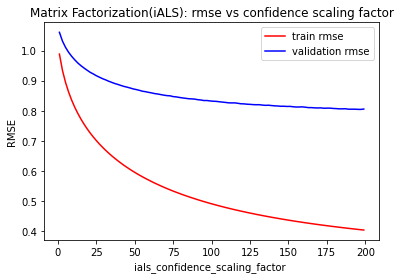

In [105]:
# optimal scale =  50
plt.plot(ials_scale, ials_train_scale, color= 'r' ,label='train rmse' )
plt.plot(ials_scale,  ials_val_scale, color= 'b',label='validation rmse' )
plt.xlabel('ials_confidence_scaling_factor ')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(iALS): rmse vs confidence scaling factor')
plt.legend()
plt.show()

In [110]:
# hyperparameter tuning for user_reg
reg = np.logspace(-10, -1, 10)
def test_reg_vals():
    reg_list = []
    train = []
    val = []
    for loc, R in enumerate(reg):
        model = tc.ranking_factorization_recommender.create(train3,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials', num_factors = 70, regularization = R,\
                                                                   ials_confidence_scaling_factor = 50 )
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        reg_list.append(np.log10(R))
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return reg_list,train,val

In [111]:
ials_reg, ials_train_reg, ials_val_reg = test_reg_vals()

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.407376s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-10    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 121us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.53s        | 0.768253                  |

| 1       | 5.16s        | 0.651293                  |

| 2       | 7.45s        | 0.626579                  |

| 3       | 9.77s        | 0.615668                  |

| 4       | 12.05s       | 0.609841                  |

| 5       | 15.03s       | 0.606307                  |

| 6       | 17.87s       | 0.603971                  |

| 7       | 20.64s       | 0.602329                  |

| 8       | 23.50s       | 0.60112                   |

| 9       | 26.07s       | 0.600195                  |

| 10      | 28.62s       | 0.599467                  |

| 11      | 31.56s       | 0.59888                   |

| 12      | 34.83s       | 0.598398                  |

| 13      | 37.93s       | 0.597995                  |

| 14      | 40.84s       | 0.597653                  |

| 15      | 44.04s       | 0.597361                  |

| 16      | 47.17s       | 0.597107                  |

| 17      | 50.39s       | 0.596886                  |

| 18      | 53.31s       | 0.596691                  |

| 19      | 56.49s       | 0.596518                  |

| 20      | 59.59s       | 0.596364                  |

| 21      | 1m 2s        | 0.596226                  |

| 22      | 1m 5s        | 0.596101                  |

| 23      | 1m 7s        | 0.595989                  |

| 24      | 1m 10s       | 0.595886                  |

| FINAL   | 1m 10s       | 0.595886                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1747.37

recommendations finished on 2000/37283 queries. users per second: 1679.94

recommendations finished on 3000/37283 queries. users per second: 1654.25

recommendations finished on 4000/37283 queries. users per second: 1649.92

recommendations finished on 5000/37283 queries. users per second: 1635.46

recommendations finished on 6000/37283 queries. users per second: 1621.79

recommendations finished on 7000/37283 queries. users per second: 1620.63

recommendations finished on 8000/37283 queries. users per second: 1598.07

recommendations finished on 9000/37283 queries. users per second: 1600.86

recommendations finished on 10000/37283 queries. users per second: 1582.22

recommendations finished on 11000/37283 queries. users per second: 1591.18

recommendations finished on 12000/37283 queries. users per second: 1595.08

recommendations finished on 13000/37283 queries. users per second: 1542.43

recommendations finished on 14000/37283 queries. users per second: 1511.96

recommendations finished on 15000/37283 queries. users per second: 1492.24

recommendations finished on 16000/37283 queries. users per second: 1472.82

recommendations finished on 17000/37283 queries. users per second: 1479.64

recommendations finished on 18000/37283 queries. users per second: 1484.49

recommendations finished on 19000/37283 queries. users per second: 1496

recommendations finished on 20000/37283 queries. users per second: 1506.2

recommendations finished on 21000/37283 queries. users per second: 1511.05

recommendations finished on 22000/37283 queries. users per second: 1516.57

recommendations finished on 23000/37283 queries. users per second: 1522.47

recommendations finished on 24000/37283 queries. users per second: 1528.33

recommendations finished on 25000/37283 queries. users per second: 1534.84

recommendations finished on 26000/37283 queries. users per second: 1540.29

recommendations finished on 27000/37283 queries. users per second: 1546

recommendations finished on 28000/37283 queries. users per second: 1551.8

recommendations finished on 29000/37283 queries. users per second: 1557.34

recommendations finished on 30000/37283 queries. users per second: 1561.83

recommendations finished on 31000/37283 queries. users per second: 1565.6

recommendations finished on 32000/37283 queries. users per second: 1569.85

recommendations finished on 33000/37283 queries. users per second: 1573.17

recommendations finished on 34000/37283 queries. users per second: 1575.02

recommendations finished on 35000/37283 queries. users per second: 1577.36

recommendations finished on 36000/37283 queries. users per second: 1579.37

recommendations finished on 37000/37283 queries. users per second: 1582.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.45645468444063025 | 0.05687234513954111 |
|   2    | 0.43151033983316756 | 0.10212816720957477 |
|   3    | 0.40571663582150974 | 0.13855169962022662 |
|   4    |  0.383546120215648  | 0.16937247283034423 |
|   5    | 0.36516374755250414 | 0.19662717250382766 |
|   6    |  0.3489838979338227 | 0.22080108456584407 |
|   7    |  0.3339170284426829 | 0.24212673321739298 |
|   8    |  0.321017621972481  |  0.2615811452255644 |
|   9    | 0.30899993145520527 | 0.27909980136459417 |
|   10   |  0.2976316283560876 |  0.2948577442334996 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5958861999668545

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.571044s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 107us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.38s        | 0.77175                   |

| 1       | 6.66s        | 0.651425                  |

| 2       | 10.09s       | 0.626665                  |

| 3       | 13.61s       | 0.615784                  |

| 4       | 16.51s       | 0.610018                  |

| 5       | 18.99s       | 0.606536                  |

| 6       | 21.49s       | 0.604231                  |

| 7       | 23.96s       | 0.602603                  |

| 8       | 26.46s       | 0.601398                  |

| 9       | 28.99s       | 0.600472                  |

| 10      | 32.08s       | 0.599741                  |

| 11      | 35.66s       | 0.59915                   |

| 12      | 38.89s       | 0.598663                  |

| 13      | 42.43s       | 0.598255                  |

| 14      | 45.07s       | 0.597909                  |

| 15      | 47.61s       | 0.597611                  |

| 16      | 50.08s       | 0.597352                  |

| 17      | 52.65s       | 0.597126                  |

| 18      | 55.48s       | 0.596926                  |

| 19      | 58.11s       | 0.596747                  |

| 20      | 1m 0s        | 0.596587                  |

| 21      | 1m 3s        | 0.596443                  |

| 22      | 1m 6s        | 0.596313                  |

| 23      | 1m 9s        | 0.596194                  |

| 24      | 1m 12s       | 0.596086                  |

| FINAL   | 1m 12s       | 0.596086                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1724.54

recommendations finished on 2000/37283 queries. users per second: 1668.57

recommendations finished on 3000/37283 queries. users per second: 1653.05

recommendations finished on 4000/37283 queries. users per second: 1663.46

recommendations finished on 5000/37283 queries. users per second: 1655

recommendations finished on 6000/37283 queries. users per second: 1649.94

recommendations finished on 7000/37283 queries. users per second: 1651.52

recommendations finished on 8000/37283 queries. users per second: 1648.2

recommendations finished on 9000/37283 queries. users per second: 1647.56

recommendations finished on 10000/37283 queries. users per second: 1646.84

recommendations finished on 11000/37283 queries. users per second: 1645.49

recommendations finished on 12000/37283 queries. users per second: 1643.74

recommendations finished on 13000/37283 queries. users per second: 1647.11

recommendations finished on 14000/37283 queries. users per second: 1649.64

recommendations finished on 15000/37283 queries. users per second: 1648.59

recommendations finished on 16000/37283 queries. users per second: 1647.38

recommendations finished on 17000/37283 queries. users per second: 1648.13

recommendations finished on 18000/37283 queries. users per second: 1647.38

recommendations finished on 19000/37283 queries. users per second: 1648.39

recommendations finished on 20000/37283 queries. users per second: 1649.09

recommendations finished on 21000/37283 queries. users per second: 1650.22

recommendations finished on 22000/37283 queries. users per second: 1650.54

recommendations finished on 23000/37283 queries. users per second: 1649.47

recommendations finished on 24000/37283 queries. users per second: 1644.9

recommendations finished on 25000/37283 queries. users per second: 1645.21

recommendations finished on 26000/37283 queries. users per second: 1644.71

recommendations finished on 27000/37283 queries. users per second: 1644.23

recommendations finished on 28000/37283 queries. users per second: 1637.68

recommendations finished on 29000/37283 queries. users per second: 1618.59

recommendations finished on 30000/37283 queries. users per second: 1611

recommendations finished on 31000/37283 queries. users per second: 1581.67

recommendations finished on 32000/37283 queries. users per second: 1570.28

recommendations finished on 33000/37283 queries. users per second: 1548.09

recommendations finished on 34000/37283 queries. users per second: 1530.22

recommendations finished on 35000/37283 queries. users per second: 1527.08

recommendations finished on 36000/37283 queries. users per second: 1525.22

recommendations finished on 37000/37283 queries. users per second: 1525.02


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4690609661239704 | 0.058209246695290415 |
|   2    | 0.43965077917549555 | 0.10379100922881272  |
|   3    |  0.4119035485341832 | 0.14043951222365836  |
|   4    |  0.3894402274495077 | 0.17175345271026773  |
|   5    |  0.3698575758388549 | 0.19893464780180442  |
|   6    |  0.3522874589848809 | 0.22276817257134549  |
|   7    |  0.3371164950705226 | 0.24414515477097148  |
|   8    |  0.3230527318080622 |  0.2630215248470661  |
|   9    | 0.31058838255147536 | 0.28038619347184973  |
|   10   |  0.2992650805997375 | 0.29631431254123064  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5960855159152834

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.548351s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-08    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 108us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.79s        | 0.776494                  |

| 1       | 7.00s        | 0.650372                  |

| 2       | 9.75s        | 0.625564                  |

| 3       | 12.82s       | 0.614692                  |

| 4       | 15.71s       | 0.608944                  |

| 5       | 18.20s       | 0.605488                  |

| 6       | 20.69s       | 0.603217                  |

| 7       | 23.10s       | 0.601628                  |

| 8       | 25.61s       | 0.600463                  |

| 9       | 29.16s       | 0.599578                  |

| 10      | 32.71s       | 0.598886                  |

| 11      | 36.04s       | 0.598333                  |

| 12      | 38.93s       | 0.597882                  |

| 13      | 42.04s       | 0.597508                  |

| 14      | 45.51s       | 0.597193                  |

| 15      | 49.04s       | 0.596925                  |

| 16      | 52.31s       | 0.596695                  |

| 17      | 55.65s       | 0.596494                  |

| 18      | 59.13s       | 0.596319                  |

| 19      | 1m 2s        | 0.596164                  |

| 20      | 1m 5s        | 0.596027                  |

| 21      | 1m 8s        | 0.595904                  |

| 22      | 1m 11s       | 0.595794                  |

| 23      | 1m 13s       | 0.595695                  |

| 24      | 1m 17s       | 0.595606                  |

| FINAL   | 1m 17s       | 0.595606                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1817.65

recommendations finished on 2000/37283 queries. users per second: 1764.43

recommendations finished on 3000/37283 queries. users per second: 1757.95

recommendations finished on 4000/37283 queries. users per second: 1749.02

recommendations finished on 5000/37283 queries. users per second: 1733.01

recommendations finished on 6000/37283 queries. users per second: 1735.55

recommendations finished on 7000/37283 queries. users per second: 1732.07

recommendations finished on 8000/37283 queries. users per second: 1732.26

recommendations finished on 9000/37283 queries. users per second: 1727.58

recommendations finished on 10000/37283 queries. users per second: 1722.44

recommendations finished on 11000/37283 queries. users per second: 1651.83

recommendations finished on 12000/37283 queries. users per second: 1577.59

recommendations finished on 13000/37283 queries. users per second: 1532.81

recommendations finished on 14000/37283 queries. users per second: 1502.44

recommendations finished on 15000/37283 queries. users per second: 1466.45

recommendations finished on 16000/37283 queries. users per second: 1435.86

recommendations finished on 17000/37283 queries. users per second: 1428.32

recommendations finished on 18000/37283 queries. users per second: 1398.53

recommendations finished on 19000/37283 queries. users per second: 1396.31

recommendations finished on 20000/37283 queries. users per second: 1381.34

recommendations finished on 21000/37283 queries. users per second: 1372.07

recommendations finished on 22000/37283 queries. users per second: 1369.97

recommendations finished on 23000/37283 queries. users per second: 1356.33

recommendations finished on 24000/37283 queries. users per second: 1352.09

recommendations finished on 25000/37283 queries. users per second: 1349.49

recommendations finished on 26000/37283 queries. users per second: 1351.07

recommendations finished on 27000/37283 queries. users per second: 1360.41

recommendations finished on 28000/37283 queries. users per second: 1367.53

recommendations finished on 29000/37283 queries. users per second: 1374.21

recommendations finished on 30000/37283 queries. users per second: 1382.27

recommendations finished on 31000/37283 queries. users per second: 1388.93

recommendations finished on 32000/37283 queries. users per second: 1396.25

recommendations finished on 33000/37283 queries. users per second: 1398.49

recommendations finished on 34000/37283 queries. users per second: 1403.7

recommendations finished on 35000/37283 queries. users per second: 1409.73

recommendations finished on 36000/37283 queries. users per second: 1415.21

recommendations finished on 37000/37283 queries. users per second: 1420.52


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4472547809993836 | 0.055847065428190526 |
|   2    | 0.42320896923530865 | 0.10048236044136781  |
|   3    |  0.3991184543446962 | 0.13663874777527926  |
|   4    | 0.37782635517528085 | 0.16739155553678184  |
|   5    | 0.36034117426172846 | 0.19473466277189985  |
|   6    | 0.34417384151847696 | 0.21849690532488528  |
|   7    | 0.32956805284675916 | 0.23978370944933497  |
|   8    |  0.3162802081377574 |  0.2587746962529479  |
|   9    |  0.3045296188015389 |  0.2762193920761493  |
|   10   |  0.2939945819810644 |  0.2923572442120675  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5956055085461271

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.571177s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-07    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 137us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.99s        | 0.77756                   |

| 1       | 6.98s        | 0.649259                  |

| 2       | 10.42s       | 0.624915                  |

| 3       | 13.70s       | 0.614357                  |

| 4       | 16.67s       | 0.608754                  |

| 5       | 19.76s       | 0.605363                  |

| 6       | 22.27s       | 0.60312                   |

| 7       | 24.78s       | 0.60154                   |

| 8       | 27.28s       | 0.600372                  |

| 9       | 29.69s       | 0.599479                  |

| 10      | 32.14s       | 0.598776                  |

| 11      | 34.70s       | 0.59821                   |

| 12      | 37.79s       | 0.597747                  |

| 13      | 41.89s       | 0.597362                  |

| 14      | 46.01s       | 0.597038                  |

| 15      | 49.86s       | 0.596762                  |

| 16      | 53.64s       | 0.596526                  |

| 17      | 57.83s       | 0.596321                  |

| 18      | 1m 0s        | 0.596142                  |

| 19      | 1m 3s        | 0.595985                  |

| 20      | 1m 6s        | 0.595846                  |

| 21      | 1m 9s        | 0.595723                  |

| 22      | 1m 11s       | 0.595612                  |

| 23      | 1m 14s       | 0.595513                  |

| 24      | 1m 17s       | 0.595424                  |

| FINAL   | 1m 17s       | 0.595424                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1244.81

recommendations finished on 2000/37283 queries. users per second: 1239.58

recommendations finished on 3000/37283 queries. users per second: 1165.63

recommendations finished on 4000/37283 queries. users per second: 1214.2

recommendations finished on 5000/37283 queries. users per second: 1275.19

recommendations finished on 6000/37283 queries. users per second: 1320.16

recommendations finished on 7000/37283 queries. users per second: 1348.26

recommendations finished on 8000/37283 queries. users per second: 1381.29

recommendations finished on 9000/37283 queries. users per second: 1404.04

recommendations finished on 10000/37283 queries. users per second: 1423.36

recommendations finished on 11000/37283 queries. users per second: 1440.63

recommendations finished on 12000/37283 queries. users per second: 1424.34

recommendations finished on 13000/37283 queries. users per second: 1441.33

recommendations finished on 14000/37283 queries. users per second: 1452.67

recommendations finished on 15000/37283 queries. users per second: 1463.76

recommendations finished on 16000/37283 queries. users per second: 1474.74

recommendations finished on 17000/37283 queries. users per second: 1482.88

recommendations finished on 18000/37283 queries. users per second: 1488.61

recommendations finished on 19000/37283 queries. users per second: 1496.06

recommendations finished on 20000/37283 queries. users per second: 1500.54

recommendations finished on 21000/37283 queries. users per second: 1503.81

recommendations finished on 22000/37283 queries. users per second: 1508.63

recommendations finished on 23000/37283 queries. users per second: 1513.43

recommendations finished on 24000/37283 queries. users per second: 1510.01

recommendations finished on 25000/37283 queries. users per second: 1513.82

recommendations finished on 26000/37283 queries. users per second: 1500.72

recommendations finished on 27000/37283 queries. users per second: 1476.29

recommendations finished on 28000/37283 queries. users per second: 1446.6

recommendations finished on 29000/37283 queries. users per second: 1446.74

recommendations finished on 30000/37283 queries. users per second: 1446.04

recommendations finished on 31000/37283 queries. users per second: 1429.44

recommendations finished on 32000/37283 queries. users per second: 1420.03

recommendations finished on 33000/37283 queries. users per second: 1415.92

recommendations finished on 34000/37283 queries. users per second: 1406.94

recommendations finished on 35000/37283 queries. users per second: 1400.11

recommendations finished on 36000/37283 queries. users per second: 1398.14

recommendations finished on 37000/37283 queries. users per second: 1394.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.44425073089611866 | 0.05568451650699889 |
|   2    |  0.4206340691467963 | 0.10017141027110066 |
|   3    |  0.3967938917647906 | 0.13618165562197873 |
|   4    |  0.3754257972802615 | 0.16668283029519862 |
|   5    | 0.35754633479065434 | 0.19347203136027152 |
|   6    |  0.3419386851916436 |  0.2173412974511164 |
|   7    |  0.3276330460838141 |  0.2385855793054447 |
|   8    |  0.3149223506692055 |  0.2576274478445821 |
|   9    | 0.30316468333795465 |  0.2749917969730508 |
|   10   |  0.2926588525601484 | 0.29111971561854744 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5954235388636151

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.573094s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-06    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 107us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.71s        | 0.781114                  |

| 1       | 5.79s        | 0.652094                  |

| 2       | 9.13s        | 0.627346                  |

| 3       | 12.34s       | 0.616477                  |

| 4       | 14.82s       | 0.610678                  |

| 5       | 17.28s       | 0.607182                  |

| 6       | 19.72s       | 0.604881                  |

| 7       | 22.13s       | 0.603267                  |

| 8       | 24.51s       | 0.602076                  |

| 9       | 26.90s       | 0.601163                  |

| 10      | 29.30s       | 0.600442                  |

| 11      | 31.81s       | 0.599859                  |

| 12      | 34.94s       | 0.599377                  |

| 13      | 37.54s       | 0.598974                  |

| 14      | 40.44s       | 0.598631                  |

| 15      | 43.21s       | 0.598337                  |

| 16      | 45.92s       | 0.598082                  |

| 17      | 48.65s       | 0.59786                   |

| 18      | 51.67s       | 0.597664                  |

| 19      | 54.09s       | 0.59749                   |

| 20      | 56.54s       | 0.597336                  |

| 21      | 59.39s       | 0.597197                  |

| 22      | 1m 1s        | 0.597072                  |

| 23      | 1m 4s        | 0.596959                  |

| 24      | 1m 7s        | 0.596857                  |

| FINAL   | 1m 7s        | 0.596857                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1718.63

recommendations finished on 2000/37283 queries. users per second: 1688.21

recommendations finished on 3000/37283 queries. users per second: 1702.77

recommendations finished on 4000/37283 queries. users per second: 1699.49

recommendations finished on 5000/37283 queries. users per second: 1700.17

recommendations finished on 6000/37283 queries. users per second: 1691.75

recommendations finished on 7000/37283 queries. users per second: 1679.49

recommendations finished on 8000/37283 queries. users per second: 1674.63

recommendations finished on 9000/37283 queries. users per second: 1663.54

recommendations finished on 10000/37283 queries. users per second: 1665.71

recommendations finished on 11000/37283 queries. users per second: 1656.2

recommendations finished on 12000/37283 queries. users per second: 1656.29

recommendations finished on 13000/37283 queries. users per second: 1658.71

recommendations finished on 14000/37283 queries. users per second: 1651.05

recommendations finished on 15000/37283 queries. users per second: 1653.88

recommendations finished on 16000/37283 queries. users per second: 1656.76

recommendations finished on 17000/37283 queries. users per second: 1659.03

recommendations finished on 18000/37283 queries. users per second: 1661.74

recommendations finished on 19000/37283 queries. users per second: 1661.57

recommendations finished on 20000/37283 queries. users per second: 1660.66

recommendations finished on 21000/37283 queries. users per second: 1637.17

recommendations finished on 22000/37283 queries. users per second: 1611.46

recommendations finished on 23000/37283 queries. users per second: 1596.75

recommendations finished on 24000/37283 queries. users per second: 1572.47

recommendations finished on 25000/37283 queries. users per second: 1565.33

recommendations finished on 26000/37283 queries. users per second: 1550.74

recommendations finished on 27000/37283 queries. users per second: 1546.24

recommendations finished on 28000/37283 queries. users per second: 1544.95

recommendations finished on 29000/37283 queries. users per second: 1519.9

recommendations finished on 30000/37283 queries. users per second: 1503.23

recommendations finished on 31000/37283 queries. users per second: 1466.2

recommendations finished on 32000/37283 queries. users per second: 1470.21

recommendations finished on 33000/37283 queries. users per second: 1472.61

recommendations finished on 34000/37283 queries. users per second: 1476.61

recommendations finished on 35000/37283 queries. users per second: 1481.71

recommendations finished on 36000/37283 queries. users per second: 1484.41

recommendations finished on 37000/37283 queries. users per second: 1480.63


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4423195558297344 | 0.05556485883962001 |
|   2    |  0.4188638253359442 | 0.09971992120419762 |
|   3    |  0.3954975010952264 | 0.13564859359002432 |
|   4    | 0.37377625191105807 | 0.16587517825247075 |
|   5    |  0.3565646541319102 | 0.19287629028303896 |
|   6    |  0.3409105132812991 | 0.21665601507097498 |
|   7    |  0.3269356773098422 | 0.23798903452661796 |
|   8    |  0.3139936432154073 |  0.2570705002603651 |
|   9    | 0.30248519581459654 |  0.2745852149957671 |
|   10   | 0.29192929753506874 | 0.29060220867749764 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5968568655774219

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.499631s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 103us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.62s        | 1.02849                   |

| 1       | 5.05s        | 0.701925                  |

| 2       | 7.47s        | 0.661706                  |

| 3       | 9.87s        | 0.644772                  |

| 4       | 12.28s       | 0.634976                  |

| 5       | 14.61s       | 0.628518                  |

| 6       | 17.26s       | 0.623907                  |

| 7       | 19.59s       | 0.620433                  |

| 8       | 22.14s       | 0.617712                  |

| 9       | 24.55s       | 0.615519                  |

| 10      | 26.89s       | 0.613712                  |

| 11      | 29.30s       | 0.612196                  |

| 12      | 31.68s       | 0.610905                  |

| 13      | 34.04s       | 0.609793                  |

| 14      | 36.36s       | 0.608825                  |

| 15      | 38.90s       | 0.607974                  |

| 16      | 42.13s       | 0.607221                  |

| 17      | 44.94s       | 0.60655                   |

| 18      | 48.13s       | 0.605948                  |

| 19      | 50.78s       | 0.605405                  |

| 20      | 53.16s       | 0.604914                  |

| 21      | 55.59s       | 0.604466                  |

| 22      | 57.97s       | 0.604057                  |

| 23      | 1m 0s        | 0.603683                  |

| 24      | 1m 3s        | 0.603338                  |

| FINAL   | 1m 3s        | 0.603338                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1503.22

recommendations finished on 2000/37283 queries. users per second: 1405.22

recommendations finished on 3000/37283 queries. users per second: 1362

recommendations finished on 4000/37283 queries. users per second: 1316.53

recommendations finished on 5000/37283 queries. users per second: 1327.32

recommendations finished on 6000/37283 queries. users per second: 1330.83

recommendations finished on 7000/37283 queries. users per second: 1310.46

recommendations finished on 8000/37283 queries. users per second: 1312.28

recommendations finished on 9000/37283 queries. users per second: 1324.17

recommendations finished on 10000/37283 queries. users per second: 1317.81

recommendations finished on 11000/37283 queries. users per second: 1301.67

recommendations finished on 12000/37283 queries. users per second: 1299.79

recommendations finished on 13000/37283 queries. users per second: 1295.2

recommendations finished on 14000/37283 queries. users per second: 1300.02

recommendations finished on 15000/37283 queries. users per second: 1305

recommendations finished on 16000/37283 queries. users per second: 1314.06

recommendations finished on 17000/37283 queries. users per second: 1318.66

recommendations finished on 18000/37283 queries. users per second: 1318.62

recommendations finished on 19000/37283 queries. users per second: 1325.71

recommendations finished on 20000/37283 queries. users per second: 1323.21

recommendations finished on 21000/37283 queries. users per second: 1332.86

recommendations finished on 22000/37283 queries. users per second: 1341.12

recommendations finished on 23000/37283 queries. users per second: 1352.04

recommendations finished on 24000/37283 queries. users per second: 1347.76

recommendations finished on 25000/37283 queries. users per second: 1316.83

recommendations finished on 26000/37283 queries. users per second: 1296.27

recommendations finished on 27000/37283 queries. users per second: 1281.71

recommendations finished on 28000/37283 queries. users per second: 1279.54

recommendations finished on 29000/37283 queries. users per second: 1279.61

recommendations finished on 30000/37283 queries. users per second: 1254.26

recommendations finished on 31000/37283 queries. users per second: 1245.77

recommendations finished on 32000/37283 queries. users per second: 1238.61

recommendations finished on 33000/37283 queries. users per second: 1241.14

recommendations finished on 34000/37283 queries. users per second: 1244.41

recommendations finished on 35000/37283 queries. users per second: 1248.98

recommendations finished on 36000/37283 queries. users per second: 1253.57

recommendations finished on 37000/37283 queries. users per second: 1257.99


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.42362470831209925 | 0.053131015788376805 |
|   2    | 0.40223426226430287 | 0.09548579007834555  |
|   3    | 0.38024479432091396 | 0.13041670541568748  |
|   4    | 0.36170640774615725 | 0.16062596793892733  |
|   5    |  0.3455998712549949 | 0.18705807622380677  |
|   6    |  0.3314468613934868 | 0.21102747635332705  |
|   7    |  0.3190347190025325 | 0.23250252777713762  |
|   8    | 0.30703671914813846 |  0.2515470279153385  |
|   9    |  0.2963072237272284 |  0.2688214489678143  |
|   10   | 0.28625647077756605 |  0.2847351143124221  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6033381554376721

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.746281s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 130us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.58s        | 1.09596                   |

| 1       | 7.02s        | 0.784151                  |

| 2       | 10.06s       | 0.662019                  |

| 3       | 12.69s       | 0.644626                  |

| 4       | 15.05s       | 0.637704                  |

| 5       | 18.00s       | 0.634148                  |

| 6       | 21.07s       | 0.632062                  |

| 7       | 23.51s       | 0.630727                  |

| 8       | 25.90s       | 0.629817                  |

| 9       | 28.29s       | 0.629167                  |

| 10      | 30.94s       | 0.628683                  |

| 11      | 33.67s       | 0.628311                  |

| 12      | 36.45s       | 0.628018                  |

| 13      | 39.25s       | 0.62778                   |

| 14      | 41.94s       | 0.627585                  |

| 15      | 44.44s       | 0.62742                   |

| 16      | 47.25s       | 0.62728                   |

| 17      | 50.00s       | 0.627159                  |

| 18      | 52.64s       | 0.627052                  |

| 19      | 55.50s       | 0.626958                  |

| 20      | 58.11s       | 0.626873                  |

| 21      | 1m 0s        | 0.626797                  |

| 22      | 1m 3s        | 0.626727                  |

| 23      | 1m 5s        | 0.626663                  |

| 24      | 1m 8s        | 0.626604                  |

| FINAL   | 1m 8s        | 0.626604                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1780.07

recommendations finished on 2000/37283 queries. users per second: 1749.51

recommendations finished on 3000/37283 queries. users per second: 1742.64

recommendations finished on 4000/37283 queries. users per second: 1686.56

recommendations finished on 5000/37283 queries. users per second: 1596.16

recommendations finished on 6000/37283 queries. users per second: 1520.79

recommendations finished on 7000/37283 queries. users per second: 1506.25

recommendations finished on 8000/37283 queries. users per second: 1487.54

recommendations finished on 9000/37283 queries. users per second: 1460.79

recommendations finished on 10000/37283 queries. users per second: 1435.49

recommendations finished on 11000/37283 queries. users per second: 1423.13

recommendations finished on 12000/37283 queries. users per second: 1404.73

recommendations finished on 13000/37283 queries. users per second: 1384.6

recommendations finished on 14000/37283 queries. users per second: 1381.72

recommendations finished on 15000/37283 queries. users per second: 1363.52

recommendations finished on 16000/37283 queries. users per second: 1368.32

recommendations finished on 17000/37283 queries. users per second: 1383.8

recommendations finished on 18000/37283 queries. users per second: 1394.56

recommendations finished on 19000/37283 queries. users per second: 1408.55

recommendations finished on 20000/37283 queries. users per second: 1396.1

recommendations finished on 21000/37283 queries. users per second: 1385.62

recommendations finished on 22000/37283 queries. users per second: 1381.83

recommendations finished on 23000/37283 queries. users per second: 1377.54

recommendations finished on 24000/37283 queries. users per second: 1371.46

recommendations finished on 25000/37283 queries. users per second: 1377.23

recommendations finished on 26000/37283 queries. users per second: 1372.71

recommendations finished on 27000/37283 queries. users per second: 1369.53

recommendations finished on 28000/37283 queries. users per second: 1363.79

recommendations finished on 29000/37283 queries. users per second: 1369.07

recommendations finished on 30000/37283 queries. users per second: 1366.9

recommendations finished on 31000/37283 queries. users per second: 1365.84

recommendations finished on 32000/37283 queries. users per second: 1361.73

recommendations finished on 33000/37283 queries. users per second: 1355.37

recommendations finished on 34000/37283 queries. users per second: 1353.71

recommendations finished on 35000/37283 queries. users per second: 1351.82

recommendations finished on 36000/37283 queries. users per second: 1350.56

recommendations finished on 37000/37283 queries. users per second: 1344.31


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.47053616929968084 | 0.05749900550139128 |
|   2    |  0.4375720837915406 | 0.10152017444572471 |
|   3    |  0.4078087421434249 |  0.1366491987369809 |
|   4    |   0.38357964756055  |  0.1661817140610212 |
|   5    | 0.36293753185097705 | 0.19178421963312883 |
|   6    |  0.345510465001924  | 0.21457317912625032 |
|   7    |  0.3298822519647025 | 0.23497784573907696 |
|   8    |  0.3155996030362362 | 0.25287935756100344 |
|   9    | 0.30318852500544125 |  0.2693467514633727 |
|   10   |  0.2923235791111215 | 0.28479725224785085 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6266038687148134

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.581089s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.001    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 107us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.34s        | 1.0961                    |

| 1       | 5.14s        | 1.09601                   |

| 2       | 8.45s        | 1.04322                   |

| 3       | 11.09s       | 0.974487                  |

| 4       | 13.98s       | 0.955009                  |

| 5       | 16.47s       | 0.934882                  |

| 6       | 19.61s       | 0.917775                  |

| 7       | 22.79s       | 0.904926                  |

| 8       | 25.66s       | 0.896948                  |

| 9       | 28.43s       | 0.891637                  |

| 10      | 31.12s       | 0.887842                  |

| 11      | 33.47s       | 0.885043                  |

| 12      | 35.76s       | 0.882932                  |

| 13      | 38.70s       | 0.881308                  |

| 14      | 42.32s       | 0.880038                  |

| 15      | 45.66s       | 0.879031                  |

| 16      | 49.07s       | 0.878221                  |

| 17      | 52.49s       | 0.877561                  |

| 18      | 55.76s       | 0.877016                  |

| 19      | 58.66s       | 0.876561                  |

| 20      | 1m 1s        | 0.876177                  |

| 21      | 1m 4s        | 0.87585                   |

| 22      | 1m 6s        | 0.875569                  |

| 23      | 1m 10s       | 0.875327                  |

| 24      | 1m 12s       | 0.875117                  |

| FINAL   | 1m 12s       | 0.875117                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1909.61

recommendations finished on 2000/37283 queries. users per second: 1749.68

recommendations finished on 3000/37283 queries. users per second: 1707.97

recommendations finished on 4000/37283 queries. users per second: 1568.38

recommendations finished on 5000/37283 queries. users per second: 1555.71

recommendations finished on 6000/37283 queries. users per second: 1516.22

recommendations finished on 7000/37283 queries. users per second: 1466.04

recommendations finished on 8000/37283 queries. users per second: 1442.72

recommendations finished on 9000/37283 queries. users per second: 1451.43

recommendations finished on 10000/37283 queries. users per second: 1426.97

recommendations finished on 11000/37283 queries. users per second: 1421.21

recommendations finished on 12000/37283 queries. users per second: 1414.93

recommendations finished on 13000/37283 queries. users per second: 1388.1

recommendations finished on 14000/37283 queries. users per second: 1385.73

recommendations finished on 15000/37283 queries. users per second: 1398.81

recommendations finished on 16000/37283 queries. users per second: 1409.73

recommendations finished on 17000/37283 queries. users per second: 1407.56

recommendations finished on 18000/37283 queries. users per second: 1411.74

recommendations finished on 19000/37283 queries. users per second: 1403.27

recommendations finished on 20000/37283 queries. users per second: 1394.77

recommendations finished on 21000/37283 queries. users per second: 1398.3

recommendations finished on 22000/37283 queries. users per second: 1385.21

recommendations finished on 23000/37283 queries. users per second: 1390.92

recommendations finished on 24000/37283 queries. users per second: 1375.46

recommendations finished on 25000/37283 queries. users per second: 1376.58

recommendations finished on 26000/37283 queries. users per second: 1370.74

recommendations finished on 27000/37283 queries. users per second: 1373.34

recommendations finished on 28000/37283 queries. users per second: 1382.96

recommendations finished on 29000/37283 queries. users per second: 1392.86

recommendations finished on 30000/37283 queries. users per second: 1402.42

recommendations finished on 31000/37283 queries. users per second: 1411.74

recommendations finished on 32000/37283 queries. users per second: 1421.38

recommendations finished on 33000/37283 queries. users per second: 1427.27

recommendations finished on 34000/37283 queries. users per second: 1435.94

recommendations finished on 35000/37283 queries. users per second: 1430.99

recommendations finished on 36000/37283 queries. users per second: 1426

recommendations finished on 37000/37283 queries. users per second: 1427.34


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4551672343963737 | 0.04604995341946297 |
|   2    |  0.3723949253010756 | 0.07250952235607976 |
|   3    | 0.32157641105418866 | 0.09167297917775541 |
|   4    | 0.28651127859882547 | 0.10681054733487429 |
|   5    | 0.26133090148324906 | 0.11998953052578247 |
|   6    | 0.24194673175441841 | 0.13168248218082415 |
|   7    | 0.22581337338733456 | 0.14188899143522424 |
|   8    |  0.2123554971434702 |  0.1513310449736952 |
|   9    | 0.20111638608004212 |  0.1601377173968805 |
|   10   |  0.1911541453209239 | 0.16796565559441617 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.875117035385561

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.67764s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.01     |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 99us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.31s        | 1.0961                    |

| 1       | 6.12s        | 1.0961                    |

| 2       | 9.30s        | 1.0961                    |

| 3       | 11.89s       | 1.0961                    |

| 4       | 13.97s       | 1.0961                    |

| 5       | 16.22s       | 1.0961                    |

| 6       | 18.29s       | 1.0961                    |

| 7       | 20.40s       | 1.0961                    |

| 8       | 22.50s       | 1.0961                    |

| 9       | 24.97s       | 1.0961                    |

| 10      | 28.60s       | 1.0961                    |

| 11      | 31.64s       | 1.0961                    |

| 12      | 35.42s       | 1.0961                    |

| 13      | 40.11s       | 1.0961                    |

| 14      | 48.85s       | 1.0961                    |

| 15      | 1m 5s        | 1.0961                    |

| 16      | 1m 31s       | 1.0961                    |

| 17      | 2m 3s        | 1.0961                    |

| 18      | 2m 43s       | 1.0961                    |

| 19      | 3m 20s       | 1.0961                    |

| 20      | 3m 52s       | 1.0961                    |

| 21      | 4m 25s       | 1.0961                    |

| 22      | 4m 58s       | 1.0961                    |

| 23      | 5m 30s       | 1.0961                    |

| 24      | 5m 56s       | 1.0961                    |

| FINAL   | 5m 56s       | 1.0961                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1121.2

recommendations finished on 2000/37283 queries. users per second: 1187.27

recommendations finished on 3000/37283 queries. users per second: 1196.62

recommendations finished on 4000/37283 queries. users per second: 1215.58

recommendations finished on 5000/37283 queries. users per second: 1243.58

recommendations finished on 6000/37283 queries. users per second: 1231.46

recommendations finished on 7000/37283 queries. users per second: 1248.52

recommendations finished on 8000/37283 queries. users per second: 1233.67

recommendations finished on 9000/37283 queries. users per second: 1244.56

recommendations finished on 10000/37283 queries. users per second: 1258.76

recommendations finished on 11000/37283 queries. users per second: 1259.21

recommendations finished on 12000/37283 queries. users per second: 1262.55

recommendations finished on 13000/37283 queries. users per second: 1277.36

recommendations finished on 14000/37283 queries. users per second: 1278.99

recommendations finished on 15000/37283 queries. users per second: 1289.53

recommendations finished on 16000/37283 queries. users per second: 1276.11

recommendations finished on 17000/37283 queries. users per second: 1238.5

recommendations finished on 18000/37283 queries. users per second: 1247.12

recommendations finished on 19000/37283 queries. users per second: 1257.35

recommendations finished on 20000/37283 queries. users per second: 1254.77

recommendations finished on 21000/37283 queries. users per second: 1249.67

recommendations finished on 22000/37283 queries. users per second: 1247.51

recommendations finished on 23000/37283 queries. users per second: 1251.85

recommendations finished on 24000/37283 queries. users per second: 1249.84

recommendations finished on 25000/37283 queries. users per second: 1250.59

recommendations finished on 26000/37283 queries. users per second: 1250.45

recommendations finished on 27000/37283 queries. users per second: 1255.24

recommendations finished on 28000/37283 queries. users per second: 1262.96

recommendations finished on 29000/37283 queries. users per second: 1258

recommendations finished on 30000/37283 queries. users per second: 1262.95

recommendations finished on 31000/37283 queries. users per second: 1270.49

recommendations finished on 32000/37283 queries. users per second: 1277.77

recommendations finished on 33000/37283 queries. users per second: 1270.08

recommendations finished on 34000/37283 queries. users per second: 1269.28

recommendations finished on 35000/37283 queries. users per second: 1269.07

recommendations finished on 36000/37283 queries. users per second: 1263.82

recommendations finished on 37000/37283 queries. users per second: 1255.84


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.07354558377812942  | 0.005583220000239227 |
|   2    | 0.06464072097202478  | 0.009770703984447677 |
|   3    | 0.05650475194235077  | 0.013015643134498135 |
|   4    | 0.05072016736850577  | 0.015558395774731882 |
|   5    |  0.0481559960303633  | 0.018649078430324935 |
|   6    | 0.044667364035441005 | 0.020605983059859154 |
|   7    | 0.04347442917300428  | 0.023397553897147746 |
|   8    | 0.04123863423007804  | 0.025288398968817006 |
|   9    | 0.040614280562781435 | 0.027911110231535342 |
|   10   | 0.03923504009870419  | 0.029991930055841373 |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0960968365794062

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.84979s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.1      |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 127us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.09s        | 1.0961                    |

| 1       | 6.85s        | 1.0961                    |

| 2       | 41.63s       | 1.0961                    |

| 3       | 49.80s       | 1.0961                    |

| 4       | 53.89s       | 1.0961                    |

| 5       | 1m 5s        | 1.0961                    |

| 6       | 1m 31s       | 1.0961                    |

| 7       | 1m 53s       | 1.0961                    |

| 8       | 1m 59s       | 1.0961                    |

| 9       | 2m 1s        | 1.0961                    |

| 10      | 2m 3s        | 1.0961                    |

| 11      | 2m 5s        | 1.0961                    |

| 12      | 2m 8s        | 1.0961                    |

| 13      | 2m 11s       | 1.0961                    |

| 14      | 2m 15s       | 1.0961                    |

| 15      | 2m 20s       | 1.0961                    |

| 16      | 2m 25s       | 1.0961                    |

| 17      | 2m 28s       | 1.0961                    |

| 18      | 2m 31s       | 1.0961                    |

| 19      | 2m 33s       | 1.0961                    |

| 20      | 2m 36s       | 1.0961                    |

| 21      | 2m 39s       | 1.0961                    |

| 22      | 2m 42s       | 1.0961                    |

| 23      | 2m 44s       | 1.0961                    |

| 24      | 2m 47s       | 1.0961                    |

| FINAL   | 2m 47s       | 1.0961                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 2196.77

recommendations finished on 2000/37283 queries. users per second: 2085.61

recommendations finished on 3000/37283 queries. users per second: 1800.62

recommendations finished on 4000/37283 queries. users per second: 1870.55

recommendations finished on 5000/37283 queries. users per second: 1915.28

recommendations finished on 6000/37283 queries. users per second: 1939.39

recommendations finished on 7000/37283 queries. users per second: 1963.65

recommendations finished on 8000/37283 queries. users per second: 1971.72

recommendations finished on 9000/37283 queries. users per second: 1987.87

recommendations finished on 10000/37283 queries. users per second: 1981.48

recommendations finished on 11000/37283 queries. users per second: 1991.69

recommendations finished on 12000/37283 queries. users per second: 1991.55

recommendations finished on 13000/37283 queries. users per second: 2000.77

recommendations finished on 14000/37283 queries. users per second: 1999.41

recommendations finished on 15000/37283 queries. users per second: 1978.41

recommendations finished on 16000/37283 queries. users per second: 1916.19

recommendations finished on 17000/37283 queries. users per second: 1881.42

recommendations finished on 18000/37283 queries. users per second: 1860.66

recommendations finished on 19000/37283 queries. users per second: 1842.37

recommendations finished on 20000/37283 queries. users per second: 1831.42

recommendations finished on 21000/37283 queries. users per second: 1802.18

recommendations finished on 22000/37283 queries. users per second: 1782

recommendations finished on 23000/37283 queries. users per second: 1760.08

recommendations finished on 24000/37283 queries. users per second: 1760.26

recommendations finished on 25000/37283 queries. users per second: 1758.09

recommendations finished on 26000/37283 queries. users per second: 1747.75

recommendations finished on 27000/37283 queries. users per second: 1746.55

recommendations finished on 28000/37283 queries. users per second: 1726.79

recommendations finished on 29000/37283 queries. users per second: 1712.24

recommendations finished on 30000/37283 queries. users per second: 1702.73

recommendations finished on 31000/37283 queries. users per second: 1686.21

recommendations finished on 32000/37283 queries. users per second: 1680.88

recommendations finished on 33000/37283 queries. users per second: 1673.63

recommendations finished on 34000/37283 queries. users per second: 1664.85

recommendations finished on 35000/37283 queries. users per second: 1648.87

recommendations finished on 36000/37283 queries. users per second: 1654.08

recommendations finished on 37000/37283 queries. users per second: 1647.8


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0014752031757101077 | 0.00015294690262971923 |
|   2    | 0.0007912453396990596 | 0.00016297147173713935 |
|   3    |  0.000670546898050047 | 0.0001946148911429526  |
|   4    | 0.0005230265804790388 | 0.00019845922394252965 |
|   5    | 0.0004720650162272345 | 0.00022418162101492422 |
|   6    | 0.0004827937665960342 | 0.00027432888809455553 |
|   7    | 0.0004253183181917445 |  0.000279930783650529  |
|   8    | 0.0004224445457715318 | 0.00032302553510861964 |
|   9    | 0.0004112687641373636 | 0.0003536421017822587  |
|   10   | 0.0004559718906740343 | 0.0004310811991525631  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0960968365794062

Per User RMSE (best)
+-----------+------+-------+
|

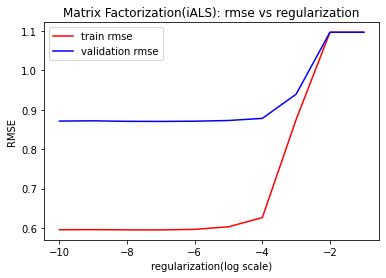

In [114]:
# optimal reg  = 1e-4
plt.plot(ials_reg, ials_train_reg, color= 'r' ,label='train rmse' )
plt.plot(ials_reg,  ials_val_reg, color= 'b',label='validation rmse' )
plt.xlabel('regularization(log scale)')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(iALS): rmse vs regularization')
plt.legend()
plt.show()

In [115]:
# hyperparameter tuning for max_iter
maxIter = np.arange(10,100, 10)
def test_iter_vals():
    maxIter_list = []
    train = []
    val = []
    for loc, iter_num in enumerate(maxIter):
        model = tc.ranking_factorization_recommender.create(train3,item_id = item_id, target = target,\
                                                            user_id = user_id, binary_target = False,\
                                                            solver = 'ials', num_factors = 70, regularization = 1e-4,\
                                                            ials_confidence_scaling_factor = 50 ,\
                                                            max_iterations = iter_num
                                                           )
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        maxIter_list.append(iter_num)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return maxIter_list,train,val

In [116]:
ials_iter, ials_train_iter, ials_val_iter = test_iter_vals() 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.478185s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 10       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 95us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.56s        | 1.09597                   |

| 1       | 5.31s        | 0.783702                  |

| 2       | 8.15s        | 0.661517                  |

| 3       | 10.60s       | 0.644338                  |

| 4       | 12.92s       | 0.637505                  |

| 5       | 15.21s       | 0.63399                   |

| 6       | 17.59s       | 0.631921                  |

| 7       | 20.76s       | 0.630591                  |

| 8       | 24.03s       | 0.629682                  |

| 9       | 26.69s       | 0.629031                  |

| FINAL   | 26.69s       | 0.629031                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1816.62

recommendations finished on 2000/37283 queries. users per second: 1708.52

recommendations finished on 3000/37283 queries. users per second: 1683.79

recommendations finished on 4000/37283 queries. users per second: 1691.08

recommendations finished on 5000/37283 queries. users per second: 1687.92

recommendations finished on 6000/37283 queries. users per second: 1689.15

recommendations finished on 7000/37283 queries. users per second: 1688.4

recommendations finished on 8000/37283 queries. users per second: 1689.78

recommendations finished on 9000/37283 queries. users per second: 1686.8

recommendations finished on 10000/37283 queries. users per second: 1684.89

recommendations finished on 11000/37283 queries. users per second: 1683.14

recommendations finished on 12000/37283 queries. users per second: 1678.57

recommendations finished on 13000/37283 queries. users per second: 1678.57

recommendations finished on 14000/37283 queries. users per second: 1675.26

recommendations finished on 15000/37283 queries. users per second: 1672.67

recommendations finished on 16000/37283 queries. users per second: 1673.11

recommendations finished on 17000/37283 queries. users per second: 1672.48

recommendations finished on 18000/37283 queries. users per second: 1671.03

recommendations finished on 19000/37283 queries. users per second: 1669.69

recommendations finished on 20000/37283 queries. users per second: 1664.25

recommendations finished on 21000/37283 queries. users per second: 1660.68

recommendations finished on 22000/37283 queries. users per second: 1658.76

recommendations finished on 23000/37283 queries. users per second: 1658.4

recommendations finished on 24000/37283 queries. users per second: 1658.71

recommendations finished on 25000/37283 queries. users per second: 1650.43

recommendations finished on 26000/37283 queries. users per second: 1651.2

recommendations finished on 27000/37283 queries. users per second: 1654.32

recommendations finished on 28000/37283 queries. users per second: 1656.91

recommendations finished on 29000/37283 queries. users per second: 1629.05

recommendations finished on 30000/37283 queries. users per second: 1612.28

recommendations finished on 31000/37283 queries. users per second: 1584.93

recommendations finished on 32000/37283 queries. users per second: 1575.16

recommendations finished on 33000/37283 queries. users per second: 1578.08

recommendations finished on 34000/37283 queries. users per second: 1581.76

recommendations finished on 35000/37283 queries. users per second: 1584.43

recommendations finished on 36000/37283 queries. users per second: 1571.63

recommendations finished on 37000/37283 queries. users per second: 1565.93


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5282032025319858 | 0.06331239086510965 |
|   2    |  0.4879837995869431 | 0.11178357310074247 |
|   3    | 0.45310194995037856 | 0.15004956936980934 |
|   4    |  0.4229005176622054 | 0.18136236264503613 |
|   5    |  0.3966258080090128 |  0.2075280301764724 |
|   6    |  0.3742277534890788 |  0.2303238589874962 |
|   7    |  0.3547537943375187 |  0.250084846757166  |
|   8    |  0.3378382909100667 | 0.26811034194642724 |
|   9    |  0.3224257704583861 | 0.28401011945305715 |
|   10   |  0.3095271303274947 |  0.2991118048201827 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6290305016459035

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.829409s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 20       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 124us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.88s        | 1.09595                   |

| 1       | 7.28s        | 0.782499                  |

| 2       | 9.76s        | 0.661735                  |

| 3       | 12.26s       | 0.644612                  |

| 4       | 14.72s       | 0.637742                  |

| 5       | 17.19s       | 0.634179                  |

| 6       | 19.64s       | 0.632067                  |

| 7       | 22.06s       | 0.630702                  |

| 8       | 24.50s       | 0.629765                  |

| 9       | 26.94s       | 0.629093                  |

| 10      | 29.35s       | 0.628593                  |

| 11      | 31.79s       | 0.628211                  |

| 12      | 34.24s       | 0.627911                  |

| 13      | 37.35s       | 0.627671                  |

| 14      | 40.31s       | 0.627475                  |

| 15      | 42.76s       | 0.627311                  |

| 16      | 45.23s       | 0.627173                  |

| 17      | 47.76s       | 0.627054                  |

| 18      | 51.26s       | 0.62695                   |

| 19      | 54.51s       | 0.626859                  |

| FINAL   | 54.51s       | 0.626859                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1574.63

recommendations finished on 2000/37283 queries. users per second: 1615.87

recommendations finished on 3000/37283 queries. users per second: 1518.98

recommendations finished on 4000/37283 queries. users per second: 1441.56

recommendations finished on 5000/37283 queries. users per second: 1394.24

recommendations finished on 6000/37283 queries. users per second: 1375.32

recommendations finished on 7000/37283 queries. users per second: 1334.18

recommendations finished on 8000/37283 queries. users per second: 1350.32

recommendations finished on 9000/37283 queries. users per second: 1361.19

recommendations finished on 10000/37283 queries. users per second: 1351.32

recommendations finished on 11000/37283 queries. users per second: 1333.43

recommendations finished on 12000/37283 queries. users per second: 1331.72

recommendations finished on 13000/37283 queries. users per second: 1326.23

recommendations finished on 14000/37283 queries. users per second: 1325.67

recommendations finished on 15000/37283 queries. users per second: 1323.93

recommendations finished on 16000/37283 queries. users per second: 1338.26

recommendations finished on 17000/37283 queries. users per second: 1339.1

recommendations finished on 18000/37283 queries. users per second: 1325.36

recommendations finished on 19000/37283 queries. users per second: 1329.47

recommendations finished on 20000/37283 queries. users per second: 1315.35

recommendations finished on 21000/37283 queries. users per second: 1302.76

recommendations finished on 22000/37283 queries. users per second: 1293.2

recommendations finished on 23000/37283 queries. users per second: 1292.58

recommendations finished on 24000/37283 queries. users per second: 1293.8

recommendations finished on 25000/37283 queries. users per second: 1282.87

recommendations finished on 26000/37283 queries. users per second: 1290.17

recommendations finished on 27000/37283 queries. users per second: 1299.34

recommendations finished on 28000/37283 queries. users per second: 1297.6

recommendations finished on 29000/37283 queries. users per second: 1295.34

recommendations finished on 30000/37283 queries. users per second: 1291.69

recommendations finished on 31000/37283 queries. users per second: 1291.26

recommendations finished on 32000/37283 queries. users per second: 1292.29

recommendations finished on 33000/37283 queries. users per second: 1293.21

recommendations finished on 34000/37283 queries. users per second: 1285.38

recommendations finished on 35000/37283 queries. users per second: 1281.75

recommendations finished on 36000/37283 queries. users per second: 1284.82

recommendations finished on 37000/37283 queries. users per second: 1280.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4826328353405039 | 0.05879356376331955 |
|   2    |  0.4484885872917948 | 0.10390659404592553 |
|   3    | 0.41708911121243814 | 0.13954348407413805 |
|   4    | 0.39089531421827634 | 0.16916409754875644 |
|   5    |  0.3686613201727328 |  0.194741557512471  |
|   6    |  0.3506781464295611 | 0.21765831074036565 |
|   7    | 0.33463355569945813 |  0.2378142366978654 |
|   8    |  0.3194887750449261 |  0.2556337308170841 |
|   9    | 0.30651741782820263 |  0.2719766709218422 |
|   10   | 0.29493334763833423 | 0.28698451274695497 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6268587637343541

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.619152s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 30       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 139us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.75s        | 1.09595                   |

| 1       | 7.22s        | 0.782582                  |

| 2       | 10.44s       | 0.661975                  |

| 3       | 13.72s       | 0.644736                  |

| 4       | 16.27s       | 0.637813                  |

| 5       | 19.18s       | 0.634219                  |

| 6       | 22.38s       | 0.632088                  |

| 7       | 25.76s       | 0.630711                  |

| 8       | 29.96s       | 0.629766                  |

| 9       | 33.64s       | 0.629086                  |

| 10      | 37.74s       | 0.62858                   |

| 11      | 41.11s       | 0.628191                  |

| 12      | 44.74s       | 0.627885                  |

| 13      | 49.21s       | 0.627639                  |

| 14      | 52.13s       | 0.627437                  |

| 15      | 55.17s       | 0.627268                  |

| 16      | 57.82s       | 0.627125                  |

| 17      | 1m 0s        | 0.627003                  |

| 18      | 1m 3s        | 0.626897                  |

| 19      | 1m 7s        | 0.626803                  |

| 20      | 1m 9s        | 0.62672                   |

| 21      | 1m 12s       | 0.626646                  |

| 22      | 1m 15s       | 0.626579                  |

| 23      | 1m 18s       | 0.626518                  |

| 24      | 1m 21s       | 0.626462                  |

| 25      | 1m 24s       | 0.62641                   |

| 26      | 1m 27s       | 0.626363                  |

| 27      | 1m 30s       | 0.626319                  |

| 28      | 1m 33s       | 0.626278                  |

| 29      | 1m 36s       | 0.626239                  |

| FINAL   | 1m 36s       | 0.626239                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1055.16

recommendations finished on 2000/37283 queries. users per second: 1295.81

recommendations finished on 3000/37283 queries. users per second: 1404.87

recommendations finished on 4000/37283 queries. users per second: 1445.88

recommendations finished on 5000/37283 queries. users per second: 1441.09

recommendations finished on 6000/37283 queries. users per second: 1447.26

recommendations finished on 7000/37283 queries. users per second: 1465

recommendations finished on 8000/37283 queries. users per second: 1485.27

recommendations finished on 9000/37283 queries. users per second: 1501.63

recommendations finished on 10000/37283 queries. users per second: 1484.97

recommendations finished on 11000/37283 queries. users per second: 1484.83

recommendations finished on 12000/37283 queries. users per second: 1494.11

recommendations finished on 13000/37283 queries. users per second: 1496.22

recommendations finished on 14000/37283 queries. users per second: 1454.06

recommendations finished on 15000/37283 queries. users per second: 1420.4

recommendations finished on 16000/37283 queries. users per second: 1400

recommendations finished on 17000/37283 queries. users per second: 1375.88

recommendations finished on 18000/37283 queries. users per second: 1361.06

recommendations finished on 19000/37283 queries. users per second: 1363.23

recommendations finished on 20000/37283 queries. users per second: 1359.43

recommendations finished on 21000/37283 queries. users per second: 1355.79

recommendations finished on 22000/37283 queries. users per second: 1350.79

recommendations finished on 23000/37283 queries. users per second: 1358.31

recommendations finished on 24000/37283 queries. users per second: 1343.48

recommendations finished on 25000/37283 queries. users per second: 1340.9

recommendations finished on 26000/37283 queries. users per second: 1342.31

recommendations finished on 27000/37283 queries. users per second: 1335.9

recommendations finished on 28000/37283 queries. users per second: 1339.22

recommendations finished on 29000/37283 queries. users per second: 1329.71

recommendations finished on 30000/37283 queries. users per second: 1329.77

recommendations finished on 31000/37283 queries. users per second: 1335.44

recommendations finished on 32000/37283 queries. users per second: 1338.56

recommendations finished on 33000/37283 queries. users per second: 1337.84

recommendations finished on 34000/37283 queries. users per second: 1331.2

recommendations finished on 35000/37283 queries. users per second: 1330.51

recommendations finished on 36000/37283 queries. users per second: 1332.32

recommendations finished on 37000/37283 queries. users per second: 1331.06


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.46836359734999844 | 0.057200430984660815 |
|   2    | 0.43543974465574165 | 0.10106743443080664  |
|   3    | 0.40653023272447686 | 0.13621512660190155  |
|   4    |  0.3824732451787682 | 0.16603392042919526  |
|   5    |  0.3619451224418638 |  0.1915647158521638  |
|   6    | 0.34403973213886513 | 0.21408087124463138  |
|   7    |  0.3285948019204473 |  0.2342597779107558  |
|   8    | 0.31455354987527834 |  0.2523838743113697  |
|   9    |  0.3024464531049298 |  0.2690072755775034  |
|   10   | 0.29143577501810497 | 0.28438299178212345  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6262392918726672

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.774861s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 40       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 153us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.72s        | 1.09596                   |

| 1       | 5.21s        | 0.783042                  |

| 2       | 7.84s        | 0.661824                  |

| 3       | 10.38s       | 0.644346                  |

| 4       | 12.94s       | 0.637436                  |

| 5       | 15.46s       | 0.633911                  |

| 6       | 18.40s       | 0.631849                  |

| 7       | 21.61s       | 0.630529                  |

| 8       | 24.10s       | 0.629628                  |

| 9       | 26.61s       | 0.628985                  |

| 10      | 29.73s       | 0.628506                  |

| 11      | 32.86s       | 0.62814                   |

| 12      | 36.14s       | 0.627851                  |

| 13      | 38.99s       | 0.627619                  |

| 14      | 41.90s       | 0.627428                  |

| 15      | 45.29s       | 0.627268                  |

| 16      | 48.37s       | 0.627133                  |

| 17      | 51.55s       | 0.627015                  |

| 18      | 54.69s       | 0.626913                  |

| 19      | 57.87s       | 0.626823                  |

| 20      | 1m 0s        | 0.626742                  |

| 21      | 1m 3s        | 0.626669                  |

| 22      | 1m 6s        | 0.626603                  |

| 23      | 1m 9s        | 0.626543                  |

| 24      | 1m 12s       | 0.626488                  |

| 25      | 1m 15s       | 0.626436                  |

| 26      | 1m 17s       | 0.626389                  |

| 27      | 1m 21s       | 0.626344                  |

| 28      | 1m 23s       | 0.626303                  |

| 29      | 1m 26s       | 0.626264                  |

| 30      | 1m 28s       | 0.626227                  |

| 31      | 1m 30s       | 0.626193                  |

| 32      | 1m 33s       | 0.62616                   |

| 33      | 1m 36s       | 0.626129                  |

| 34      | 1m 38s       | 0.6261                    |

| 35      | 1m 41s       | 0.626073                  |

| 36      | 1m 43s       | 0.626046                  |

| 37      | 1m 45s       | 0.626022                  |

| 38      | 1m 48s       | 0.625998                  |

| 39      | 1m 50s       | 0.625975                  |

| FINAL   | 1m 50s       | 0.625975                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1760.42

recommendations finished on 2000/37283 queries. users per second: 1733.59

recommendations finished on 3000/37283 queries. users per second: 1703.97

recommendations finished on 4000/37283 queries. users per second: 1703.31

recommendations finished on 5000/37283 queries. users per second: 1701.07

recommendations finished on 6000/37283 queries. users per second: 1698.52

recommendations finished on 7000/37283 queries. users per second: 1698.47

recommendations finished on 8000/37283 queries. users per second: 1692.46

recommendations finished on 9000/37283 queries. users per second: 1684.5

recommendations finished on 10000/37283 queries. users per second: 1685.19

recommendations finished on 11000/37283 queries. users per second: 1684.03

recommendations finished on 12000/37283 queries. users per second: 1683.89

recommendations finished on 13000/37283 queries. users per second: 1685.21

recommendations finished on 14000/37283 queries. users per second: 1682.82

recommendations finished on 15000/37283 queries. users per second: 1681.01

recommendations finished on 16000/37283 queries. users per second: 1679.13

recommendations finished on 17000/37283 queries. users per second: 1679.79

recommendations finished on 18000/37283 queries. users per second: 1677.61

recommendations finished on 19000/37283 queries. users per second: 1676.56

recommendations finished on 20000/37283 queries. users per second: 1677.14

recommendations finished on 21000/37283 queries. users per second: 1676.98

recommendations finished on 22000/37283 queries. users per second: 1676.64

recommendations finished on 23000/37283 queries. users per second: 1673.31

recommendations finished on 24000/37283 queries. users per second: 1671.42

recommendations finished on 25000/37283 queries. users per second: 1672.32

recommendations finished on 26000/37283 queries. users per second: 1671.08

recommendations finished on 27000/37283 queries. users per second: 1671.5

recommendations finished on 28000/37283 queries. users per second: 1671.67

recommendations finished on 29000/37283 queries. users per second: 1671.1

recommendations finished on 30000/37283 queries. users per second: 1670.08

recommendations finished on 31000/37283 queries. users per second: 1669.81

recommendations finished on 32000/37283 queries. users per second: 1669.67

recommendations finished on 33000/37283 queries. users per second: 1669.33

recommendations finished on 34000/37283 queries. users per second: 1669.22

recommendations finished on 35000/37283 queries. users per second: 1669.55

recommendations finished on 36000/37283 queries. users per second: 1669.02

recommendations finished on 37000/37283 queries. users per second: 1668.12


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4631601534211305 | 0.05670881819225703 |
|   2    |  0.4298339725880426 | 0.09976823349640158 |
|   3    | 0.40163971068136645 |  0.1346299924741653 |
|   4    |  0.3785237239492532 |  0.1640003584306415 |
|   5    | 0.35918783359708123 |  0.190006904395973  |
|   6    | 0.34203256175736996 | 0.21279691066344997 |
|   7    |  0.327157915710339  | 0.23324152523480285 |
|   8    |  0.3135477295282027 |  0.2513145921724278 |
|   9    | 0.30143020202832915 |  0.267924790659626  |
|   10   | 0.29034144248048877 |  0.2830269393848012 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6259752479156409

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.501922s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 128us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.61s        | 1.09597                   |

| 1       | 5.06s        | 0.782065                  |

| 2       | 7.47s        | 0.661495                  |

| 3       | 9.85s        | 0.644437                  |

| 4       | 12.80s       | 0.637599                  |

| 5       | 15.90s       | 0.634064                  |

| 6       | 18.97s       | 0.631975                  |

| 7       | 22.08s       | 0.630626                  |

| 8       | 25.40s       | 0.629701                  |

| 9       | 28.74s       | 0.629035                  |

| 10      | 31.79s       | 0.628538                  |

| 11      | 34.26s       | 0.628156                  |

| 12      | 36.75s       | 0.627854                  |

| 13      | 39.20s       | 0.627611                  |

| 14      | 41.65s       | 0.627411                  |

| 15      | 44.11s       | 0.627244                  |

| 16      | 46.72s       | 0.627102                  |

| 17      | 49.16s       | 0.626979                  |

| 18      | 51.58s       | 0.626873                  |

| 19      | 53.96s       | 0.626779                  |

| 20      | 56.32s       | 0.626695                  |

| 21      | 58.72s       | 0.626621                  |

| 22      | 1m 1s        | 0.626553                  |

| 23      | 1m 3s        | 0.626491                  |

| 24      | 1m 5s        | 0.626435                  |

| 25      | 1m 8s        | 0.626383                  |

| 26      | 1m 10s       | 0.626335                  |

| 27      | 1m 13s       | 0.62629                   |

| 28      | 1m 15s       | 0.626249                  |

| 29      | 1m 17s       | 0.62621                   |

| 30      | 1m 20s       | 0.626174                  |

| 31      | 1m 22s       | 0.62614                   |

| 32      | 1m 25s       | 0.626109                  |

| 33      | 1m 29s       | 0.626079                  |

| 34      | 1m 32s       | 0.626051                  |

| 35      | 1m 34s       | 0.626024                  |

| 36      | 1m 36s       | 0.625999                  |

| 37      | 1m 39s       | 0.625975                  |

| 38      | 1m 41s       | 0.625953                  |

| 39      | 1m 44s       | 0.625932                  |

| 40      | 1m 46s       | 0.625912                  |

| 41      | 1m 48s       | 0.625893                  |

| 42      | 1m 51s       | 0.625875                  |

| 43      | 1m 53s       | 0.625858                  |

| 44      | 1m 56s       | 0.625841                  |

| 45      | 1m 58s       | 0.625826                  |

| 46      | 2m 1s        | 0.625811                  |

| 47      | 2m 3s        | 0.625797                  |

| 48      | 2m 5s        | 0.625784                  |

| 49      | 2m 8s        | 0.625771                  |

| FINAL   | 2m 8s        | 0.625771                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1689.71

recommendations finished on 2000/37283 queries. users per second: 1695.6

recommendations finished on 3000/37283 queries. users per second: 1702.43

recommendations finished on 4000/37283 queries. users per second: 1686.4

recommendations finished on 5000/37283 queries. users per second: 1691.92

recommendations finished on 6000/37283 queries. users per second: 1685.19

recommendations finished on 7000/37283 queries. users per second: 1622.81

recommendations finished on 8000/37283 queries. users per second: 1613.54

recommendations finished on 9000/37283 queries. users per second: 1621.48

recommendations finished on 10000/37283 queries. users per second: 1628.04

recommendations finished on 11000/37283 queries. users per second: 1634.24

recommendations finished on 12000/37283 queries. users per second: 1636.27

recommendations finished on 13000/37283 queries. users per second: 1641.72

recommendations finished on 14000/37283 queries. users per second: 1645.02

recommendations finished on 15000/37283 queries. users per second: 1633.86

recommendations finished on 16000/37283 queries. users per second: 1615.76

recommendations finished on 17000/37283 queries. users per second: 1574.86

recommendations finished on 18000/37283 queries. users per second: 1539.31

recommendations finished on 19000/37283 queries. users per second: 1517.8

recommendations finished on 20000/37283 queries. users per second: 1503.69

recommendations finished on 21000/37283 queries. users per second: 1484.33

recommendations finished on 22000/37283 queries. users per second: 1474.19

recommendations finished on 23000/37283 queries. users per second: 1459.5

recommendations finished on 24000/37283 queries. users per second: 1439.23

recommendations finished on 25000/37283 queries. users per second: 1418.9

recommendations finished on 26000/37283 queries. users per second: 1403.76

recommendations finished on 27000/37283 queries. users per second: 1395.34

recommendations finished on 28000/37283 queries. users per second: 1390.32

recommendations finished on 29000/37283 queries. users per second: 1377.41

recommendations finished on 30000/37283 queries. users per second: 1368.7

recommendations finished on 31000/37283 queries. users per second: 1360.39

recommendations finished on 32000/37283 queries. users per second: 1357.29

recommendations finished on 33000/37283 queries. users per second: 1362.89

recommendations finished on 34000/37283 queries. users per second: 1367.87

recommendations finished on 35000/37283 queries. users per second: 1374.87

recommendations finished on 36000/37283 queries. users per second: 1382.1

recommendations finished on 37000/37283 queries. users per second: 1387.56


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4612826221065898 | 0.05641110665327036 |
|   2    |  0.4284526459780599 | 0.09942582013011345 |
|   3    |  0.4005400137685633 |  0.133992753142925  |
|   4    | 0.37677359654534237 | 0.16334107186700514 |
|   5    |  0.357744816672479  | 0.18929234739893078 |
|   6    |  0.3412055539164421 | 0.21210653230354465 |
|   7    | 0.32653334917101207 | 0.23266402583584525 |
|   8    |  0.3129006517715848 |  0.2508022874937463 |
|   9    |  0.3006672686687705 | 0.26742845919807945 |
|   10   |  0.289265885256015  |  0.2823152328774688 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6257709685987439

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.491291s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 60       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 115us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.16s        | 1.09597                   |

| 1       | 5.99s        | 0.783954                  |

| 2       | 8.76s        | 0.66153                   |

| 3       | 11.79s       | 0.644258                  |

| 4       | 15.10s       | 0.637385                  |

| 5       | 18.36s       | 0.633866                  |

| 6       | 21.47s       | 0.631808                  |

| 7       | 24.65s       | 0.630493                  |

| 8       | 27.68s       | 0.629598                  |

| 9       | 30.85s       | 0.628959                  |

| 10      | 33.96s       | 0.628484                  |

| 11      | 36.69s       | 0.62812                   |

| 12      | 40.11s       | 0.627833                  |

| 13      | 43.09s       | 0.627602                  |

| 14      | 46.62s       | 0.627413                  |

| 15      | 50.16s       | 0.627254                  |

| 16      | 53.32s       | 0.627119                  |

| 17      | 56.86s       | 0.627002                  |

| 18      | 1m 0s        | 0.626901                  |

| 19      | 1m 2s        | 0.626811                  |

| 20      | 1m 5s        | 0.626731                  |

| 21      | 1m 8s        | 0.626658                  |

| 22      | 1m 11s       | 0.626593                  |

| 23      | 1m 14s       | 0.626533                  |

| 24      | 1m 16s       | 0.626478                  |

| 25      | 1m 19s       | 0.626427                  |

| 26      | 1m 21s       | 0.62638                   |

| 27      | 1m 24s       | 0.626336                  |

| 28      | 1m 27s       | 0.626294                  |

| 29      | 1m 31s       | 0.626256                  |

| 30      | 1m 33s       | 0.626219                  |

| 31      | 1m 36s       | 0.626185                  |

| 32      | 1m 40s       | 0.626153                  |

| 33      | 1m 43s       | 0.626123                  |

| 34      | 1m 45s       | 0.626094                  |

| 35      | 1m 47s       | 0.626066                  |

| 36      | 1m 51s       | 0.62604                   |

| 37      | 1m 54s       | 0.626016                  |

| 38      | 1m 57s       | 0.625992                  |

| 39      | 2m 0s        | 0.62597                   |

| 40      | 2m 3s        | 0.625949                  |

| 41      | 2m 6s        | 0.625929                  |

| 42      | 2m 8s        | 0.625909                  |

| 43      | 2m 12s       | 0.625891                  |

| 44      | 2m 14s       | 0.625873                  |

| 45      | 2m 17s       | 0.625856                  |

| 46      | 2m 21s       | 0.62584                   |

| 47      | 2m 24s       | 0.625824                  |

| 48      | 2m 27s       | 0.62581                   |

| 49      | 2m 30s       | 0.625795                  |

| 50      | 2m 35s       | 0.625782                  |

| 51      | 2m 40s       | 0.625769                  |

| 52      | 2m 44s       | 0.625756                  |

| 53      | 2m 48s       | 0.625744                  |

| 54      | 2m 52s       | 0.625732                  |

| 55      | 2m 56s       | 0.625721                  |

| 56      | 3m 0s        | 0.62571                   |

| 57      | 3m 3s        | 0.6257                    |

| 58      | 3m 6s        | 0.62569                   |

| 59      | 3m 8s        | 0.62568                   |

| FINAL   | 3m 8s        | 0.62568                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1691.54

recommendations finished on 2000/37283 queries. users per second: 1737.63

recommendations finished on 3000/37283 queries. users per second: 1705.9

recommendations finished on 4000/37283 queries. users per second: 1420.95

recommendations finished on 5000/37283 queries. users per second: 1315.66

recommendations finished on 6000/37283 queries. users per second: 1268.99

recommendations finished on 7000/37283 queries. users per second: 1170

recommendations finished on 8000/37283 queries. users per second: 1151.97

recommendations finished on 9000/37283 queries. users per second: 1179.25

recommendations finished on 10000/37283 queries. users per second: 1198.39

recommendations finished on 11000/37283 queries. users per second: 1220.03

recommendations finished on 12000/37283 queries. users per second: 1240.29

recommendations finished on 13000/37283 queries. users per second: 1256.8

recommendations finished on 14000/37283 queries. users per second: 1269.99

recommendations finished on 15000/37283 queries. users per second: 1281.77

recommendations finished on 16000/37283 queries. users per second: 1288.31

recommendations finished on 17000/37283 queries. users per second: 1298.98

recommendations finished on 18000/37283 queries. users per second: 1309.41

recommendations finished on 19000/37283 queries. users per second: 1319.63

recommendations finished on 20000/37283 queries. users per second: 1325.69

recommendations finished on 21000/37283 queries. users per second: 1329.65

recommendations finished on 22000/37283 queries. users per second: 1338.23

recommendations finished on 23000/37283 queries. users per second: 1346.08

recommendations finished on 24000/37283 queries. users per second: 1340.51

recommendations finished on 25000/37283 queries. users per second: 1347.29

recommendations finished on 26000/37283 queries. users per second: 1354.68

recommendations finished on 27000/37283 queries. users per second: 1362.36

recommendations finished on 28000/37283 queries. users per second: 1371.51

recommendations finished on 29000/37283 queries. users per second: 1381.62

recommendations finished on 30000/37283 queries. users per second: 1389.77

recommendations finished on 31000/37283 queries. users per second: 1392.4

recommendations finished on 32000/37283 queries. users per second: 1398.32

recommendations finished on 33000/37283 queries. users per second: 1402.39

recommendations finished on 34000/37283 queries. users per second: 1403.74

recommendations finished on 35000/37283 queries. users per second: 1407.06

recommendations finished on 36000/37283 queries. users per second: 1409.23

recommendations finished on 37000/37283 queries. users per second: 1408.74


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.46109486897513585 | 0.056473819751569454 |
|   2    |  0.4312018882600649 | 0.10020727826499416  |
|   3    |  0.4012552637931493 | 0.13446424458888492  |
|   4    |  0.3778934098650857 |  0.1639800143658185  |
|   5    |  0.3584046348201605 |  0.1896679425498512  |
|   6    |  0.3420504430079844 | 0.21262568479231211  |
|   7    | 0.32644522015012506 | 0.23263767628423992  |
|   8    | 0.31322586701713884 |  0.2511145530568129  |
|   9    | 0.30092356659424774 | 0.26760709990389564  |
|   10   |  0.2901671002869942 | 0.28310653946241465  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6256798863200436

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count 

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.681953s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 70       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 115us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.66s        | 1.09597                   |

| 1       | 6.93s        | 0.783126                  |

| 2       | 9.63s        | 0.661763                  |

| 3       | 12.02s       | 0.644553                  |

| 4       | 14.37s       | 0.637656                  |

| 5       | 16.72s       | 0.634084                  |

| 6       | 19.06s       | 0.631976                  |

| 7       | 22.70s       | 0.630621                  |

| 8       | 26.63s       | 0.629696                  |

| 9       | 29.07s       | 0.629036                  |

| 10      | 31.79s       | 0.628546                  |

| 11      | 34.65s       | 0.628172                  |

| 12      | 37.05s       | 0.627877                  |

| 13      | 39.50s       | 0.627641                  |

| 14      | 42.19s       | 0.627446                  |

| 15      | 45.00s       | 0.627283                  |

| 16      | 47.39s       | 0.627145                  |

| 17      | 49.78s       | 0.627025                  |

| 18      | 52.28s       | 0.626921                  |

| 19      | 54.70s       | 0.626829                  |

| 20      | 57.50s       | 0.626747                  |

| 21      | 1m 0s        | 0.626673                  |

| 22      | 1m 3s        | 0.626606                  |

| 23      | 1m 6s        | 0.626544                  |

| 24      | 1m 9s        | 0.626488                  |

| 25      | 1m 12s       | 0.626436                  |

| 26      | 1m 14s       | 0.626388                  |

| 27      | 1m 17s       | 0.626343                  |

| 28      | 1m 19s       | 0.626302                  |

| 29      | 1m 22s       | 0.626262                  |

| 30      | 1m 25s       | 0.626225                  |

| 31      | 1m 28s       | 0.626191                  |

| 32      | 1m 30s       | 0.626158                  |

| 33      | 1m 33s       | 0.626127                  |

| 34      | 1m 36s       | 0.626098                  |

| 35      | 1m 38s       | 0.62607                   |

| 36      | 1m 41s       | 0.626043                  |

| 37      | 1m 43s       | 0.626018                  |

| 38      | 1m 46s       | 0.625994                  |

| 39      | 1m 49s       | 0.625971                  |

| 40      | 1m 52s       | 0.62595                   |

| 41      | 1m 55s       | 0.625929                  |

| 42      | 1m 58s       | 0.625909                  |

| 43      | 2m 1s        | 0.625891                  |

| 44      | 2m 4s        | 0.625873                  |

| 45      | 2m 7s        | 0.625856                  |

| 46      | 2m 10s       | 0.625839                  |

| 47      | 2m 13s       | 0.625824                  |

| 48      | 2m 15s       | 0.625809                  |

| 49      | 2m 18s       | 0.625794                  |

| 50      | 2m 21s       | 0.625781                  |

| 51      | 2m 24s       | 0.625768                  |

| 52      | 2m 27s       | 0.625755                  |

| 53      | 2m 31s       | 0.625743                  |

| 54      | 2m 36s       | 0.625732                  |

| 55      | 2m 42s       | 0.625721                  |

| 56      | 2m 46s       | 0.625711                  |

| 57      | 2m 50s       | 0.625701                  |

| 58      | 2m 53s       | 0.625691                  |

| 59      | 2m 55s       | 0.625682                  |

| 60      | 2m 57s       | 0.625673                  |

| 61      | 3m 0s        | 0.625664                  |

| 62      | 3m 2s        | 0.625656                  |

| 63      | 3m 5s        | 0.625649                  |

| 64      | 3m 7s        | 0.625641                  |

| 65      | 3m 9s        | 0.625634                  |

| 66      | 3m 12s       | 0.625627                  |

| 67      | 3m 15s       | 0.62562                   |

| 68      | 3m 18s       | 0.625614                  |

| 69      | 3m 22s       | 0.625608                  |

| FINAL   | 3m 22s       | 0.625608                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1211.51

recommendations finished on 2000/37283 queries. users per second: 1089.44

recommendations finished on 3000/37283 queries. users per second: 1087.08

recommendations finished on 4000/37283 queries. users per second: 1089.08

recommendations finished on 5000/37283 queries. users per second: 1098.58

recommendations finished on 6000/37283 queries. users per second: 1102.05

recommendations finished on 7000/37283 queries. users per second: 1112.55

recommendations finished on 8000/37283 queries. users per second: 1148.55

recommendations finished on 9000/37283 queries. users per second: 1136.58

recommendations finished on 10000/37283 queries. users per second: 1130.89

recommendations finished on 11000/37283 queries. users per second: 1158.71

recommendations finished on 12000/37283 queries. users per second: 1155.47

recommendations finished on 13000/37283 queries. users per second: 1180.72

recommendations finished on 14000/37283 queries. users per second: 1181.59

recommendations finished on 15000/37283 queries. users per second: 1192.81

recommendations finished on 16000/37283 queries. users per second: 1198.3

recommendations finished on 17000/37283 queries. users per second: 1205.3

recommendations finished on 18000/37283 queries. users per second: 1217.01

recommendations finished on 19000/37283 queries. users per second: 1225.22

recommendations finished on 20000/37283 queries. users per second: 1237.07

recommendations finished on 21000/37283 queries. users per second: 1254.04

recommendations finished on 22000/37283 queries. users per second: 1269.82

recommendations finished on 23000/37283 queries. users per second: 1284.84

recommendations finished on 24000/37283 queries. users per second: 1298.87

recommendations finished on 25000/37283 queries. users per second: 1295.62

recommendations finished on 26000/37283 queries. users per second: 1291.19

recommendations finished on 27000/37283 queries. users per second: 1291.25

recommendations finished on 28000/37283 queries. users per second: 1279.63

recommendations finished on 29000/37283 queries. users per second: 1280.09

recommendations finished on 30000/37283 queries. users per second: 1289.08

recommendations finished on 31000/37283 queries. users per second: 1298.74

recommendations finished on 32000/37283 queries. users per second: 1294.22

recommendations finished on 33000/37283 queries. users per second: 1294.95

recommendations finished on 34000/37283 queries. users per second: 1297.65

recommendations finished on 35000/37283 queries. users per second: 1301.53

recommendations finished on 36000/37283 queries. users per second: 1304.87

recommendations finished on 37000/37283 queries. users per second: 1307.81


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4625968940267684 | 0.05649864644066043 |
|   2    |  0.4288549741168897 |  0.099645438738274  |
|   3    |  0.398930701213243  | 0.13368165542601043 |
|   4    | 0.37625056996486417 | 0.16304858856089038 |
|   5    | 0.35704744789850573 | 0.18904827029813884 |
|   6    | 0.34144695079973875 | 0.21243578410896327 |
|   7    |  0.3267057755162249 |  0.2329932272382905 |
|   8    | 0.31337003460022006 |  0.2512931948676668 |
|   9    | 0.30142722181989423 |  0.2679813658626998 |
|   10   |  0.2904245902958452 | 0.28328718050895074 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6256077758652866

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.541081s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 80       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 106us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.00s        | 1.09597                   |

| 1       | 5.86s        | 0.783848                  |

| 2       | 9.10s        | 0.661886                  |

| 3       | 12.59s       | 0.644631                  |

| 4       | 15.39s       | 0.637737                  |

| 5       | 18.23s       | 0.634169                  |

| 6       | 21.15s       | 0.632059                  |

| 7       | 24.01s       | 0.6307                    |

| 8       | 26.67s       | 0.62977                   |

| 9       | 29.73s       | 0.629103                  |

| 10      | 32.65s       | 0.628607                  |

| 11      | 35.25s       | 0.628228                  |

| 12      | 37.78s       | 0.627929                  |

| 13      | 40.32s       | 0.627688                  |

| 14      | 43.10s       | 0.62749                   |

| 15      | 45.61s       | 0.627325                  |

| 16      | 48.49s       | 0.627185                  |

| 17      | 52.31s       | 0.627064                  |

| 18      | 55.91s       | 0.626958                  |

| 19      | 58.72s       | 0.626864                  |

| 20      | 1m 1s        | 0.62678                   |

| 21      | 1m 4s        | 0.626705                  |

| 22      | 1m 7s        | 0.626636                  |

| 23      | 1m 9s        | 0.626574                  |

| 24      | 1m 12s       | 0.626516                  |

| 25      | 1m 15s       | 0.626463                  |

| 26      | 1m 18s       | 0.626413                  |

| 27      | 1m 21s       | 0.626367                  |

| 28      | 1m 24s       | 0.626325                  |

| 29      | 1m 27s       | 0.626284                  |

| 30      | 1m 31s       | 0.626247                  |

| 31      | 1m 34s       | 0.626211                  |

| 32      | 1m 37s       | 0.626178                  |

| 33      | 1m 40s       | 0.626147                  |

| 34      | 1m 43s       | 0.626117                  |

| 35      | 1m 46s       | 0.626089                  |

| 36      | 1m 49s       | 0.626062                  |

| 37      | 1m 53s       | 0.626037                  |

| 38      | 1m 56s       | 0.626013                  |

| 39      | 1m 59s       | 0.625991                  |

| 40      | 2m 2s        | 0.625969                  |

| 41      | 2m 4s        | 0.625948                  |

| 42      | 2m 7s        | 0.625929                  |

| 43      | 2m 10s       | 0.62591                   |

| 44      | 2m 12s       | 0.625892                  |

| 45      | 2m 15s       | 0.625875                  |

| 46      | 2m 17s       | 0.625859                  |

| 47      | 2m 20s       | 0.625844                  |

| 48      | 2m 24s       | 0.625829                  |

| 49      | 2m 27s       | 0.625815                  |

| 50      | 2m 31s       | 0.625801                  |

| 51      | 2m 33s       | 0.625788                  |

| 52      | 2m 36s       | 0.625775                  |

| 53      | 2m 39s       | 0.625763                  |

| 54      | 2m 43s       | 0.625752                  |

| 55      | 2m 46s       | 0.62574                   |

| 56      | 2m 49s       | 0.62573                   |

| 57      | 2m 52s       | 0.625719                  |

| 58      | 2m 55s       | 0.625709                  |

| 59      | 2m 59s       | 0.6257                    |

| 60      | 3m 3s        | 0.62569                   |

| 61      | 3m 7s        | 0.625682                  |

| 62      | 3m 11s       | 0.625673                  |

| 63      | 3m 14s       | 0.625665                  |

| 64      | 3m 18s       | 0.625657                  |

| 65      | 3m 20s       | 0.625649                  |

| 66      | 3m 23s       | 0.625641                  |

| 67      | 3m 25s       | 0.625634                  |

| 68      | 3m 28s       | 0.625627                  |

| 69      | 3m 30s       | 0.62562                   |

| 70      | 3m 34s       | 0.625614                  |

| 71      | 3m 37s       | 0.625608                  |

| 72      | 3m 40s       | 0.625602                  |

| 73      | 3m 43s       | 0.625596                  |

| 74      | 3m 46s       | 0.62559                   |

| 75      | 3m 49s       | 0.625584                  |

| 76      | 3m 51s       | 0.625579                  |

| 77      | 3m 54s       | 0.625574                  |

| 78      | 3m 58s       | 0.625569                  |

| 79      | 4m 2s        | 0.625564                  |

| FINAL   | 4m 2s        | 0.625564                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1297.96

recommendations finished on 2000/37283 queries. users per second: 1323.89

recommendations finished on 3000/37283 queries. users per second: 1299.51

recommendations finished on 4000/37283 queries. users per second: 1293.59

recommendations finished on 5000/37283 queries. users per second: 1299.07

recommendations finished on 6000/37283 queries. users per second: 1297.78

recommendations finished on 7000/37283 queries. users per second: 1295.17

recommendations finished on 8000/37283 queries. users per second: 1284.98

recommendations finished on 9000/37283 queries. users per second: 1297.6

recommendations finished on 10000/37283 queries. users per second: 1302.37

recommendations finished on 11000/37283 queries. users per second: 1310.11

recommendations finished on 12000/37283 queries. users per second: 1300.26

recommendations finished on 13000/37283 queries. users per second: 1297.56

recommendations finished on 14000/37283 queries. users per second: 1288.93

recommendations finished on 15000/37283 queries. users per second: 1283.51

recommendations finished on 16000/37283 queries. users per second: 1277

recommendations finished on 17000/37283 queries. users per second: 1278.52

recommendations finished on 18000/37283 queries. users per second: 1282.6

recommendations finished on 19000/37283 queries. users per second: 1284.14

recommendations finished on 20000/37283 queries. users per second: 1287.59

recommendations finished on 21000/37283 queries. users per second: 1295.64

recommendations finished on 22000/37283 queries. users per second: 1297.78

recommendations finished on 23000/37283 queries. users per second: 1305.84

recommendations finished on 24000/37283 queries. users per second: 1309.9

recommendations finished on 25000/37283 queries. users per second: 1290.7

recommendations finished on 26000/37283 queries. users per second: 1287.69

recommendations finished on 27000/37283 queries. users per second: 1283.54

recommendations finished on 28000/37283 queries. users per second: 1279.84

recommendations finished on 29000/37283 queries. users per second: 1276.85

recommendations finished on 30000/37283 queries. users per second: 1273.72

recommendations finished on 31000/37283 queries. users per second: 1269.98

recommendations finished on 32000/37283 queries. users per second: 1267.23

recommendations finished on 33000/37283 queries. users per second: 1259.59

recommendations finished on 34000/37283 queries. users per second: 1254.58

recommendations finished on 35000/37283 queries. users per second: 1250.19

recommendations finished on 36000/37283 queries. users per second: 1246.81

recommendations finished on 37000/37283 queries. users per second: 1238.1


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.46329426280074026 | 0.056642562583236446 |
|   2    | 0.42990102727784696 | 0.09973360805553602  |
|   3    | 0.39986052624520474 |  0.1340203260376146  |
|   4    |  0.3768004184212651 | 0.16339026938560042  |
|   5    | 0.35718692165330035 |  0.188904526556908   |
|   6    |  0.3401013866909856 | 0.21162259317693705  |
|   7    |  0.3251079580505867 |  0.2319396190538597  |
|   8    | 0.31204235174208034 | 0.25030147014892096  |
|   9    | 0.29994307801887543 |  0.2668989632097463  |
|   10   |  0.2893007536947134 | 0.28235818868181733  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6255637624687974

Per User RMSE (best)
+-----------+-------------------+-------+
|  user_id  |        rmse       | count |
+-

Preparing data set.

Data has 554515 observations with 37283 users and 35148 items.

Data prepared in: 0.618979s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 90       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 126us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 4.08s        | 1.09597                   |

| 1       | 7.33s        | 0.784471                  |

| 2       | 11.67s       | 0.661803                  |

| 3       | 16.01s       | 0.644525                  |

| 4       | 20.55s       | 0.637582                  |

| 5       | 25.05s       | 0.634003                  |

| 6       | 29.41s       | 0.631908                  |

| 7       | 32.71s       | 0.630573                  |

| 8       | 36.10s       | 0.629669                  |

| 9       | 40.00s       | 0.629025                  |

| 10      | 43.97s       | 0.628548                  |

| 11      | 48.10s       | 0.628184                  |

| 12      | 52.13s       | 0.627898                  |

| 13      | 56.70s       | 0.627668                  |

| 14      | 1m 1s        | 0.627479                  |

| 15      | 1m 5s        | 0.627321                  |

| 16      | 1m 9s        | 0.627187                  |

| 17      | 1m 14s       | 0.627071                  |

| 18      | 1m 19s       | 0.62697                   |

| 19      | 1m 24s       | 0.626881                  |

| 20      | 1m 28s       | 0.626801                  |

| 21      | 1m 32s       | 0.626729                  |

| 22      | 1m 35s       | 0.626663                  |

| 23      | 1m 39s       | 0.626603                  |

| 24      | 1m 44s       | 0.626548                  |

| 25      | 1m 48s       | 0.626496                  |

| 26      | 1m 53s       | 0.626449                  |

| 27      | 1m 57s       | 0.626404                  |

| 28      | 2m 2s        | 0.626362                  |

| 29      | 2m 7s        | 0.626323                  |

| 30      | 2m 13s       | 0.626286                  |

| 31      | 2m 18s       | 0.626251                  |

| 32      | 2m 23s       | 0.626218                  |

| 33      | 2m 29s       | 0.626187                  |

| 34      | 2m 34s       | 0.626157                  |

| 35      | 2m 39s       | 0.626129                  |

| 36      | 2m 44s       | 0.626102                  |

| 37      | 2m 49s       | 0.626077                  |

| 38      | 2m 54s       | 0.626053                  |

| 39      | 2m 58s       | 0.62603                   |

| 40      | 3m 2s        | 0.626008                  |

| 41      | 3m 7s        | 0.625987                  |

| 42      | 3m 11s       | 0.625967                  |

| 43      | 3m 15s       | 0.625948                  |

| 44      | 3m 19s       | 0.62593                   |

| 45      | 3m 24s       | 0.625913                  |

| 46      | 3m 28s       | 0.625896                  |

| 47      | 3m 33s       | 0.62588                   |

| 48      | 3m 37s       | 0.625865                  |

| 49      | 3m 42s       | 0.62585                   |

| 50      | 3m 46s       | 0.625836                  |

| 51      | 3m 50s       | 0.625823                  |

| 52      | 3m 54s       | 0.62581                   |

| 53      | 3m 57s       | 0.625798                  |

| 54      | 4m 0s        | 0.625786                  |

| 55      | 4m 4s        | 0.625775                  |

| 56      | 4m 7s        | 0.625764                  |

| 57      | 4m 10s       | 0.625753                  |

| 58      | 4m 13s       | 0.625743                  |

| 59      | 4m 16s       | 0.625734                  |

| 60      | 4m 20s       | 0.625724                  |

| 61      | 4m 23s       | 0.625715                  |

| 62      | 4m 26s       | 0.625707                  |

| 63      | 4m 29s       | 0.625698                  |

| 64      | 4m 32s       | 0.62569                   |

| 65      | 4m 35s       | 0.625682                  |

| 66      | 4m 39s       | 0.625675                  |

| 67      | 4m 42s       | 0.625668                  |

| 68      | 4m 45s       | 0.625661                  |

| 69      | 4m 48s       | 0.625654                  |

| 70      | 4m 52s       | 0.625647                  |

| 71      | 4m 56s       | 0.625641                  |

| 72      | 5m 0s        | 0.625635                  |

| 73      | 5m 4s        | 0.625629                  |

| 74      | 5m 9s        | 0.625623                  |

| 75      | 5m 13s       | 0.625618                  |

| 76      | 5m 17s       | 0.625612                  |

| 77      | 5m 21s       | 0.625607                  |

| 78      | 5m 26s       | 0.625602                  |

| 79      | 5m 30s       | 0.625597                  |

| 80      | 5m 35s       | 0.625592                  |

| 81      | 5m 40s       | 0.625588                  |

| 82      | 5m 44s       | 0.625583                  |

| 83      | 5m 48s       | 0.625579                  |

| 84      | 5m 53s       | 0.625575                  |

| 85      | 5m 56s       | 0.625571                  |

| 86      | 5m 59s       | 0.625567                  |

| 87      | 6m 2s        | 0.625563                  |

| 88      | 6m 5s        | 0.625559                  |

| 89      | 6m 7s        | 0.625555                  |

| FINAL   | 6m 7s        | 0.625555                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/37283 queries. users per second: 1474.48

recommendations finished on 2000/37283 queries. users per second: 1527.24

recommendations finished on 3000/37283 queries. users per second: 1514.05

recommendations finished on 4000/37283 queries. users per second: 1515.38

recommendations finished on 5000/37283 queries. users per second: 1424.7

recommendations finished on 6000/37283 queries. users per second: 1453.81

recommendations finished on 7000/37283 queries. users per second: 1465.21

recommendations finished on 8000/37283 queries. users per second: 1479.73

recommendations finished on 9000/37283 queries. users per second: 1497.7

recommendations finished on 10000/37283 queries. users per second: 1499.95

recommendations finished on 11000/37283 queries. users per second: 1502.89

recommendations finished on 12000/37283 queries. users per second: 1463.88

recommendations finished on 13000/37283 queries. users per second: 1453.86

recommendations finished on 14000/37283 queries. users per second: 1454.28

recommendations finished on 15000/37283 queries. users per second: 1461.31

recommendations finished on 16000/37283 queries. users per second: 1456.36

recommendations finished on 17000/37283 queries. users per second: 1443.86

recommendations finished on 18000/37283 queries. users per second: 1451.65

recommendations finished on 19000/37283 queries. users per second: 1455.28

recommendations finished on 20000/37283 queries. users per second: 1462.01

recommendations finished on 21000/37283 queries. users per second: 1470.07

recommendations finished on 22000/37283 queries. users per second: 1463.9

recommendations finished on 23000/37283 queries. users per second: 1459.06

recommendations finished on 24000/37283 queries. users per second: 1465.58

recommendations finished on 25000/37283 queries. users per second: 1471.73

recommendations finished on 26000/37283 queries. users per second: 1478.12

recommendations finished on 27000/37283 queries. users per second: 1484.32

recommendations finished on 28000/37283 queries. users per second: 1489.03

recommendations finished on 29000/37283 queries. users per second: 1493.07

recommendations finished on 30000/37283 queries. users per second: 1495.3

recommendations finished on 31000/37283 queries. users per second: 1499.27

recommendations finished on 32000/37283 queries. users per second: 1503.83

recommendations finished on 33000/37283 queries. users per second: 1506.6

recommendations finished on 34000/37283 queries. users per second: 1510.24

recommendations finished on 35000/37283 queries. users per second: 1513.24

recommendations finished on 36000/37283 queries. users per second: 1515.07

recommendations finished on 37000/37283 queries. users per second: 1517.99


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4607193627122282 | 0.05648431485187193 |
|   2    |  0.4251401443016928 | 0.09878231465649945 |
|   3    | 0.39786676680167105 | 0.13325429612318893 |
|   4    | 0.37527157149371027 | 0.16271282377372723 |
|   5    | 0.35645200225303664 | 0.18863544113690867 |
|   6    |  0.3393414335398621 |  0.2112042128284089 |
|   7    |  0.3247439468773582 | 0.23174916657252356 |
|   8    | 0.31112705522624307 | 0.24985946124168212 |
|   9    |  0.2990221936122209 |  0.2663055610529173 |
|   10   |  0.2884531824155772 |  0.2816172405160217 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6255553723193688

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

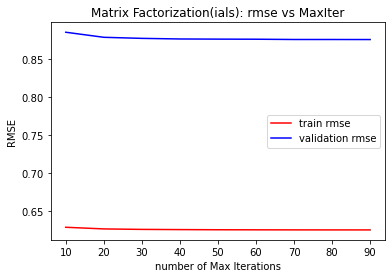

In [121]:
plt.plot(ials_iter,  ials_train_iter, color= 'r',label='train rmse' )
plt.plot(ials_iter,  ials_val_iter, color= 'b',label='validation rmse' )
plt.xlabel('number of Max Iterations')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs MaxIter')
plt.legend()
plt.show()

In [131]:
IALS_model = tc.ranking_factorization_recommender.create(train4,item_id = item_id, target = target,\
                                                            user_id = user_id, binary_target = False,\
                                                            solver = 'ials', num_factors = 70,\
                                                            regularization = 1e-4,\
                                                            ials_confidence_scaling_factor = 50 ,\
                                                            max_iterations = 30)

Preparing data set.

Data has 739349 observations with 37284 users and 36847 items.

Data prepared in: 0.653602s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 30       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 124us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.80s        | 1.09604                   |

| 1       | 5.77s        | 0.798115                  |

| 2       | 9.56s        | 0.652291                  |

| 3       | 13.69s       | 0.633339                  |

| 4       | 17.19s       | 0.625851                  |

| 5       | 20.48s       | 0.621983                  |

| 6       | 23.85s       | 0.619694                  |

| 7       | 26.79s       | 0.618218                  |

| 8       | 29.33s       | 0.617209                  |

| 9       | 31.85s       | 0.616487                  |

| 10      | 34.37s       | 0.615953                  |

| 11      | 37.16s       | 0.615546                  |

| 12      | 40.27s       | 0.615229                  |

| 13      | 44.03s       | 0.614976                  |

| 14      | 47.33s       | 0.614771                  |

| 15      | 50.76s       | 0.614602                  |

| 16      | 54.96s       | 0.614461                  |

| 17      | 58.92s       | 0.614341                  |

| 18      | 1m 1s        | 0.614238                  |

| 19      | 1m 5s        | 0.614149                  |

| 20      | 1m 8s        | 0.614071                  |

| 21      | 1m 11s       | 0.614001                  |

| 22      | 1m 14s       | 0.613939                  |

| 23      | 1m 17s       | 0.613884                  |

| 24      | 1m 21s       | 0.613833                  |

| 25      | 1m 24s       | 0.613787                  |

| 26      | 1m 27s       | 0.613745                  |

| 27      | 1m 31s       | 0.613706                  |

| 28      | 1m 34s       | 0.613671                  |

| 29      | 1m 37s       | 0.613638                  |

| FINAL   | 1m 37s       | 0.613638                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

In [132]:
IALS_evaluation = IALS_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/35941 queries. users per second: 1576.76

recommendations finished on 2000/35941 queries. users per second: 1529.76

recommendations finished on 3000/35941 queries. users per second: 1422.84

recommendations finished on 4000/35941 queries. users per second: 1358.24

recommendations finished on 5000/35941 queries. users per second: 1345.39

recommendations finished on 6000/35941 queries. users per second: 1330.96

recommendations finished on 7000/35941 queries. users per second: 1284.97

recommendations finished on 8000/35941 queries. users per second: 1257.95

recommendations finished on 9000/35941 queries. users per second: 1221.38

recommendations finished on 10000/35941 queries. users per second: 1201.6

recommendations finished on 11000/35941 queries. users per second: 1203.81

recommendations finished on 12000/35941 queries. users per second: 1209.15

recommendations finished on 13000/35941 queries. users per second: 1218.82

recommendations finished on 14000/35941 queries. users per second: 1234.11

recommendations finished on 15000/35941 queries. users per second: 1245.38

recommendations finished on 16000/35941 queries. users per second: 1256.53

recommendations finished on 17000/35941 queries. users per second: 1266.72

recommendations finished on 18000/35941 queries. users per second: 1263.66

recommendations finished on 19000/35941 queries. users per second: 1248.8

recommendations finished on 20000/35941 queries. users per second: 1241.83

recommendations finished on 21000/35941 queries. users per second: 1247.33

recommendations finished on 22000/35941 queries. users per second: 1253.78

recommendations finished on 23000/35941 queries. users per second: 1261.02

recommendations finished on 24000/35941 queries. users per second: 1267.92

recommendations finished on 25000/35941 queries. users per second: 1258.55

recommendations finished on 26000/35941 queries. users per second: 1261.47

recommendations finished on 27000/35941 queries. users per second: 1266.55

recommendations finished on 28000/35941 queries. users per second: 1271.63

recommendations finished on 29000/35941 queries. users per second: 1275.94

recommendations finished on 30000/35941 queries. users per second: 1279.59

recommendations finished on 31000/35941 queries. users per second: 1283.17

recommendations finished on 32000/35941 queries. users per second: 1278.99

recommendations finished on 33000/35941 queries. users per second: 1280

recommendations finished on 34000/35941 queries. users per second: 1281.37

recommendations finished on 35000/35941 queries. users per second: 1284.48

In [133]:
col_names =  ['cutoff', 'precision', 'recall'] 
IALS_results  = pd.DataFrame(columns = col_names)
IALS_results['cutoff'] = np.array(IALS_evaluation['precision_recall_overall']['cutoff'])
IALS_results['precision'] = np.array(IALS_evaluation['precision_recall_overall']['precision'])
IALS_results['recall'] = np.array(IALS_evaluation['precision_recall_overall']['recall'])

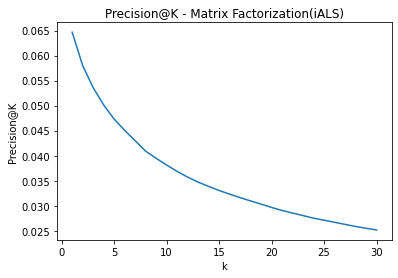

In [134]:
plt.plot(IALS_results['cutoff'],IALS_results['precision'] )
plt.title('Precision@K - Matrix Factorization(iALS)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()